In [4]:
# Stefan M. Mladjenovic - PhD Candidate at University of Toronto in Biomedical Engineering
# Three-dimensional Electron Microscopy for Nanoparticles in Tumours
# February 27 2024

C:\Users\Z6\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [1]:
#import packages necessary for importing and viewing data
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import skimage
import pandas as pd
import gc
import seaborn as sns
from tqdm import tqdm
import scipy
import tifffile
import os

from statannot import add_stat_annotation #Nov 28 2023

import string # Jan 16 2024 for x-tick labels on bar chart

C:\Users\Z6\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
#before this step, the nanoparticles are isolated from the aligned 3D EM stack
# using the random forest pixel classifier in LabKit (FIJI) and post-processed to remove noise (1px spots)

# read in np connected component analysis with unique ID file via skimage
#updated NPs after post-processing to remove 1px noise
np_unique = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/2.NP-extract/2.CCA-each-NP/label3-good/segmented-output+watershed_clean+CCA-32bit.tif", plugin="tifffile")

#view annotated dataset
plt.imshow(np_unique[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

In [ ]:
#get centroid of each unique NP in dataframe
# gives error if I don't convert from float32 to uint32

num_z_slices = np_unique.shape[0]

all_dataframes_np_unique_list = []

for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=np_unique.astype(np.uint32)[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       #intensity_image=dataset[z_slice, :, :],
                                                       properties=("label", "centroid"),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_np_unique_list.append(dataframe_current_frame)

all_dataframes_np_unique_concat = pd.concat(all_dataframes_np_unique_list)


print(all_dataframes_np_unique_concat.head())

In [ ]:
#round off values to closest bit and change values to 16 bit
all_dataframes_np_unique_concat['centroid,0_16bit'] = all_dataframes_np_unique_concat['centroid,0'].apply(np.ceil).astype(np.uint16)
all_dataframes_np_unique_concat['centroid,1_16bit'] = all_dataframes_np_unique_concat['centroid,1'].apply(np.ceil).astype(np.uint16)

In [ ]:
# save dataframe
all_dataframes_np_unique_concat.to_csv('df_unique-np-centroid-coords.csv', index=True, header=True, sep=',')


In [ ]:
# quick check to make sure each label only appears once:
    # check the max value in the array (final label)
    # check the number of unique values in the array
    # if these numbers are the same, then each label only appears once

all_dataframes_np_unique_concat = pd.read_csv('df_unique-np-centroid-coords.csv', index_col=0)
    

#print(all_dataframes_np_unique_concat['label']) # all values in label column only
#print()
print(np.max(all_dataframes_np_unique_concat['label']))
print()
print(len(all_dataframes_np_unique_concat['label']))


In [ ]:
# First create the new dataframe

#start analysis for 3D NP EDT here using images from 3D ImageJ Suite. 
    #the input images are from the annotated endothelial cell dataset. 
    #  each endothelial cell is isolated with thresholding in FIJI as a separate image stack

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]

#read in dataframe
all_dataframes_np_unique_concat = pd.read_csv('df_unique-np-centroid-coords.csv', index_col=0)

#########


all_cell_labels = index_keep_ECs
# use these cell-labels as headers    
    # but first add a string 'cell-' as a prefix

#create empty list
all_cell_labels_headers = []

for cell_label in range(len(all_cell_labels)):
    all_cell_labels_headers.append("3D-EDT-to-cell-" + str(all_cell_labels[cell_label]) + "_nm")
    
    
print()
print(all_cell_labels_headers)

#########

# get all headers necessary for dataframe
# NP-label, all cell-x labels, lowest EDT of all cell-x labels, cell-x identity of the lowest EDT
    
list_all_headers = ["NP-label"] + all_cell_labels_headers + ["lowest-EDT_nm"] + ["cell-lowest-EDT"] + ['z-slice'] + ['centroid,0_16bit'] + ['centroid,1_16bit']
print(list_all_headers)


#########

#make new dataframe with these headers
#set length of dataframe to be the number of unique NP labels

#set length of index so can fill datafram with np.inf
#create the index (number of rows) for the dataframe. Should be as long as the number of unique NP labels
df_EDT_closest_cell_index = pd.RangeIndex(len(all_dataframes_np_unique_concat)) #add plus 1 here?

# create dataframe with data filled to infinity, index from above, columns are from above
df_EDT_closest_cell = pd.DataFrame(data = np.inf, index = df_EDT_closest_cell_index, columns = list_all_headers)

# the values in the dataframe get replaced with values as the script runs

#########

#set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
#by copying data from list 

df_EDT_closest_cell['NP-label'] = all_dataframes_np_unique_concat['label'].tolist()
df_EDT_closest_cell['z-slice'] = all_dataframes_np_unique_concat['z-slice'].tolist()
df_EDT_closest_cell['centroid,0_16bit'] = all_dataframes_np_unique_concat['centroid,0_16bit'].tolist()
df_EDT_closest_cell['centroid,1_16bit'] = all_dataframes_np_unique_concat['centroid,1_16bit'].tolist()


#########

#export csv for blank EDT with just headers EDT details
df_EDT_closest_cell.to_csv('df_EDT_headers.csv', index=True, header=True, sep=',')

df_EDT_closest_cell

In [ ]:
#using this script, determine the 3D Euclidean distance from each each EC (3D ImageJ Suite in FIJI) to each NP centroid
    #Before running this script we need the 3D EDT for each EC in the dataset
        # To get this dataset, in FIJI, I thresholded each of the individual EC cells and saved it as an 8-bit image. 
        # On each of these images of the individual 8bit ECs, I set the resolution (x/y=17nm/px and z=70nn)
            # this is important because Thomas Boudier's 3D Suite package respects anisotropy and calculated 3D EDT. 
            # Also, FIJI can use 100% CPU usage unlike Python (limited by GIL)
        # Then, I used 3D Suite to calculate the inversed 3D EDT for each images (32-bit image result). 
        # These 32-bit 3D suite images are used in this script to determine the EDT from each cell to each NP centroid

# all 3D Suite EDT 32bit Tiff files were saved to have the following name: 
    #3DSUITE-EDT_ECx, where x is the EC ID from index_keep_ECs


#read in dataframe to add to (if it exists). 
    #If the file does not exist, just use the above code-block to generate the empty dataframe for the variable: df_EDT_closest_cell
#hard-coded the name of the file here since I did ECs 13-17 from local  (C: drive) originally. 
    #Then moved the images to server for storage since the images are large (40GB each, 32-bit imgs).
    #also had some images saved on F: drive (i.e. external directory)

#re-run this script and change the files being read in once they have been added to the dataframe. 
    #because not enough space on C: drive to store all 3D EDT images for all endothelial cells
#df_EDT_closest_cell = pd.read_csv('df_EDT_headers.csv', index_col=0)
#df_EDT_closest_cell = pd.read_csv('df_EDT_7_18.csv', index_col=0)


for i in range(len(index_keep_ECs)):
    current_EDT_filename = "3DSUITE-EDT_EC"+ str(index_keep_ECs[i]) +".tif"
    current_column_name = "3D-EDT-to-cell-" + str(index_keep_ECs[i]) + "_nm"
    #print(current_EDT_filename)
    #print(current_column_name)
    
    #local directory
    #directory_path = os.path.join("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/3D-EDT/2.each-EC-EDT/", current_EDT_filename)
    
    #external directory
    #directory_path = os.path.join("F:/3D-EDT-Jan4-2024/2.each-EC-EDT/", current_EDT_filename)
    #directory_path = os.path.join("F:/3D-EDT-Jan4-2024/1.each-EC/", current_EDT_filename)
    
    print(directory_path)

    #check if the respective EDT for the EC in question exists. Collect information in respective column if it exists
        #need to do this because each 3D EDT file is 40gb (32bit) and we can't fit all files in the local drive simultaneously
    if os.path.exists(directory_path):
        #print("exists")
        print(current_EDT_filename)
        print()
        
        #'''        
        
        #read in current 3D EDT for analysis. Can safely fit 1 image in RAM at once. Update variable with new EC 3D EDT on each loop
            #32-bit 3D EDT from FIJI 3D Suite: 
        
        #check if the variable exists and delete it if it does. This is because in Python the previous variable gets deleted after the new one is loaded into memory
            # so you can imagine that when a 40gb image is in memory, the second 40gb image is loaded in (total of 80gb RAM required) before the first 40gb is deleted and reducing the total RAM usage back to 40gb
        
        if 'EDT_3D' in locals():
            del EDT_3D
        
        EDT_3D = io.imread(directory_path, plugin="tifffile")
    
        #get shape of 1 slice of dataset
        z_shape, y_shape, x_shape = EDT_3D.shape # can use annotated or annotated_EC_only here, 1 less variable to need if I use annotated_EC_only

        
        #set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
        for each_np in tqdm(range(len(df_EDT_closest_cell))): 
            each_np_plus_1 = each_np+1
            #if each_np ==0:
            #    pass

            
            #all_df_EDT_combined['3D-EDT-from-EC'][each_np] = EDT_3D[current_np_coords_set] # gives error, see: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
            #use this with .loc, still gives error, but proceed anyway because output is correct

            #get coordinates of NP with unique value
            #********* need to update z_slice since the dataframe is empty?
                #see: df_unique-np-centroid-coords.csv
            
            z_slice_np = df_EDT_closest_cell['z-slice'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]
            y_coord_np = df_EDT_closest_cell['centroid,0_16bit'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]
            x_coord_np = df_EDT_closest_cell['centroid,1_16bit'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]

            #get coords as a set
            #needed to nest the values as int for some reason to avoid error
            current_np_coords_set = int(z_slice_np), int(y_coord_np) , int(x_coord_np)

            #set value for current column name
                
            df_EDT_closest_cell.loc[each_np,current_column_name] = EDT_3D[current_np_coords_set]  
    
        print("completed: ",current_EDT_filename)
        #'''
    
    #if the file is not currently in the local drive, then don't do anything
    if not os.path.exists(directory_path):
        pass
        #print("does not exist")
        

In [ ]:
#export csv with current EDT details
    #once appropriate images are done being processed into dataframe, comment the cell out
#df_EDT_closest_cell.to_csv('df_EDT_headers.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_13_18.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_7_18.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_25.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_all-cells.csv', index=True, header=True, sep=',')


In [ ]:
# now determine the minimum intensity value of the row for the NP
    #this represents the shortest distance

#do not use for-loop --> it is very inefficient. Use apply with lambda list comprehension instead. 
    
#read in dataframe
df_EDT_closest_cell = pd.read_csv('df_EDT_all-cells.csv', index_col=0)

#get the lowest EDT nm value for each row when only considering  the part of the dataframe that has columns that match the headers
    #need to only consider columns within the headers, otherwise, will get an inaccurate number for example can get a value of 0 for when z-slice=0 in the same row
df_EDT_closest_cell['lowest-EDT_nm'] = df_EDT_closest_cell[all_cell_labels_headers].min(axis=1)

#for each row, get the column name which matches the lowest-EDT_nm value. Store this in the column 'cell-lowest-EDT'

#long-name of column only
#df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell.loc[:,all_cell_labels_headers].isin(df_EDT_closest_cell['lowest-EDT_nm']).idxmax(1)

#cell name of the column (alternative) using lambda after getting the long-name of column using indexing

#get long name    
df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell.loc[:,all_cell_labels_headers].isin(df_EDT_closest_cell['lowest-EDT_nm']).idxmax(1)
#get index of string

#print(all_cell_labels_headers.index('3D-EDT-to-cell-8_nm'))
#print(index_keep_ECs[all_cell_labels_headers.index('3D-EDT-to-cell-8_nm')])

df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell['cell-lowest-EDT'].apply(lambda row: index_keep_ECs[all_cell_labels_headers.index(row)])


#save file
df_EDT_closest_cell.to_csv('df_EDT_all-cells_complete.csv', index=True, header=True, sep=',')

In [ ]:
#morphometric data analysis begins here

In [ ]:
#below is the calculations and details for morphometric calculations

# SA calculations:

# to do: count the number of each pixel for each material/index in the outline SA image throughout whole z-stack
    # then multiply by 70nm (~4.11px = 70nm; because 1px = 17nm)

# did image pre-processing for SA in FIJI
# see folder: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\8.MIB\1.two-vessel\render-model\1.Oct21-2023\2.outline-for-SA\output
# result is here as image: z-stack-annotated_outline.tif

# the fiji IJM script is: SA-each-object-slice.ijm 
# fiji IJM script is here: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\8.MIB\1.two-vessel\render-model\1.Oct21-2023\2.outline-for-SA


#SA and Volume calculations are pretty much the same. All you have to do is count the number of pixels of each value
    # for the annotated (vol) and annotated-perimeter (SA) dataset

#updated annotated dataset from Dec 19 2023 clean-up
annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")


# read in annotated dataset perimeter for calculating SA

#updated annotated perimeter dataset from Dec 19 2023 clean-up
annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")



In [8]:
# read in annotated dataset file via skimage

#updated annotated dataset from Dec 19 2023 clean-up
annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")

#view annotated dataset
plt.imshow(annotated[6],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()


In [10]:
# read in watershed nanoparticles
    #this is nps_unique as it has undergone connected component analysis (CCA) in FIJI to label each NP with different ID

# use new NP file from December 19 2023
np_unique = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/2.NP-extract/2.CCA-each-NP/label3-good/segmented-output+watershed_clean+CCA-32bit.tif", plugin="tifffile")

#view NPs dataset
plt.imshow(np_unique[0],cmap='gist_stern') #first slice of annotated z-stack
plt.show()

In [11]:
#create index of endothelial and non-endothelial cells in the dataset
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
index_remove_non_ECs = [1, 2, 3, 4, 5, 6, 26, 35] # accidentally had label 19 inside before

In [12]:
print(len(index_keep_ECs)) # there are 27 ECs to keep

27


In [13]:
#view annotated dataset
annotated[0] #first slice of annotated z-stack

#get a numpy array with only the EC cells inside (remove non-EC cell annotations)

# this converts to binary however... we need the original values intact
EC_only_annotated_binary = np.isin(annotated, index_keep_ECs) 

In [21]:
#convert boolean to integer by multiplying true/false by 1 (integer)

EC_only_annotated_binary_int_8bit = (EC_only_annotated_binary * 1).astype(np.uint8) # because less than 256 cells

#convert to 8-bit since by default the boolean gets convert to 32-bit 

In [14]:
#can create annotated_EC_only by multiplying the annotated array by EC_only_annotated_binary
    #easiest way to do this is to element-wise multiply the 0 and 1 EC-only numpy array by the numpy array with all values (annotated, including non-ECs).
    # will be a value of 0 for anywhere there is no EC (i.e. where EC_only_annotated_binary has value of 0)
    # undesired cells will be removed as they are multiplied by 0
    # this will have the full values for annotated but only for the EC subset

annotated_EC_only = np.multiply(annotated, EC_only_annotated_binary_int_8bit)

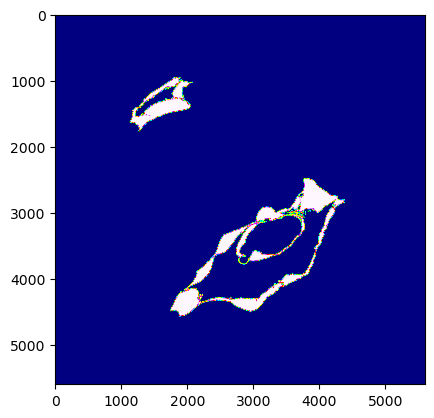

In [15]:
#view EC-only binary dataset
plt.imshow(EC_only_annotated_binary_int_8bit[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

In [23]:
#free up RAM
#import gc

del EC_only_annotated_binary
del EC_only_annotated_binary_int
gc.collect()


8485

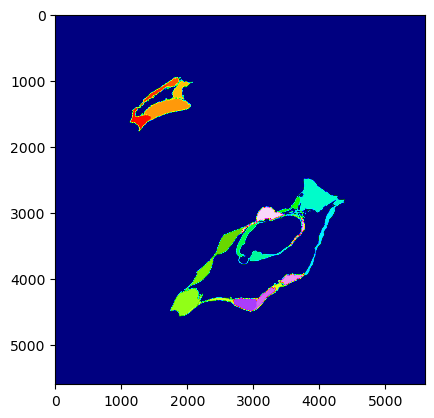

In [25]:
#view first slice of annotated dataset with only ECs 
plt.imshow(annotated_EC_only[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

#looks good. cannot see RBCs for example, but the colours are back, not binary

In [26]:
#save EC_only_annotated_int as a tif file for importing


#for some reason couldn't save annotated_EC_only with mimwrite, but tifffile worked
#use BigTiff
# Convert to 8 bit before saving
#error: data too large for standard TIFF file
# likely because data is bigger than 4gb

#already saved this image, so comment out for now

#import tifffile
tifffile.imwrite('new_num_annotated_EC_only_8bit.tif', annotated_EC_only.astype(np.uint8), bigtiff=True,)
tifffile.imwrite('new_binary_annotated_EC_only_8bit.tif', EC_only_annotated_binary_int_8bit.astype(np.uint8), bigtiff=True,)


#this now works
#looks good in FIJI


In [27]:
# get intensity data of each slice for each cell - version 4
    # but rename dataframe now with diameter suffix because will add diameter numbers to this same dataframe in later part of script
    # *** new Nov 24, getting area too. use this for volume calculations. 
        # Need to repeat same analysis on perimeter only file to get surface area values

    
#dataset = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/3.data-update-145/update-145_dataset_fine_ome.tif", plugin="tifffile")
#annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")


#doing region props on each slice of dataset (each index of z-dimension)
    
all_dataframes_concat_diameter = pd.DataFrame() #reset dataframe for when doing testing
    
num_z_slices = annotated.shape[0]

all_dataframes_list = []
for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=annotated[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       intensity_image=dataset[z_slice, :, :],
                                                       properties=(
                                                           'label', 
                                                           'mean_intensity',
                                                           #'axis_major_length',
                                                           #'axis_minor_length',
                                                           #'equivalent_diameter_area',
                                                           'area',
                                                       ),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_list.append(dataframe_current_frame)

all_dataframes_concat_diameter = pd.concat(all_dataframes_list)
all_dataframes_concat_diameter['intensity'] = all_dataframes_concat_diameter['mean_intensity'].astype(np.uint16)

#use surface area on each slice to get volume of each label on each slice
all_dataframes_concat_diameter['volume_um3'] = all_dataframes_concat_diameter['area']*(17*17*70)/(1000*1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but volume, not length, so cube. 1 nm^2 = 1/(1000*1000*1000) um^3

#print(all_dataframes_concat.head())

100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:58<00:00,  5.82it/s]


In [28]:
# add a column for the overall index. 
all_dataframes_concat_diameter.insert(1, 'index_manual', range(len(all_dataframes_concat_diameter)))

In [29]:
all_dataframes_concat_diameter.head(40)

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3
0,2,0,148.989227,240414.0,0,148,4.863575
1,7,1,189.024586,48687.0,0,189,0.984938
2,8,2,169.589450,187541.0,0,169,3.793954
3,9,3,185.832617,38839.0,0,185,0.785713
4,10,4,164.249552,45798.0,0,164,0.926494
5,11,5,189.508928,21561.0,0,189,0.436179
6,13,6,164.950678,72017.0,0,164,1.456904
7,14,7,162.465813,51248.0,0,162,1.036747
8,15,8,181.265027,113826.0,0,181,2.302700
9,16,9,144.104130,13704.0,0,144,0.277232


In [556]:
#see data for only ECs
all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)]

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790
2,8,2,169.589450,187541.0,0,169,3.793954,5256.0,6.25464,653.449849,465.636525,895.272026,487.014252,15219.624437,15.219624
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645,631.229849,144.609624,672.209045,222.376597,11427.553763,11.427554
4,10,4,164.249552,45798.0,0,164,0.926494,3026.0,3.60094,736.459835,211.085617,745.413308,241.478415,12672.026239,12.672026
5,11,5,189.508928,21561.0,0,189,0.436179,1241.0,1.47679,425.321940,123.069496,389.313498,165.687410,6618.329472,6.618329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,21,6499,207.316078,1642.0,341,207,0.033218,NaN,NaN,106.844145,22.148891,107.540690,44.208853,1828.191730,1.828192
8,22,6500,192.582927,820.0,341,192,0.016589,NaN,NaN,53.054268,21.689615,51.788030,32.311862,880.396502,0.880397
9,25,6501,184.112554,231.0,341,184,0.004673,NaN,NaN,20.166541,14.687019,21.400935,17.149879,363.815888,0.363816
10,27,6502,140.519343,60255.0,341,140,1.218959,NaN,NaN,984.264948,334.987442,1074.966976,275.978108,18274.438596,18.274439


In [ ]:
#Jan 11 2024
#at this point, should remove the bad slices if for non-morphometric data
# for mean-intensity, should remove bad slices since this will change the data 
    #i.e. data will be biased if the annotation covers a region with black pixels or where the tissue is folded


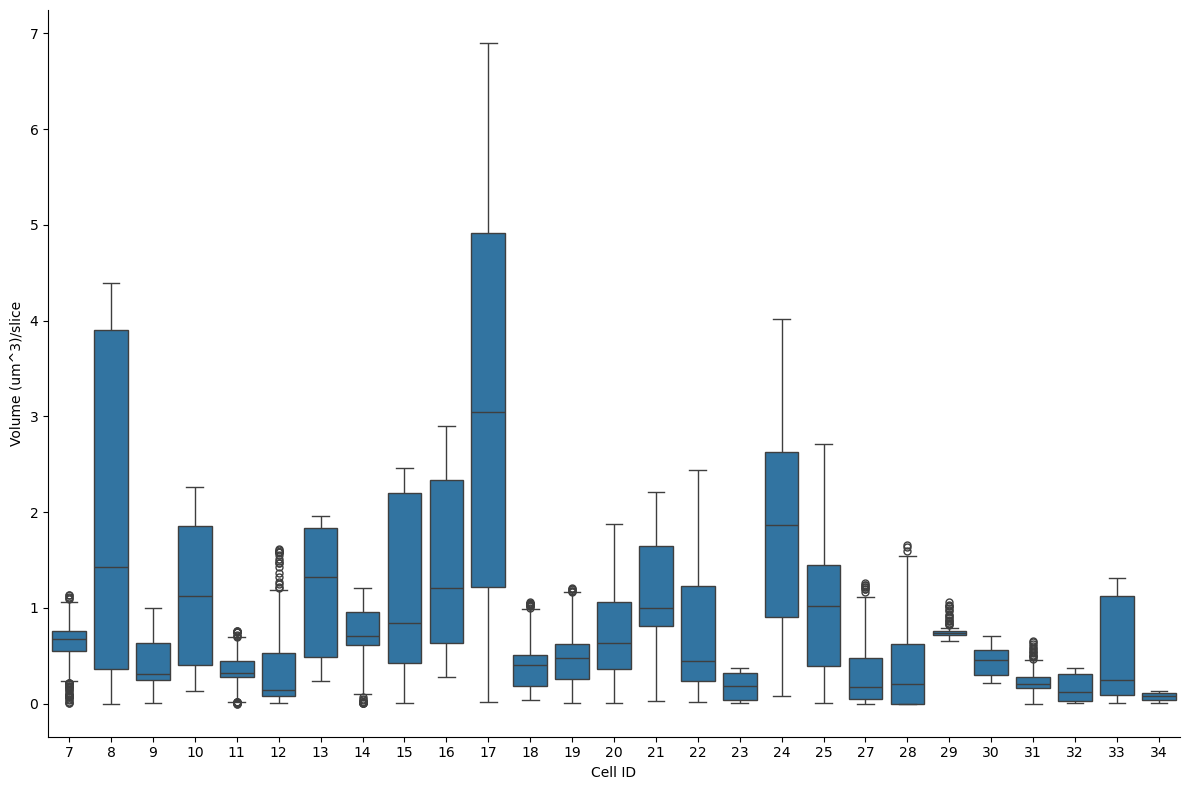

In [31]:
#visualize results - volume (um^3) for each label on each slice


#ECs only
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='volume_um3', kind='box', height = 8, aspect = 1.5)

#specfiy axis labels
ax.set(xlabel='Cell ID',
       ylabel='Volume (um^3)/slice',
      )

#display histogram
plt.show()


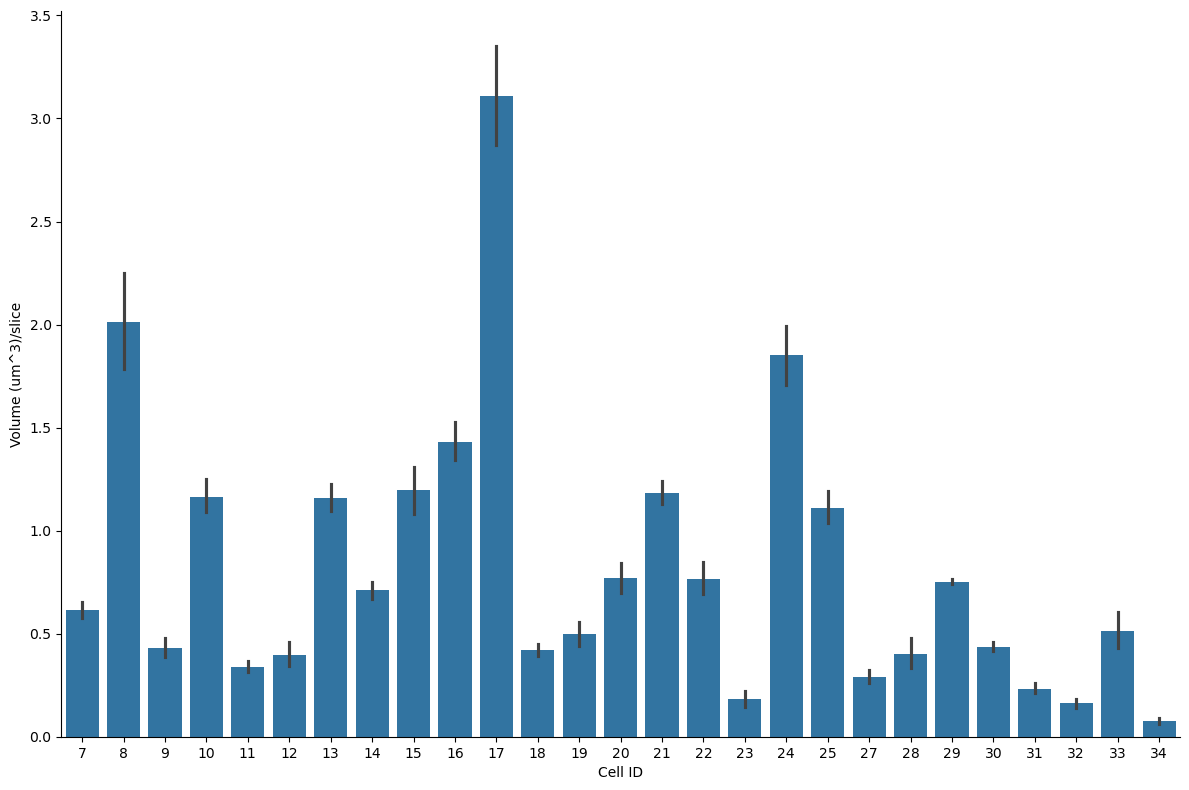

In [32]:
#visualize results - volume (um^3) for each label on each slice

#ax = sns.catplot(data=all_dataframes_concat_diameter, x='label', y='volume_um3', kind='bar', height = 8, aspect = 1.5)
#ECs only
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='volume_um3', kind='bar', height = 8, aspect = 1.5)

#specfiy axis labels
ax.set(xlabel='Cell ID',
       ylabel='Volume (um^3)/slice',
      )

#display histogram
plt.show()


In [33]:
#get surface area per slice using annotated_perimeter file

annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")


In [34]:
#DOING SURFACE AREA HERE BY USING THE PERIMETER FILE (ALL CELLS)

#use update files for December 19 2023 annotation + annotation_perimeter

#dataset = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/3.data-update-145/update-145_dataset_fine_ome.tif", plugin="tifffile")
#annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")
#annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")


#add new columns as empty to dataframe
#new_column_headers_diameter = ['axis_major_length','axis_minor_length','feret_diameter_max','equivalent_diameter_area']


all_dataframes_concat_diameter = all_dataframes_concat_diameter.reindex(columns = all_dataframes_concat_diameter.columns.tolist() + ['surface_area','surface_area_um2'])
 
from skimage.measure import label 
    
#num_z_slices = annotated_perimeter.shape[0] #use annotated_perimeter instead of annotated


for each_row in tqdm(range(0,len(all_dataframes_concat_diameter))):
    
    #set regionmask to be the current slice of perimeter_annotated dataset
    regionmask = annotated_perimeter[all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int)] #need to put astype int, otherwise turns to float at index 27
    #print(all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int))
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(annotated_perimeter[0].shape, dtype=np.uint8)

    #get the current label of the row
    current_label = all_dataframes_concat_diameter['label'].iloc[each_row].astype(int)

    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1)

    # DO NOT GET THE CONNECTED COMPONENT. WE WANT THE SA OF ALL PIECES OF THE PERIMETER ON EACH SLICE
    #get the largest connected component (CC) for the current label on the current slice
    #labels = label(regionmask_current)


    roi_surface_area = skimage.measure.regionprops_table(
                                                    label_image=regionmask_current, #added '[frame, :, :]' after annotated
                                                    #intensity_image=dataset[z_slice, :, :],
                                                    properties=(
                                                        'area',
                                                    ),
                                                    separator=",",
                                                    extra_properties=None,
                                                    )

        

    #catch errors when there is no surface area (for example, label 28 on row 4137, also row 4609)
    if len(roi_surface_area['area']) >0:
        print(each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area')] = roi_surface_area['area'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area_um2')] = roi_surface_area['area'][0]*(17*70)/(1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but surface area, not length, so square. 1 nm^2 = 1/(1000*1000) um^2
    #set value to 0 if there is an error
    else:
        print("error: ", each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area')] = 0
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area_um2')] = 0    
    
    #just use loc with index_manual as index_manual are unique
    

  0%|                                                                                 | 2/6506 [00:00<15:15,  7.10it/s]

0 2 [7635.] 1
1 7 [3271.] 1


  0%|                                                                                 | 4/6506 [00:00<14:36,  7.42it/s]

2 8 [5669.] 1
3 9 [1955.] 1


  0%|                                                                                 | 6/6506 [00:00<14:42,  7.37it/s]

4 10 [3138.] 1
5 11 [1241.] 1


  0%|                                                                                 | 8/6506 [00:01<14:44,  7.35it/s]

6 13 [2202.] 1
7 14 [1903.] 1


  0%|                                                                                | 10/6506 [00:01<14:47,  7.32it/s]

8 15 [2346.] 1
9 16 [3810.] 1


  0%|▏                                                                               | 12/6506 [00:01<14:30,  7.46it/s]

10 17 [4652.] 1
11 18 [530.] 1


  0%|▏                                                                               | 14/6506 [00:01<14:57,  7.23it/s]

12 21 [2536.] 1
13 22 [2501.] 1


  0%|▏                                                                               | 16/6506 [00:02<14:59,  7.22it/s]

14 23 [956.] 1
15 24 [2344.] 1


  0%|▏                                                                               | 18/6506 [00:02<14:37,  7.39it/s]

16 25 [1793.] 1
17 26 [797.] 1


  0%|▏                                                                               | 20/6506 [00:02<14:42,  7.35it/s]

18 29 [1258.] 1
19 30 [1800.] 1


  0%|▎                                                                               | 22/6506 [00:03<14:49,  7.29it/s]

20 31 [1394.] 1
21 32 [1437.] 1


  0%|▎                                                                               | 24/6506 [00:03<14:45,  7.32it/s]

22 33 [1538.] 1
23 34 [909.] 1


  0%|▎                                                                               | 26/6506 [00:03<14:45,  7.32it/s]

24 35 [1920.] 1
25 2 [7414.] 1


  0%|▎                                                                               | 28/6506 [00:03<14:59,  7.20it/s]

26 7 [3229.] 1
27 8 [5444.] 1


  0%|▎                                                                               | 30/6506 [00:04<14:39,  7.36it/s]

28 9 [1957.] 1
29 10 [3049.] 1


  0%|▍                                                                               | 32/6506 [00:04<15:00,  7.19it/s]

30 11 [1264.] 1
31 13 [2249.] 1


  1%|▍                                                                               | 34/6506 [00:04<14:37,  7.37it/s]

32 14 [1971.] 1
33 15 [2348.] 1


  1%|▍                                                                               | 36/6506 [00:04<14:58,  7.20it/s]

34 16 [3928.] 1
35 17 [4754.] 1


  1%|▍                                                                               | 38/6506 [00:05<14:54,  7.23it/s]

36 18 [565.] 1
37 21 [2439.] 1


  1%|▍                                                                               | 40/6506 [00:05<14:34,  7.40it/s]

38 22 [2599.] 1
39 23 [970.] 1


  1%|▌                                                                               | 42/6506 [00:05<14:37,  7.36it/s]

40 24 [2290.] 1
41 25 [1839.] 1


  1%|▌                                                                               | 44/6506 [00:06<14:37,  7.36it/s]

42 26 [793.] 1
43 29 [1313.] 1


  1%|▌                                                                               | 46/6506 [00:06<14:40,  7.34it/s]

44 30 [1687.] 1
45 31 [1440.] 1


  1%|▌                                                                               | 48/6506 [00:06<14:39,  7.34it/s]

46 32 [1460.] 1
47 33 [1586.] 1


  1%|▌                                                                               | 50/6506 [00:06<14:39,  7.34it/s]

48 34 [918.] 1
49 35 [1757.] 1


  1%|▋                                                                               | 52/6506 [00:07<14:59,  7.17it/s]

50 2 [7597.] 1
51 7 [3156.] 1


  1%|▋                                                                               | 54/6506 [00:07<14:55,  7.21it/s]

52 8 [5460.] 1
53 9 [1948.] 1


  1%|▋                                                                               | 56/6506 [00:07<14:33,  7.38it/s]

54 10 [3071.] 1
55 11 [1247.] 1


  1%|▋                                                                               | 58/6506 [00:07<14:36,  7.36it/s]

56 13 [2200.] 1
57 14 [1969.] 1


  1%|▋                                                                               | 60/6506 [00:08<14:35,  7.36it/s]

58 15 [2228.] 1
59 16 [3759.] 1


  1%|▊                                                                               | 62/6506 [00:08<14:35,  7.36it/s]

60 17 [4688.] 1
61 18 [500.] 1


  1%|▊                                                                               | 64/6506 [00:08<14:42,  7.30it/s]

62 21 [2382.] 1
63 22 [2566.] 1


  1%|▊                                                                               | 66/6506 [00:09<14:55,  7.19it/s]

64 23 [1087.] 1
65 24 [2258.] 1


  1%|▊                                                                               | 68/6506 [00:09<14:54,  7.20it/s]

66 25 [1921.] 1
67 26 [763.] 1


  1%|▊                                                                               | 70/6506 [00:09<15:03,  7.12it/s]

68 29 [1350.] 1
69 30 [1742.] 1


  1%|▉                                                                               | 72/6506 [00:09<14:43,  7.29it/s]

70 31 [1389.] 1
71 32 [1469.] 1


  1%|▉                                                                               | 74/6506 [00:10<14:56,  7.17it/s]

72 33 [1566.] 1
73 34 [901.] 1


  1%|▉                                                                               | 76/6506 [00:10<15:13,  7.04it/s]

74 35 [1752.] 1
75 2 [7757.] 1


  1%|▉                                                                               | 78/6506 [00:10<14:54,  7.18it/s]

76 7 [3139.] 1
77 8 [5744.] 1


  1%|▉                                                                               | 80/6506 [00:10<14:49,  7.22it/s]

78 9 [1977.] 1
79 10 [3141.] 1


  1%|█                                                                               | 82/6506 [00:11<14:35,  7.34it/s]

80 11 [1257.] 1
81 13 [2216.] 1


  1%|█                                                                               | 84/6506 [00:11<14:10,  7.55it/s]

82 14 [1968.] 1
83 15 [2131.] 1


  1%|█                                                                               | 86/6506 [00:11<14:41,  7.28it/s]

84 16 [3870.] 1
85 17 [4643.] 1


  1%|█                                                                               | 88/6506 [00:12<14:27,  7.40it/s]

86 18 [537.] 1
87 21 [2298.] 1


  1%|█                                                                               | 90/6506 [00:12<14:44,  7.26it/s]

88 22 [2647.] 1
89 23 [1172.] 1


  1%|█▏                                                                              | 92/6506 [00:12<14:27,  7.40it/s]

90 24 [2289.] 1
91 25 [1969.] 1


  1%|█▏                                                                              | 94/6506 [00:12<14:17,  7.48it/s]

92 26 [765.] 1
93 29 [1301.] 1


  1%|█▏                                                                              | 96/6506 [00:13<14:27,  7.39it/s]

94 30 [1724.] 1
95 31 [1481.] 1


  2%|█▏                                                                              | 98/6506 [00:13<14:49,  7.20it/s]

96 32 [1545.] 1
97 33 [1658.] 1


  2%|█▏                                                                             | 100/6506 [00:13<14:29,  7.37it/s]

98 34 [834.] 1
99 35 [1721.] 1


  2%|█▏                                                                             | 102/6506 [00:13<14:53,  7.17it/s]

100 2 [7919.] 1
101 7 [3151.] 1


  2%|█▎                                                                             | 104/6506 [00:14<14:45,  7.23it/s]

102 8 [5867.] 1
103 9 [1907.] 1


  2%|█▎                                                                             | 106/6506 [00:14<14:19,  7.45it/s]

104 10 [3192.] 1
105 11 [1256.] 1


  2%|█▎                                                                             | 108/6506 [00:14<14:13,  7.50it/s]

106 13 [2243.] 1
107 14 [1972.] 1


  2%|█▎                                                                             | 110/6506 [00:15<14:41,  7.25it/s]

108 15 [2261.] 1
109 16 [3770.] 1


  2%|█▎                                                                             | 112/6506 [00:15<14:55,  7.14it/s]

110 17 [4651.] 1
111 18 [538.] 1


  2%|█▍                                                                             | 114/6506 [00:15<14:15,  7.47it/s]

112 21 [2279.] 1
113 22 [2664.] 1


  2%|█▍                                                                             | 116/6506 [00:15<14:42,  7.24it/s]

114 23 [1126.] 1
115 24 [2248.] 1


  2%|█▍                                                                             | 118/6506 [00:16<14:23,  7.40it/s]

116 25 [2001.] 1
117 26 [833.] 1


  2%|█▍                                                                             | 120/6506 [00:16<14:28,  7.35it/s]

118 29 [1328.] 1
119 30 [1723.] 1


  2%|█▍                                                                             | 122/6506 [00:16<14:17,  7.44it/s]

120 31 [1484.] 1
121 32 [1516.] 1


  2%|█▌                                                                             | 124/6506 [00:16<14:13,  7.48it/s]

122 33 [1773.] 1
123 34 [809.] 1


  2%|█▌                                                                             | 126/6506 [00:17<14:23,  7.39it/s]

124 35 [1713.] 1
125 2 [7768.] 1


  2%|█▌                                                                             | 128/6506 [00:17<14:26,  7.36it/s]

126 7 [3135.] 1
127 8 [5636.] 1


  2%|█▌                                                                             | 130/6506 [00:17<14:30,  7.32it/s]

128 9 [1887.] 1
129 10 [3364.] 1


  2%|█▌                                                                             | 132/6506 [00:18<14:19,  7.42it/s]

130 11 [1279.] 1
131 13 [2391.] 1


  2%|█▋                                                                             | 134/6506 [00:18<14:22,  7.39it/s]

132 14 [2019.] 1
133 15 [2227.] 1


  2%|█▋                                                                             | 136/6506 [00:18<14:21,  7.39it/s]

134 16 [3760.] 1
135 17 [4871.] 1


  2%|█▋                                                                             | 138/6506 [00:18<14:27,  7.34it/s]

136 18 [583.] 1
137 21 [2255.] 1


  2%|█▋                                                                             | 140/6506 [00:19<14:25,  7.35it/s]

138 22 [2627.] 1
139 23 [1105.] 1


  2%|█▋                                                                             | 142/6506 [00:19<14:45,  7.18it/s]

140 24 [2460.] 1
141 25 [2033.] 1


  2%|█▋                                                                             | 144/6506 [00:19<14:37,  7.25it/s]

142 26 [875.] 1
143 29 [1320.] 1


  2%|█▊                                                                             | 146/6506 [00:19<14:21,  7.38it/s]

144 30 [1684.] 1
145 31 [1398.] 1


  2%|█▊                                                                             | 148/6506 [00:20<14:23,  7.36it/s]

146 32 [1556.] 1
147 33 [1770.] 1


  2%|█▊                                                                             | 150/6506 [00:20<14:24,  7.35it/s]

148 34 [768.] 1
149 35 [1721.] 1


  2%|█▊                                                                             | 152/6506 [00:20<14:27,  7.33it/s]

150 2 [7843.] 1
151 7 [3213.] 1


  2%|█▊                                                                             | 154/6506 [00:21<14:26,  7.33it/s]

152 8 [5701.] 1
153 9 [1929.] 1


  2%|█▉                                                                             | 156/6506 [00:21<14:27,  7.32it/s]

154 10 [3398.] 1
155 11 [1263.] 1


  2%|█▉                                                                             | 158/6506 [00:21<14:12,  7.44it/s]

156 13 [2556.] 1
157 14 [1974.] 1


  2%|█▉                                                                             | 160/6506 [00:21<14:25,  7.34it/s]

158 15 [2246.] 1
159 16 [3551.] 1


  2%|█▉                                                                             | 162/6506 [00:22<14:11,  7.45it/s]

160 17 [5064.] 1
161 18 [558.] 1


  3%|█▉                                                                             | 164/6506 [00:22<14:38,  7.22it/s]

162 21 [2201.] 1
163 22 [2621.] 1


  3%|██                                                                             | 166/6506 [00:22<14:04,  7.51it/s]

164 23 [1078.] 1
165 24 [2565.] 1


  3%|██                                                                             | 168/6506 [00:22<14:15,  7.41it/s]

166 25 [2067.] 1
167 26 [1000.] 1


  3%|██                                                                             | 170/6506 [00:23<14:21,  7.35it/s]

168 29 [1438.] 1
169 30 [1683.] 1


  3%|██                                                                             | 172/6506 [00:23<13:45,  7.67it/s]

170 31 [1500.] 1
171 32 [1659.] 1


  3%|██                                                                             | 174/6506 [00:23<13:49,  7.64it/s]

172 33 [1740.] 1
173 34 [737.] 1


  3%|██▏                                                                            | 176/6506 [00:24<14:33,  7.24it/s]

174 35 [1685.] 1
175 2 [7901.] 1


  3%|██▏                                                                            | 178/6506 [00:24<14:37,  7.21it/s]

176 7 [3245.] 1
177 8 [5658.] 1


  3%|██▏                                                                            | 180/6506 [00:24<14:15,  7.39it/s]

178 9 [1879.] 1
179 10 [3499.] 1


  3%|██▏                                                                            | 182/6506 [00:24<14:24,  7.31it/s]

180 11 [1344.] 1
181 13 [2558.] 1


  3%|██▏                                                                            | 184/6506 [00:25<14:24,  7.31it/s]

182 14 [1966.] 1
183 15 [2286.] 1


  3%|██▎                                                                            | 186/6506 [00:25<14:31,  7.25it/s]

184 16 [3562.] 1
185 17 [5216.] 1


  3%|██▎                                                                            | 188/6506 [00:25<14:10,  7.43it/s]

186 18 [637.] 1
187 21 [2214.] 1


  3%|██▎                                                                            | 190/6506 [00:25<14:19,  7.35it/s]

188 22 [2687.] 1
189 23 [1048.] 1


  3%|██▎                                                                            | 192/6506 [00:26<14:24,  7.31it/s]

190 24 [2658.] 1
191 25 [2183.] 1


  3%|██▎                                                                            | 194/6506 [00:26<14:12,  7.41it/s]

192 26 [1078.] 1
193 29 [1429.] 1


  3%|██▍                                                                            | 196/6506 [00:26<14:02,  7.49it/s]

194 30 [1622.] 1
195 31 [1382.] 1


  3%|██▍                                                                            | 198/6506 [00:27<14:11,  7.41it/s]

196 32 [1559.] 1
197 33 [1749.] 1


  3%|██▍                                                                            | 200/6506 [00:27<14:17,  7.35it/s]

198 34 [756.] 1
199 35 [1756.] 1


  3%|██▍                                                                            | 202/6506 [00:27<14:16,  7.36it/s]

200 2 [7881.] 1
201 7 [3219.] 1


  3%|██▍                                                                            | 204/6506 [00:27<14:07,  7.44it/s]

202 8 [5737.] 1
203 9 [1875.] 1


  3%|██▌                                                                            | 206/6506 [00:28<14:12,  7.39it/s]

204 10 [3606.] 1
205 11 [1327.] 1


  3%|██▌                                                                            | 208/6506 [00:28<14:34,  7.21it/s]

206 13 [2465.] 1
207 14 [1999.] 1


  3%|██▌                                                                            | 210/6506 [00:28<14:02,  7.47it/s]

208 15 [2192.] 1
209 16 [3648.] 1


  3%|██▌                                                                            | 212/6506 [00:28<13:55,  7.54it/s]

210 17 [5213.] 1
211 18 [766.] 1


  3%|██▌                                                                            | 214/6506 [00:29<14:09,  7.41it/s]

212 21 [2266.] 1
213 22 [2581.] 1


  3%|██▌                                                                            | 216/6506 [00:29<14:12,  7.38it/s]

214 23 [1024.] 1
215 24 [2660.] 1


  3%|██▋                                                                            | 218/6506 [00:29<14:01,  7.48it/s]

216 25 [2091.] 1
217 26 [1106.] 1


  3%|██▋                                                                            | 220/6506 [00:30<14:11,  7.38it/s]

218 29 [1359.] 1
219 30 [1580.] 1


  3%|██▋                                                                            | 222/6506 [00:30<14:02,  7.46it/s]

220 31 [1393.] 1
221 32 [1541.] 1


  3%|██▋                                                                            | 224/6506 [00:30<13:50,  7.56it/s]

222 33 [1704.] 1
223 34 [740.] 1


  3%|██▋                                                                            | 226/6506 [00:30<14:20,  7.30it/s]

224 35 [1744.] 1
225 2 [7774.] 1


  4%|██▊                                                                            | 228/6506 [00:31<14:26,  7.24it/s]

226 7 [3217.] 1
227 8 [5480.] 1


  4%|██▊                                                                            | 230/6506 [00:31<14:25,  7.25it/s]

228 9 [1855.] 1
229 10 [3675.] 1


  4%|██▊                                                                            | 232/6506 [00:31<14:08,  7.39it/s]

230 11 [1379.] 1
231 13 [2435.] 1


  4%|██▊                                                                            | 234/6506 [00:31<14:01,  7.46it/s]

232 14 [2047.] 1
233 15 [2332.] 1


  4%|██▊                                                                            | 236/6506 [00:32<14:07,  7.40it/s]

234 16 [3791.] 1
235 17 [5409.] 1


  4%|██▉                                                                            | 238/6506 [00:32<14:23,  7.26it/s]

236 18 [757.] 1
237 21 [2364.] 1


  4%|██▉                                                                            | 240/6506 [00:32<14:07,  7.40it/s]

238 22 [2501.] 1
239 23 [1080.] 1


  4%|██▉                                                                            | 242/6506 [00:33<14:26,  7.23it/s]

240 24 [2917.] 1
241 25 [1893.] 1


  4%|██▉                                                                            | 244/6506 [00:33<14:21,  7.27it/s]

242 26 [1056.] 1
243 29 [1366.] 1


  4%|██▉                                                                            | 246/6506 [00:33<14:02,  7.43it/s]

244 30 [1601.] 1
245 31 [1392.] 1


  4%|███                                                                            | 248/6506 [00:33<13:57,  7.47it/s]

246 32 [1453.] 1
247 33 [1877.] 1


  4%|███                                                                            | 250/6506 [00:34<14:19,  7.28it/s]

248 34 [748.] 1
249 35 [1702.] 1


  4%|███                                                                            | 252/6506 [00:34<14:38,  7.12it/s]

250 2 [7935.] 1
251 7 [3063.] 1


  4%|███                                                                            | 254/6506 [00:34<14:01,  7.43it/s]

252 8 [5647.] 1
253 9 [1853.] 1


  4%|███                                                                            | 256/6506 [00:34<14:06,  7.38it/s]

254 10 [3732.] 1
255 11 [1399.] 1


  4%|███▏                                                                           | 258/6506 [00:35<14:10,  7.34it/s]

256 13 [2379.] 1
257 14 [2089.] 1


  4%|███▏                                                                           | 260/6506 [00:35<14:12,  7.33it/s]

258 15 [2267.] 1
259 16 [3706.] 1


  4%|███▏                                                                           | 262/6506 [00:35<13:57,  7.46it/s]

260 17 [5509.] 1
261 18 [725.] 1


  4%|███▏                                                                           | 264/6506 [00:35<13:52,  7.50it/s]

262 21 [2311.] 1
263 22 [2496.] 1


  4%|███▏                                                                           | 266/6506 [00:36<14:17,  7.28it/s]

264 23 [1106.] 1
265 24 [2761.] 1


  4%|███▎                                                                           | 268/6506 [00:36<13:58,  7.44it/s]

266 25 [1998.] 1
267 26 [963.] 1


  4%|███▎                                                                           | 270/6506 [00:36<14:06,  7.37it/s]

268 29 [1353.] 1
269 30 [1595.] 1


  4%|███▎                                                                           | 272/6506 [00:37<14:09,  7.34it/s]

270 31 [1400.] 1
271 32 [1470.] 1


  4%|███▎                                                                           | 274/6506 [00:37<14:12,  7.31it/s]

272 33 [1844.] 1
273 34 [654.] 1


  4%|███▎                                                                           | 276/6506 [00:37<13:56,  7.45it/s]

274 35 [1695.] 1
275 2 [6834.] 1


  4%|███▍                                                                           | 278/6506 [00:37<14:15,  7.28it/s]

276 7 [2927.] 1
277 8 [4734.] 1


  4%|███▍                                                                           | 280/6506 [00:38<14:19,  7.24it/s]

278 9 [1776.] 1
279 10 [3553.] 1


  4%|███▍                                                                           | 282/6506 [00:38<14:17,  7.26it/s]

280 11 [1358.] 1
281 13 [2102.] 1


  4%|███▍                                                                           | 284/6506 [00:38<13:46,  7.53it/s]

282 14 [1940.] 1
283 15 [1959.] 1


  4%|███▍                                                                           | 286/6506 [00:38<13:56,  7.43it/s]

284 16 [3081.] 1
285 17 [5120.] 1


  4%|███▍                                                                           | 288/6506 [00:39<14:02,  7.38it/s]

286 18 [674.] 1
287 21 [2171.] 1


  4%|███▌                                                                           | 290/6506 [00:39<14:04,  7.36it/s]

288 22 [2286.] 1
289 23 [1020.] 1


  4%|███▌                                                                           | 292/6506 [00:39<14:07,  7.33it/s]

290 24 [2426.] 1
291 25 [1656.] 1


  5%|███▌                                                                           | 294/6506 [00:40<13:56,  7.42it/s]

292 26 [905.] 1
293 29 [1289.] 1


  5%|███▌                                                                           | 296/6506 [00:40<14:01,  7.38it/s]

294 30 [1535.] 1
295 31 [1226.] 1


  5%|███▌                                                                           | 298/6506 [00:40<13:59,  7.39it/s]

296 32 [1400.] 1
297 33 [1717.] 1


  5%|███▋                                                                           | 300/6506 [00:40<14:11,  7.29it/s]

298 34 [623.] 1
299 35 [1618.] 1


  5%|███▋                                                                           | 302/6506 [00:41<14:26,  7.16it/s]

300 2 [7506.] 1
301 7 [3050.] 1


  5%|███▋                                                                           | 304/6506 [00:41<14:14,  7.26it/s]

302 8 [5589.] 1
303 9 [1855.] 1


  5%|███▋                                                                           | 306/6506 [00:41<13:53,  7.44it/s]

304 10 [3634.] 1
305 11 [1482.] 1


  5%|███▋                                                                           | 308/6506 [00:41<14:03,  7.35it/s]

306 13 [2140.] 1
307 14 [2010.] 1


  5%|███▊                                                                           | 310/6506 [00:42<14:08,  7.30it/s]

308 15 [2343.] 1
309 16 [3731.] 1


  5%|███▊                                                                           | 312/6506 [00:42<13:51,  7.45it/s]

310 17 [5861.] 1
311 18 [706.] 1


  5%|███▊                                                                           | 314/6506 [00:42<13:45,  7.50it/s]

312 21 [2207.] 1
313 22 [2413.] 1


  5%|███▊                                                                           | 316/6506 [00:43<13:53,  7.42it/s]

314 23 [1022.] 1
315 24 [2865.] 1


  5%|███▊                                                                           | 318/6506 [00:43<14:04,  7.33it/s]

316 25 [1979.] 1
317 26 [953.] 1


  5%|███▉                                                                           | 320/6506 [00:43<13:50,  7.45it/s]

318 29 [1369.] 1
319 30 [1538.] 1


  5%|███▉                                                                           | 322/6506 [00:43<14:02,  7.34it/s]

320 31 [1335.] 1
321 32 [1616.] 1


  5%|███▉                                                                           | 324/6506 [00:44<14:01,  7.34it/s]

322 33 [1909.] 1
323 34 [606.] 1


  5%|███▉                                                                           | 326/6506 [00:44<14:28,  7.11it/s]

324 35 [1819.] 1
325 2 [7600.] 1


  5%|███▉                                                                           | 328/6506 [00:44<14:07,  7.29it/s]

326 7 [3004.] 1
327 8 [5701.] 1


  5%|████                                                                           | 330/6506 [00:44<14:06,  7.29it/s]

328 9 [1853.] 1
329 10 [3679.] 1


  5%|████                                                                           | 332/6506 [00:45<14:08,  7.28it/s]

330 11 [1452.] 1
331 13 [2092.] 1


  5%|████                                                                           | 334/6506 [00:45<14:11,  7.25it/s]

332 14 [1986.] 1
333 15 [2243.] 1


  5%|████                                                                           | 336/6506 [00:45<14:06,  7.29it/s]

334 16 [3421.] 1
335 17 [5827.] 1


  5%|████                                                                           | 338/6506 [00:46<14:07,  7.28it/s]

336 18 [703.] 1
337 21 [2165.] 1


  5%|████▏                                                                          | 340/6506 [00:46<13:53,  7.40it/s]

338 22 [2361.] 1
339 23 [1026.] 1


  5%|████▏                                                                          | 342/6506 [00:46<13:52,  7.40it/s]

340 24 [2890.] 1
341 25 [2388.] 1


  5%|████▏                                                                          | 344/6506 [00:46<13:46,  7.46it/s]

342 26 [992.] 1
343 29 [1382.] 1


  5%|████▏                                                                          | 346/6506 [00:47<13:59,  7.34it/s]

344 30 [1488.] 1
345 31 [1376.] 1


  5%|████▏                                                                          | 348/6506 [00:47<14:22,  7.14it/s]

346 32 [1651.] 1
347 33 [1820.] 1


  5%|████▏                                                                          | 350/6506 [00:47<13:55,  7.37it/s]

348 34 [594.] 1
349 35 [1872.] 1


  5%|████▎                                                                          | 352/6506 [00:47<14:13,  7.21it/s]

350 2 [7257.] 1
351 7 [2963.] 1


  5%|████▎                                                                          | 354/6506 [00:48<14:18,  7.17it/s]

352 8 [5812.] 1
353 9 [1928.] 1


  5%|████▎                                                                          | 356/6506 [00:48<14:07,  7.25it/s]

354 10 [3667.] 1
355 11 [1476.] 1


  6%|████▎                                                                          | 358/6506 [00:48<14:04,  7.28it/s]

356 13 [2215.] 1
357 14 [1985.] 1


  6%|████▎                                                                          | 360/6506 [00:49<13:47,  7.43it/s]

358 15 [2379.] 1
359 16 [3139.] 1


  6%|████▍                                                                          | 362/6506 [00:49<13:54,  7.36it/s]

360 17 [5649.] 1
361 18 [709.] 1


  6%|████▍                                                                          | 364/6506 [00:49<13:38,  7.51it/s]

362 21 [2238.] 1
363 22 [2377.] 1


  6%|████▍                                                                          | 366/6506 [00:49<13:47,  7.42it/s]

364 23 [1108.] 1
365 24 [2973.] 1


  6%|████▍                                                                          | 368/6506 [00:50<13:51,  7.38it/s]

366 25 [2091.] 1
367 26 [1025.] 1


  6%|████▍                                                                          | 370/6506 [00:50<13:59,  7.31it/s]

368 29 [1338.] 1
369 30 [1460.] 1


  6%|████▌                                                                          | 372/6506 [00:50<13:42,  7.46it/s]

370 31 [1368.] 1
371 32 [1694.] 1


  6%|████▌                                                                          | 374/6506 [00:50<13:39,  7.48it/s]

372 33 [1972.] 1
373 34 [594.] 1


  6%|████▌                                                                          | 376/6506 [00:51<13:53,  7.35it/s]

374 35 [1802.] 1
375 2 [7405.] 1


  6%|████▌                                                                          | 378/6506 [00:51<13:51,  7.37it/s]

376 7 [2930.] 1
377 8 [5987.] 1


  6%|████▌                                                                          | 380/6506 [00:51<14:01,  7.28it/s]

378 9 [1882.] 1
379 10 [3699.] 1


  6%|████▋                                                                          | 382/6506 [00:52<14:01,  7.27it/s]

380 11 [1424.] 1
381 13 [2289.] 1


  6%|████▋                                                                          | 384/6506 [00:52<13:58,  7.30it/s]

382 14 [2021.] 1
383 15 [2462.] 1


  6%|████▋                                                                          | 386/6506 [00:52<13:56,  7.32it/s]

384 16 [3152.] 1
385 17 [5448.] 1


  6%|████▋                                                                          | 388/6506 [00:52<13:57,  7.31it/s]

386 18 [703.] 1
387 21 [2232.] 1


  6%|████▋                                                                          | 390/6506 [00:53<13:45,  7.41it/s]

388 22 [2404.] 1
389 23 [1164.] 1


  6%|████▊                                                                          | 392/6506 [00:53<14:05,  7.23it/s]

390 24 [3311.] 1
391 25 [2054.] 1


  6%|████▊                                                                          | 394/6506 [00:53<13:49,  7.37it/s]

392 26 [1011.] 1
393 29 [1312.] 1


  6%|████▊                                                                          | 396/6506 [00:53<13:41,  7.44it/s]

394 30 [1349.] 1
395 31 [1344.] 1


  6%|████▊                                                                          | 398/6506 [00:54<13:48,  7.38it/s]

396 32 [1646.] 1
397 33 [2173.] 1


  6%|████▊                                                                          | 400/6506 [00:54<13:32,  7.51it/s]

398 34 [565.] 1
399 35 [1752.] 1


  6%|████▉                                                                          | 402/6506 [00:54<13:57,  7.29it/s]

400 2 [7183.] 1
401 7 [2918.] 1


  6%|████▉                                                                          | 404/6506 [00:55<14:02,  7.24it/s]

402 8 [6109.] 1
403 9 [1888.] 1


  6%|████▉                                                                          | 406/6506 [00:55<14:01,  7.25it/s]

404 10 [3583.] 1
405 11 [1424.] 1


  6%|████▉                                                                          | 408/6506 [00:55<13:38,  7.45it/s]

406 13 [2527.] 1
407 14 [2028.] 1


  6%|████▉                                                                          | 410/6506 [00:55<13:44,  7.39it/s]

408 15 [2337.] 1
409 16 [3038.] 1


  6%|█████                                                                          | 412/6506 [00:56<13:47,  7.36it/s]

410 17 [5669.] 1
411 18 [705.] 1


  6%|█████                                                                          | 414/6506 [00:56<14:07,  7.19it/s]

412 21 [2226.] 1
413 22 [2354.] 1


  6%|█████                                                                          | 416/6506 [00:56<13:32,  7.49it/s]

414 23 [1044.] 1
415 24 [3178.] 1


  6%|█████                                                                          | 418/6506 [00:56<13:42,  7.40it/s]

416 25 [2138.] 1
417 26 [900.] 1


  6%|█████                                                                          | 420/6506 [00:57<13:50,  7.33it/s]

418 29 [1288.] 1
419 30 [1293.] 1


  6%|█████                                                                          | 422/6506 [00:57<13:31,  7.50it/s]

420 31 [1264.] 1
421 32 [1682.] 1


  7%|█████▏                                                                         | 424/6506 [00:57<13:41,  7.40it/s]

422 33 [2322.] 1
423 34 [422.] 1


  7%|█████▏                                                                         | 426/6506 [00:58<14:03,  7.21it/s]

424 35 [1582.] 1
425 2 [6918.] 1


  7%|█████▏                                                                         | 428/6506 [00:58<13:57,  7.26it/s]

426 7 [2991.] 1
427 8 [6429.] 1


  7%|█████▏                                                                         | 430/6506 [00:58<13:52,  7.30it/s]

428 9 [1864.] 1
429 10 [3613.] 1


  7%|█████▏                                                                         | 432/6506 [00:58<13:54,  7.27it/s]

430 11 [1415.] 1
431 13 [2472.] 1


  7%|█████▎                                                                         | 434/6506 [00:59<13:42,  7.39it/s]

432 14 [2082.] 1
433 15 [2398.] 1


  7%|█████▎                                                                         | 436/6506 [00:59<14:10,  7.14it/s]

434 16 [3008.] 1
435 17 [5523.] 1


  7%|█████▎                                                                         | 438/6506 [00:59<13:34,  7.45it/s]

436 18 [717.] 1
437 21 [2322.] 1


  7%|█████▎                                                                         | 440/6506 [00:59<13:41,  7.38it/s]

438 22 [2346.] 1
439 23 [933.] 1


  7%|█████▎                                                                         | 442/6506 [01:00<13:45,  7.35it/s]

440 24 [3350.] 1
441 25 [2078.] 1


  7%|█████▍                                                                         | 444/6506 [01:00<13:27,  7.51it/s]

442 26 [1009.] 1
443 29 [1270.] 1


  7%|█████▍                                                                         | 446/6506 [01:00<13:23,  7.54it/s]

444 30 [1241.] 1
445 31 [1156.] 1


  7%|█████▍                                                                         | 448/6506 [01:01<13:34,  7.44it/s]

446 32 [1693.] 1
447 33 [2218.] 1


  7%|█████▍                                                                         | 450/6506 [01:01<13:30,  7.47it/s]

448 34 [426.] 1
449 35 [1720.] 1


  7%|█████▍                                                                         | 452/6506 [01:01<13:35,  7.43it/s]

450 2 [6218.] 1
451 7 [2917.] 1


  7%|█████▌                                                                         | 454/6506 [01:01<13:43,  7.35it/s]

452 8 [6239.] 1
453 9 [1873.] 1


  7%|█████▌                                                                         | 456/6506 [01:02<13:49,  7.29it/s]

454 10 [3589.] 1
455 11 [1398.] 1


  7%|█████▌                                                                         | 458/6506 [01:02<13:49,  7.29it/s]

456 13 [2370.] 1
457 14 [2004.] 1


  7%|█████▌                                                                         | 460/6506 [01:02<13:33,  7.43it/s]

458 15 [1975.] 1
459 16 [2556.] 1


  7%|█████▌                                                                         | 462/6506 [01:02<13:40,  7.37it/s]

460 17 [4937.] 1
461 18 [717.] 1


  7%|█████▋                                                                         | 464/6506 [01:03<13:31,  7.45it/s]

462 21 [2284.] 1
463 22 [2287.] 1


  7%|█████▋                                                                         | 466/6506 [01:03<13:43,  7.34it/s]

464 23 [833.] 1
465 24 [3157.] 1


  7%|█████▋                                                                         | 468/6506 [01:03<13:31,  7.44it/s]

466 25 [1957.] 1
467 26 [999.] 1


  7%|█████▋                                                                         | 470/6506 [01:04<13:39,  7.37it/s]

468 29 [1167.] 1
469 30 [1206.] 1


  7%|█████▋                                                                         | 472/6506 [01:04<13:31,  7.44it/s]

470 31 [1070.] 1
471 32 [1682.] 1


  7%|█████▊                                                                         | 474/6506 [01:04<13:18,  7.56it/s]

472 33 [2216.] 1
473 34 [306.] 1


  7%|█████▊                                                                         | 476/6506 [01:04<13:35,  7.39it/s]

474 35 [1676.] 1
475 2 [7211.] 1


  7%|█████▊                                                                         | 478/6506 [01:05<13:39,  7.35it/s]

476 7 [3053.] 1
477 8 [6317.] 1


  7%|█████▊                                                                         | 480/6506 [01:05<13:41,  7.34it/s]

478 9 [1949.] 1
479 10 [3591.] 1


  7%|█████▊                                                                         | 482/6506 [01:05<13:28,  7.46it/s]

480 11 [1382.] 1
481 13 [2355.] 1


  7%|█████▉                                                                         | 484/6506 [01:05<13:36,  7.37it/s]

482 14 [1983.] 1
483 15 [2159.] 1


  7%|█████▉                                                                         | 486/6506 [01:06<13:43,  7.31it/s]

484 16 [2515.] 1
485 17 [4874.] 1


  8%|█████▉                                                                         | 488/6506 [01:06<13:46,  7.28it/s]

486 18 [733.] 1
487 21 [2190.] 1


  8%|█████▉                                                                         | 490/6506 [01:06<13:34,  7.39it/s]

488 22 [2323.] 1
489 23 [758.] 1


  8%|█████▉                                                                         | 492/6506 [01:06<13:42,  7.32it/s]

490 24 [3269.] 1
491 25 [1950.] 1


  8%|█████▉                                                                         | 494/6506 [01:07<13:27,  7.44it/s]

492 26 [874.] 1
493 29 [1164.] 1


  8%|██████                                                                         | 496/6506 [01:07<13:31,  7.40it/s]

494 30 [1239.] 1
495 31 [1100.] 1


  8%|██████                                                                         | 498/6506 [01:07<13:36,  7.35it/s]

496 32 [1735.] 1
497 33 [2071.] 1


  8%|██████                                                                         | 500/6506 [01:08<13:27,  7.44it/s]

498 34 [276.] 1
499 35 [1672.] 1


  8%|██████                                                                         | 502/6506 [01:08<14:00,  7.14it/s]

500 2 [6715.] 1
501 7 [3041.] 1


  8%|██████                                                                         | 504/6506 [01:08<13:35,  7.36it/s]

502 8 [6979.] 1
503 9 [1967.] 1


  8%|██████▏                                                                        | 506/6506 [01:08<13:39,  7.32it/s]

504 10 [3673.] 1
505 11 [1413.] 1


  8%|██████▏                                                                        | 508/6506 [01:09<13:39,  7.32it/s]

506 13 [2537.] 1
507 14 [2021.] 1


  8%|██████▏                                                                        | 510/6506 [01:09<13:52,  7.20it/s]

508 15 [2403.] 1
509 16 [2347.] 1


  8%|██████▏                                                                        | 512/6506 [01:09<13:35,  7.35it/s]

510 17 [5039.] 1
511 18 [864.] 1


  8%|██████▏                                                                        | 514/6506 [01:09<13:25,  7.44it/s]

512 21 [2230.] 1
513 22 [2295.] 1


  8%|██████▎                                                                        | 516/6506 [01:10<13:49,  7.22it/s]

514 23 [885.] 1
515 24 [3450.] 1


  8%|██████▎                                                                        | 518/6506 [01:10<13:24,  7.45it/s]

516 25 [2010.] 1
517 26 [953.] 1


  8%|██████▎                                                                        | 520/6506 [01:10<13:35,  7.34it/s]

518 29 [1123.] 1
519 30 [1238.] 1


  8%|██████▎                                                                        | 522/6506 [01:11<13:41,  7.29it/s]

520 31 [1144.] 1
521 32 [1638.] 1


  8%|██████▎                                                                        | 524/6506 [01:11<13:43,  7.26it/s]

522 33 [2128.] 1
523 34 [256.] 1


  8%|██████▍                                                                        | 526/6506 [01:11<13:39,  7.30it/s]

524 35 [1729.] 1
525 2 [7026.] 1


  8%|██████▍                                                                        | 528/6506 [01:11<13:52,  7.18it/s]

526 7 [3051.] 1
527 8 [7091.] 1


  8%|██████▍                                                                        | 530/6506 [01:12<13:58,  7.13it/s]

528 9 [1898.] 1
529 10 [3720.] 1


  8%|██████▍                                                                        | 532/6506 [01:12<13:49,  7.20it/s]

530 11 [1482.] 1
531 13 [2437.] 1


  8%|██████▍                                                                        | 534/6506 [01:12<13:31,  7.36it/s]

532 14 [2019.] 1
533 15 [2079.] 1


  8%|██████▌                                                                        | 536/6506 [01:12<13:32,  7.35it/s]

534 16 [2549.] 1
535 17 [4921.] 1


  8%|██████▌                                                                        | 538/6506 [01:13<13:34,  7.33it/s]

536 18 [878.] 1
537 21 [2241.] 1


  8%|██████▌                                                                        | 540/6506 [01:13<13:15,  7.50it/s]

538 22 [2358.] 1
539 23 [839.] 1


  8%|██████▌                                                                        | 542/6506 [01:13<13:29,  7.37it/s]

540 24 [3593.] 1
541 25 [2106.] 1


  8%|██████▌                                                                        | 544/6506 [01:14<13:18,  7.47it/s]

542 26 [916.] 1
543 29 [1057.] 1


  8%|██████▋                                                                        | 546/6506 [01:14<13:27,  7.38it/s]

544 30 [1184.] 1
545 31 [1137.] 1


  8%|██████▋                                                                        | 548/6506 [01:14<13:00,  7.63it/s]

546 32 [1556.] 1
547 33 [2015.] 1


  8%|██████▋                                                                        | 550/6506 [01:14<13:16,  7.48it/s]

548 34 [259.] 1
549 35 [1703.] 1


  8%|██████▋                                                                        | 552/6506 [01:15<13:24,  7.40it/s]

550 2 [6594.] 1
551 7 [2897.] 1


  9%|██████▋                                                                        | 554/6506 [01:15<13:46,  7.20it/s]

552 8 [7237.] 1
553 9 [1942.] 1


  9%|██████▊                                                                        | 556/6506 [01:15<13:13,  7.50it/s]

554 10 [3716.] 1
555 11 [1424.] 1


  9%|██████▊                                                                        | 558/6506 [01:15<13:32,  7.32it/s]

556 13 [2418.] 1
557 14 [2038.] 1


  9%|██████▊                                                                        | 560/6506 [01:16<13:20,  7.43it/s]

558 15 [2135.] 1
559 16 [2385.] 1


  9%|██████▊                                                                        | 562/6506 [01:16<13:25,  7.38it/s]

560 17 [4942.] 1
561 18 [876.] 1


  9%|██████▊                                                                        | 564/6506 [01:16<13:14,  7.47it/s]

562 21 [2388.] 1
563 22 [2262.] 1


  9%|██████▊                                                                        | 566/6506 [01:17<13:23,  7.39it/s]

564 23 [930.] 1
565 24 [3521.] 1


  9%|██████▉                                                                        | 568/6506 [01:17<13:27,  7.35it/s]

566 25 [2271.] 1
567 26 [921.] 1


  9%|██████▉                                                                        | 570/6506 [01:17<13:13,  7.48it/s]

568 27 [26.] 1
569 29 [1100.] 1


  9%|██████▉                                                                        | 572/6506 [01:17<13:22,  7.39it/s]

570 30 [1167.] 1
571 31 [1144.] 1


  9%|██████▉                                                                        | 574/6506 [01:18<13:13,  7.48it/s]

572 32 [1585.] 1
573 33 [2038.] 1


  9%|██████▉                                                                        | 576/6506 [01:18<13:36,  7.26it/s]

574 34 [261.] 1
575 35 [1744.] 1


  9%|███████                                                                        | 578/6506 [01:18<13:27,  7.34it/s]

576 2 [6782.] 1
577 7 [2909.] 1


  9%|███████                                                                        | 580/6506 [01:18<13:27,  7.34it/s]

578 8 [7392.] 1
579 9 [1912.] 1


  9%|███████                                                                        | 582/6506 [01:19<13:26,  7.34it/s]

580 10 [3678.] 1
581 11 [1531.] 1


  9%|███████                                                                        | 584/6506 [01:19<13:26,  7.34it/s]

582 13 [2302.] 1
583 14 [2040.] 1


  9%|███████                                                                        | 586/6506 [01:19<13:27,  7.33it/s]

584 15 [2073.] 1
585 16 [2281.] 1


  9%|███████▏                                                                       | 588/6506 [01:20<13:27,  7.32it/s]

586 17 [4933.] 1
587 18 [843.] 1


  9%|███████▏                                                                       | 590/6506 [01:20<13:30,  7.30it/s]

588 21 [2402.] 1
589 22 [2190.] 1


  9%|███████▏                                                                       | 592/6506 [01:20<13:12,  7.47it/s]

590 23 [786.] 1
591 24 [3451.] 1


  9%|███████▏                                                                       | 594/6506 [01:20<13:26,  7.33it/s]

592 25 [2193.] 1
593 26 [927.] 1


  9%|███████▏                                                                       | 596/6506 [01:21<13:24,  7.34it/s]

594 27 [25.] 1
595 29 [1056.] 1


  9%|███████▎                                                                       | 598/6506 [01:21<13:33,  7.27it/s]

596 30 [1163.] 1
597 31 [1187.] 1


  9%|███████▎                                                                       | 600/6506 [01:21<13:13,  7.44it/s]

598 32 [1646.] 1
599 33 [2254.] 1


  9%|███████▎                                                                       | 602/6506 [01:21<13:21,  7.37it/s]

600 34 [228.] 1
601 35 [1704.] 1


  9%|███████▎                                                                       | 604/6506 [01:22<13:25,  7.32it/s]

602 2 [6250.] 1
603 7 [2919.] 1


  9%|███████▎                                                                       | 606/6506 [01:22<13:19,  7.38it/s]

604 8 [7408.] 1
605 9 [1912.] 1


  9%|███████▍                                                                       | 608/6506 [01:22<13:19,  7.38it/s]

606 10 [3704.] 1
607 11 [1543.] 1


  9%|███████▍                                                                       | 610/6506 [01:23<13:35,  7.23it/s]

608 13 [2508.] 1
609 14 [2073.] 1


  9%|███████▍                                                                       | 612/6506 [01:23<13:31,  7.26it/s]

610 15 [2040.] 1
611 16 [2566.] 1


  9%|███████▍                                                                       | 614/6506 [01:23<13:33,  7.24it/s]

612 17 [4711.] 1
613 18 [901.] 1


  9%|███████▍                                                                       | 616/6506 [01:23<13:29,  7.28it/s]

614 21 [2636.] 1
615 22 [2239.] 1


  9%|███████▌                                                                       | 618/6506 [01:24<13:26,  7.30it/s]

616 23 [1104.] 1
617 24 [3597.] 1


 10%|███████▌                                                                       | 620/6506 [01:24<13:38,  7.19it/s]

618 25 [2248.] 1
619 26 [880.] 1


 10%|███████▌                                                                       | 622/6506 [01:24<13:06,  7.48it/s]

620 27 [23.] 1
621 29 [1069.] 1


 10%|███████▌                                                                       | 624/6506 [01:24<13:27,  7.28it/s]

622 30 [1140.] 1
623 31 [1189.] 1


 10%|███████▌                                                                       | 626/6506 [01:25<13:28,  7.27it/s]

624 32 [1822.] 1
625 33 [2426.] 1


 10%|███████▋                                                                       | 628/6506 [01:25<13:09,  7.45it/s]

626 34 [124.] 1
627 35 [1661.] 1


 10%|███████▋                                                                       | 630/6506 [01:25<13:15,  7.38it/s]

628 2 [6482.] 1
629 7 [2882.] 1


 10%|███████▋                                                                       | 632/6506 [01:26<13:35,  7.21it/s]

630 8 [7345.] 1
631 9 [1938.] 1


 10%|███████▋                                                                       | 634/6506 [01:26<13:32,  7.23it/s]

632 10 [3765.] 1
633 11 [1536.] 1


 10%|███████▋                                                                       | 636/6506 [01:26<13:09,  7.44it/s]

634 13 [2474.] 1
635 14 [2079.] 1


 10%|███████▋                                                                       | 638/6506 [01:26<13:31,  7.23it/s]

636 15 [2028.] 1
637 16 [2457.] 1


 10%|███████▊                                                                       | 640/6506 [01:27<13:28,  7.25it/s]

638 17 [5163.] 1
639 18 [921.] 1


 10%|███████▊                                                                       | 642/6506 [01:27<13:14,  7.38it/s]

640 21 [2634.] 1
641 22 [2229.] 1


 10%|███████▊                                                                       | 644/6506 [01:27<13:05,  7.47it/s]

642 23 [1069.] 1
643 24 [3557.] 1


 10%|███████▊                                                                       | 646/6506 [01:27<13:12,  7.39it/s]

644 25 [2187.] 1
645 26 [883.] 1


 10%|███████▊                                                                       | 648/6506 [01:28<13:46,  7.09it/s]

646 27 [24.] 1
647 29 [1098.] 1


 10%|███████▉                                                                       | 650/6506 [01:28<13:04,  7.47it/s]

648 30 [1114.] 1
649 31 [1150.] 1


 10%|███████▉                                                                       | 652/6506 [01:28<13:10,  7.40it/s]

650 32 [1865.] 1
651 33 [2310.] 1


 10%|███████▉                                                                       | 654/6506 [01:29<13:28,  7.24it/s]

652 35 [1630.] 1
653 2 [6537.] 1


 10%|███████▉                                                                       | 656/6506 [01:29<13:37,  7.15it/s]

654 7 [2835.] 1
655 8 [6939.] 1


 10%|███████▉                                                                       | 658/6506 [01:29<13:05,  7.45it/s]

656 9 [1965.] 1
657 10 [3864.] 1


 10%|████████                                                                       | 660/6506 [01:29<13:17,  7.33it/s]

658 11 [1553.] 1
659 13 [2492.] 1


 10%|████████                                                                       | 662/6506 [01:30<13:19,  7.31it/s]

660 14 [2105.] 1
661 15 [2143.] 1


 10%|████████                                                                       | 664/6506 [01:30<13:33,  7.18it/s]

662 16 [2478.] 1
663 17 [4870.] 1


 10%|████████                                                                       | 666/6506 [01:30<13:02,  7.46it/s]

664 18 [862.] 1
665 21 [2715.] 1


 10%|████████                                                                       | 668/6506 [01:30<13:22,  7.28it/s]

666 22 [2298.] 1
667 23 [947.] 1


 10%|████████▏                                                                      | 670/6506 [01:31<12:53,  7.54it/s]

668 24 [3651.] 1
669 25 [2213.] 1


 10%|████████▏                                                                      | 672/6506 [01:31<12:50,  7.57it/s]

670 26 [1061.] 1
671 27 [24.] 1


 10%|████████▏                                                                      | 674/6506 [01:31<12:48,  7.59it/s]

672 29 [1076.] 1
673 30 [1110.] 1


 10%|████████▏                                                                      | 676/6506 [01:32<13:18,  7.30it/s]

674 31 [1102.] 1
675 32 [1907.] 1


 10%|████████▏                                                                      | 678/6506 [01:32<13:29,  7.20it/s]

676 33 [2221.] 1
677 35 [1652.] 1


 10%|████████▎                                                                      | 680/6506 [01:32<13:11,  7.36it/s]

678 2 [6658.] 1
679 7 [2853.] 1


 10%|████████▎                                                                      | 682/6506 [01:32<13:10,  7.37it/s]

680 8 [6853.] 1
681 9 [1947.] 1


 11%|████████▎                                                                      | 684/6506 [01:33<13:25,  7.23it/s]

682 10 [3979.] 1
683 11 [1582.] 1


 11%|████████▎                                                                      | 686/6506 [01:33<13:26,  7.22it/s]

684 13 [2292.] 1
685 14 [2147.] 1


 11%|████████▎                                                                      | 688/6506 [01:33<13:07,  7.38it/s]

686 15 [2128.] 1
687 16 [2593.] 1


 11%|████████▍                                                                      | 690/6506 [01:33<13:10,  7.36it/s]

688 17 [4776.] 1
689 18 [812.] 1


 11%|████████▍                                                                      | 692/6506 [01:34<13:12,  7.34it/s]

690 21 [2484.] 1
691 22 [2230.] 1


 11%|████████▍                                                                      | 694/6506 [01:34<12:54,  7.51it/s]

692 23 [759.] 1
693 24 [3404.] 1


 11%|████████▍                                                                      | 696/6506 [01:34<13:01,  7.44it/s]

694 25 [2333.] 1
695 26 [901.] 1


 11%|████████▍                                                                      | 698/6506 [01:35<12:56,  7.48it/s]

696 27 [64.] 1
697 29 [1069.] 1


 11%|████████▍                                                                      | 700/6506 [01:35<13:05,  7.39it/s]

698 30 [1157.] 1
699 31 [1077.] 1


 11%|████████▌                                                                      | 702/6506 [01:35<12:58,  7.45it/s]

700 32 [1884.] 1
701 33 [2258.] 1


 11%|████████▌                                                                      | 704/6506 [01:35<13:10,  7.34it/s]

702 35 [1690.] 1
703 2 [6481.] 1


 11%|████████▌                                                                      | 706/6506 [01:36<13:23,  7.22it/s]

704 7 [2810.] 1
705 8 [6720.] 1


 11%|████████▌                                                                      | 708/6506 [01:36<13:24,  7.21it/s]

706 9 [1960.] 1
707 10 [4120.] 1


 11%|████████▌                                                                      | 710/6506 [01:36<13:05,  7.38it/s]

708 11 [1592.] 1
709 13 [2259.] 1


 11%|████████▋                                                                      | 712/6506 [01:36<13:08,  7.35it/s]

710 14 [2129.] 1
711 15 [2139.] 1


 11%|████████▋                                                                      | 714/6506 [01:37<13:13,  7.30it/s]

712 16 [2501.] 1
713 17 [4938.] 1


 11%|████████▋                                                                      | 716/6506 [01:37<12:55,  7.47it/s]

714 18 [776.] 1
715 21 [2573.] 1


 11%|████████▋                                                                      | 718/6506 [01:37<12:50,  7.51it/s]

716 22 [2258.] 1
717 23 [822.] 1


 11%|████████▋                                                                      | 720/6506 [01:38<12:58,  7.43it/s]

718 24 [3149.] 1
719 25 [2230.] 1


 11%|████████▊                                                                      | 722/6506 [01:38<13:15,  7.27it/s]

720 26 [788.] 1
721 27 [89.] 1


 11%|████████▊                                                                      | 724/6506 [01:38<13:01,  7.40it/s]

722 29 [1127.] 1
723 30 [1122.] 1


 11%|████████▊                                                                      | 726/6506 [01:38<12:52,  7.48it/s]

724 31 [1058.] 1
725 32 [1860.] 1


 11%|████████▊                                                                      | 728/6506 [01:39<13:13,  7.29it/s]

726 33 [2112.] 1
727 35 [1699.] 1


 11%|████████▊                                                                      | 730/6506 [01:39<13:24,  7.18it/s]

728 2 [6557.] 1
729 7 [2864.] 1


 11%|████████▉                                                                      | 732/6506 [01:39<13:16,  7.25it/s]

730 8 [6621.] 1
731 9 [1975.] 1


 11%|████████▉                                                                      | 734/6506 [01:39<13:12,  7.28it/s]

732 10 [4109.] 1
733 11 [1613.] 1


 11%|████████▉                                                                      | 736/6506 [01:40<13:23,  7.18it/s]

734 13 [2157.] 1
735 14 [2145.] 1


 11%|████████▉                                                                      | 738/6506 [01:40<12:59,  7.40it/s]

736 15 [2088.] 1
737 16 [2481.] 1


 11%|████████▉                                                                      | 740/6506 [01:40<13:01,  7.37it/s]

738 17 [4976.] 1
739 18 [760.] 1


 11%|█████████                                                                      | 742/6506 [01:41<12:54,  7.44it/s]

740 21 [2645.] 1
741 22 [2262.] 1


 11%|█████████                                                                      | 744/6506 [01:41<13:03,  7.35it/s]

742 23 [782.] 1
743 24 [3081.] 1


 11%|█████████                                                                      | 746/6506 [01:41<12:49,  7.49it/s]

744 25 [2335.] 1
745 26 [746.] 1


 11%|█████████                                                                      | 748/6506 [01:41<12:47,  7.50it/s]

746 27 [97.] 1
747 29 [1159.] 1


 12%|█████████                                                                      | 750/6506 [01:42<12:58,  7.39it/s]

748 30 [1176.] 1
749 31 [1034.] 1


 12%|█████████▏                                                                     | 752/6506 [01:42<13:08,  7.30it/s]

750 32 [1832.] 1
751 33 [2171.] 1


 12%|█████████▏                                                                     | 754/6506 [01:42<12:59,  7.38it/s]

752 35 [1725.] 1
753 2 [6363.] 1


 12%|█████████▏                                                                     | 756/6506 [01:42<13:03,  7.34it/s]

754 7 [2828.] 1
755 8 [7109.] 1


 12%|█████████▏                                                                     | 758/6506 [01:43<13:08,  7.29it/s]

756 9 [1925.] 1
757 10 [4058.] 1


 12%|█████████▏                                                                     | 760/6506 [01:43<13:05,  7.31it/s]

758 11 [1668.] 1
759 13 [2171.] 1


 12%|█████████▎                                                                     | 762/6506 [01:43<12:52,  7.43it/s]

760 14 [2176.] 1
761 15 [2185.] 1


 12%|█████████▎                                                                     | 764/6506 [01:44<12:46,  7.49it/s]

762 16 [2494.] 1
763 17 [5139.] 1


 12%|█████████▎                                                                     | 766/6506 [01:44<13:03,  7.32it/s]

764 18 [756.] 1
765 21 [2465.] 1


 12%|█████████▎                                                                     | 768/6506 [01:44<12:43,  7.52it/s]

766 22 [2318.] 1
767 23 [729.] 1


 12%|█████████▎                                                                     | 770/6506 [01:44<12:43,  7.51it/s]

768 24 [2933.] 1
769 25 [2301.] 1


 12%|█████████▎                                                                     | 772/6506 [01:45<12:41,  7.53it/s]

770 26 [818.] 1
771 27 [101.] 1


 12%|█████████▍                                                                     | 774/6506 [01:45<13:04,  7.31it/s]

772 29 [1113.] 1
773 30 [1147.] 1


 12%|█████████▍                                                                     | 776/6506 [01:45<12:40,  7.53it/s]

774 31 [1047.] 1
775 32 [1731.] 1


 12%|█████████▍                                                                     | 778/6506 [01:45<12:55,  7.39it/s]

776 33 [2074.] 1
777 35 [1738.] 1


 12%|█████████▍                                                                     | 780/6506 [01:46<12:58,  7.35it/s]

778 2 [6168.] 1
779 7 [2729.] 1


 12%|█████████▍                                                                     | 782/6506 [01:46<12:59,  7.34it/s]

780 8 [7051.] 1
781 9 [1862.] 1


 12%|█████████▌                                                                     | 784/6506 [01:46<12:30,  7.63it/s]

782 10 [4032.] 1
783 11 [1738.] 1


 12%|█████████▌                                                                     | 786/6506 [01:46<12:55,  7.38it/s]

784 13 [2158.] 1
785 14 [2267.] 1


 12%|█████████▌                                                                     | 788/6506 [01:47<12:45,  7.47it/s]

786 15 [2207.] 1
787 16 [2554.] 1


 12%|█████████▌                                                                     | 790/6506 [01:47<13:09,  7.24it/s]

788 17 [5128.] 1
789 18 [741.] 1


 12%|█████████▌                                                                     | 792/6506 [01:47<13:02,  7.30it/s]

790 21 [2631.] 1
791 22 [2304.] 1


 12%|█████████▋                                                                     | 794/6506 [01:48<12:51,  7.41it/s]

792 23 [576.] 1
793 24 [3271.] 1


 12%|█████████▋                                                                     | 796/6506 [01:48<12:55,  7.36it/s]

794 25 [2166.] 1
795 26 [1022.] 1


 12%|█████████▋                                                                     | 798/6506 [01:48<12:42,  7.49it/s]

796 27 [112.] 1
797 29 [1123.] 1


 12%|█████████▋                                                                     | 800/6506 [01:48<12:41,  7.49it/s]

798 30 [1203.] 1
799 31 [1107.] 1


 12%|█████████▋                                                                     | 802/6506 [01:49<12:48,  7.42it/s]

800 32 [1759.] 1
801 33 [1955.] 1


 12%|█████████▊                                                                     | 804/6506 [01:49<13:17,  7.15it/s]

802 35 [1702.] 1
803 2 [5703.] 1


 12%|█████████▊                                                                     | 806/6506 [01:49<12:55,  7.35it/s]

804 7 [2792.] 1
805 8 [7504.] 1


 12%|█████████▊                                                                     | 808/6506 [01:49<12:57,  7.33it/s]

806 9 [1845.] 1
807 10 [4314.] 1


 12%|█████████▊                                                                     | 810/6506 [01:50<13:02,  7.28it/s]

808 11 [1918.] 1
809 13 [2199.] 1


 12%|█████████▊                                                                     | 812/6506 [01:50<12:41,  7.47it/s]

810 14 [2346.] 1
811 15 [2587.] 1


 13%|█████████▉                                                                     | 814/6506 [01:50<12:51,  7.38it/s]

812 16 [2805.] 1
813 17 [5246.] 1


 13%|█████████▉                                                                     | 816/6506 [01:51<12:44,  7.45it/s]

814 18 [876.] 1
815 21 [2681.] 1


 13%|█████████▉                                                                     | 818/6506 [01:51<12:51,  7.37it/s]

816 22 [2341.] 1
817 23 [479.] 1


 13%|█████████▉                                                                     | 820/6506 [01:51<12:40,  7.48it/s]

818 24 [3309.] 1
819 25 [2150.] 1


 13%|█████████▉                                                                     | 822/6506 [01:51<12:38,  7.49it/s]

820 26 [1310.] 1
821 27 [118.] 1


 13%|██████████                                                                     | 824/6506 [01:52<12:52,  7.36it/s]

822 29 [1151.] 1
823 30 [1191.] 1


 13%|██████████                                                                     | 826/6506 [01:52<12:54,  7.33it/s]

824 31 [1158.] 1
825 32 [1713.] 1


 13%|██████████                                                                     | 828/6506 [01:52<12:33,  7.54it/s]

826 33 [1889.] 1
827 35 [1755.] 1


 13%|██████████                                                                     | 830/6506 [01:52<13:00,  7.27it/s]

828 2 [5411.] 1
829 7 [2756.] 1


 13%|██████████                                                                     | 832/6506 [01:53<12:58,  7.29it/s]

830 8 [7398.] 1
831 9 [1856.] 1


 13%|██████████▏                                                                    | 834/6506 [01:53<13:01,  7.26it/s]

832 10 [4291.] 1
833 11 [2091.] 1


 13%|██████████▏                                                                    | 836/6506 [01:53<12:45,  7.41it/s]

834 13 [2219.] 1
835 14 [2189.] 1


 13%|██████████▏                                                                    | 838/6506 [01:54<12:48,  7.37it/s]

836 15 [2331.] 1
837 16 [3236.] 1


 13%|██████████▏                                                                    | 840/6506 [01:54<12:52,  7.34it/s]

838 17 [5254.] 1
839 18 [810.] 1


 13%|██████████▏                                                                    | 842/6506 [01:54<12:34,  7.50it/s]

840 21 [2773.] 1
841 22 [2407.] 1


 13%|██████████▏                                                                    | 844/6506 [01:54<12:45,  7.39it/s]

842 23 [440.] 1
843 24 [3570.] 1


 13%|██████████▎                                                                    | 846/6506 [01:55<12:49,  7.36it/s]

844 25 [2373.] 1
845 26 [1394.] 1


 13%|██████████▎                                                                    | 848/6506 [01:55<12:55,  7.30it/s]

846 27 [124.] 1
847 29 [1149.] 1


 13%|██████████▎                                                                    | 850/6506 [01:55<12:40,  7.44it/s]

848 30 [1182.] 1
849 31 [1147.] 1


 13%|██████████▎                                                                    | 852/6506 [01:55<12:36,  7.48it/s]

850 32 [1678.] 1
851 33 [1846.] 1


 13%|██████████▎                                                                    | 854/6506 [01:56<12:43,  7.40it/s]

852 35 [1716.] 1
853 2 [5201.] 1


 13%|██████████▍                                                                    | 856/6506 [01:56<13:03,  7.21it/s]

854 7 [2786.] 1
855 8 [7323.] 1


 13%|██████████▍                                                                    | 858/6506 [01:56<12:44,  7.39it/s]

856 9 [1871.] 1
857 10 [4176.] 1


 13%|██████████▍                                                                    | 860/6506 [01:56<12:46,  7.36it/s]

858 11 [2042.] 1
859 13 [2162.] 1


 13%|██████████▍                                                                    | 862/6506 [01:57<12:48,  7.35it/s]

860 14 [2230.] 1
861 15 [2265.] 1


 13%|██████████▍                                                                    | 864/6506 [01:57<12:44,  7.38it/s]

862 16 [3182.] 1
863 17 [5346.] 1


 13%|██████████▌                                                                    | 866/6506 [01:57<12:51,  7.31it/s]

864 18 [824.] 1
865 21 [2665.] 1


 13%|██████████▌                                                                    | 868/6506 [01:58<12:38,  7.43it/s]

866 22 [2284.] 1
867 23 [410.] 1


 13%|██████████▌                                                                    | 870/6506 [01:58<12:44,  7.38it/s]

868 24 [3603.] 1
869 25 [2438.] 1


 13%|██████████▌                                                                    | 872/6506 [01:58<12:18,  7.63it/s]

870 26 [1396.] 1
871 27 [129.] 1


 13%|██████████▌                                                                    | 874/6506 [01:58<12:33,  7.48it/s]

872 29 [1157.] 1
873 30 [1177.] 1


 13%|██████████▋                                                                    | 876/6506 [01:59<12:41,  7.39it/s]

874 31 [1134.] 1
875 32 [1675.] 1


 13%|██████████▋                                                                    | 878/6506 [01:59<12:49,  7.32it/s]

876 33 [1750.] 1
877 35 [1761.] 1


 14%|██████████▋                                                                    | 880/6506 [01:59<12:48,  7.32it/s]

878 2 [4667.] 1
879 7 [2787.] 1


 14%|██████████▋                                                                    | 882/6506 [01:59<12:38,  7.42it/s]

880 8 [7533.] 1
881 9 [1942.] 1


 14%|██████████▋                                                                    | 884/6506 [02:00<12:40,  7.39it/s]

882 10 [4170.] 1
883 11 [2121.] 1


 14%|██████████▊                                                                    | 886/6506 [02:00<12:43,  7.37it/s]

884 13 [2174.] 1
885 14 [2182.] 1


 14%|██████████▊                                                                    | 888/6506 [02:00<12:49,  7.30it/s]

886 15 [2278.] 1
887 16 [3541.] 1


 14%|██████████▊                                                                    | 890/6506 [02:01<12:48,  7.30it/s]

888 17 [5321.] 1
889 18 [775.] 1


 14%|██████████▊                                                                    | 892/6506 [02:01<12:37,  7.41it/s]

890 21 [2671.] 1
891 22 [2337.] 1


 14%|██████████▊                                                                    | 894/6506 [02:01<12:25,  7.52it/s]

892 23 [313.] 1
893 24 [3168.] 1


 14%|██████████▉                                                                    | 896/6506 [02:01<12:35,  7.42it/s]

894 25 [2527.] 1
895 26 [1362.] 1


 14%|██████████▉                                                                    | 898/6506 [02:02<12:41,  7.36it/s]

896 27 [137.] 1
897 29 [1143.] 1


 14%|██████████▉                                                                    | 900/6506 [02:02<12:47,  7.31it/s]

898 30 [1200.] 1
899 31 [1166.] 1


 14%|██████████▉                                                                    | 902/6506 [02:02<12:23,  7.53it/s]

900 32 [1655.] 1
901 33 [1677.] 1


 14%|██████████▉                                                                    | 904/6506 [02:02<12:34,  7.43it/s]

902 35 [1726.] 1
903 2 [4824.] 1


 14%|███████████                                                                    | 906/6506 [02:03<12:52,  7.25it/s]

904 7 [2823.] 1
905 8 [7250.] 1


 14%|███████████                                                                    | 908/6506 [02:03<12:37,  7.39it/s]

906 9 [2043.] 1
907 10 [4213.] 1


 14%|███████████                                                                    | 910/6506 [02:03<12:45,  7.31it/s]

908 11 [2233.] 1
909 13 [2137.] 1


 14%|███████████                                                                    | 912/6506 [02:04<13:00,  7.17it/s]

910 14 [2213.] 1
911 15 [2466.] 1


 14%|███████████                                                                    | 914/6506 [02:04<12:50,  7.25it/s]

912 16 [3770.] 1
913 17 [5392.] 1


 14%|███████████                                                                    | 916/6506 [02:04<12:43,  7.32it/s]

914 18 [778.] 1
915 21 [2722.] 1


 14%|███████████▏                                                                   | 918/6506 [02:04<12:57,  7.18it/s]

916 22 [2185.] 1
917 23 [314.] 1


 14%|███████████▏                                                                   | 920/6506 [02:05<12:53,  7.22it/s]

918 24 [3125.] 1
919 25 [2493.] 1


 14%|███████████▏                                                                   | 922/6506 [02:05<12:37,  7.37it/s]

920 26 [1316.] 1
921 27 [140.] 1


 14%|███████████▏                                                                   | 924/6506 [02:05<12:27,  7.47it/s]

922 29 [1095.] 1
923 30 [1220.] 1


 14%|███████████▏                                                                   | 926/6506 [02:05<12:37,  7.37it/s]

924 31 [1190.] 1
925 32 [1826.] 1


 14%|███████████▎                                                                   | 928/6506 [02:06<12:51,  7.23it/s]

926 33 [1662.] 1
927 35 [1687.] 1


 14%|███████████▎                                                                   | 930/6506 [02:06<12:50,  7.24it/s]

928 2 [4813.] 1
929 7 [2865.] 1


 14%|███████████▎                                                                   | 932/6506 [02:06<12:46,  7.28it/s]

930 8 [7108.] 1
931 9 [1874.] 1


 14%|███████████▎                                                                   | 934/6506 [02:07<12:49,  7.24it/s]

932 10 [4123.] 1
933 11 [2334.] 1


 14%|███████████▎                                                                   | 936/6506 [02:07<12:58,  7.16it/s]

934 13 [2115.] 1
935 14 [2224.] 1


 14%|███████████▍                                                                   | 938/6506 [02:07<12:40,  7.32it/s]

936 15 [2457.] 1
937 16 [4175.] 1


 14%|███████████▍                                                                   | 940/6506 [02:07<12:43,  7.29it/s]

938 17 [5354.] 1
939 18 [853.] 1


 14%|███████████▍                                                                   | 942/6506 [02:08<12:31,  7.40it/s]

940 21 [2681.] 1
941 22 [2176.] 1


 15%|███████████▍                                                                   | 944/6506 [02:08<12:49,  7.23it/s]

942 23 [272.] 1
943 24 [2974.] 1


 15%|███████████▍                                                                   | 946/6506 [02:08<12:30,  7.41it/s]

944 25 [2330.] 1
945 26 [1362.] 1


 15%|███████████▌                                                                   | 948/6506 [02:08<12:41,  7.30it/s]

946 27 [139.] 1
947 29 [1044.] 1


 15%|███████████▌                                                                   | 950/6506 [02:09<12:39,  7.32it/s]

948 30 [1213.] 1
949 31 [1174.] 1


 15%|███████████▌                                                                   | 952/6506 [02:09<12:54,  7.17it/s]

950 32 [1860.] 1
951 33 [1560.] 1


 15%|███████████▌                                                                   | 954/6506 [02:09<13:01,  7.10it/s]

952 35 [1689.] 1
953 2 [4994.] 1


 15%|███████████▌                                                                   | 956/6506 [02:10<13:05,  7.07it/s]

954 7 [2862.] 1
955 8 [7471.] 1


 15%|███████████▋                                                                   | 958/6506 [02:10<13:06,  7.05it/s]

956 9 [1880.] 1
957 10 [4302.] 1


 15%|███████████▋                                                                   | 960/6506 [02:10<12:27,  7.42it/s]

958 11 [2597.] 1
959 13 [2114.] 1


 15%|███████████▋                                                                   | 962/6506 [02:10<12:31,  7.37it/s]

960 14 [2229.] 1
961 15 [2541.] 1


 15%|███████████▋                                                                   | 964/6506 [02:11<12:46,  7.23it/s]

962 16 [4596.] 1
963 17 [5257.] 1


 15%|███████████▋                                                                   | 966/6506 [02:11<12:45,  7.24it/s]

964 18 [956.] 1
965 21 [2790.] 1


 15%|███████████▊                                                                   | 968/6506 [02:11<12:31,  7.37it/s]

966 22 [2189.] 1
967 23 [286.] 1


 15%|███████████▊                                                                   | 970/6506 [02:12<12:34,  7.34it/s]

968 24 [2916.] 1
969 25 [2345.] 1


 15%|███████████▊                                                                   | 972/6506 [02:12<12:33,  7.34it/s]

970 26 [1418.] 1
971 27 [189.] 1


 15%|███████████▊                                                                   | 974/6506 [02:12<12:21,  7.46it/s]

972 29 [1045.] 1
973 30 [1162.] 1


 15%|███████████▊                                                                   | 976/6506 [02:12<12:17,  7.49it/s]

974 31 [1191.] 1
975 32 [1818.] 1


 15%|███████████▉                                                                   | 978/6506 [02:13<12:25,  7.42it/s]

976 33 [1559.] 1
977 35 [1726.] 1


 15%|███████████▉                                                                   | 980/6506 [02:13<12:42,  7.24it/s]

978 2 [4916.] 1
979 7 [2868.] 1


 15%|███████████▉                                                                   | 982/6506 [02:13<12:33,  7.33it/s]

980 8 [7348.] 1
981 9 [1807.] 1


 15%|███████████▉                                                                   | 984/6506 [02:13<12:37,  7.29it/s]

982 10 [4212.] 1
983 11 [2598.] 1


 15%|███████████▉                                                                   | 986/6506 [02:14<12:35,  7.30it/s]

984 13 [2119.] 1
985 14 [2233.] 1


 15%|███████████▉                                                                   | 988/6506 [02:14<12:50,  7.16it/s]

986 15 [2555.] 1
987 16 [4719.] 1


 15%|████████████                                                                   | 990/6506 [02:14<12:29,  7.36it/s]

988 17 [5490.] 1
989 18 [916.] 1


 15%|████████████                                                                   | 992/6506 [02:15<12:35,  7.30it/s]

990 21 [2788.] 1
991 22 [2161.] 1


 15%|████████████                                                                   | 994/6506 [02:15<12:37,  7.28it/s]

992 23 [249.] 1
993 24 [2997.] 1


 15%|████████████                                                                   | 996/6506 [02:15<12:30,  7.34it/s]

994 25 [2143.] 1
995 26 [1250.] 1


 15%|████████████                                                                   | 998/6506 [02:15<12:21,  7.42it/s]

996 27 [192.] 1
997 29 [1073.] 1


 15%|███████████▉                                                                  | 1000/6506 [02:16<12:37,  7.27it/s]

998 30 [1156.] 1
999 31 [1184.] 1


 15%|████████████                                                                  | 1002/6506 [02:16<12:41,  7.23it/s]

1000 32 [1803.] 1
1001 33 [1540.] 1


 15%|████████████                                                                  | 1004/6506 [02:16<12:26,  7.37it/s]

1002 35 [1701.] 1
1003 2 [4800.] 1


 15%|████████████                                                                  | 1006/6506 [02:16<12:43,  7.21it/s]

1004 7 [2852.] 1
1005 8 [7283.] 1


 15%|████████████                                                                  | 1008/6506 [02:17<12:26,  7.36it/s]

1006 9 [1782.] 1
1007 10 [4281.] 1


 16%|████████████                                                                  | 1010/6506 [02:17<12:26,  7.36it/s]

1008 11 [2640.] 1
1009 13 [2138.] 1


 16%|████████████▏                                                                 | 1012/6506 [02:17<12:28,  7.34it/s]

1010 14 [2344.] 1
1011 15 [2290.] 1


 16%|████████████▏                                                                 | 1014/6506 [02:18<12:35,  7.27it/s]

1012 16 [4495.] 1
1013 17 [5551.] 1


 16%|████████████▏                                                                 | 1016/6506 [02:18<12:33,  7.28it/s]

1014 18 [1016.] 1
1015 21 [2601.] 1


 16%|████████████▏                                                                 | 1018/6506 [02:18<12:21,  7.40it/s]

1016 22 [2186.] 1
1017 23 [243.] 1


 16%|████████████▏                                                                 | 1020/6506 [02:18<12:29,  7.32it/s]

1018 24 [2987.] 1
1019 25 [2206.] 1


 16%|████████████▎                                                                 | 1022/6506 [02:19<12:27,  7.33it/s]

1020 26 [1252.] 1
1021 27 [140.] 1


 16%|████████████▎                                                                 | 1024/6506 [02:19<12:43,  7.18it/s]

1022 29 [1042.] 1
1023 30 [1149.] 1


 16%|████████████▎                                                                 | 1026/6506 [02:19<12:27,  7.33it/s]

1024 31 [1245.] 1
1025 32 [1704.] 1


 16%|████████████▎                                                                 | 1028/6506 [02:19<12:15,  7.45it/s]

1026 33 [1391.] 1
1027 35 [1667.] 1


 16%|████████████▎                                                                 | 1030/6506 [02:20<12:37,  7.23it/s]

1028 2 [5010.] 1
1029 7 [2934.] 1


 16%|████████████▎                                                                 | 1032/6506 [02:20<12:26,  7.33it/s]

1030 8 [6861.] 1
1031 9 [1613.] 1


 16%|████████████▍                                                                 | 1034/6506 [02:20<12:29,  7.30it/s]

1032 10 [3819.] 1
1033 11 [2559.] 1


 16%|████████████▍                                                                 | 1036/6506 [02:21<12:30,  7.29it/s]

1034 13 [2172.] 1
1035 14 [2210.] 1


 16%|████████████▍                                                                 | 1038/6506 [02:21<12:42,  7.18it/s]

1036 15 [2221.] 1
1037 16 [4398.] 1


 16%|████████████▍                                                                 | 1040/6506 [02:21<12:15,  7.43it/s]

1038 17 [5866.] 1
1039 18 [987.] 1


 16%|████████████▍                                                                 | 1042/6506 [02:21<12:18,  7.40it/s]

1040 21 [3033.] 1
1041 22 [2158.] 1


 16%|████████████▌                                                                 | 1044/6506 [02:22<12:28,  7.29it/s]

1042 23 [239.] 1
1043 24 [2947.] 1


 16%|████████████▌                                                                 | 1046/6506 [02:22<12:46,  7.13it/s]

1044 25 [2361.] 1
1045 26 [1267.] 1


 16%|████████████▌                                                                 | 1048/6506 [02:22<12:17,  7.40it/s]

1046 27 [207.] 1
1047 29 [1019.] 1


 16%|████████████▌                                                                 | 1050/6506 [02:22<12:18,  7.38it/s]

1048 30 [1137.] 1
1049 31 [1142.] 1


 16%|████████████▌                                                                 | 1052/6506 [02:23<12:21,  7.36it/s]

1050 32 [1553.] 1
1051 33 [1299.] 1


 16%|████████████▋                                                                 | 1054/6506 [02:23<12:05,  7.51it/s]

1052 35 [1660.] 1
1053 2 [4976.] 1


 16%|████████████▋                                                                 | 1056/6506 [02:23<12:17,  7.39it/s]

1054 7 [2884.] 1
1055 8 [7032.] 1


 16%|████████████▋                                                                 | 1058/6506 [02:24<12:25,  7.31it/s]

1056 9 [1618.] 1
1057 10 [3594.] 1


 16%|████████████▋                                                                 | 1060/6506 [02:24<12:25,  7.31it/s]

1058 11 [2527.] 1
1059 13 [2122.] 1


 16%|████████████▋                                                                 | 1062/6506 [02:24<11:58,  7.58it/s]

1060 14 [2217.] 1
1061 15 [2197.] 1


 16%|████████████▊                                                                 | 1064/6506 [02:24<12:10,  7.45it/s]

1062 16 [4296.] 1
1063 17 [5795.] 1


 16%|████████████▊                                                                 | 1066/6506 [02:25<12:17,  7.38it/s]

1064 18 [936.] 1
1065 21 [3064.] 1


 16%|████████████▊                                                                 | 1068/6506 [02:25<12:18,  7.36it/s]

1066 22 [2136.] 1
1067 23 [184.] 1


 16%|████████████▊                                                                 | 1070/6506 [02:25<12:08,  7.46it/s]

1068 24 [2962.] 1
1069 25 [2304.] 1


 16%|████████████▊                                                                 | 1072/6506 [02:25<12:03,  7.51it/s]

1070 26 [1197.] 1
1071 27 [174.] 1


 17%|████████████▉                                                                 | 1074/6506 [02:26<12:14,  7.40it/s]

1072 29 [1032.] 1
1073 30 [1118.] 1


 17%|████████████▉                                                                 | 1076/6506 [02:26<12:38,  7.16it/s]

1074 31 [1091.] 1
1075 32 [1509.] 1


 17%|████████████▉                                                                 | 1078/6506 [02:26<12:18,  7.35it/s]

1076 33 [1263.] 1
1077 35 [1635.] 1


 17%|████████████▉                                                                 | 1080/6506 [02:27<12:27,  7.26it/s]

1078 2 [4952.] 1
1079 7 [2810.] 1


 17%|████████████▉                                                                 | 1082/6506 [02:27<12:36,  7.17it/s]

1080 8 [7411.] 1
1081 9 [1644.] 1


 17%|████████████▉                                                                 | 1084/6506 [02:27<12:39,  7.14it/s]

1082 10 [3470.] 1
1083 11 [2566.] 1


 17%|█████████████                                                                 | 1086/6506 [02:27<12:29,  7.23it/s]

1084 13 [2127.] 1
1085 14 [2225.] 1


 17%|█████████████                                                                 | 1088/6506 [02:28<12:25,  7.27it/s]

1086 15 [2169.] 1
1087 16 [4606.] 1


 17%|█████████████                                                                 | 1090/6506 [02:28<12:39,  7.13it/s]

1088 17 [6269.] 1
1089 18 [925.] 1


 17%|█████████████                                                                 | 1092/6506 [02:28<12:21,  7.30it/s]

1090 21 [3050.] 1
1091 22 [2154.] 1


 17%|█████████████                                                                 | 1094/6506 [02:28<12:18,  7.33it/s]

1092 23 [184.] 1
1093 24 [2973.] 1


 17%|█████████████▏                                                                | 1096/6506 [02:29<12:16,  7.35it/s]

1094 25 [2382.] 1
1095 26 [1287.] 1


 17%|█████████████▏                                                                | 1098/6506 [02:29<12:15,  7.35it/s]

1096 27 [187.] 1
1097 29 [1031.] 1


 17%|█████████████▏                                                                | 1100/6506 [02:29<12:20,  7.30it/s]

1098 30 [1089.] 1
1099 31 [1003.] 1


 17%|█████████████▏                                                                | 1102/6506 [02:30<12:18,  7.31it/s]

1100 32 [1519.] 1
1101 33 [1077.] 1


 17%|█████████████▏                                                                | 1104/6506 [02:30<12:34,  7.16it/s]

1102 35 [1662.] 1
1103 2 [5111.] 1


 17%|█████████████▎                                                                | 1106/6506 [02:30<12:53,  6.98it/s]

1104 7 [2830.] 1
1105 8 [7473.] 1


 17%|█████████████▎                                                                | 1108/6506 [02:30<12:51,  7.00it/s]

1106 9 [1605.] 1
1107 10 [3301.] 1


 17%|█████████████▎                                                                | 1110/6506 [02:31<12:48,  7.02it/s]

1108 11 [2588.] 1
1109 13 [2108.] 1


 17%|█████████████▎                                                                | 1112/6506 [02:31<12:32,  7.17it/s]

1110 14 [2290.] 1
1111 15 [2228.] 1


 17%|█████████████▎                                                                | 1114/6506 [02:31<12:12,  7.36it/s]

1112 16 [4715.] 1
1113 17 [6541.] 1


 17%|█████████████▍                                                                | 1116/6506 [02:32<12:31,  7.18it/s]

1114 18 [907.] 1
1115 21 [2964.] 1


 17%|█████████████▍                                                                | 1118/6506 [02:32<12:14,  7.34it/s]

1116 22 [2170.] 1
1117 23 [160.] 1


 17%|█████████████▍                                                                | 1120/6506 [02:32<12:03,  7.44it/s]

1118 24 [3032.] 1
1119 25 [2354.] 1


 17%|█████████████▍                                                                | 1122/6506 [02:32<11:58,  7.49it/s]

1120 26 [1351.] 1
1121 27 [209.] 1


 17%|█████████████▍                                                                | 1124/6506 [02:33<12:20,  7.27it/s]

1122 29 [1025.] 1
1123 30 [1066.] 1


 17%|█████████████▍                                                                | 1126/6506 [02:33<12:23,  7.23it/s]

1124 31 [1058.] 1
1125 32 [1546.] 1


 17%|█████████████▌                                                                | 1128/6506 [02:33<12:19,  7.27it/s]

1126 33 [944.] 1
1127 35 [1582.] 1


 17%|█████████████▌                                                                | 1130/6506 [02:33<12:18,  7.28it/s]

1128 2 [5311.] 1
1129 7 [2754.] 1


 17%|█████████████▌                                                                | 1132/6506 [02:34<12:31,  7.15it/s]

1130 8 [7237.] 1
1131 9 [1589.] 1


 17%|█████████████▌                                                                | 1134/6506 [02:34<12:33,  7.13it/s]

1132 10 [3456.] 1
1133 11 [2459.] 1


 17%|█████████████▌                                                                | 1136/6506 [02:34<12:29,  7.16it/s]

1134 13 [2060.] 1
1135 14 [2281.] 1


 17%|█████████████▋                                                                | 1138/6506 [02:35<12:35,  7.10it/s]

1136 15 [2262.] 1
1137 16 [4732.] 1


 18%|█████████████▋                                                                | 1140/6506 [02:35<12:35,  7.10it/s]

1138 17 [6397.] 1
1139 18 [853.] 1


 18%|█████████████▋                                                                | 1142/6506 [02:35<12:13,  7.31it/s]

1140 21 [2858.] 1
1141 22 [2185.] 1


 18%|█████████████▋                                                                | 1144/6506 [02:35<12:27,  7.17it/s]

1142 23 [178.] 1
1143 24 [2855.] 1


 18%|█████████████▋                                                                | 1146/6506 [02:36<12:31,  7.13it/s]

1144 25 [2422.] 1
1145 26 [1269.] 1


 18%|█████████████▊                                                                | 1148/6506 [02:36<12:43,  7.01it/s]

1146 27 [242.] 1
1147 29 [1052.] 1


 18%|█████████████▊                                                                | 1150/6506 [02:36<12:14,  7.29it/s]

1148 30 [1073.] 1
1149 31 [993.] 1


 18%|█████████████▊                                                                | 1152/6506 [02:36<12:12,  7.31it/s]

1150 32 [1535.] 1
1151 33 [820.] 1


 18%|█████████████▊                                                                | 1154/6506 [02:37<12:51,  6.94it/s]

1152 35 [1596.] 1
1153 2 [5183.] 1


 18%|█████████████▊                                                                | 1156/6506 [02:37<12:33,  7.10it/s]

1154 7 [2739.] 1
1155 8 [7261.] 1


 18%|█████████████▉                                                                | 1158/6506 [02:37<12:34,  7.09it/s]

1156 9 [1452.] 1
1157 10 [3472.] 1


 18%|█████████████▉                                                                | 1160/6506 [02:38<12:28,  7.14it/s]

1158 11 [2488.] 1
1159 13 [2083.] 1


 18%|█████████████▉                                                                | 1162/6506 [02:38<12:34,  7.08it/s]

1160 14 [2283.] 1
1161 15 [2312.] 1


 18%|█████████████▉                                                                | 1164/6506 [02:38<12:22,  7.19it/s]

1162 16 [4901.] 1
1163 17 [5890.] 1


 18%|█████████████▉                                                                | 1166/6506 [02:38<12:22,  7.19it/s]

1164 18 [752.] 1
1165 21 [2845.] 1


 18%|██████████████                                                                | 1168/6506 [02:39<12:27,  7.14it/s]

1166 22 [2181.] 1
1167 23 [139.] 1


 18%|██████████████                                                                | 1170/6506 [02:39<12:33,  7.09it/s]

1168 24 [3232.] 1
1169 25 [2291.] 1


 18%|██████████████                                                                | 1172/6506 [02:39<12:39,  7.03it/s]

1170 26 [1202.] 1
1171 27 [213.] 1


 18%|██████████████                                                                | 1174/6506 [02:40<12:26,  7.14it/s]

1172 29 [1062.] 1
1173 30 [1094.] 1


 18%|██████████████                                                                | 1176/6506 [02:40<12:31,  7.09it/s]

1174 31 [1100.] 1
1175 32 [1497.] 1


 18%|██████████████                                                                | 1178/6506 [02:40<12:17,  7.23it/s]

1176 33 [715.] 1
1177 35 [1518.] 1


 18%|██████████████▏                                                               | 1180/6506 [02:40<12:38,  7.02it/s]

1178 2 [5239.] 1
1179 7 [2747.] 1


 18%|██████████████▏                                                               | 1182/6506 [02:41<13:05,  6.77it/s]

1180 8 [7323.] 1
1181 9 [1447.] 1


 18%|██████████████▏                                                               | 1184/6506 [02:41<12:35,  7.05it/s]

1182 10 [3259.] 1
1183 11 [2436.] 1


 18%|██████████████▏                                                               | 1186/6506 [02:41<12:24,  7.14it/s]

1184 13 [2057.] 1
1185 14 [2179.] 1


 18%|██████████████▏                                                               | 1188/6506 [02:42<12:14,  7.24it/s]

1186 15 [2344.] 1
1187 16 [4818.] 1


 18%|██████████████▎                                                               | 1190/6506 [02:42<12:25,  7.13it/s]

1188 17 [6025.] 1
1189 18 [765.] 1


 18%|██████████████▎                                                               | 1192/6506 [02:42<12:03,  7.35it/s]

1190 21 [2808.] 1
1191 22 [2263.] 1


 18%|██████████████▎                                                               | 1194/6506 [02:42<12:16,  7.21it/s]

1192 24 [3294.] 1
1193 25 [2141.] 1


 18%|██████████████▎                                                               | 1196/6506 [02:43<12:01,  7.36it/s]

1194 26 [1197.] 1
1195 27 [193.] 1


 18%|██████████████▎                                                               | 1198/6506 [02:43<12:24,  7.13it/s]

1196 29 [1044.] 1
1197 30 [1097.] 1


 18%|██████████████▍                                                               | 1200/6506 [02:43<12:03,  7.34it/s]

1198 31 [1084.] 1
1199 32 [1427.] 1


 18%|██████████████▍                                                               | 1202/6506 [02:43<12:03,  7.33it/s]

1200 33 [616.] 1
1201 35 [1441.] 1


 19%|██████████████▍                                                               | 1204/6506 [02:44<12:16,  7.20it/s]

1202 2 [4689.] 1
1203 7 [2662.] 1


 19%|██████████████▍                                                               | 1206/6506 [02:44<12:24,  7.12it/s]

1204 8 [6294.] 1
1205 9 [1447.] 1


 19%|██████████████▍                                                               | 1208/6506 [02:44<12:46,  6.91it/s]

1206 10 [2867.] 1
1207 11 [2330.] 1


 19%|██████████████▌                                                               | 1210/6506 [02:45<12:24,  7.12it/s]

1208 13 [2005.] 1
1209 14 [2149.] 1


 19%|██████████████▌                                                               | 1212/6506 [02:45<12:28,  7.07it/s]

1210 15 [2096.] 1
1211 16 [4151.] 1


 19%|██████████████▌                                                               | 1214/6506 [02:45<12:31,  7.04it/s]

1212 17 [5247.] 1
1213 18 [749.] 1


 19%|██████████████▌                                                               | 1216/6506 [02:45<12:26,  7.08it/s]

1214 21 [2772.] 1
1215 22 [2067.] 1


 19%|██████████████▌                                                               | 1218/6506 [02:46<12:26,  7.09it/s]

1216 24 [3192.] 1
1217 25 [1954.] 1


 19%|██████████████▋                                                               | 1220/6506 [02:46<12:15,  7.18it/s]

1218 26 [1085.] 1
1219 27 [97.] 1


 19%|██████████████▋                                                               | 1222/6506 [02:46<12:24,  7.10it/s]

1220 29 [1048.] 1
1221 30 [844.] 1


 19%|██████████████▋                                                               | 1224/6506 [02:47<12:12,  7.21it/s]

1222 31 [982.] 1
1223 32 [1344.] 1


 19%|██████████████▋                                                               | 1226/6506 [02:47<12:22,  7.11it/s]

1224 33 [597.] 1
1225 35 [1351.] 1


 19%|██████████████▋                                                               | 1228/6506 [02:47<12:11,  7.22it/s]

1226 2 [5515.] 1
1227 7 [2736.] 1


 19%|██████████████▋                                                               | 1230/6506 [02:47<12:19,  7.13it/s]

1228 8 [7357.] 1
1229 9 [1521.] 1


 19%|██████████████▊                                                               | 1232/6506 [02:48<12:09,  7.23it/s]

1230 10 [2950.] 1
1231 11 [2410.] 1


 19%|██████████████▊                                                               | 1234/6506 [02:48<12:20,  7.12it/s]

1232 13 [2032.] 1
1233 14 [2271.] 1


 19%|██████████████▊                                                               | 1236/6506 [02:48<12:10,  7.21it/s]

1234 15 [2373.] 1
1235 16 [4764.] 1


 19%|██████████████▊                                                               | 1238/6506 [02:49<12:20,  7.11it/s]

1236 17 [5828.] 1
1237 18 [857.] 1


 19%|██████████████▊                                                               | 1240/6506 [02:49<12:10,  7.21it/s]

1238 21 [3107.] 1
1239 22 [2225.] 1


 19%|██████████████▉                                                               | 1242/6506 [02:49<12:02,  7.28it/s]

1240 24 [3464.] 1
1241 25 [2051.] 1


 19%|██████████████▉                                                               | 1244/6506 [02:49<11:47,  7.44it/s]

1242 26 [1230.] 1
1243 27 [100.] 1


 19%|██████████████▉                                                               | 1246/6506 [02:50<12:07,  7.23it/s]

1244 29 [1095.] 1
1245 30 [905.] 1


 19%|██████████████▉                                                               | 1248/6506 [02:50<12:40,  6.91it/s]

1246 31 [1045.] 1
1247 32 [1399.] 1


 19%|██████████████▉                                                               | 1250/6506 [02:50<12:09,  7.21it/s]

1248 33 [589.] 1
1249 35 [1406.] 1


 19%|███████████████                                                               | 1252/6506 [02:51<11:51,  7.38it/s]

1250 2 [5495.] 1
1251 7 [2797.] 1


 19%|███████████████                                                               | 1254/6506 [02:51<11:50,  7.39it/s]

1252 8 [7500.] 1
1253 9 [1539.] 1


 19%|███████████████                                                               | 1256/6506 [02:51<11:29,  7.61it/s]

1254 10 [2986.] 1
1255 11 [2411.] 1


 19%|███████████████                                                               | 1258/6506 [02:51<11:32,  7.58it/s]

1256 13 [2064.] 1
1257 14 [2291.] 1


 19%|███████████████                                                               | 1260/6506 [02:52<11:32,  7.57it/s]

1258 15 [2432.] 1
1259 16 [4740.] 1


 19%|███████████████▏                                                              | 1262/6506 [02:52<11:33,  7.57it/s]

1260 17 [5479.] 1
1261 18 [865.] 1


 19%|███████████████▏                                                              | 1264/6506 [02:52<11:30,  7.59it/s]

1262 21 [3048.] 1
1263 22 [2261.] 1


 19%|███████████████▏                                                              | 1266/6506 [02:52<11:31,  7.58it/s]

1264 24 [3690.] 1
1265 25 [2004.] 1


 19%|███████████████▏                                                              | 1268/6506 [02:53<11:23,  7.67it/s]

1266 26 [1229.] 1
1267 27 [99.] 1


 20%|███████████████▏                                                              | 1270/6506 [02:53<11:12,  7.79it/s]

1268 29 [1112.] 1
1269 30 [852.] 1


 20%|███████████████▏                                                              | 1272/6506 [02:53<11:22,  7.67it/s]

1270 31 [1028.] 1
1271 32 [1336.] 1


 20%|███████████████▎                                                              | 1274/6506 [02:53<11:25,  7.63it/s]

1272 33 [618.] 1
1273 35 [1223.] 1


 20%|███████████████▎                                                              | 1276/6506 [02:54<11:24,  7.64it/s]

1274 2 [5559.] 1
1275 7 [2767.] 1


 20%|███████████████▎                                                              | 1278/6506 [02:54<11:28,  7.60it/s]

1276 8 [7419.] 1
1277 9 [1582.] 1


 20%|███████████████▎                                                              | 1280/6506 [02:54<11:29,  7.58it/s]

1278 10 [2961.] 1
1279 11 [2445.] 1


 20%|███████████████▎                                                              | 1282/6506 [02:54<11:14,  7.75it/s]

1280 13 [2192.] 1
1281 14 [2024.] 1


 20%|███████████████▍                                                              | 1284/6506 [02:55<11:21,  7.66it/s]

1282 15 [2336.] 1
1283 16 [4753.] 1


 20%|███████████████▍                                                              | 1286/6506 [02:55<11:52,  7.32it/s]

1284 17 [5520.] 1
1285 18 [860.] 1


 20%|███████████████▍                                                              | 1288/6506 [02:55<11:48,  7.36it/s]

1286 21 [2881.] 1
1287 22 [2117.] 1


 20%|███████████████▍                                                              | 1290/6506 [02:56<11:26,  7.60it/s]

1288 24 [3961.] 1
1289 25 [1928.] 1


 20%|███████████████▍                                                              | 1292/6506 [02:56<11:27,  7.58it/s]

1290 26 [1102.] 1
1291 27 [111.] 1


 20%|███████████████▌                                                              | 1294/6506 [02:56<11:24,  7.61it/s]

1292 29 [1141.] 1
1293 30 [874.] 1


 20%|███████████████▌                                                              | 1296/6506 [02:56<11:13,  7.73it/s]

1294 31 [996.] 1
1295 32 [1286.] 1


 20%|███████████████▌                                                              | 1298/6506 [02:57<11:19,  7.66it/s]

1296 33 [596.] 1
1297 35 [1157.] 1


 20%|███████████████▌                                                              | 1300/6506 [02:57<11:24,  7.61it/s]

1298 2 [5402.] 1
1299 7 [2794.] 1


 20%|███████████████▌                                                              | 1302/6506 [02:57<11:26,  7.58it/s]

1300 8 [7349.] 1
1301 9 [1582.] 1


 20%|███████████████▋                                                              | 1304/6506 [02:57<11:27,  7.57it/s]

1302 10 [2936.] 1
1303 11 [2348.] 1


 20%|███████████████▋                                                              | 1306/6506 [02:58<11:26,  7.57it/s]

1304 13 [2194.] 1
1305 14 [2039.] 1


 20%|███████████████▋                                                              | 1308/6506 [02:58<11:26,  7.57it/s]

1306 15 [2345.] 1
1307 16 [4867.] 1


 20%|███████████████▋                                                              | 1310/6506 [02:58<11:35,  7.47it/s]

1308 17 [5570.] 1
1309 18 [920.] 1


 20%|███████████████▋                                                              | 1312/6506 [02:58<11:22,  7.61it/s]

1310 21 [2993.] 1
1311 22 [2073.] 1


 20%|███████████████▊                                                              | 1314/6506 [02:59<11:09,  7.75it/s]

1312 24 [4005.] 1
1313 25 [1856.] 1


 20%|███████████████▊                                                              | 1316/6506 [02:59<11:17,  7.66it/s]

1314 26 [1138.] 1
1315 27 [123.] 1


 20%|███████████████▊                                                              | 1318/6506 [02:59<11:21,  7.61it/s]

1316 29 [1111.] 1
1317 30 [869.] 1


 20%|███████████████▊                                                              | 1320/6506 [02:59<11:22,  7.60it/s]

1318 31 [1097.] 1
1319 32 [1231.] 1


 20%|███████████████▊                                                              | 1322/6506 [03:00<11:15,  7.67it/s]

1320 33 [723.] 1
1321 35 [1122.] 1


 20%|███████████████▊                                                              | 1324/6506 [03:00<11:18,  7.64it/s]

1322 2 [5597.] 1
1323 7 [2831.] 1


 20%|███████████████▉                                                              | 1326/6506 [03:00<11:08,  7.75it/s]

1324 8 [7597.] 1
1325 9 [1342.] 1


 20%|███████████████▉                                                              | 1328/6506 [03:00<11:01,  7.83it/s]

1326 10 [2904.] 1
1327 11 [2410.] 1


 20%|███████████████▉                                                              | 1330/6506 [03:01<11:08,  7.74it/s]

1328 13 [2217.] 1
1329 14 [2025.] 1


 20%|███████████████▉                                                              | 1332/6506 [03:01<11:05,  7.78it/s]

1330 15 [2370.] 1
1331 16 [5013.] 1


 21%|███████████████▉                                                              | 1334/6506 [03:01<11:00,  7.83it/s]

1332 17 [5736.] 1
1333 18 [874.] 1


 21%|████████████████                                                              | 1336/6506 [03:02<11:00,  7.83it/s]

1334 21 [2941.] 1
1335 22 [2064.] 1


 21%|████████████████                                                              | 1338/6506 [03:02<11:02,  7.80it/s]

1336 24 [3769.] 1
1337 25 [1884.] 1


 21%|████████████████                                                              | 1340/6506 [03:02<10:57,  7.85it/s]

1338 26 [1073.] 1
1339 27 [88.] 1


 21%|████████████████                                                              | 1342/6506 [03:02<10:59,  7.83it/s]

1340 29 [1115.] 1
1341 30 [893.] 1


 21%|████████████████                                                              | 1344/6506 [03:03<10:41,  8.04it/s]

1342 31 [1104.] 1
1343 32 [1133.] 1


 21%|████████████████▏                                                             | 1346/6506 [03:03<10:46,  7.98it/s]

1344 33 [726.] 1
1345 35 [1121.] 1


 21%|████████████████▏                                                             | 1348/6506 [03:03<10:48,  7.95it/s]

1346 2 [4945.] 1
1347 7 [2680.] 1


 21%|████████████████▏                                                             | 1350/6506 [03:03<10:42,  8.03it/s]

1348 8 [6507.] 1
1349 9 [1275.] 1


 21%|████████████████▏                                                             | 1352/6506 [03:04<10:36,  8.10it/s]

1350 10 [2802.] 1
1351 11 [2238.] 1


 21%|████████████████▏                                                             | 1354/6506 [03:04<10:46,  7.97it/s]

1352 13 [2044.] 1
1353 14 [1958.] 1


 21%|████████████████▎                                                             | 1356/6506 [03:04<10:45,  7.97it/s]

1354 15 [2242.] 1
1355 16 [4698.] 1


 21%|████████████████▎                                                             | 1358/6506 [03:04<10:47,  7.95it/s]

1356 17 [5344.] 1
1357 18 [798.] 1


 21%|████████████████▎                                                             | 1360/6506 [03:05<10:49,  7.92it/s]

1358 21 [2649.] 1
1359 22 [1936.] 1


 21%|████████████████▎                                                             | 1362/6506 [03:05<10:49,  7.92it/s]

1360 24 [3121.] 1
1361 25 [1688.] 1


 21%|████████████████▎                                                             | 1364/6506 [03:05<10:49,  7.91it/s]

1362 26 [870.] 1
1363 27 [68.] 1


 21%|████████████████▍                                                             | 1366/6506 [03:05<10:48,  7.92it/s]

1364 29 [1100.] 1
1365 30 [862.] 1


 21%|████████████████▍                                                             | 1368/6506 [03:06<10:49,  7.91it/s]

1366 31 [956.] 1
1367 32 [1086.] 1


 21%|████████████████▍                                                             | 1370/6506 [03:06<10:48,  7.92it/s]

1368 33 [704.] 1
1369 35 [977.] 1


 21%|████████████████▍                                                             | 1372/6506 [03:06<11:00,  7.77it/s]

1370 2 [5692.] 1
1371 7 [2730.] 1


 21%|████████████████▍                                                             | 1374/6506 [03:06<10:57,  7.81it/s]

1372 8 [7330.] 1
1373 9 [1276.] 1


 21%|████████████████▍                                                             | 1376/6506 [03:07<10:56,  7.81it/s]

1374 10 [3207.] 1
1375 11 [2261.] 1


 21%|████████████████▌                                                             | 1378/6506 [03:07<10:56,  7.81it/s]

1376 13 [2441.] 1
1377 14 [2113.] 1


 21%|████████████████▌                                                             | 1380/6506 [03:07<10:51,  7.87it/s]

1378 15 [2532.] 1
1379 16 [5232.] 1


 21%|████████████████▌                                                             | 1382/6506 [03:07<10:49,  7.89it/s]

1380 17 [5629.] 1
1381 18 [834.] 1


 21%|████████████████▌                                                             | 1384/6506 [03:08<10:49,  7.89it/s]

1382 21 [2900.] 1
1383 22 [2033.] 1


 21%|████████████████▌                                                             | 1386/6506 [03:08<10:52,  7.85it/s]

1384 24 [3342.] 1
1385 25 [1851.] 1


 21%|████████████████▋                                                             | 1388/6506 [03:08<10:50,  7.87it/s]

1386 26 [1301.] 1
1387 27 [70.] 1


 21%|████████████████▋                                                             | 1390/6506 [03:08<10:39,  8.00it/s]

1388 29 [1154.] 1
1389 30 [880.] 1


 21%|████████████████▋                                                             | 1392/6506 [03:09<10:43,  7.95it/s]

1390 31 [1136.] 1
1391 32 [1059.] 1


 21%|████████████████▋                                                             | 1394/6506 [03:09<10:44,  7.93it/s]

1392 33 [699.] 1
1393 35 [953.] 1


 21%|████████████████▋                                                             | 1396/6506 [03:09<11:00,  7.74it/s]

1394 2 [5730.] 1
1395 7 [2787.] 1


 21%|████████████████▊                                                             | 1398/6506 [03:09<10:52,  7.83it/s]

1396 8 [7446.] 1
1397 9 [1184.] 1


 22%|████████████████▊                                                             | 1400/6506 [03:10<10:48,  7.87it/s]

1398 10 [3266.] 1
1399 11 [2072.] 1


 22%|████████████████▊                                                             | 1402/6506 [03:10<10:58,  7.75it/s]

1400 13 [2245.] 1
1401 14 [2115.] 1


 22%|████████████████▊                                                             | 1404/6506 [03:10<10:57,  7.76it/s]

1402 15 [2581.] 1
1403 16 [5414.] 1


 22%|████████████████▊                                                             | 1406/6506 [03:10<10:50,  7.84it/s]

1404 17 [5832.] 1
1405 18 [799.] 1


 22%|████████████████▉                                                             | 1408/6506 [03:11<10:46,  7.89it/s]

1406 21 [3155.] 1
1407 22 [2034.] 1


 22%|████████████████▉                                                             | 1410/6506 [03:11<10:58,  7.74it/s]

1408 24 [3207.] 1
1409 25 [1987.] 1


 22%|████████████████▉                                                             | 1412/6506 [03:11<10:50,  7.83it/s]

1410 26 [1325.] 1
1411 27 [107.] 1


 22%|████████████████▉                                                             | 1414/6506 [03:11<10:51,  7.81it/s]

1412 29 [1138.] 1
1413 30 [877.] 1


 22%|████████████████▉                                                             | 1416/6506 [03:12<10:47,  7.86it/s]

1414 31 [1070.] 1
1415 32 [1128.] 1


 22%|█████████████████                                                             | 1418/6506 [03:12<10:48,  7.85it/s]

1416 33 [778.] 1
1417 35 [960.] 1


 22%|█████████████████                                                             | 1420/6506 [03:12<10:51,  7.80it/s]

1418 2 [5926.] 1
1419 7 [2791.] 1


 22%|█████████████████                                                             | 1422/6506 [03:12<10:46,  7.86it/s]

1420 8 [7677.] 1
1421 9 [1103.] 1


 22%|█████████████████                                                             | 1424/6506 [03:13<10:43,  7.90it/s]

1422 10 [3171.] 1
1423 11 [1814.] 1


 22%|█████████████████                                                             | 1426/6506 [03:13<10:54,  7.76it/s]

1424 13 [2184.] 1
1425 14 [2077.] 1


 22%|█████████████████                                                             | 1428/6506 [03:13<10:53,  7.76it/s]

1426 15 [2656.] 1
1427 16 [5638.] 1


 22%|█████████████████▏                                                            | 1430/6506 [03:13<10:46,  7.85it/s]

1428 17 [5871.] 1
1429 18 [797.] 1


 22%|█████████████████▏                                                            | 1432/6506 [03:14<10:44,  7.87it/s]

1430 21 [3038.] 1
1431 22 [1880.] 1


 22%|█████████████████▏                                                            | 1434/6506 [03:14<10:42,  7.89it/s]

1432 24 [3184.] 1
1433 25 [2086.] 1


 22%|█████████████████▏                                                            | 1436/6506 [03:14<10:41,  7.90it/s]

1434 26 [1409.] 1
1435 27 [97.] 1


 22%|█████████████████▏                                                            | 1438/6506 [03:14<10:45,  7.85it/s]

1436 29 [1157.] 1
1437 30 [1092.] 1


 22%|█████████████████▎                                                            | 1440/6506 [03:15<10:46,  7.84it/s]

1438 31 [998.] 1
1439 32 [973.] 1


 22%|█████████████████▎                                                            | 1442/6506 [03:15<10:41,  7.89it/s]

1440 33 [767.] 1
1441 35 [983.] 1


 22%|█████████████████▎                                                            | 1444/6506 [03:15<10:52,  7.76it/s]

1442 2 [5923.] 1
1443 7 [2755.] 1


 22%|█████████████████▎                                                            | 1446/6506 [03:16<10:46,  7.83it/s]

1444 8 [7896.] 1
1445 9 [1118.] 1


 22%|█████████████████▎                                                            | 1448/6506 [03:16<10:43,  7.86it/s]

1446 10 [3125.] 1
1447 11 [1793.] 1


 22%|█████████████████▍                                                            | 1450/6506 [03:16<10:40,  7.89it/s]

1448 13 [2332.] 1
1449 14 [2008.] 1


 22%|█████████████████▍                                                            | 1452/6506 [03:16<10:38,  7.92it/s]

1450 15 [2673.] 1
1451 16 [5730.] 1


 22%|█████████████████▍                                                            | 1454/6506 [03:17<10:37,  7.92it/s]

1452 17 [5892.] 1
1453 18 [852.] 1


 22%|█████████████████▍                                                            | 1456/6506 [03:17<10:52,  7.74it/s]

1454 21 [3182.] 1
1455 22 [2013.] 1


 22%|█████████████████▍                                                            | 1458/6506 [03:17<10:45,  7.82it/s]

1456 24 [3220.] 1
1457 25 [2160.] 1


 22%|█████████████████▌                                                            | 1460/6506 [03:17<11:00,  7.64it/s]

1458 26 [1591.] 1
1459 27 [122.] 1


 22%|█████████████████▌                                                            | 1462/6506 [03:18<10:49,  7.76it/s]

1460 29 [1144.] 1
1461 30 [1146.] 1


 23%|█████████████████▌                                                            | 1464/6506 [03:18<10:34,  7.95it/s]

1462 31 [873.] 1
1463 32 [892.] 1


 23%|█████████████████▌                                                            | 1466/6506 [03:18<10:34,  7.94it/s]

1464 33 [858.] 1
1465 35 [971.] 1


 23%|█████████████████▌                                                            | 1468/6506 [03:18<10:50,  7.75it/s]

1466 2 [5984.] 1
1467 7 [2776.] 1


 23%|█████████████████▌                                                            | 1470/6506 [03:19<10:54,  7.69it/s]

1468 8 [7691.] 1
1469 9 [1159.] 1


 23%|█████████████████▋                                                            | 1472/6506 [03:19<10:51,  7.73it/s]

1470 10 [3183.] 1
1471 11 [1712.] 1


 23%|█████████████████▋                                                            | 1474/6506 [03:19<10:47,  7.78it/s]

1472 13 [2161.] 1
1473 14 [1975.] 1


 23%|█████████████████▋                                                            | 1476/6506 [03:19<11:03,  7.59it/s]

1474 15 [2850.] 1
1475 16 [6049.] 1


 23%|█████████████████▋                                                            | 1478/6506 [03:20<10:34,  7.93it/s]

1476 17 [5871.] 1
1477 18 [832.] 1


 23%|█████████████████▋                                                            | 1480/6506 [03:20<10:47,  7.76it/s]

1478 21 [3130.] 1
1479 22 [1959.] 1


 23%|█████████████████▊                                                            | 1482/6506 [03:20<10:24,  8.05it/s]

1480 24 [3264.] 1
1481 25 [2331.] 1


 23%|█████████████████▊                                                            | 1484/6506 [03:20<10:19,  8.11it/s]

1482 26 [1646.] 1
1483 27 [116.] 1


 23%|█████████████████▊                                                            | 1486/6506 [03:21<10:26,  8.02it/s]

1484 29 [1127.] 1
1485 30 [1037.] 1


 23%|█████████████████▊                                                            | 1488/6506 [03:21<10:45,  7.77it/s]

1486 31 [840.] 1
1487 32 [862.] 1


 23%|█████████████████▊                                                            | 1490/6506 [03:21<10:43,  7.79it/s]

1488 33 [766.] 1
1489 35 [858.] 1


 23%|█████████████████▉                                                            | 1492/6506 [03:21<10:50,  7.71it/s]

1490 2 [6012.] 1
1491 7 [2781.] 1


 23%|█████████████████▉                                                            | 1494/6506 [03:22<10:44,  7.77it/s]

1492 8 [7575.] 1
1493 9 [1184.] 1


 23%|█████████████████▉                                                            | 1496/6506 [03:22<10:42,  7.80it/s]

1494 10 [3173.] 1
1495 11 [1576.] 1


 23%|█████████████████▉                                                            | 1498/6506 [03:22<10:42,  7.79it/s]

1496 13 [2129.] 1
1497 14 [2060.] 1


 23%|█████████████████▉                                                            | 1500/6506 [03:22<10:52,  7.68it/s]

1498 15 [2726.] 1
1499 16 [5765.] 1


 23%|██████████████████                                                            | 1502/6506 [03:23<10:41,  7.80it/s]

1500 17 [5790.] 1
1501 18 [848.] 1


 23%|██████████████████                                                            | 1504/6506 [03:23<10:51,  7.68it/s]

1502 21 [3140.] 1
1503 22 [1934.] 1


 23%|██████████████████                                                            | 1506/6506 [03:23<10:40,  7.80it/s]

1504 24 [3368.] 1
1505 25 [2363.] 1


 23%|██████████████████                                                            | 1508/6506 [03:23<10:50,  7.68it/s]

1506 26 [1652.] 1
1507 27 [113.] 1


 23%|██████████████████                                                            | 1510/6506 [03:24<10:40,  7.80it/s]

1508 29 [1092.] 1
1509 30 [914.] 1


 23%|██████████████████▏                                                           | 1512/6506 [03:24<10:49,  7.68it/s]

1510 31 [820.] 1
1511 32 [772.] 1


 23%|██████████████████▏                                                           | 1514/6506 [03:24<10:31,  7.91it/s]

1512 33 [712.] 1
1513 35 [862.] 1


 23%|██████████████████▏                                                           | 1516/6506 [03:24<10:48,  7.70it/s]

1514 2 [5906.] 1
1515 7 [2722.] 1


 23%|██████████████████▏                                                           | 1518/6506 [03:25<10:35,  7.85it/s]

1516 8 [7515.] 1
1517 9 [1167.] 1


 23%|██████████████████▏                                                           | 1520/6506 [03:25<10:34,  7.86it/s]

1518 10 [3323.] 1
1519 11 [1469.] 1


 23%|██████████████████▏                                                           | 1522/6506 [03:25<10:31,  7.90it/s]

1520 13 [2165.] 1
1521 14 [2040.] 1


 23%|██████████████████▎                                                           | 1524/6506 [03:26<10:29,  7.91it/s]

1522 15 [2567.] 1
1523 16 [6132.] 1


 23%|██████████████████▎                                                           | 1526/6506 [03:26<10:28,  7.92it/s]

1524 17 [5658.] 1
1525 18 [899.] 1


 23%|██████████████████▎                                                           | 1528/6506 [03:26<10:40,  7.77it/s]

1526 21 [3084.] 1
1527 22 [1946.] 1


 24%|██████████████████▎                                                           | 1530/6506 [03:26<10:40,  7.76it/s]

1528 24 [3282.] 1
1529 25 [2227.] 1


 24%|██████████████████▎                                                           | 1532/6506 [03:27<10:23,  7.98it/s]

1530 26 [1658.] 1
1531 27 [82.] 1


 24%|██████████████████▍                                                           | 1534/6506 [03:27<10:25,  7.95it/s]

1532 29 [1083.] 1
1533 30 [911.] 1


 24%|██████████████████▍                                                           | 1536/6506 [03:27<10:26,  7.94it/s]

1534 31 [854.] 1
1535 32 [679.] 1


 24%|██████████████████▍                                                           | 1538/6506 [03:27<10:36,  7.80it/s]

1536 33 [689.] 1
1537 35 [862.] 1


 24%|██████████████████▍                                                           | 1540/6506 [03:28<10:43,  7.72it/s]

1538 2 [6281.] 1
1539 7 [2781.] 1


 24%|██████████████████▍                                                           | 1542/6506 [03:28<10:41,  7.74it/s]

1540 8 [7416.] 1
1541 9 [1123.] 1


 24%|██████████████████▌                                                           | 1544/6506 [03:28<10:34,  7.83it/s]

1542 10 [3282.] 1
1543 11 [1391.] 1


 24%|██████████████████▌                                                           | 1546/6506 [03:28<10:29,  7.88it/s]

1544 13 [2135.] 1
1545 14 [2047.] 1


 24%|██████████████████▌                                                           | 1548/6506 [03:29<10:20,  7.99it/s]

1546 15 [2514.] 1
1547 16 [6063.] 1


 24%|██████████████████▌                                                           | 1550/6506 [03:29<10:47,  7.65it/s]

1548 17 [5736.] 1
1549 18 [926.] 1


 24%|██████████████████▌                                                           | 1552/6506 [03:29<10:42,  7.72it/s]

1550 21 [3114.] 1
1551 22 [1937.] 1


 24%|██████████████████▋                                                           | 1554/6506 [03:29<10:33,  7.82it/s]

1552 24 [3519.] 1
1553 25 [2262.] 1


 24%|██████████████████▋                                                           | 1556/6506 [03:30<10:40,  7.73it/s]

1554 26 [1740.] 1
1555 27 [85.] 1


 24%|██████████████████▋                                                           | 1558/6506 [03:30<10:35,  7.78it/s]

1556 29 [1051.] 1
1557 30 [794.] 1


 24%|██████████████████▋                                                           | 1560/6506 [03:30<10:36,  7.77it/s]

1558 31 [888.] 1
1559 32 [624.] 1


 24%|██████████████████▋                                                           | 1562/6506 [03:30<10:44,  7.68it/s]

1560 33 [699.] 1
1561 35 [880.] 1


 24%|██████████████████▊                                                           | 1564/6506 [03:31<11:12,  7.34it/s]

1562 2 [6240.] 1
1563 7 [2798.] 1


 24%|██████████████████▊                                                           | 1566/6506 [03:31<11:01,  7.47it/s]

1564 8 [7281.] 1
1565 9 [1173.] 1


 24%|██████████████████▊                                                           | 1568/6506 [03:31<10:42,  7.69it/s]

1566 10 [3253.] 1
1567 11 [1244.] 1


 24%|██████████████████▊                                                           | 1570/6506 [03:31<10:32,  7.80it/s]

1568 13 [2127.] 1
1569 14 [1996.] 1


 24%|██████████████████▊                                                           | 1572/6506 [03:32<10:27,  7.87it/s]

1570 15 [2371.] 1
1571 16 [5573.] 1


 24%|██████████████████▊                                                           | 1574/6506 [03:32<10:37,  7.74it/s]

1572 17 [5595.] 1
1573 18 [883.] 1


 24%|██████████████████▉                                                           | 1576/6506 [03:32<10:30,  7.82it/s]

1574 21 [3199.] 1
1575 22 [1948.] 1


 24%|██████████████████▉                                                           | 1578/6506 [03:32<10:26,  7.87it/s]

1576 24 [3647.] 1
1577 25 [2240.] 1


 24%|██████████████████▉                                                           | 1580/6506 [03:33<10:23,  7.90it/s]

1578 26 [2033.] 1
1579 27 [98.] 1


 24%|██████████████████▉                                                           | 1582/6506 [03:33<10:23,  7.90it/s]

1580 29 [1091.] 1
1581 30 [763.] 1


 24%|██████████████████▉                                                           | 1584/6506 [03:33<10:23,  7.90it/s]

1582 31 [949.] 1
1583 32 [470.] 1


 24%|███████████████████                                                           | 1586/6506 [03:33<10:20,  7.93it/s]

1584 33 [696.] 1
1585 35 [842.] 1


 24%|███████████████████                                                           | 1588/6506 [03:34<10:35,  7.74it/s]

1586 2 [6107.] 1
1587 7 [2862.] 1


 24%|███████████████████                                                           | 1590/6506 [03:34<10:27,  7.83it/s]

1588 8 [6970.] 1
1589 9 [1135.] 1


 24%|███████████████████                                                           | 1592/6506 [03:34<10:23,  7.88it/s]

1590 10 [3375.] 1
1591 11 [1189.] 1


 25%|███████████████████                                                           | 1594/6506 [03:35<10:22,  7.89it/s]

1592 13 [2217.] 1
1593 14 [2266.] 1


 25%|███████████████████▏                                                          | 1596/6506 [03:35<10:36,  7.72it/s]

1594 15 [2205.] 1
1595 16 [5526.] 1


 25%|███████████████████▏                                                          | 1598/6506 [03:35<10:11,  8.02it/s]

1596 17 [5906.] 1
1597 18 [916.] 1


 25%|███████████████████▏                                                          | 1600/6506 [03:35<10:28,  7.80it/s]

1598 21 [3251.] 1
1599 22 [1964.] 1


 25%|███████████████████▏                                                          | 1602/6506 [03:36<10:25,  7.85it/s]

1600 24 [3603.] 1
1601 25 [2374.] 1


 25%|███████████████████▏                                                          | 1604/6506 [03:36<10:22,  7.87it/s]

1602 26 [2104.] 1
1603 27 [89.] 1


 25%|███████████████████▎                                                          | 1606/6506 [03:36<10:22,  7.87it/s]

1604 29 [1095.] 1
1605 30 [758.] 1


 25%|███████████████████▎                                                          | 1608/6506 [03:36<10:20,  7.90it/s]

1606 31 [959.] 1
1607 32 [438.] 1


 25%|███████████████████▎                                                          | 1610/6506 [03:37<10:18,  7.91it/s]

1608 33 [751.] 1
1609 35 [832.] 1


 25%|███████████████████▎                                                          | 1612/6506 [03:37<10:30,  7.76it/s]

1610 2 [6306.] 1
1611 7 [2805.] 1


 25%|███████████████████▎                                                          | 1614/6506 [03:37<10:23,  7.84it/s]

1612 8 [6674.] 1
1613 9 [1193.] 1


 25%|███████████████████▎                                                          | 1616/6506 [03:37<10:49,  7.53it/s]

1614 10 [3340.] 1
1615 11 [1190.] 1


 25%|███████████████████▍                                                          | 1618/6506 [03:38<10:33,  7.72it/s]

1616 13 [2270.] 1
1617 14 [2286.] 1


 25%|███████████████████▍                                                          | 1620/6506 [03:38<10:26,  7.79it/s]

1618 15 [2309.] 1
1619 16 [5449.] 1


 25%|███████████████████▍                                                          | 1622/6506 [03:38<10:33,  7.71it/s]

1620 17 [5765.] 1
1621 18 [888.] 1


 25%|███████████████████▍                                                          | 1624/6506 [03:38<10:30,  7.74it/s]

1622 21 [3409.] 1
1623 22 [1976.] 1


 25%|███████████████████▍                                                          | 1626/6506 [03:39<10:27,  7.78it/s]

1624 24 [3559.] 1
1625 25 [2370.] 1


 25%|███████████████████▌                                                          | 1628/6506 [03:39<10:21,  7.84it/s]

1626 26 [2387.] 1
1627 27 [79.] 1


 25%|███████████████████▌                                                          | 1630/6506 [03:39<10:09,  7.99it/s]

1628 29 [1114.] 1
1629 30 [750.] 1


 25%|███████████████████▌                                                          | 1632/6506 [03:39<10:13,  7.95it/s]

1630 31 [850.] 1
1631 32 [394.] 1


 25%|███████████████████▌                                                          | 1634/6506 [03:40<10:12,  7.95it/s]

1632 33 [698.] 1
1633 35 [887.] 1


 25%|███████████████████▌                                                          | 1636/6506 [03:40<10:24,  7.80it/s]

1634 2 [6170.] 1
1635 7 [2790.] 1


 25%|███████████████████▋                                                          | 1638/6506 [03:40<10:21,  7.83it/s]

1636 8 [6616.] 1
1637 9 [1237.] 1


 25%|███████████████████▋                                                          | 1640/6506 [03:40<10:17,  7.88it/s]

1638 10 [3417.] 1
1639 11 [1149.] 1


 25%|███████████████████▋                                                          | 1642/6506 [03:41<10:28,  7.74it/s]

1640 13 [2311.] 1
1641 14 [2249.] 1


 25%|███████████████████▋                                                          | 1644/6506 [03:41<10:20,  7.83it/s]

1642 15 [2264.] 1
1643 16 [5285.] 1


 25%|███████████████████▋                                                          | 1646/6506 [03:41<10:17,  7.87it/s]

1644 17 [5795.] 1
1645 18 [916.] 1


 25%|███████████████████▊                                                          | 1648/6506 [03:41<10:12,  7.93it/s]

1646 21 [3491.] 1
1647 22 [2005.] 1


 25%|███████████████████▊                                                          | 1650/6506 [03:42<10:21,  7.81it/s]

1648 24 [3502.] 1
1649 25 [2530.] 1


 25%|███████████████████▊                                                          | 1652/6506 [03:42<10:19,  7.84it/s]

1650 26 [2480.] 1
1651 27 [86.] 1


 25%|███████████████████▊                                                          | 1654/6506 [03:42<10:07,  7.98it/s]

1652 29 [1105.] 1
1653 30 [734.] 1


 25%|███████████████████▊                                                          | 1656/6506 [03:42<10:10,  7.94it/s]

1654 31 [806.] 1
1655 32 [322.] 1


 25%|███████████████████▉                                                          | 1658/6506 [03:43<10:14,  7.88it/s]

1656 33 [689.] 1
1657 35 [994.] 1


 26%|███████████████████▉                                                          | 1660/6506 [03:43<10:24,  7.76it/s]

1658 2 [5888.] 1
1659 7 [2856.] 1


 26%|███████████████████▉                                                          | 1662/6506 [03:43<10:22,  7.79it/s]

1660 8 [6459.] 1
1661 9 [1186.] 1


 26%|███████████████████▉                                                          | 1664/6506 [03:43<10:17,  7.84it/s]

1662 10 [3328.] 1
1663 11 [1114.] 1


 26%|███████████████████▉                                                          | 1666/6506 [03:44<10:20,  7.80it/s]

1664 13 [2350.] 1
1665 14 [1993.] 1


 26%|███████████████████▉                                                          | 1668/6506 [03:44<10:28,  7.70it/s]

1666 15 [2207.] 1
1667 16 [5172.] 1


 26%|████████████████████                                                          | 1670/6506 [03:44<10:11,  7.91it/s]

1668 17 [5532.] 1
1669 18 [902.] 1


 26%|████████████████████                                                          | 1672/6506 [03:44<10:09,  7.93it/s]

1670 21 [3719.] 1
1671 22 [1901.] 1


 26%|████████████████████                                                          | 1674/6506 [03:45<10:10,  7.92it/s]

1672 24 [3398.] 1
1673 25 [2537.] 1


 26%|████████████████████                                                          | 1676/6506 [03:45<10:10,  7.91it/s]

1674 26 [2566.] 1
1675 27 [94.] 1


 26%|████████████████████                                                          | 1678/6506 [03:45<10:11,  7.89it/s]

1676 29 [1083.] 1
1677 30 [751.] 1


 26%|████████████████████▏                                                         | 1680/6506 [03:45<10:01,  8.02it/s]

1678 31 [801.] 1
1679 32 [318.] 1


 26%|████████████████████▏                                                         | 1682/6506 [03:46<10:04,  7.98it/s]

1680 33 [677.] 1
1681 35 [1027.] 1


 26%|████████████████████▏                                                         | 1684/6506 [03:46<10:18,  7.80it/s]

1682 2 [5974.] 1
1683 7 [2867.] 1


 26%|████████████████████▏                                                         | 1686/6506 [03:46<10:14,  7.84it/s]

1684 8 [6569.] 1
1685 9 [1354.] 1


 26%|████████████████████▏                                                         | 1688/6506 [03:46<10:13,  7.86it/s]

1686 10 [3146.] 1
1687 11 [1094.] 1


 26%|████████████████████▎                                                         | 1690/6506 [03:47<10:02,  7.99it/s]

1688 13 [2390.] 1
1689 14 [1983.] 1


 26%|████████████████████▎                                                         | 1692/6506 [03:47<10:14,  7.84it/s]

1690 15 [2130.] 1
1691 16 [5291.] 1


 26%|████████████████████▎                                                         | 1694/6506 [03:47<10:02,  7.99it/s]

1692 17 [5714.] 1
1693 18 [896.] 1


 26%|████████████████████▎                                                         | 1696/6506 [03:48<10:05,  7.95it/s]

1694 21 [3378.] 1
1695 22 [1936.] 1


 26%|████████████████████▎                                                         | 1698/6506 [03:48<10:05,  7.94it/s]

1696 24 [3163.] 1
1697 25 [2622.] 1


 26%|████████████████████▍                                                         | 1700/6506 [03:48<10:06,  7.93it/s]

1698 26 [2384.] 1
1699 27 [102.] 1


 26%|████████████████████▍                                                         | 1702/6506 [03:48<10:08,  7.90it/s]

1700 29 [1069.] 1
1701 30 [697.] 1


 26%|████████████████████▍                                                         | 1704/6506 [03:49<09:59,  8.01it/s]

1702 31 [806.] 1
1703 32 [286.] 1


 26%|████████████████████▍                                                         | 1706/6506 [03:49<10:04,  7.94it/s]

1704 33 [670.] 1
1705 35 [1081.] 1


 26%|████████████████████▍                                                         | 1708/6506 [03:49<10:21,  7.72it/s]

1706 2 [6154.] 1
1707 7 [2942.] 1


 26%|████████████████████▌                                                         | 1710/6506 [03:49<10:21,  7.72it/s]

1708 8 [6555.] 1
1709 9 [1189.] 1


 26%|████████████████████▌                                                         | 1712/6506 [03:50<10:13,  7.81it/s]

1710 10 [3056.] 1
1711 11 [1070.] 1


 26%|████████████████████▌                                                         | 1714/6506 [03:50<10:08,  7.87it/s]

1712 13 [2254.] 1
1713 14 [1983.] 1


 26%|████████████████████▌                                                         | 1716/6506 [03:50<10:10,  7.85it/s]

1714 15 [1945.] 1
1715 16 [5355.] 1


 26%|████████████████████▌                                                         | 1718/6506 [03:50<10:11,  7.83it/s]

1716 17 [5621.] 1
1717 18 [895.] 1


 26%|████████████████████▌                                                         | 1720/6506 [03:51<09:58,  8.00it/s]

1718 21 [3584.] 1
1719 22 [1907.] 1


 26%|████████████████████▋                                                         | 1722/6506 [03:51<09:59,  7.97it/s]

1720 24 [3034.] 1
1721 25 [2782.] 1


 26%|████████████████████▋                                                         | 1724/6506 [03:51<10:00,  7.96it/s]

1722 26 [2659.] 1
1723 27 [97.] 1


 27%|████████████████████▋                                                         | 1726/6506 [03:51<10:03,  7.92it/s]

1724 29 [1085.] 1
1725 30 [697.] 1


 27%|████████████████████▋                                                         | 1728/6506 [03:52<09:53,  8.05it/s]

1726 31 [895.] 1
1727 32 [268.] 1


 27%|████████████████████▋                                                         | 1730/6506 [03:52<10:00,  7.96it/s]

1728 33 [665.] 1
1729 35 [1126.] 1


 27%|████████████████████▊                                                         | 1732/6506 [03:52<10:02,  7.92it/s]

1730 2 [5930.] 1
1731 7 [2782.] 1


 27%|████████████████████▊                                                         | 1734/6506 [03:52<10:01,  7.94it/s]

1732 8 [6569.] 1
1733 9 [1206.] 1


 27%|████████████████████▊                                                         | 1736/6506 [03:53<10:01,  7.93it/s]

1734 10 [3066.] 1
1735 11 [1065.] 1


 27%|████████████████████▊                                                         | 1738/6506 [03:53<10:03,  7.89it/s]

1736 13 [2212.] 1
1737 14 [1971.] 1


 27%|████████████████████▊                                                         | 1740/6506 [03:53<10:02,  7.91it/s]

1738 15 [1875.] 1
1739 16 [5441.] 1


 27%|████████████████████▉                                                         | 1742/6506 [03:53<10:02,  7.90it/s]

1740 17 [5408.] 1
1741 18 [883.] 1


 27%|████████████████████▉                                                         | 1744/6506 [03:54<10:02,  7.90it/s]

1742 21 [3636.] 1
1743 22 [1857.] 1


 27%|████████████████████▉                                                         | 1746/6506 [03:54<10:03,  7.89it/s]

1744 24 [3330.] 1
1745 25 [2939.] 1


 27%|████████████████████▉                                                         | 1748/6506 [03:54<09:53,  8.01it/s]

1746 26 [2772.] 1
1747 27 [85.] 1


 27%|████████████████████▉                                                         | 1750/6506 [03:54<09:57,  7.96it/s]

1748 29 [1077.] 1
1749 30 [689.] 1


 27%|█████████████████████                                                         | 1752/6506 [03:55<09:48,  8.07it/s]

1750 31 [871.] 1
1751 32 [275.] 1


 27%|█████████████████████                                                         | 1754/6506 [03:55<09:44,  8.13it/s]

1752 33 [672.] 1
1753 35 [1215.] 1


 27%|█████████████████████                                                         | 1756/6506 [03:55<10:03,  7.87it/s]

1754 2 [6352.] 1
1755 7 [2736.] 1


 27%|█████████████████████                                                         | 1758/6506 [03:55<10:02,  7.88it/s]

1756 8 [6291.] 1
1757 9 [1087.] 1


 27%|█████████████████████                                                         | 1760/6506 [03:56<10:01,  7.89it/s]

1758 10 [3166.] 1
1759 11 [1056.] 1


 27%|█████████████████████                                                         | 1762/6506 [03:56<09:51,  8.02it/s]

1760 13 [2200.] 1
1761 14 [2013.] 1


 27%|█████████████████████▏                                                        | 1764/6506 [03:56<10:05,  7.83it/s]

1762 15 [1727.] 1
1763 16 [5284.] 1


 27%|█████████████████████▏                                                        | 1766/6506 [03:56<10:05,  7.83it/s]

1764 17 [5752.] 1
1765 18 [1064.] 1


 27%|█████████████████████▏                                                        | 1768/6506 [03:57<10:01,  7.88it/s]

1766 21 [3526.] 1
1767 22 [1817.] 1


 27%|█████████████████████▏                                                        | 1770/6506 [03:57<10:01,  7.87it/s]

1768 24 [3242.] 1
1769 25 [2849.] 1


 27%|█████████████████████▏                                                        | 1772/6506 [03:57<09:59,  7.89it/s]

1770 26 [2944.] 1
1771 27 [111.] 1


 27%|█████████████████████▎                                                        | 1774/6506 [03:57<09:59,  7.90it/s]

1772 29 [1076.] 1
1773 30 [733.] 1


 27%|█████████████████████▎                                                        | 1776/6506 [03:58<09:47,  8.05it/s]

1774 31 [766.] 1
1775 32 [254.] 1


 27%|█████████████████████▎                                                        | 1778/6506 [03:58<09:53,  7.97it/s]

1776 33 [641.] 1
1777 35 [1258.] 1


 27%|█████████████████████▎                                                        | 1780/6506 [03:58<10:07,  7.78it/s]

1778 2 [5458.] 1
1779 7 [2725.] 1


 27%|█████████████████████▎                                                        | 1782/6506 [03:58<09:54,  7.95it/s]

1780 8 [6323.] 1
1781 9 [1249.] 1


 27%|█████████████████████▍                                                        | 1784/6506 [03:59<09:55,  7.93it/s]

1782 10 [3365.] 1
1783 11 [1035.] 1


 27%|█████████████████████▍                                                        | 1786/6506 [03:59<09:55,  7.93it/s]

1784 13 [2348.] 1
1785 14 [2222.] 1


 27%|█████████████████████▍                                                        | 1788/6506 [03:59<09:58,  7.88it/s]

1786 15 [1705.] 1
1787 16 [5344.] 1


 28%|█████████████████████▍                                                        | 1790/6506 [03:59<10:00,  7.86it/s]

1788 17 [5779.] 1
1789 18 [955.] 1


 28%|█████████████████████▍                                                        | 1792/6506 [04:00<09:47,  8.02it/s]

1790 21 [3502.] 1
1791 22 [1779.] 1


 28%|█████████████████████▌                                                        | 1794/6506 [04:00<09:50,  7.98it/s]

1792 24 [3078.] 1
1793 25 [2954.] 1


 28%|█████████████████████▌                                                        | 1796/6506 [04:00<09:51,  7.96it/s]

1794 26 [3087.] 1
1795 27 [110.] 1


 28%|█████████████████████▌                                                        | 1798/6506 [04:00<09:43,  8.07it/s]

1796 29 [1069.] 1
1797 30 [739.] 1


 28%|█████████████████████▌                                                        | 1800/6506 [04:01<09:48,  8.00it/s]

1798 31 [809.] 1
1799 32 [246.] 1


 28%|█████████████████████▌                                                        | 1802/6506 [04:01<09:51,  7.96it/s]

1800 33 [637.] 1
1801 35 [1276.] 1


 28%|█████████████████████▋                                                        | 1804/6506 [04:01<09:50,  7.96it/s]

1802 2 [5671.] 1
1803 7 [2692.] 1


 28%|█████████████████████▋                                                        | 1806/6506 [04:01<10:05,  7.77it/s]

1804 8 [6029.] 1
1805 9 [1244.] 1


 28%|█████████████████████▋                                                        | 1808/6506 [04:02<09:58,  7.85it/s]

1806 10 [3216.] 1
1807 11 [1042.] 1


 28%|█████████████████████▋                                                        | 1810/6506 [04:02<10:06,  7.74it/s]

1808 13 [2148.] 1
1809 14 [2181.] 1


 28%|█████████████████████▋                                                        | 1812/6506 [04:02<10:02,  7.80it/s]

1810 15 [1934.] 1
1811 16 [5144.] 1


 28%|█████████████████████▋                                                        | 1814/6506 [04:02<10:00,  7.82it/s]

1812 17 [5825.] 1
1813 18 [968.] 1


 28%|█████████████████████▊                                                        | 1816/6506 [04:03<09:54,  7.89it/s]

1814 21 [3703.] 1
1815 22 [1794.] 1


 28%|█████████████████████▊                                                        | 1818/6506 [04:03<10:06,  7.73it/s]

1816 24 [3293.] 1
1817 25 [3143.] 1


 28%|█████████████████████▊                                                        | 1820/6506 [04:03<10:02,  7.78it/s]

1818 26 [3208.] 1
1819 27 [90.] 1


 28%|█████████████████████▊                                                        | 1822/6506 [04:03<09:46,  7.98it/s]

1820 29 [1054.] 1
1821 30 [792.] 1


 28%|█████████████████████▊                                                        | 1824/6506 [04:04<09:48,  7.95it/s]

1822 31 [922.] 1
1823 32 [247.] 1


 28%|█████████████████████▉                                                        | 1826/6506 [04:04<09:50,  7.92it/s]

1824 33 [627.] 1
1825 35 [1280.] 1


 28%|█████████████████████▉                                                        | 1828/6506 [04:04<09:49,  7.94it/s]

1826 2 [5602.] 1
1827 7 [2727.] 1


 28%|█████████████████████▉                                                        | 1830/6506 [04:04<09:48,  7.95it/s]

1828 8 [5982.] 1
1829 9 [1202.] 1


 28%|█████████████████████▉                                                        | 1832/6506 [04:05<09:43,  8.00it/s]

1830 10 [3091.] 1
1831 11 [944.] 1


 28%|█████████████████████▉                                                        | 1834/6506 [04:05<09:59,  7.79it/s]

1832 13 [2243.] 1
1833 14 [2203.] 1


 28%|██████████████████████                                                        | 1836/6506 [04:05<09:38,  8.07it/s]

1834 15 [2116.] 1
1835 16 [5148.] 1


 28%|██████████████████████                                                        | 1838/6506 [04:05<09:34,  8.12it/s]

1836 17 [5659.] 1
1837 18 [1010.] 1


 28%|██████████████████████                                                        | 1840/6506 [04:06<09:41,  8.02it/s]

1838 21 [3713.] 1
1839 22 [1833.] 1


 28%|██████████████████████                                                        | 1842/6506 [04:06<09:35,  8.10it/s]

1840 24 [3294.] 1
1841 25 [3099.] 1


 28%|██████████████████████                                                        | 1844/6506 [04:06<09:45,  7.97it/s]

1842 26 [3016.] 1
1843 27 [74.] 1


 28%|██████████████████████▏                                                       | 1846/6506 [04:06<09:47,  7.93it/s]

1844 29 [1078.] 1
1845 30 [809.] 1


 28%|██████████████████████▏                                                       | 1848/6506 [04:07<09:47,  7.93it/s]

1846 31 [889.] 1
1847 32 [231.] 1


 28%|██████████████████████▏                                                       | 1850/6506 [04:07<09:49,  7.90it/s]

1848 33 [593.] 1
1849 35 [1312.] 1


 28%|██████████████████████▏                                                       | 1852/6506 [04:07<09:47,  7.93it/s]

1850 2 [5396.] 1
1851 7 [2718.] 1


 28%|██████████████████████▏                                                       | 1854/6506 [04:07<09:47,  7.92it/s]

1852 8 [5966.] 1
1853 9 [1117.] 1


 29%|██████████████████████▎                                                       | 1856/6506 [04:08<09:46,  7.92it/s]

1854 10 [3069.] 1
1855 11 [938.] 1


 29%|██████████████████████▎                                                       | 1858/6506 [04:08<09:51,  7.86it/s]

1856 13 [2196.] 1
1857 14 [2160.] 1


 29%|██████████████████████▎                                                       | 1860/6506 [04:08<09:50,  7.87it/s]

1858 15 [2195.] 1
1859 16 [5302.] 1


 29%|██████████████████████▎                                                       | 1862/6506 [04:09<09:49,  7.88it/s]

1860 17 [5971.] 1
1861 18 [1006.] 1


 29%|██████████████████████▎                                                       | 1864/6506 [04:09<09:57,  7.77it/s]

1862 21 [3663.] 1
1863 22 [1827.] 1


 29%|██████████████████████▎                                                       | 1866/6506 [04:09<10:06,  7.66it/s]

1864 24 [3302.] 1
1865 25 [2920.] 1


 29%|██████████████████████▍                                                       | 1868/6506 [04:09<09:52,  7.82it/s]

1866 26 [2787.] 1
1867 27 [76.] 1


 29%|██████████████████████▍                                                       | 1870/6506 [04:10<10:02,  7.70it/s]

1868 29 [1055.] 1
1869 30 [857.] 1


 29%|██████████████████████▍                                                       | 1872/6506 [04:10<09:55,  7.79it/s]

1870 31 [1045.] 1
1871 32 [245.] 1


 29%|██████████████████████▍                                                       | 1874/6506 [04:10<09:51,  7.83it/s]

1872 33 [556.] 1
1873 35 [1331.] 1


 29%|██████████████████████▍                                                       | 1876/6506 [04:10<09:53,  7.80it/s]

1874 2 [5365.] 1
1875 7 [2614.] 1


 29%|██████████████████████▌                                                       | 1878/6506 [04:11<09:48,  7.86it/s]

1876 8 [5719.] 1
1877 9 [1130.] 1


 29%|██████████████████████▌                                                       | 1880/6506 [04:11<09:52,  7.81it/s]

1878 10 [3185.] 1
1879 11 [849.] 1


 29%|██████████████████████▌                                                       | 1882/6506 [04:11<09:45,  7.90it/s]

1880 13 [2175.] 1
1881 14 [2174.] 1


 29%|██████████████████████▌                                                       | 1884/6506 [04:11<09:46,  7.89it/s]

1882 15 [2275.] 1
1883 16 [5275.] 1


 29%|██████████████████████▌                                                       | 1886/6506 [04:12<09:45,  7.89it/s]

1884 17 [5898.] 1
1885 18 [1011.] 1


 29%|██████████████████████▋                                                       | 1888/6506 [04:12<09:44,  7.90it/s]

1886 21 [3677.] 1
1887 22 [1768.] 1


 29%|██████████████████████▋                                                       | 1890/6506 [04:12<09:43,  7.91it/s]

1888 24 [3338.] 1
1889 25 [2767.] 1


 29%|██████████████████████▋                                                       | 1892/6506 [04:12<09:43,  7.91it/s]

1890 26 [2694.] 1
1891 27 [126.] 1


 29%|██████████████████████▋                                                       | 1894/6506 [04:13<09:34,  8.02it/s]

1892 29 [1045.] 1
1893 30 [871.] 1


 29%|██████████████████████▋                                                       | 1896/6506 [04:13<09:39,  7.96it/s]

1894 31 [1099.] 1
1895 32 [228.] 1


 29%|██████████████████████▊                                                       | 1898/6506 [04:13<09:30,  8.08it/s]

1896 33 [549.] 1
1897 35 [1357.] 1


 29%|██████████████████████▊                                                       | 1900/6506 [04:13<09:45,  7.87it/s]

1898 2 [5543.] 1
1899 7 [2616.] 1


 29%|██████████████████████▊                                                       | 1902/6506 [04:14<09:45,  7.86it/s]

1900 8 [5419.] 1
1901 9 [997.] 1


 29%|██████████████████████▊                                                       | 1904/6506 [04:14<09:44,  7.87it/s]

1902 10 [3286.] 1
1903 11 [800.] 1


 29%|██████████████████████▊                                                       | 1906/6506 [04:14<09:45,  7.86it/s]

1904 13 [2204.] 1
1905 14 [2038.] 1


 29%|██████████████████████▊                                                       | 1908/6506 [04:14<09:45,  7.86it/s]

1906 15 [2160.] 1
1907 16 [5178.] 1


 29%|██████████████████████▉                                                       | 1910/6506 [04:15<09:33,  8.01it/s]

1908 17 [5727.] 1
1909 18 [992.] 1


 29%|██████████████████████▉                                                       | 1912/6506 [04:15<09:35,  7.98it/s]

1910 21 [3411.] 1
1911 22 [1729.] 1


 29%|██████████████████████▉                                                       | 1914/6506 [04:15<09:36,  7.96it/s]

1912 24 [3188.] 1
1913 25 [2816.] 1


 29%|██████████████████████▉                                                       | 1916/6506 [04:15<09:41,  7.90it/s]

1914 26 [2312.] 1
1915 27 [115.] 1


 29%|██████████████████████▉                                                       | 1918/6506 [04:16<09:40,  7.90it/s]

1916 29 [1062.] 1
1917 30 [893.] 1


 30%|███████████████████████                                                       | 1920/6506 [04:16<09:40,  7.90it/s]

1918 31 [1245.] 1
1919 32 [230.] 1


 30%|███████████████████████                                                       | 1922/6506 [04:16<09:49,  7.77it/s]

1920 33 [548.] 1
1921 35 [1480.] 1


 30%|███████████████████████                                                       | 1924/6506 [04:16<09:42,  7.86it/s]

1922 2 [5167.] 1
1923 7 [2498.] 1


 30%|███████████████████████                                                       | 1926/6506 [04:17<09:40,  7.88it/s]

1924 8 [5725.] 1
1925 9 [915.] 1


 30%|███████████████████████                                                       | 1928/6506 [04:17<09:39,  7.89it/s]

1926 10 [3027.] 1
1927 11 [792.] 1


 30%|███████████████████████▏                                                      | 1930/6506 [04:17<09:28,  8.04it/s]

1928 13 [2316.] 1
1929 14 [2074.] 1


 30%|███████████████████████▏                                                      | 1932/6506 [04:17<09:43,  7.84it/s]

1930 15 [2196.] 1
1931 16 [5072.] 1


 30%|███████████████████████▏                                                      | 1934/6506 [04:18<09:31,  8.00it/s]

1932 17 [5890.] 1
1933 18 [1004.] 1


 30%|███████████████████████▏                                                      | 1936/6506 [04:18<09:32,  7.98it/s]

1934 21 [3551.] 1
1935 22 [1775.] 1


 30%|███████████████████████▏                                                      | 1938/6506 [04:18<09:34,  7.95it/s]

1936 24 [3419.] 1
1937 25 [2861.] 1


 30%|███████████████████████▎                                                      | 1940/6506 [04:18<09:25,  8.07it/s]

1938 26 [2184.] 1
1939 27 [101.] 1


 30%|███████████████████████▎                                                      | 1942/6506 [04:19<09:31,  7.99it/s]

1940 29 [1099.] 1
1941 30 [842.] 1


 30%|███████████████████████▎                                                      | 1944/6506 [04:19<09:34,  7.94it/s]

1942 31 [1145.] 1
1943 32 [212.] 1


 30%|███████████████████████▎                                                      | 1946/6506 [04:19<09:25,  8.07it/s]

1944 33 [531.] 1
1945 35 [1505.] 1


 30%|███████████████████████▎                                                      | 1948/6506 [04:19<09:39,  7.87it/s]

1946 2 [4962.] 1
1947 7 [2534.] 1


 30%|███████████████████████▍                                                      | 1950/6506 [04:20<09:40,  7.84it/s]

1948 8 [5851.] 1
1949 9 [822.] 1


 30%|███████████████████████▍                                                      | 1952/6506 [04:20<09:28,  8.01it/s]

1950 10 [2901.] 1
1951 11 [769.] 1


 30%|███████████████████████▍                                                      | 1954/6506 [04:20<09:31,  7.96it/s]

1952 13 [2217.] 1
1953 14 [2118.] 1


 30%|███████████████████████▍                                                      | 1956/6506 [04:20<09:35,  7.91it/s]

1954 15 [2245.] 1
1955 16 [4974.] 1


 30%|███████████████████████▍                                                      | 1958/6506 [04:21<09:35,  7.90it/s]

1956 17 [6173.] 1
1957 18 [1055.] 1


 30%|███████████████████████▍                                                      | 1960/6506 [04:21<09:34,  7.91it/s]

1958 21 [3660.] 1
1959 22 [1762.] 1


 30%|███████████████████████▌                                                      | 1962/6506 [04:21<09:33,  7.92it/s]

1960 24 [3442.] 1
1961 25 [3093.] 1


 30%|███████████████████████▌                                                      | 1964/6506 [04:21<09:34,  7.91it/s]

1962 26 [2192.] 1
1963 27 [100.] 1


 30%|███████████████████████▌                                                      | 1966/6506 [04:22<09:34,  7.91it/s]

1964 29 [1176.] 1
1965 30 [922.] 1


 30%|███████████████████████▌                                                      | 1968/6506 [04:22<09:39,  7.83it/s]

1966 31 [1199.] 1
1967 32 [188.] 1


 30%|███████████████████████▌                                                      | 1970/6506 [04:22<09:36,  7.87it/s]

1968 33 [515.] 1
1969 35 [1719.] 1


 30%|███████████████████████▋                                                      | 1972/6506 [04:22<09:40,  7.81it/s]

1970 2 [4766.] 1
1971 7 [2350.] 1


 30%|███████████████████████▋                                                      | 1974/6506 [04:23<09:42,  7.78it/s]

1972 8 [5953.] 1
1973 9 [795.] 1


 30%|███████████████████████▋                                                      | 1976/6506 [04:23<09:34,  7.89it/s]

1974 10 [3033.] 1
1975 11 [761.] 1


 30%|███████████████████████▋                                                      | 1978/6506 [04:23<09:28,  7.97it/s]

1976 13 [2150.] 1
1977 14 [2110.] 1


 30%|███████████████████████▋                                                      | 1980/6506 [04:23<09:28,  7.96it/s]

1978 15 [2159.] 1
1979 16 [4918.] 1


 30%|███████████████████████▊                                                      | 1982/6506 [04:24<09:30,  7.93it/s]

1980 17 [5983.] 1
1981 18 [1079.] 1


 30%|███████████████████████▊                                                      | 1984/6506 [04:24<09:29,  7.94it/s]

1982 21 [3515.] 1
1983 22 [1800.] 1


 31%|███████████████████████▊                                                      | 1986/6506 [04:24<09:29,  7.94it/s]

1984 24 [3601.] 1
1985 25 [2867.] 1


 31%|███████████████████████▊                                                      | 1988/6506 [04:24<09:29,  7.93it/s]

1986 26 [2442.] 1
1987 27 [112.] 1


 31%|███████████████████████▊                                                      | 1990/6506 [04:25<09:29,  7.93it/s]

1988 29 [1181.] 1
1989 30 [879.] 1


 31%|███████████████████████▉                                                      | 1992/6506 [04:25<09:30,  7.91it/s]

1990 31 [1296.] 1
1991 32 [184.] 1


 31%|███████████████████████▉                                                      | 1994/6506 [04:25<09:22,  8.02it/s]

1992 33 [488.] 1
1993 35 [1674.] 1


 31%|███████████████████████▉                                                      | 1996/6506 [04:25<09:37,  7.81it/s]

1994 2 [4946.] 1
1995 7 [2379.] 1


 31%|███████████████████████▉                                                      | 1998/6506 [04:26<09:36,  7.82it/s]

1996 8 [5987.] 1
1997 9 [825.] 1


 31%|███████████████████████▉                                                      | 2000/6506 [04:26<09:38,  7.79it/s]

1998 10 [2691.] 1
1999 11 [747.] 1


 31%|████████████████████████                                                      | 2002/6506 [04:26<09:35,  7.83it/s]

2000 13 [2181.] 1
2001 14 [2080.] 1


 31%|████████████████████████                                                      | 2004/6506 [04:27<09:35,  7.82it/s]

2002 15 [2184.] 1
2003 16 [4827.] 1


 31%|████████████████████████                                                      | 2006/6506 [04:27<09:31,  7.87it/s]

2004 17 [5771.] 1
2005 18 [1058.] 1


 31%|████████████████████████                                                      | 2008/6506 [04:27<09:41,  7.74it/s]

2006 21 [3534.] 1
2007 22 [1872.] 1


 31%|████████████████████████                                                      | 2010/6506 [04:27<09:35,  7.82it/s]

2008 24 [3468.] 1
2009 25 [2936.] 1


 31%|████████████████████████                                                      | 2012/6506 [04:28<09:32,  7.85it/s]

2010 26 [2517.] 1
2011 27 [138.] 1


 31%|████████████████████████▏                                                     | 2014/6506 [04:28<09:32,  7.84it/s]

2012 29 [1234.] 1
2013 30 [912.] 1


 31%|████████████████████████▏                                                     | 2016/6506 [04:28<09:32,  7.84it/s]

2014 31 [1226.] 1
2015 32 [180.] 1


 31%|████████████████████████▏                                                     | 2018/6506 [04:28<09:22,  7.98it/s]

2016 33 [504.] 1
2017 35 [1594.] 1


 31%|████████████████████████▏                                                     | 2020/6506 [04:29<09:33,  7.83it/s]

2018 2 [4823.] 1
2019 7 [2312.] 1


 31%|████████████████████████▏                                                     | 2022/6506 [04:29<09:38,  7.74it/s]

2020 8 [6013.] 1
2021 9 [819.] 1


 31%|████████████████████████▎                                                     | 2024/6506 [04:29<09:24,  7.94it/s]

2022 10 [2689.] 1
2023 11 [721.] 1


 31%|████████████████████████▎                                                     | 2026/6506 [04:29<09:34,  7.80it/s]

2024 13 [2153.] 1
2025 14 [2062.] 1


 31%|████████████████████████▎                                                     | 2028/6506 [04:30<09:35,  7.78it/s]

2026 15 [2053.] 1
2027 16 [4746.] 1


 31%|████████████████████████▎                                                     | 2030/6506 [04:30<09:28,  7.87it/s]

2028 17 [5796.] 1
2029 18 [1044.] 1


 31%|████████████████████████▎                                                     | 2032/6506 [04:30<09:26,  7.90it/s]

2030 21 [3657.] 1
2031 22 [1917.] 1


 31%|████████████████████████▍                                                     | 2034/6506 [04:30<09:24,  7.92it/s]

2032 24 [3366.] 1
2033 25 [2810.] 1


 31%|████████████████████████▍                                                     | 2036/6506 [04:31<09:24,  7.92it/s]

2034 26 [2418.] 1
2035 27 [154.] 1


 31%|████████████████████████▍                                                     | 2038/6506 [04:31<09:22,  7.94it/s]

2036 29 [1109.] 1
2037 30 [919.] 1


 31%|████████████████████████▍                                                     | 2040/6506 [04:31<09:24,  7.92it/s]

2038 31 [1166.] 1
2039 32 [176.] 1


 31%|████████████████████████▍                                                     | 2042/6506 [04:31<09:14,  8.05it/s]

2040 33 [495.] 1
2041 35 [1564.] 1


 31%|████████████████████████▌                                                     | 2044/6506 [04:32<09:30,  7.83it/s]

2042 2 [4846.] 1
2043 7 [2254.] 1


 31%|████████████████████████▌                                                     | 2046/6506 [04:32<09:25,  7.88it/s]

2044 8 [5841.] 1
2045 9 [893.] 1


 31%|████████████████████████▌                                                     | 2048/6506 [04:32<09:35,  7.75it/s]

2046 10 [2680.] 1
2047 11 [731.] 1


 32%|████████████████████████▌                                                     | 2050/6506 [04:32<09:33,  7.77it/s]

2048 13 [2097.] 1
2049 14 [2053.] 1


 32%|████████████████████████▌                                                     | 2052/6506 [04:33<09:31,  7.79it/s]

2050 15 [2112.] 1
2051 16 [4738.] 1


 32%|████████████████████████▋                                                     | 2054/6506 [04:33<09:27,  7.85it/s]

2052 17 [5767.] 1
2053 18 [1047.] 1


 32%|████████████████████████▋                                                     | 2056/6506 [04:33<09:36,  7.72it/s]

2054 21 [3589.] 1
2055 22 [1888.] 1


 32%|████████████████████████▋                                                     | 2058/6506 [04:33<09:29,  7.81it/s]

2056 24 [3623.] 1
2057 25 [2689.] 1


 32%|████████████████████████▋                                                     | 2060/6506 [04:34<09:25,  7.86it/s]

2058 26 [2255.] 1
2059 27 [165.] 1


 32%|████████████████████████▋                                                     | 2062/6506 [04:34<09:21,  7.92it/s]

2060 29 [1144.] 1
2061 30 [946.] 1


 32%|████████████████████████▋                                                     | 2064/6506 [04:34<09:19,  7.94it/s]

2062 31 [1107.] 1
2063 32 [180.] 1


 32%|████████████████████████▊                                                     | 2066/6506 [04:34<09:30,  7.79it/s]

2064 33 [468.] 1
2065 35 [1372.] 1


 32%|████████████████████████▊                                                     | 2068/6506 [04:35<09:27,  7.83it/s]

2066 2 [4962.] 1
2067 7 [2285.] 1


 32%|████████████████████████▊                                                     | 2070/6506 [04:35<09:33,  7.73it/s]

2068 8 [6011.] 1
2069 9 [916.] 1


 32%|████████████████████████▊                                                     | 2072/6506 [04:35<09:30,  7.77it/s]

2070 10 [2764.] 1
2071 11 [734.] 1


 32%|████████████████████████▊                                                     | 2074/6506 [04:35<09:24,  7.85it/s]

2072 13 [2152.] 1
2073 14 [2066.] 1


 32%|████████████████████████▉                                                     | 2076/6506 [04:36<09:35,  7.70it/s]

2074 15 [1995.] 1
2075 16 [4785.] 1


 32%|████████████████████████▉                                                     | 2078/6506 [04:36<09:26,  7.81it/s]

2076 17 [6057.] 1
2077 18 [1049.] 1


 32%|████████████████████████▉                                                     | 2080/6506 [04:36<09:22,  7.87it/s]

2078 21 [3559.] 1
2079 22 [1791.] 1


 32%|████████████████████████▉                                                     | 2082/6506 [04:36<09:19,  7.91it/s]

2080 24 [3916.] 1
2081 25 [2783.] 1


 32%|████████████████████████▉                                                     | 2084/6506 [04:37<09:18,  7.92it/s]

2082 26 [2393.] 1
2083 27 [178.] 1


 32%|█████████████████████████                                                     | 2086/6506 [04:37<09:27,  7.79it/s]

2084 29 [1120.] 1
2085 30 [952.] 1


 32%|█████████████████████████                                                     | 2088/6506 [04:37<09:25,  7.81it/s]

2086 31 [981.] 1
2087 32 [184.] 1


 32%|█████████████████████████                                                     | 2090/6506 [04:38<09:24,  7.83it/s]

2088 33 [457.] 1
2089 35 [1264.] 1


 32%|█████████████████████████                                                     | 2092/6506 [04:38<09:33,  7.69it/s]

2090 2 [4719.] 1
2091 7 [2242.] 1


 32%|█████████████████████████                                                     | 2094/6506 [04:38<09:23,  7.83it/s]

2092 8 [5771.] 1
2093 9 [1031.] 1


 32%|█████████████████████████▏                                                    | 2096/6506 [04:38<09:20,  7.87it/s]

2094 10 [2940.] 1
2095 11 [736.] 1


 32%|█████████████████████████▏                                                    | 2098/6506 [04:39<09:28,  7.75it/s]

2096 13 [2119.] 1
2097 14 [2068.] 1


 32%|█████████████████████████▏                                                    | 2100/6506 [04:39<09:24,  7.81it/s]

2098 15 [1843.] 1
2099 16 [5047.] 1


 32%|█████████████████████████▏                                                    | 2102/6506 [04:39<09:30,  7.72it/s]

2100 17 [5830.] 1
2101 18 [1059.] 1


 32%|█████████████████████████▏                                                    | 2104/6506 [04:39<09:33,  7.68it/s]

2102 21 [3486.] 1
2103 22 [1676.] 1


 32%|█████████████████████████▏                                                    | 2106/6506 [04:40<09:30,  7.72it/s]

2104 24 [4069.] 1
2105 25 [2756.] 1


 32%|█████████████████████████▎                                                    | 2108/6506 [04:40<09:25,  7.78it/s]

2106 26 [2290.] 1
2107 27 [204.] 1


 32%|█████████████████████████▎                                                    | 2110/6506 [04:40<09:23,  7.79it/s]

2108 29 [1118.] 1
2109 30 [971.] 1


 32%|█████████████████████████▎                                                    | 2112/6506 [04:40<09:18,  7.86it/s]

2110 31 [913.] 1
2111 32 [188.] 1


 32%|█████████████████████████▎                                                    | 2114/6506 [04:41<09:17,  7.88it/s]

2112 33 [370.] 1
2113 35 [1182.] 1


 33%|█████████████████████████▎                                                    | 2116/6506 [04:41<09:27,  7.74it/s]

2114 2 [4886.] 1
2115 7 [2275.] 1


 33%|█████████████████████████▍                                                    | 2118/6506 [04:41<09:22,  7.80it/s]

2116 8 [5558.] 1
2117 9 [1347.] 1


 33%|█████████████████████████▍                                                    | 2120/6506 [04:41<09:27,  7.72it/s]

2118 10 [3001.] 1
2119 11 [723.] 1


 33%|█████████████████████████▍                                                    | 2122/6506 [04:42<09:25,  7.76it/s]

2120 13 [2126.] 1
2121 14 [2064.] 1


 33%|█████████████████████████▍                                                    | 2124/6506 [04:42<09:20,  7.82it/s]

2122 15 [1775.] 1
2123 16 [5214.] 1


 33%|█████████████████████████▍                                                    | 2126/6506 [04:42<09:11,  7.94it/s]

2124 17 [6095.] 1
2125 18 [1057.] 1


 33%|█████████████████████████▌                                                    | 2128/6506 [04:42<09:23,  7.76it/s]

2126 21 [3454.] 1
2127 22 [1673.] 1


 33%|█████████████████████████▌                                                    | 2130/6506 [04:43<09:19,  7.82it/s]

2128 24 [3854.] 1
2129 25 [2774.] 1


 33%|█████████████████████████▌                                                    | 2132/6506 [04:43<09:16,  7.87it/s]

2130 26 [2344.] 1
2131 27 [242.] 1


 33%|█████████████████████████▌                                                    | 2134/6506 [04:43<09:12,  7.91it/s]

2132 29 [1114.] 1
2133 30 [971.] 1


 33%|█████████████████████████▌                                                    | 2136/6506 [04:43<09:12,  7.91it/s]

2134 31 [903.] 1
2135 32 [182.] 1


 33%|█████████████████████████▋                                                    | 2138/6506 [04:44<09:15,  7.87it/s]

2136 33 [328.] 1
2137 35 [1099.] 1


 33%|█████████████████████████▋                                                    | 2140/6506 [04:44<09:13,  7.89it/s]

2138 2 [4960.] 1
2139 7 [2284.] 1


 33%|█████████████████████████▋                                                    | 2142/6506 [04:44<09:11,  7.92it/s]

2140 8 [5503.] 1
2141 9 [894.] 1


 33%|█████████████████████████▋                                                    | 2144/6506 [04:44<09:09,  7.93it/s]

2142 10 [2697.] 1
2143 11 [727.] 1


 33%|█████████████████████████▋                                                    | 2146/6506 [04:45<09:19,  7.79it/s]

2144 13 [2079.] 1
2145 14 [2043.] 1


 33%|█████████████████████████▊                                                    | 2148/6506 [04:45<09:20,  7.78it/s]

2146 15 [1769.] 1
2147 16 [5336.] 1


 33%|█████████████████████████▊                                                    | 2150/6506 [04:45<09:15,  7.84it/s]

2148 17 [5726.] 1
2149 18 [1065.] 1


 33%|█████████████████████████▊                                                    | 2152/6506 [04:45<09:24,  7.72it/s]

2150 21 [3522.] 1
2151 22 [1636.] 1


 33%|█████████████████████████▊                                                    | 2154/6506 [04:46<09:16,  7.82it/s]

2152 24 [4030.] 1
2153 25 [2844.] 1


 33%|█████████████████████████▊                                                    | 2156/6506 [04:46<09:22,  7.73it/s]

2154 26 [2354.] 1
2155 27 [220.] 1


 33%|█████████████████████████▊                                                    | 2158/6506 [04:46<09:18,  7.79it/s]

2156 29 [1099.] 1
2157 30 [1019.] 1


 33%|█████████████████████████▉                                                    | 2160/6506 [04:46<09:03,  7.99it/s]

2158 31 [894.] 1
2159 32 [194.] 1


 33%|█████████████████████████▉                                                    | 2162/6506 [04:47<09:06,  7.95it/s]

2160 33 [325.] 1
2161 35 [994.] 1


 33%|█████████████████████████▉                                                    | 2164/6506 [04:47<09:20,  7.74it/s]

2162 2 [4677.] 1
2163 7 [2272.] 1


 33%|█████████████████████████▉                                                    | 2166/6506 [04:47<09:14,  7.83it/s]

2164 8 [5416.] 1
2165 9 [795.] 1


 33%|█████████████████████████▉                                                    | 2168/6506 [04:47<09:14,  7.82it/s]

2166 10 [2758.] 1
2167 11 [730.] 1


 33%|██████████████████████████                                                    | 2170/6506 [04:48<09:10,  7.88it/s]

2168 13 [2097.] 1
2169 14 [2031.] 1


 33%|██████████████████████████                                                    | 2172/6506 [04:48<09:21,  7.71it/s]

2170 15 [1804.] 1
2171 16 [5401.] 1


 33%|██████████████████████████                                                    | 2174/6506 [04:48<09:13,  7.82it/s]

2172 17 [5996.] 1
2173 18 [1095.] 1


 33%|██████████████████████████                                                    | 2176/6506 [04:49<09:09,  7.88it/s]

2174 21 [3657.] 1
2175 22 [1582.] 1


 33%|██████████████████████████                                                    | 2178/6506 [04:49<09:18,  7.75it/s]

2176 24 [4033.] 1
2177 25 [2820.] 1


 34%|██████████████████████████▏                                                   | 2180/6506 [04:49<09:13,  7.81it/s]

2178 26 [2494.] 1
2179 27 [371.] 1


 34%|██████████████████████████▏                                                   | 2182/6506 [04:49<09:02,  7.97it/s]

2180 29 [1131.] 1
2181 30 [939.] 1


 34%|██████████████████████████▏                                                   | 2184/6506 [04:50<09:02,  7.96it/s]

2182 31 [825.] 1
2183 32 [170.] 1


 34%|██████████████████████████▏                                                   | 2186/6506 [04:50<09:04,  7.93it/s]

2184 33 [286.] 1
2185 35 [969.] 1


 34%|██████████████████████████▏                                                   | 2188/6506 [04:50<09:06,  7.89it/s]

2186 2 [4619.] 1
2187 7 [2273.] 1


 34%|██████████████████████████▎                                                   | 2190/6506 [04:50<09:06,  7.90it/s]

2188 8 [5506.] 1
2189 9 [779.] 1


 34%|██████████████████████████▎                                                   | 2192/6506 [04:51<09:05,  7.91it/s]

2190 10 [2902.] 1
2191 11 [733.] 1


 34%|██████████████████████████▎                                                   | 2194/6506 [04:51<09:04,  7.92it/s]

2192 13 [2108.] 1
2193 14 [2025.] 1


 34%|██████████████████████████▎                                                   | 2196/6506 [04:51<09:08,  7.86it/s]

2194 15 [1788.] 1
2195 16 [5527.] 1


 34%|██████████████████████████▎                                                   | 2198/6506 [04:51<09:06,  7.89it/s]

2196 17 [6058.] 1
2197 18 [1154.] 1


 34%|██████████████████████████▍                                                   | 2200/6506 [04:52<09:03,  7.92it/s]

2198 21 [3495.] 1
2199 22 [1597.] 1


 34%|██████████████████████████▍                                                   | 2202/6506 [04:52<09:03,  7.92it/s]

2200 24 [3950.] 1
2201 25 [2801.] 1


 34%|██████████████████████████▍                                                   | 2204/6506 [04:52<09:02,  7.93it/s]

2202 26 [2564.] 1
2203 27 [319.] 1


 34%|██████████████████████████▍                                                   | 2206/6506 [04:52<09:11,  7.80it/s]

2204 29 [1111.] 1
2205 30 [987.] 1


 34%|██████████████████████████▍                                                   | 2208/6506 [04:53<09:08,  7.83it/s]

2206 31 [756.] 1
2207 32 [154.] 1


 34%|██████████████████████████▍                                                   | 2210/6506 [04:53<08:57,  8.00it/s]

2208 33 [263.] 1
2209 35 [984.] 1


 34%|██████████████████████████▌                                                   | 2212/6506 [04:53<09:09,  7.81it/s]

2210 2 [4486.] 1
2211 7 [2230.] 1


 34%|██████████████████████████▌                                                   | 2214/6506 [04:53<09:04,  7.89it/s]

2212 8 [5456.] 1
2213 9 [837.] 1


 34%|██████████████████████████▌                                                   | 2216/6506 [04:54<09:02,  7.91it/s]

2214 10 [2768.] 1
2215 11 [732.] 1


 34%|██████████████████████████▌                                                   | 2218/6506 [04:54<09:02,  7.90it/s]

2216 13 [2112.] 1
2217 14 [2059.] 1


 34%|██████████████████████████▌                                                   | 2220/6506 [04:54<09:02,  7.90it/s]

2218 15 [1816.] 1
2219 16 [5622.] 1


 34%|██████████████████████████▋                                                   | 2222/6506 [04:54<09:01,  7.91it/s]

2220 17 [6014.] 1
2221 18 [1132.] 1


 34%|██████████████████████████▋                                                   | 2224/6506 [04:55<09:13,  7.73it/s]

2222 21 [3541.] 1
2223 22 [1650.] 1


 34%|██████████████████████████▋                                                   | 2226/6506 [04:55<09:10,  7.77it/s]

2224 24 [3829.] 1
2225 25 [3008.] 1


 34%|██████████████████████████▋                                                   | 2228/6506 [04:55<09:06,  7.82it/s]

2226 26 [2648.] 1
2227 27 [342.] 1


 34%|██████████████████████████▋                                                   | 2230/6506 [04:55<08:50,  8.05it/s]

2228 29 [1084.] 1
2229 30 [1007.] 1


 34%|██████████████████████████▊                                                   | 2232/6506 [04:56<08:46,  8.11it/s]

2230 31 [716.] 1
2231 32 [150.] 1


 34%|██████████████████████████▊                                                   | 2234/6506 [04:56<08:55,  7.97it/s]

2232 33 [254.] 1
2233 35 [974.] 1


 34%|██████████████████████████▊                                                   | 2236/6506 [04:56<09:10,  7.76it/s]

2234 2 [4442.] 1
2235 7 [2196.] 1


 34%|██████████████████████████▊                                                   | 2238/6506 [04:56<08:58,  7.93it/s]

2236 8 [5258.] 1
2237 9 [827.] 1


 34%|██████████████████████████▊                                                   | 2240/6506 [04:57<08:49,  8.05it/s]

2238 10 [2623.] 1
2239 11 [740.] 1


 34%|██████████████████████████▉                                                   | 2242/6506 [04:57<09:08,  7.77it/s]

2240 13 [2111.] 1
2241 14 [2038.] 1


 34%|██████████████████████████▉                                                   | 2244/6506 [04:57<09:07,  7.79it/s]

2242 15 [1719.] 1
2243 16 [5766.] 1


 35%|██████████████████████████▉                                                   | 2246/6506 [04:57<09:03,  7.83it/s]

2244 17 [6123.] 1
2245 18 [1189.] 1


 35%|██████████████████████████▉                                                   | 2248/6506 [04:58<08:53,  7.98it/s]

2246 21 [3571.] 1
2247 22 [1503.] 1


 35%|██████████████████████████▉                                                   | 2250/6506 [04:58<08:56,  7.94it/s]

2248 24 [3324.] 1
2249 25 [2606.] 1


 35%|██████████████████████████▉                                                   | 2252/6506 [04:58<08:58,  7.90it/s]

2250 26 [2885.] 1
2251 27 [281.] 1


 35%|███████████████████████████                                                   | 2254/6506 [04:58<08:49,  8.03it/s]

2252 29 [1116.] 1
2253 30 [999.] 1


 35%|███████████████████████████                                                   | 2256/6506 [04:59<08:56,  7.93it/s]

2254 31 [726.] 1
2255 32 [141.] 1


 35%|███████████████████████████                                                   | 2258/6506 [04:59<08:47,  8.06it/s]

2256 33 [235.] 1
2257 35 [952.] 1


 35%|███████████████████████████                                                   | 2260/6506 [04:59<09:06,  7.76it/s]

2258 2 [4712.] 1
2259 7 [2203.] 1


 35%|███████████████████████████                                                   | 2262/6506 [04:59<08:58,  7.88it/s]

2260 8 [5135.] 1
2261 9 [684.] 1


 35%|███████████████████████████▏                                                  | 2264/6506 [05:00<09:02,  7.81it/s]

2262 10 [2574.] 1
2263 11 [743.] 1


 35%|███████████████████████████▏                                                  | 2266/6506 [05:00<08:51,  7.97it/s]

2264 13 [2076.] 1
2265 14 [2067.] 1


 35%|███████████████████████████▏                                                  | 2268/6506 [05:00<09:06,  7.75it/s]

2266 15 [1772.] 1
2267 16 [5612.] 1


 35%|███████████████████████████▏                                                  | 2270/6506 [05:00<09:00,  7.83it/s]

2268 17 [6050.] 1
2269 18 [1142.] 1


 35%|███████████████████████████▏                                                  | 2272/6506 [05:01<08:56,  7.90it/s]

2270 21 [3606.] 1
2271 22 [1504.] 1


 35%|███████████████████████████▎                                                  | 2274/6506 [05:01<09:18,  7.58it/s]

2272 24 [3422.] 1
2273 25 [2919.] 1


 35%|███████████████████████████▎                                                  | 2276/6506 [05:01<08:58,  7.85it/s]

2274 26 [3157.] 1
2275 27 [294.] 1


 35%|███████████████████████████▎                                                  | 2278/6506 [05:01<08:55,  7.89it/s]

2276 29 [1095.] 1
2277 30 [1063.] 1


 35%|███████████████████████████▎                                                  | 2280/6506 [05:02<08:54,  7.91it/s]

2278 31 [761.] 1
2279 32 [134.] 1


 35%|███████████████████████████▎                                                  | 2282/6506 [05:02<08:51,  7.95it/s]

2280 33 [246.] 1
2281 35 [996.] 1


 35%|███████████████████████████▍                                                  | 2284/6506 [05:02<08:55,  7.89it/s]

2282 2 [4478.] 1
2283 7 [2236.] 1


 35%|███████████████████████████▍                                                  | 2286/6506 [05:02<08:53,  7.91it/s]

2284 8 [4898.] 1
2285 9 [697.] 1


 35%|███████████████████████████▍                                                  | 2288/6506 [05:03<08:51,  7.93it/s]

2286 10 [2635.] 1
2287 11 [756.] 1


 35%|███████████████████████████▍                                                  | 2290/6506 [05:03<08:50,  7.94it/s]

2288 13 [2056.] 1
2289 14 [2119.] 1


 35%|███████████████████████████▍                                                  | 2292/6506 [05:03<08:52,  7.92it/s]

2290 15 [1625.] 1
2291 16 [5670.] 1


 35%|███████████████████████████▌                                                  | 2294/6506 [05:04<09:02,  7.76it/s]

2292 17 [5998.] 1
2293 18 [1139.] 1


 35%|███████████████████████████▌                                                  | 2296/6506 [05:04<08:56,  7.85it/s]

2294 21 [3493.] 1
2295 22 [1519.] 1


 35%|███████████████████████████▌                                                  | 2298/6506 [05:04<08:53,  7.89it/s]

2296 24 [3437.] 1
2297 25 [2984.] 1


 35%|███████████████████████████▌                                                  | 2300/6506 [05:04<08:52,  7.89it/s]

2298 26 [2953.] 1
2299 27 [328.] 1


 35%|███████████████████████████▌                                                  | 2302/6506 [05:05<08:51,  7.92it/s]

2300 29 [1123.] 1
2301 30 [1169.] 1


 35%|███████████████████████████▌                                                  | 2304/6506 [05:05<08:49,  7.94it/s]

2302 31 [774.] 1
2303 32 [131.] 1


 35%|███████████████████████████▋                                                  | 2306/6506 [05:05<08:49,  7.93it/s]

2304 33 [230.] 1
2305 35 [1022.] 1


 35%|███████████████████████████▋                                                  | 2308/6506 [05:05<08:59,  7.79it/s]

2306 2 [4454.] 1
2307 7 [2113.] 1


 36%|███████████████████████████▋                                                  | 2310/6506 [05:06<08:54,  7.85it/s]

2308 8 [4431.] 1
2309 9 [692.] 1


 36%|███████████████████████████▋                                                  | 2312/6506 [05:06<08:51,  7.89it/s]

2310 10 [2613.] 1
2311 11 [729.] 1


 36%|███████████████████████████▋                                                  | 2314/6506 [05:06<09:01,  7.74it/s]

2312 13 [2086.] 1
2313 14 [2114.] 1


 36%|███████████████████████████▊                                                  | 2316/6506 [05:06<08:53,  7.85it/s]

2314 15 [1672.] 1
2315 16 [5331.] 1


 36%|███████████████████████████▊                                                  | 2318/6506 [05:07<09:01,  7.74it/s]

2316 17 [5977.] 1
2317 18 [1149.] 1


 36%|███████████████████████████▊                                                  | 2320/6506 [05:07<08:59,  7.76it/s]

2318 21 [3393.] 1
2319 22 [1556.] 1


 36%|███████████████████████████▊                                                  | 2322/6506 [05:07<08:53,  7.84it/s]

2320 24 [3371.] 1
2321 25 [3142.] 1


 36%|███████████████████████████▊                                                  | 2324/6506 [05:07<08:51,  7.86it/s]

2322 26 [2917.] 1
2323 27 [309.] 1


 36%|███████████████████████████▉                                                  | 2326/6506 [05:08<08:52,  7.84it/s]

2324 29 [1110.] 1
2325 30 [1216.] 1


 36%|███████████████████████████▉                                                  | 2328/6506 [05:08<08:41,  8.01it/s]

2326 31 [754.] 1
2327 32 [125.] 1


 36%|███████████████████████████▉                                                  | 2330/6506 [05:08<08:44,  7.97it/s]

2328 33 [226.] 1
2329 35 [1045.] 1


 36%|███████████████████████████▉                                                  | 2332/6506 [05:08<08:55,  7.79it/s]

2330 2 [4341.] 1
2331 7 [2099.] 1


 36%|███████████████████████████▉                                                  | 2334/6506 [05:09<08:56,  7.77it/s]

2332 8 [4329.] 1
2333 9 [699.] 1


 36%|████████████████████████████                                                  | 2336/6506 [05:09<08:52,  7.83it/s]

2334 10 [2577.] 1
2335 11 [731.] 1


 36%|████████████████████████████                                                  | 2338/6506 [05:09<08:50,  7.86it/s]

2336 13 [2095.] 1
2337 14 [2091.] 1


 36%|████████████████████████████                                                  | 2340/6506 [05:09<08:51,  7.84it/s]

2338 15 [1561.] 1
2339 16 [5306.] 1


 36%|████████████████████████████                                                  | 2342/6506 [05:10<08:48,  7.88it/s]

2340 17 [5816.] 1
2341 18 [1167.] 1


 36%|████████████████████████████                                                  | 2344/6506 [05:10<08:40,  7.99it/s]

2342 21 [3040.] 1
2343 22 [1469.] 1


 36%|████████████████████████████▏                                                 | 2346/6506 [05:10<09:04,  7.64it/s]

2344 24 [3268.] 1
2345 25 [3030.] 1


 36%|████████████████████████████▏                                                 | 2348/6506 [05:10<08:55,  7.76it/s]

2346 26 [2960.] 1
2347 27 [387.] 1


 36%|████████████████████████████▏                                                 | 2350/6506 [05:11<08:53,  7.78it/s]

2348 29 [1086.] 1
2349 30 [1152.] 1


 36%|████████████████████████████▏                                                 | 2352/6506 [05:11<08:49,  7.85it/s]

2350 31 [743.] 1
2351 32 [104.] 1


 36%|████████████████████████████▏                                                 | 2354/6506 [05:11<08:46,  7.88it/s]

2352 33 [224.] 1
2353 35 [997.] 1


 36%|████████████████████████████▏                                                 | 2356/6506 [05:11<08:45,  7.90it/s]

2354 2 [4310.] 1
2355 7 [2102.] 1


 36%|████████████████████████████▎                                                 | 2358/6506 [05:12<08:45,  7.90it/s]

2356 8 [4296.] 1
2357 9 [749.] 1


 36%|████████████████████████████▎                                                 | 2360/6506 [05:12<08:43,  7.91it/s]

2358 10 [2509.] 1
2359 11 [717.] 1


 36%|████████████████████████████▎                                                 | 2362/6506 [05:12<08:43,  7.91it/s]

2360 13 [2097.] 1
2361 14 [2081.] 1


 36%|████████████████████████████▎                                                 | 2364/6506 [05:12<08:43,  7.92it/s]

2362 15 [1534.] 1
2363 16 [5058.] 1


 36%|████████████████████████████▎                                                 | 2366/6506 [05:13<08:42,  7.92it/s]

2364 17 [6032.] 1
2365 18 [1232.] 1


 36%|████████████████████████████▍                                                 | 2368/6506 [05:13<08:42,  7.92it/s]

2366 21 [3312.] 1
2367 22 [1463.] 1


 36%|████████████████████████████▍                                                 | 2370/6506 [05:13<08:46,  7.86it/s]

2368 24 [3285.] 1
2369 25 [2998.] 1


 36%|████████████████████████████▍                                                 | 2372/6506 [05:13<08:44,  7.88it/s]

2370 26 [3188.] 1
2371 27 [381.] 1


 36%|████████████████████████████▍                                                 | 2374/6506 [05:14<08:45,  7.86it/s]

2372 29 [1108.] 1
2373 30 [1133.] 1


 37%|████████████████████████████▍                                                 | 2376/6506 [05:14<08:42,  7.90it/s]

2374 31 [763.] 1
2375 32 [126.] 1


 37%|████████████████████████████▌                                                 | 2378/6506 [05:14<08:34,  8.02it/s]

2376 33 [235.] 1
2377 35 [948.] 1


 37%|████████████████████████████▌                                                 | 2380/6506 [05:14<08:50,  7.78it/s]

2378 2 [3948.] 1
2379 7 [2075.] 1


 37%|████████████████████████████▌                                                 | 2382/6506 [05:15<08:48,  7.80it/s]

2380 8 [4300.] 1
2381 9 [757.] 1


 37%|████████████████████████████▌                                                 | 2384/6506 [05:15<08:44,  7.86it/s]

2382 10 [2405.] 1
2383 11 [726.] 1


 37%|████████████████████████████▌                                                 | 2386/6506 [05:15<08:42,  7.89it/s]

2384 13 [2120.] 1
2385 14 [2029.] 1


 37%|████████████████████████████▋                                                 | 2388/6506 [05:15<08:53,  7.72it/s]

2386 15 [1731.] 1
2387 16 [5420.] 1


 37%|████████████████████████████▋                                                 | 2390/6506 [05:16<08:45,  7.83it/s]

2388 17 [6147.] 1
2389 18 [1336.] 1


 37%|████████████████████████████▋                                                 | 2392/6506 [05:16<08:52,  7.73it/s]

2390 21 [3355.] 1
2391 22 [1448.] 1


 37%|████████████████████████████▋                                                 | 2394/6506 [05:16<08:38,  7.93it/s]

2392 24 [3297.] 1
2393 25 [3008.] 1


 37%|████████████████████████████▋                                                 | 2396/6506 [05:17<08:38,  7.92it/s]

2394 26 [3173.] 1
2395 27 [479.] 1


 37%|████████████████████████████▋                                                 | 2398/6506 [05:17<08:39,  7.91it/s]

2396 29 [1129.] 1
2397 30 [1149.] 1


 37%|████████████████████████████▊                                                 | 2400/6506 [05:17<08:51,  7.72it/s]

2398 31 [776.] 1
2399 32 [104.] 1


 37%|████████████████████████████▊                                                 | 2402/6506 [05:17<08:46,  7.80it/s]

2400 33 [231.] 1
2401 35 [914.] 1


 37%|████████████████████████████▊                                                 | 2404/6506 [05:18<08:47,  7.77it/s]

2402 2 [4106.] 1
2403 7 [2138.] 1


 37%|████████████████████████████▊                                                 | 2406/6506 [05:18<08:46,  7.79it/s]

2404 8 [4223.] 1
2405 9 [736.] 1


 37%|████████████████████████████▊                                                 | 2408/6506 [05:18<08:49,  7.74it/s]

2406 10 [2391.] 1
2407 11 [718.] 1


 37%|████████████████████████████▉                                                 | 2410/6506 [05:18<08:43,  7.82it/s]

2408 13 [2118.] 1
2409 14 [1997.] 1


 37%|████████████████████████████▉                                                 | 2412/6506 [05:19<08:48,  7.75it/s]

2410 15 [1694.] 1
2411 16 [5385.] 1


 37%|████████████████████████████▉                                                 | 2414/6506 [05:19<08:42,  7.84it/s]

2412 17 [6126.] 1
2413 18 [1363.] 1


 37%|████████████████████████████▉                                                 | 2416/6506 [05:19<08:47,  7.76it/s]

2414 21 [3438.] 1
2415 22 [1448.] 1


 37%|████████████████████████████▉                                                 | 2418/6506 [05:19<08:40,  7.85it/s]

2416 24 [3408.] 1
2417 25 [3132.] 1


 37%|█████████████████████████████                                                 | 2420/6506 [05:20<08:38,  7.88it/s]

2418 26 [3136.] 1
2419 27 [633.] 1


 37%|█████████████████████████████                                                 | 2422/6506 [05:20<08:36,  7.91it/s]

2420 29 [1116.] 1
2421 30 [1130.] 1


 37%|█████████████████████████████                                                 | 2424/6506 [05:20<08:35,  7.92it/s]

2422 31 [788.] 1
2423 32 [94.] 1


 37%|█████████████████████████████                                                 | 2426/6506 [05:20<08:26,  8.05it/s]

2424 33 [210.] 1
2425 35 [967.] 1


 37%|█████████████████████████████                                                 | 2428/6506 [05:21<08:45,  7.76it/s]

2426 2 [4315.] 1
2427 7 [2141.] 1


 37%|█████████████████████████████▏                                                | 2430/6506 [05:21<08:43,  7.78it/s]

2428 8 [4107.] 1
2429 9 [888.] 1


 37%|█████████████████████████████▏                                                | 2432/6506 [05:21<08:40,  7.83it/s]

2430 10 [2546.] 1
2431 11 [701.] 1


 37%|█████████████████████████████▏                                                | 2434/6506 [05:21<08:38,  7.85it/s]

2432 13 [2152.] 1
2433 14 [1984.] 1


 37%|█████████████████████████████▏                                                | 2436/6506 [05:22<08:29,  7.99it/s]

2434 15 [1496.] 1
2435 16 [5537.] 1


 37%|█████████████████████████████▏                                                | 2438/6506 [05:22<08:31,  7.95it/s]

2436 17 [6211.] 1
2437 18 [1311.] 1


 38%|█████████████████████████████▎                                                | 2440/6506 [05:22<08:32,  7.94it/s]

2438 21 [3288.] 1
2439 22 [1404.] 1


 38%|█████████████████████████████▎                                                | 2442/6506 [05:22<08:32,  7.93it/s]

2440 24 [3532.] 1
2441 25 [3164.] 1


 38%|█████████████████████████████▎                                                | 2444/6506 [05:23<08:34,  7.90it/s]

2442 26 [2971.] 1
2443 27 [692.] 1


 38%|█████████████████████████████▎                                                | 2446/6506 [05:23<08:35,  7.88it/s]

2444 29 [1162.] 1
2445 30 [1116.] 1


 38%|█████████████████████████████▎                                                | 2448/6506 [05:23<08:30,  7.95it/s]

2446 31 [802.] 1
2447 32 [83.] 1


 38%|█████████████████████████████▎                                                | 2450/6506 [05:23<08:35,  7.86it/s]

2448 33 [167.] 1
2449 35 [958.] 1


 38%|█████████████████████████████▍                                                | 2452/6506 [05:24<08:33,  7.89it/s]

2450 2 [4052.] 1
2451 7 [2157.] 1


 38%|█████████████████████████████▍                                                | 2454/6506 [05:24<08:31,  7.93it/s]

2452 8 [4185.] 1
2453 9 [548.] 1


 38%|█████████████████████████████▍                                                | 2456/6506 [05:24<08:41,  7.76it/s]

2454 10 [2331.] 1
2455 11 [702.] 1


 38%|█████████████████████████████▍                                                | 2458/6506 [05:24<08:41,  7.76it/s]

2456 13 [2088.] 1
2457 14 [1945.] 1


 38%|█████████████████████████████▍                                                | 2460/6506 [05:25<08:45,  7.70it/s]

2458 15 [1448.] 1
2459 16 [5461.] 1


 38%|█████████████████████████████▌                                                | 2462/6506 [05:25<08:30,  7.92it/s]

2460 17 [6272.] 1
2461 18 [1180.] 1


 38%|█████████████████████████████▌                                                | 2464/6506 [05:25<08:30,  7.91it/s]

2462 21 [3368.] 1
2463 22 [1388.] 1


 38%|█████████████████████████████▌                                                | 2466/6506 [05:25<08:39,  7.78it/s]

2464 24 [3584.] 1
2465 25 [3067.] 1


 38%|█████████████████████████████▌                                                | 2468/6506 [05:26<08:37,  7.80it/s]

2466 26 [3093.] 1
2467 27 [651.] 1


 38%|█████████████████████████████▌                                                | 2470/6506 [05:26<08:35,  7.83it/s]

2468 29 [1180.] 1
2469 30 [1040.] 1


 38%|█████████████████████████████▋                                                | 2472/6506 [05:26<08:24,  7.99it/s]

2470 31 [780.] 1
2471 32 [68.] 1


 38%|█████████████████████████████▋                                                | 2474/6506 [05:26<08:26,  7.97it/s]

2472 33 [188.] 1
2473 35 [935.] 1


 38%|█████████████████████████████▋                                                | 2476/6506 [05:27<08:30,  7.90it/s]

2474 2 [3673.] 1
2475 7 [2199.] 1


 38%|█████████████████████████████▋                                                | 2478/6506 [05:27<08:41,  7.73it/s]

2476 8 [3967.] 1
2477 9 [547.] 1


 38%|█████████████████████████████▋                                                | 2480/6506 [05:27<08:35,  7.81it/s]

2478 10 [2333.] 1
2479 11 [702.] 1


 38%|█████████████████████████████▊                                                | 2482/6506 [05:27<08:31,  7.87it/s]

2480 13 [2093.] 1
2481 14 [1949.] 1


 38%|█████████████████████████████▊                                                | 2484/6506 [05:28<08:29,  7.89it/s]

2482 15 [1405.] 1
2483 16 [5496.] 1


 38%|█████████████████████████████▊                                                | 2486/6506 [05:28<08:40,  7.72it/s]

2484 17 [6268.] 1
2485 18 [1094.] 1


 38%|█████████████████████████████▊                                                | 2488/6506 [05:28<08:37,  7.76it/s]

2486 21 [3336.] 1
2487 22 [1441.] 1


 38%|█████████████████████████████▊                                                | 2490/6506 [05:29<08:33,  7.83it/s]

2488 24 [3409.] 1
2489 25 [3117.] 1


 38%|█████████████████████████████▉                                                | 2492/6506 [05:29<08:31,  7.85it/s]

2490 26 [3140.] 1
2491 27 [671.] 1


 38%|█████████████████████████████▉                                                | 2494/6506 [05:29<08:22,  7.99it/s]

2492 29 [1160.] 1
2493 30 [1027.] 1


 38%|█████████████████████████████▉                                                | 2496/6506 [05:29<08:22,  7.97it/s]

2494 31 [774.] 1
2495 32 [64.] 1


 38%|█████████████████████████████▉                                                | 2498/6506 [05:30<08:22,  7.97it/s]

2496 33 [173.] 1
2497 35 [927.] 1


 38%|█████████████████████████████▉                                                | 2500/6506 [05:30<08:34,  7.79it/s]

2498 2 [3542.] 1
2499 7 [2188.] 1


 38%|█████████████████████████████▉                                                | 2502/6506 [05:30<08:30,  7.84it/s]

2500 8 [3899.] 1
2501 9 [599.] 1


 38%|██████████████████████████████                                                | 2504/6506 [05:30<08:19,  8.01it/s]

2502 10 [2323.] 1
2503 11 [707.] 1


 39%|██████████████████████████████                                                | 2506/6506 [05:31<08:21,  7.98it/s]

2504 13 [2149.] 1
2505 14 [1949.] 1


 39%|██████████████████████████████                                                | 2508/6506 [05:31<08:23,  7.94it/s]

2506 15 [1379.] 1
2507 16 [5232.] 1


 39%|██████████████████████████████                                                | 2510/6506 [05:31<08:34,  7.76it/s]

2508 17 [6237.] 1
2509 18 [1072.] 1


 39%|██████████████████████████████                                                | 2512/6506 [05:31<08:21,  7.97it/s]

2510 21 [3240.] 1
2511 22 [1448.] 1


 39%|██████████████████████████████▏                                               | 2514/6506 [05:32<08:22,  7.94it/s]

2512 24 [3355.] 1
2513 25 [3005.] 1


 39%|██████████████████████████████▏                                               | 2516/6506 [05:32<08:23,  7.93it/s]

2514 26 [2898.] 1
2515 27 [653.] 1


 39%|██████████████████████████████▏                                               | 2518/6506 [05:32<08:25,  7.89it/s]

2516 29 [1215.] 1
2517 30 [993.] 1


 39%|██████████████████████████████▏                                               | 2520/6506 [05:32<08:14,  8.07it/s]

2518 31 [785.] 1
2519 32 [62.] 1


 39%|██████████████████████████████▏                                               | 2522/6506 [05:33<08:16,  8.03it/s]

2520 33 [146.] 1
2521 35 [881.] 1


 39%|██████████████████████████████▎                                               | 2524/6506 [05:33<08:30,  7.80it/s]

2522 2 [3395.] 1
2523 7 [2241.] 1


 39%|██████████████████████████████▎                                               | 2526/6506 [05:33<08:27,  7.85it/s]

2524 8 [3770.] 1
2525 9 [593.] 1


 39%|██████████████████████████████▎                                               | 2528/6506 [05:33<08:15,  8.03it/s]

2526 10 [2316.] 1
2527 11 [687.] 1


 39%|██████████████████████████████▎                                               | 2530/6506 [05:34<08:18,  7.98it/s]

2528 13 [2099.] 1
2529 14 [1948.] 1


 39%|██████████████████████████████▎                                               | 2532/6506 [05:34<08:19,  7.96it/s]

2530 15 [1358.] 1
2531 16 [5398.] 1


 39%|██████████████████████████████▍                                               | 2534/6506 [05:34<08:19,  7.95it/s]

2532 17 [6429.] 1
2533 18 [1073.] 1


 39%|██████████████████████████████▍                                               | 2536/6506 [05:34<08:23,  7.89it/s]

2534 21 [3294.] 1
2535 22 [1417.] 1


 39%|██████████████████████████████▍                                               | 2538/6506 [05:35<08:23,  7.88it/s]

2536 24 [3183.] 1
2537 25 [3220.] 1


 39%|██████████████████████████████▍                                               | 2540/6506 [05:35<08:14,  8.02it/s]

2538 26 [3260.] 1
2539 27 [601.] 1


 39%|██████████████████████████████▍                                               | 2542/6506 [05:35<08:17,  7.97it/s]

2540 29 [1288.] 1
2541 30 [1036.] 1


 39%|██████████████████████████████▍                                               | 2544/6506 [05:35<08:18,  7.95it/s]

2542 31 [746.] 1
2543 32 [74.] 1


 39%|██████████████████████████████▌                                               | 2546/6506 [05:36<08:20,  7.91it/s]

2544 33 [137.] 1
2545 35 [857.] 1


 39%|██████████████████████████████▌                                               | 2548/6506 [05:36<08:25,  7.83it/s]

2546 2 [2922.] 1
2547 7 [2219.] 1


 39%|██████████████████████████████▌                                               | 2550/6506 [05:36<08:22,  7.88it/s]

2548 8 [3730.] 1
2549 9 [623.] 1


 39%|██████████████████████████████▌                                               | 2552/6506 [05:36<08:19,  7.92it/s]

2550 10 [2293.] 1
2551 11 [705.] 1


 39%|██████████████████████████████▌                                               | 2554/6506 [05:37<08:19,  7.92it/s]

2552 13 [2102.] 1
2553 14 [1937.] 1


 39%|██████████████████████████████▋                                               | 2556/6506 [05:37<08:18,  7.92it/s]

2554 15 [1451.] 1
2555 16 [5225.] 1


 39%|██████████████████████████████▋                                               | 2558/6506 [05:37<08:30,  7.74it/s]

2556 17 [6360.] 1
2557 18 [1128.] 1


 39%|██████████████████████████████▋                                               | 2560/6506 [05:37<08:26,  7.80it/s]

2558 21 [3338.] 1
2559 22 [1511.] 1


 39%|██████████████████████████████▋                                               | 2562/6506 [05:38<08:24,  7.81it/s]

2560 24 [3355.] 1
2561 25 [3413.] 1


 39%|██████████████████████████████▋                                               | 2564/6506 [05:38<08:22,  7.85it/s]

2562 26 [2935.] 1
2563 27 [601.] 1


 39%|██████████████████████████████▊                                               | 2566/6506 [05:38<08:20,  7.88it/s]

2564 29 [1247.] 1
2565 30 [1020.] 1


 39%|██████████████████████████████▊                                               | 2568/6506 [05:38<08:19,  7.89it/s]

2566 31 [751.] 1
2567 32 [81.] 1


 40%|██████████████████████████████▊                                               | 2570/6506 [05:39<08:20,  7.87it/s]

2568 33 [100.] 1
2569 35 [861.] 1


 40%|██████████████████████████████▊                                               | 2572/6506 [05:39<08:16,  7.93it/s]

2570 2 [2503.] 1
2571 7 [2206.] 1


 40%|██████████████████████████████▊                                               | 2574/6506 [05:39<08:21,  7.84it/s]

2572 8 [3376.] 1
2573 9 [612.] 1


 40%|██████████████████████████████▉                                               | 2576/6506 [05:39<08:11,  7.99it/s]

2574 10 [2314.] 1
2575 11 [729.] 1


 40%|██████████████████████████████▉                                               | 2578/6506 [05:40<08:13,  7.96it/s]

2576 13 [2225.] 1
2577 14 [1887.] 1


 40%|██████████████████████████████▉                                               | 2580/6506 [05:40<08:14,  7.94it/s]

2578 15 [1446.] 1
2579 16 [5389.] 1


 40%|██████████████████████████████▉                                               | 2582/6506 [05:40<08:14,  7.94it/s]

2580 17 [6520.] 1
2581 18 [1140.] 1


 40%|██████████████████████████████▉                                               | 2584/6506 [05:40<08:16,  7.90it/s]

2582 21 [3321.] 1
2583 22 [1528.] 1


 40%|███████████████████████████████                                               | 2586/6506 [05:41<08:08,  8.02it/s]

2584 24 [3094.] 1
2585 25 [3129.] 1


 40%|███████████████████████████████                                               | 2588/6506 [05:41<08:11,  7.97it/s]

2586 26 [3328.] 1
2587 27 [548.] 1


 40%|███████████████████████████████                                               | 2590/6506 [05:41<08:13,  7.93it/s]

2588 29 [1316.] 1
2589 30 [999.] 1


 40%|███████████████████████████████                                               | 2592/6506 [05:41<08:05,  8.06it/s]

2590 31 [724.] 1
2591 32 [68.] 1


 40%|███████████████████████████████                                               | 2594/6506 [05:42<08:13,  7.92it/s]

2592 33 [66.] 1
2593 35 [875.] 1


 40%|███████████████████████████████                                               | 2596/6506 [05:42<08:15,  7.89it/s]

2594 2 [2295.] 1
2595 7 [2177.] 1


 40%|███████████████████████████████▏                                              | 2598/6506 [05:42<08:15,  7.88it/s]

2596 8 [3691.] 1
2597 9 [629.] 1


 40%|███████████████████████████████▏                                              | 2600/6506 [05:42<08:07,  8.00it/s]

2598 10 [2333.] 1
2599 11 [721.] 1


 40%|███████████████████████████████▏                                              | 2602/6506 [05:43<08:10,  7.97it/s]

2600 13 [2175.] 1
2601 14 [1863.] 1


 40%|███████████████████████████████▏                                              | 2604/6506 [05:43<08:03,  8.07it/s]

2602 15 [1464.] 1
2603 16 [5403.] 1


 40%|███████████████████████████████▏                                              | 2606/6506 [05:43<08:09,  7.96it/s]

2604 17 [6278.] 1
2605 18 [1120.] 1


 40%|███████████████████████████████▎                                              | 2608/6506 [05:43<08:12,  7.92it/s]

2606 21 [3037.] 1
2607 22 [1519.] 1


 40%|███████████████████████████████▎                                              | 2610/6506 [05:44<08:13,  7.90it/s]

2608 24 [3102.] 1
2609 25 [3376.] 1


 40%|███████████████████████████████▎                                              | 2612/6506 [05:44<08:05,  8.02it/s]

2610 26 [3416.] 1
2611 27 [631.] 1


 40%|███████████████████████████████▎                                              | 2614/6506 [05:44<08:09,  7.96it/s]

2612 29 [1391.] 1
2613 30 [965.] 1


 40%|███████████████████████████████▎                                              | 2616/6506 [05:44<08:13,  7.88it/s]

2614 31 [776.] 1
2615 32 [70.] 1


 40%|███████████████████████████████▍                                              | 2618/6506 [05:45<08:03,  8.04it/s]

2616 35 [885.] 1
2617 2 [2065.] 1


 40%|███████████████████████████████▍                                              | 2620/6506 [05:45<08:16,  7.82it/s]

2618 7 [2215.] 1
2619 8 [3583.] 1


 40%|███████████████████████████████▍                                              | 2622/6506 [05:45<08:17,  7.81it/s]

2620 9 [657.] 1
2621 10 [2463.] 1


 40%|███████████████████████████████▍                                              | 2624/6506 [05:45<08:22,  7.73it/s]

2622 11 [709.] 1
2623 13 [2104.] 1


 40%|███████████████████████████████▍                                              | 2626/6506 [05:46<08:08,  7.95it/s]

2624 14 [1787.] 1
2625 15 [1358.] 1


 40%|███████████████████████████████▌                                              | 2628/6506 [05:46<08:20,  7.75it/s]

2626 16 [5249.] 1
2627 17 [6423.] 1


 40%|███████████████████████████████▌                                              | 2630/6506 [05:46<08:05,  7.98it/s]

2628 18 [1124.] 1
2629 21 [3186.] 1


 40%|███████████████████████████████▌                                              | 2632/6506 [05:46<08:06,  7.97it/s]

2630 22 [1572.] 1
2631 24 [3293.] 1


 40%|███████████████████████████████▌                                              | 2634/6506 [05:47<08:06,  7.95it/s]

2632 25 [3313.] 1
2633 26 [3614.] 1


 41%|███████████████████████████████▌                                              | 2636/6506 [05:47<08:15,  7.81it/s]

2634 27 [735.] 1
2635 29 [1392.] 1


 41%|███████████████████████████████▋                                              | 2638/6506 [05:47<08:05,  7.97it/s]

2636 30 [1035.] 1
2637 31 [737.] 1


 41%|███████████████████████████████▋                                              | 2640/6506 [05:47<08:05,  7.96it/s]

2638 35 [866.] 1
2639 2 [1884.] 1


 41%|███████████████████████████████▋                                              | 2642/6506 [05:48<08:06,  7.95it/s]

2640 7 [2292.] 1
2641 8 [3600.] 1


 41%|███████████████████████████████▋                                              | 2644/6506 [05:48<08:05,  7.95it/s]

2642 9 [678.] 1
2643 10 [2674.] 1


 41%|███████████████████████████████▋                                              | 2646/6506 [05:48<08:05,  7.94it/s]

2644 11 [699.] 1
2645 13 [2118.] 1


 41%|███████████████████████████████▋                                              | 2648/6506 [05:48<08:05,  7.95it/s]

2646 14 [1825.] 1
2647 15 [1357.] 1


 41%|███████████████████████████████▊                                              | 2650/6506 [05:49<08:15,  7.79it/s]

2648 16 [5166.] 1
2649 17 [6535.] 1


 41%|███████████████████████████████▊                                              | 2652/6506 [05:49<08:26,  7.60it/s]

2650 18 [1119.] 1
2651 21 [3163.] 1


 41%|███████████████████████████████▊                                              | 2654/6506 [05:49<08:17,  7.74it/s]

2652 22 [1657.] 1
2653 24 [3179.] 1


 41%|███████████████████████████████▊                                              | 2656/6506 [05:50<08:04,  7.95it/s]

2654 25 [3094.] 1
2655 26 [3612.] 1


 41%|███████████████████████████████▊                                              | 2658/6506 [05:50<08:13,  7.79it/s]

2656 27 [728.] 1
2657 29 [1386.] 1


 41%|███████████████████████████████▉                                              | 2660/6506 [05:50<08:14,  7.77it/s]

2658 30 [1016.] 1
2659 31 [762.] 1


 41%|███████████████████████████████▉                                              | 2662/6506 [05:50<08:10,  7.84it/s]

2660 35 [872.] 1
2661 2 [1853.] 1


 41%|███████████████████████████████▉                                              | 2664/6506 [05:51<08:09,  7.85it/s]

2662 7 [2239.] 1
2663 8 [3440.] 1


 41%|███████████████████████████████▉                                              | 2666/6506 [05:51<08:08,  7.86it/s]

2664 9 [762.] 1
2665 10 [2639.] 1


 41%|███████████████████████████████▉                                              | 2668/6506 [05:51<07:59,  8.00it/s]

2666 11 [693.] 1
2667 13 [2109.] 1


 41%|████████████████████████████████                                              | 2670/6506 [05:51<08:02,  7.95it/s]

2668 14 [1823.] 1
2669 15 [1270.] 1


 41%|████████████████████████████████                                              | 2672/6506 [05:52<08:14,  7.75it/s]

2670 16 [5156.] 1
2671 17 [6483.] 1


 41%|████████████████████████████████                                              | 2674/6506 [05:52<08:09,  7.83it/s]

2672 18 [1135.] 1
2673 21 [2987.] 1


 41%|████████████████████████████████                                              | 2676/6506 [05:52<08:14,  7.74it/s]

2674 22 [1572.] 1
2675 24 [3330.] 1


 41%|████████████████████████████████                                              | 2678/6506 [05:52<08:00,  7.97it/s]

2676 25 [3044.] 1
2677 26 [3490.] 1


 41%|████████████████████████████████▏                                             | 2680/6506 [05:53<08:01,  7.94it/s]

2678 27 [664.] 1
2679 29 [1366.] 1


 41%|████████████████████████████████▏                                             | 2682/6506 [05:53<08:03,  7.91it/s]

2680 30 [1038.] 1
2681 31 [801.] 1


 41%|████████████████████████████████▏                                             | 2684/6506 [05:53<08:06,  7.86it/s]

2682 35 [861.] 1
2683 2 [1452.] 1


 41%|████████████████████████████████▏                                             | 2686/6506 [05:53<08:06,  7.85it/s]

2684 7 [2271.] 1
2685 8 [3453.] 1


 41%|████████████████████████████████▏                                             | 2688/6506 [05:54<08:05,  7.87it/s]

2686 9 [829.] 1
2687 10 [2675.] 1


 41%|████████████████████████████████▎                                             | 2690/6506 [05:54<08:03,  7.89it/s]

2688 11 [677.] 1
2689 13 [1993.] 1


 41%|████████████████████████████████▎                                             | 2692/6506 [05:54<08:02,  7.90it/s]

2690 14 [1870.] 1
2691 15 [1290.] 1


 41%|████████████████████████████████▎                                             | 2694/6506 [05:54<08:12,  7.74it/s]

2692 16 [5225.] 1
2693 17 [6461.] 1


 41%|████████████████████████████████▎                                             | 2696/6506 [05:55<08:07,  7.82it/s]

2694 18 [1151.] 1
2695 21 [2859.] 1


 41%|████████████████████████████████▎                                             | 2698/6506 [05:55<08:04,  7.86it/s]

2696 22 [1593.] 1
2697 24 [3289.] 1


 42%|████████████████████████████████▎                                             | 2700/6506 [05:55<08:04,  7.86it/s]

2698 25 [2891.] 1
2699 26 [3815.] 1


 42%|████████████████████████████████▍                                             | 2702/6506 [05:55<08:00,  7.92it/s]

2700 27 [669.] 1
2701 29 [1433.] 1


 42%|████████████████████████████████▍                                             | 2704/6506 [05:56<08:00,  7.91it/s]

2702 30 [1071.] 1
2703 31 [806.] 1


 42%|████████████████████████████████▍                                             | 2706/6506 [05:56<08:03,  7.86it/s]

2704 35 [886.] 1
2705 2 [1424.] 1


 42%|████████████████████████████████▍                                             | 2708/6506 [05:56<08:12,  7.71it/s]

2706 7 [2314.] 1
2707 8 [3474.] 1


 42%|████████████████████████████████▍                                             | 2710/6506 [05:56<08:06,  7.81it/s]

2708 9 [790.] 1
2709 10 [2623.] 1


 42%|████████████████████████████████▌                                             | 2712/6506 [05:57<07:56,  7.97it/s]

2710 11 [673.] 1
2711 13 [2072.] 1


 42%|████████████████████████████████▌                                             | 2714/6506 [05:57<07:56,  7.95it/s]

2712 14 [1896.] 1
2713 15 [1386.] 1


 42%|████████████████████████████████▌                                             | 2716/6506 [05:57<07:58,  7.92it/s]

2714 16 [5243.] 1
2715 17 [6568.] 1


 42%|████████████████████████████████▌                                             | 2718/6506 [05:57<07:58,  7.92it/s]

2716 18 [1117.] 1
2717 21 [2908.] 1


 42%|████████████████████████████████▌                                             | 2720/6506 [05:58<07:58,  7.92it/s]

2718 22 [1578.] 1
2719 24 [3171.] 1


 42%|████████████████████████████████▋                                             | 2722/6506 [05:58<07:49,  8.06it/s]

2720 25 [2736.] 1
2721 26 [4016.] 1


 42%|████████████████████████████████▋                                             | 2724/6506 [05:58<07:52,  8.00it/s]

2722 27 [711.] 1
2723 29 [1520.] 1


 42%|████████████████████████████████▋                                             | 2726/6506 [05:58<07:55,  7.96it/s]

2724 30 [1119.] 1
2725 31 [767.] 1


 42%|████████████████████████████████▋                                             | 2728/6506 [05:59<07:59,  7.89it/s]

2726 35 [877.] 1
2727 2 [1715.] 1


 42%|████████████████████████████████▋                                             | 2730/6506 [05:59<08:06,  7.76it/s]

2728 7 [2273.] 1
2729 8 [3485.] 1


 42%|████████████████████████████████▊                                             | 2732/6506 [05:59<08:03,  7.80it/s]

2730 9 [743.] 1
2731 10 [2582.] 1


 42%|████████████████████████████████▊                                             | 2734/6506 [05:59<08:04,  7.79it/s]

2732 11 [682.] 1
2733 13 [2079.] 1


 42%|████████████████████████████████▊                                             | 2736/6506 [06:00<08:00,  7.85it/s]

2734 14 [1973.] 1
2735 15 [1381.] 1


 42%|████████████████████████████████▊                                             | 2738/6506 [06:00<08:07,  7.72it/s]

2736 16 [5273.] 1
2737 17 [6505.] 1


 42%|████████████████████████████████▊                                             | 2740/6506 [06:00<07:55,  7.92it/s]

2738 18 [1138.] 1
2739 21 [2856.] 1


 42%|████████████████████████████████▊                                             | 2742/6506 [06:00<07:53,  7.94it/s]

2740 22 [1565.] 1
2741 24 [3209.] 1


 42%|████████████████████████████████▉                                             | 2744/6506 [06:01<07:54,  7.93it/s]

2742 25 [2706.] 1
2743 26 [4166.] 1


 42%|████████████████████████████████▉                                             | 2746/6506 [06:01<08:08,  7.69it/s]

2744 27 [670.] 1
2745 29 [1448.] 1


 42%|████████████████████████████████▉                                             | 2748/6506 [06:01<08:04,  7.76it/s]

2746 30 [1074.] 1
2747 31 [732.] 1


 42%|████████████████████████████████▉                                             | 2750/6506 [06:01<08:02,  7.79it/s]

2748 35 [879.] 1
2749 2 [1833.] 1


 42%|████████████████████████████████▉                                             | 2752/6506 [06:02<08:08,  7.68it/s]

2750 7 [2227.] 1
2751 8 [3623.] 1


 42%|█████████████████████████████████                                             | 2754/6506 [06:02<08:03,  7.77it/s]

2752 9 [644.] 1
2753 10 [2563.] 1


 42%|█████████████████████████████████                                             | 2756/6506 [06:02<07:45,  8.05it/s]

2754 11 [687.] 1
2755 13 [2235.] 1


 42%|█████████████████████████████████                                             | 2758/6506 [06:02<07:41,  8.11it/s]

2756 14 [1972.] 1
2757 15 [1302.] 1


 42%|█████████████████████████████████                                             | 2760/6506 [06:03<08:01,  7.78it/s]

2758 16 [5179.] 1
2759 17 [6441.] 1


 42%|█████████████████████████████████                                             | 2762/6506 [06:03<08:11,  7.62it/s]

2760 18 [1170.] 1
2761 21 [3260.] 1


 42%|█████████████████████████████████▏                                            | 2764/6506 [06:03<08:04,  7.73it/s]

2762 22 [1658.] 1
2763 24 [3385.] 1


 43%|█████████████████████████████████▏                                            | 2766/6506 [06:04<07:50,  7.96it/s]

2764 25 [2866.] 1
2765 26 [4290.] 1


 43%|█████████████████████████████████▏                                            | 2768/6506 [06:04<07:49,  7.96it/s]

2766 27 [805.] 1
2767 29 [1495.] 1


 43%|█████████████████████████████████▏                                            | 2770/6506 [06:04<07:51,  7.93it/s]

2768 30 [1092.] 1
2769 31 [774.] 1


 43%|█████████████████████████████████▏                                            | 2772/6506 [06:04<07:54,  7.87it/s]

2770 35 [931.] 1
2771 2 [2024.] 1


 43%|█████████████████████████████████▎                                            | 2774/6506 [06:05<07:53,  7.88it/s]

2772 7 [2299.] 1
2773 8 [3488.] 1


 43%|█████████████████████████████████▎                                            | 2776/6506 [06:05<07:52,  7.90it/s]

2774 9 [761.] 1
2775 10 [2504.] 1


 43%|█████████████████████████████████▎                                            | 2778/6506 [06:05<07:51,  7.90it/s]

2776 11 [682.] 1
2777 13 [2008.] 1


 43%|█████████████████████████████████▎                                            | 2780/6506 [06:05<07:44,  8.02it/s]

2778 14 [1849.] 1
2779 15 [1345.] 1


 43%|█████████████████████████████████▎                                            | 2782/6506 [06:06<07:58,  7.78it/s]

2780 16 [5289.] 1
2781 17 [6389.] 1


 43%|█████████████████████████████████▍                                            | 2784/6506 [06:06<08:02,  7.71it/s]

2782 18 [1111.] 1
2783 21 [3339.] 1


 43%|█████████████████████████████████▍                                            | 2786/6506 [06:06<07:59,  7.76it/s]

2784 22 [1623.] 1
2785 24 [3293.] 1


 43%|█████████████████████████████████▍                                            | 2788/6506 [06:06<07:53,  7.85it/s]

2786 25 [2698.] 1
2787 26 [4955.] 1


 43%|█████████████████████████████████▍                                            | 2790/6506 [06:07<07:52,  7.86it/s]

2788 27 [775.] 1
2789 29 [1560.] 1


 43%|█████████████████████████████████▍                                            | 2792/6506 [06:07<07:52,  7.87it/s]

2790 30 [1076.] 1
2791 31 [771.] 1


 43%|█████████████████████████████████▍                                            | 2794/6506 [06:07<07:55,  7.81it/s]

2792 35 [894.] 1
2793 2 [2156.] 1


 43%|█████████████████████████████████▌                                            | 2796/6506 [06:07<08:03,  7.68it/s]

2794 7 [2309.] 1
2795 8 [3588.] 1


 43%|█████████████████████████████████▌                                            | 2798/6506 [06:08<07:55,  7.79it/s]

2796 9 [667.] 1
2797 10 [2524.] 1


 43%|█████████████████████████████████▌                                            | 2800/6506 [06:08<08:00,  7.71it/s]

2798 11 [680.] 1
2799 13 [2136.] 1


 43%|█████████████████████████████████▌                                            | 2802/6506 [06:08<07:56,  7.77it/s]

2800 14 [1823.] 1
2801 15 [1322.] 1


 43%|█████████████████████████████████▌                                            | 2804/6506 [06:08<07:55,  7.78it/s]

2802 16 [5498.] 1
2803 17 [6590.] 1


 43%|█████████████████████████████████▋                                            | 2806/6506 [06:09<08:01,  7.68it/s]

2804 18 [1134.] 1
2805 21 [3011.] 1


 43%|█████████████████████████████████▋                                            | 2808/6506 [06:09<07:53,  7.81it/s]

2806 22 [1681.] 1
2807 24 [3168.] 1


 43%|█████████████████████████████████▋                                            | 2810/6506 [06:09<07:58,  7.72it/s]

2808 25 [2631.] 1
2809 26 [4890.] 1


 43%|█████████████████████████████████▋                                            | 2812/6506 [06:09<07:55,  7.76it/s]

2810 27 [714.] 1
2811 29 [1658.] 1


 43%|█████████████████████████████████▋                                            | 2814/6506 [06:10<07:53,  7.79it/s]

2812 30 [1087.] 1
2813 31 [816.] 1


 43%|█████████████████████████████████▊                                            | 2816/6506 [06:10<08:00,  7.68it/s]

2814 35 [899.] 1
2815 2 [2292.] 1


 43%|█████████████████████████████████▊                                            | 2818/6506 [06:10<08:04,  7.62it/s]

2816 7 [2345.] 1
2817 8 [3496.] 1


 43%|█████████████████████████████████▊                                            | 2820/6506 [06:10<07:57,  7.72it/s]

2818 9 [558.] 1
2819 10 [2468.] 1


 43%|█████████████████████████████████▊                                            | 2822/6506 [06:11<07:52,  7.80it/s]

2820 11 [663.] 1
2821 13 [2060.] 1


 43%|█████████████████████████████████▊                                            | 2824/6506 [06:11<07:52,  7.79it/s]

2822 14 [1703.] 1
2823 15 [1452.] 1


 43%|█████████████████████████████████▉                                            | 2826/6506 [06:11<07:59,  7.68it/s]

2824 16 [5452.] 1
2825 17 [6972.] 1


 43%|█████████████████████████████████▉                                            | 2828/6506 [06:11<07:54,  7.75it/s]

2826 18 [1203.] 1
2827 21 [2852.] 1


 43%|█████████████████████████████████▉                                            | 2830/6506 [06:12<07:50,  7.82it/s]

2828 22 [1729.] 1
2829 24 [3303.] 1


 44%|█████████████████████████████████▉                                            | 2832/6506 [06:12<07:47,  7.86it/s]

2830 25 [2722.] 1
2831 26 [4768.] 1


 44%|█████████████████████████████████▉                                            | 2834/6506 [06:12<07:45,  7.89it/s]

2832 27 [683.] 1
2833 29 [1683.] 1


 44%|██████████████████████████████████                                            | 2836/6506 [06:12<07:44,  7.90it/s]

2834 30 [1095.] 1
2835 31 [852.] 1


 44%|██████████████████████████████████                                            | 2838/6506 [06:13<07:47,  7.85it/s]

2836 35 [913.] 1
2837 2 [2564.] 1


 44%|██████████████████████████████████                                            | 2840/6506 [06:13<07:53,  7.74it/s]

2838 7 [2367.] 1
2839 8 [3377.] 1


 44%|██████████████████████████████████                                            | 2842/6506 [06:13<07:50,  7.79it/s]

2840 9 [515.] 1
2841 10 [2297.] 1


 44%|██████████████████████████████████                                            | 2844/6506 [06:13<07:48,  7.82it/s]

2842 11 [675.] 1
2843 13 [1992.] 1


 44%|██████████████████████████████████                                            | 2846/6506 [06:14<07:38,  7.99it/s]

2844 14 [1651.] 1
2845 15 [1483.] 1


 44%|██████████████████████████████████▏                                           | 2848/6506 [06:14<07:50,  7.78it/s]

2846 16 [5567.] 1
2847 17 [6944.] 1


 44%|██████████████████████████████████▏                                           | 2850/6506 [06:14<07:44,  7.88it/s]

2848 18 [1308.] 1
2849 21 [2794.] 1


 44%|██████████████████████████████████▏                                           | 2852/6506 [06:15<07:43,  7.89it/s]

2850 22 [1677.] 1
2851 24 [3349.] 1


 44%|██████████████████████████████████▏                                           | 2854/6506 [06:15<07:44,  7.87it/s]

2852 25 [3837.] 1
2853 26 [4603.] 1


 44%|██████████████████████████████████▏                                           | 2856/6506 [06:15<07:43,  7.88it/s]

2854 27 [848.] 1
2855 29 [1714.] 1


 44%|██████████████████████████████████▎                                           | 2858/6506 [06:15<07:35,  8.00it/s]

2856 30 [1081.] 1
2857 31 [789.] 1


 44%|██████████████████████████████████▎                                           | 2860/6506 [06:16<07:48,  7.78it/s]

2858 35 [962.] 1
2859 2 [2541.] 1


 44%|██████████████████████████████████▎                                           | 2862/6506 [06:16<07:44,  7.85it/s]

2860 7 [2385.] 1
2861 8 [3350.] 1


 44%|██████████████████████████████████▎                                           | 2864/6506 [06:16<07:42,  7.87it/s]

2862 9 [635.] 1
2863 10 [2315.] 1


 44%|██████████████████████████████████▎                                           | 2866/6506 [06:16<07:39,  7.92it/s]

2864 11 [673.] 1
2865 13 [1973.] 1


 44%|██████████████████████████████████▍                                           | 2868/6506 [06:17<07:46,  7.79it/s]

2866 14 [1661.] 1
2867 15 [1473.] 1


 44%|██████████████████████████████████▍                                           | 2870/6506 [06:17<07:47,  7.78it/s]

2868 16 [5549.] 1
2869 17 [6915.] 1


 44%|██████████████████████████████████▍                                           | 2872/6506 [06:17<07:44,  7.83it/s]

2870 18 [1289.] 1
2871 21 [2771.] 1


 44%|██████████████████████████████████▍                                           | 2874/6506 [06:17<07:42,  7.85it/s]

2872 22 [1645.] 1
2873 24 [3423.] 1


 44%|██████████████████████████████████▍                                           | 2876/6506 [06:18<07:33,  8.00it/s]

2874 25 [3549.] 1
2875 26 [4817.] 1


 44%|██████████████████████████████████▌                                           | 2878/6506 [06:18<07:35,  7.96it/s]

2876 27 [886.] 1
2877 29 [1697.] 1


 44%|██████████████████████████████████▌                                           | 2880/6506 [06:18<07:37,  7.93it/s]

2878 30 [1118.] 1
2879 31 [775.] 1


 44%|██████████████████████████████████▌                                           | 2882/6506 [06:18<07:40,  7.86it/s]

2880 35 [883.] 1
2881 2 [2722.] 1


 44%|██████████████████████████████████▌                                           | 2884/6506 [06:19<07:38,  7.91it/s]

2882 7 [2349.] 1
2883 8 [3079.] 1


 44%|██████████████████████████████████▌                                           | 2886/6506 [06:19<07:37,  7.91it/s]

2884 9 [686.] 1
2885 10 [2161.] 1


 44%|██████████████████████████████████▌                                           | 2888/6506 [06:19<07:47,  7.73it/s]

2886 11 [681.] 1
2887 13 [1931.] 1


 44%|██████████████████████████████████▋                                           | 2890/6506 [06:19<07:44,  7.78it/s]

2888 14 [1670.] 1
2889 15 [1513.] 1


 44%|██████████████████████████████████▋                                           | 2892/6506 [06:20<07:43,  7.79it/s]

2890 16 [5389.] 1
2891 17 [6967.] 1


 44%|██████████████████████████████████▋                                           | 2894/6506 [06:20<07:43,  7.80it/s]

2892 18 [1275.] 1
2893 21 [2760.] 1


 45%|██████████████████████████████████▋                                           | 2896/6506 [06:20<07:31,  7.99it/s]

2894 22 [1561.] 1
2895 24 [3376.] 1


 45%|██████████████████████████████████▋                                           | 2898/6506 [06:20<07:42,  7.80it/s]

2896 25 [3558.] 1
2897 26 [4918.] 1


 45%|██████████████████████████████████▊                                           | 2900/6506 [06:21<07:32,  7.97it/s]

2898 27 [766.] 1
2899 29 [1729.] 1


 45%|██████████████████████████████████▊                                           | 2902/6506 [06:21<07:34,  7.93it/s]

2900 30 [1140.] 1
2901 31 [730.] 1


 45%|██████████████████████████████████▊                                           | 2904/6506 [06:21<07:38,  7.86it/s]

2902 35 [879.] 1
2903 2 [2739.] 1


 45%|██████████████████████████████████▊                                           | 2906/6506 [06:21<07:35,  7.90it/s]

2904 7 [2348.] 1
2905 8 [2955.] 1


 45%|██████████████████████████████████▊                                           | 2908/6506 [06:22<07:34,  7.91it/s]

2906 9 [802.] 1
2907 10 [2192.] 1


 45%|██████████████████████████████████▉                                           | 2910/6506 [06:22<07:35,  7.90it/s]

2908 11 [673.] 1
2909 13 [1888.] 1


 45%|██████████████████████████████████▉                                           | 2912/6506 [06:22<07:34,  7.91it/s]

2910 14 [1687.] 1
2911 15 [1697.] 1


 45%|██████████████████████████████████▉                                           | 2914/6506 [06:22<07:36,  7.87it/s]

2912 16 [5568.] 1
2913 17 [6959.] 1


 45%|██████████████████████████████████▉                                           | 2916/6506 [06:23<07:34,  7.91it/s]

2914 18 [1305.] 1
2915 21 [2850.] 1


 45%|██████████████████████████████████▉                                           | 2918/6506 [06:23<07:33,  7.91it/s]

2916 22 [1531.] 1
2917 24 [3373.] 1


 45%|███████████████████████████████████                                           | 2920/6506 [06:23<07:33,  7.91it/s]

2918 25 [3771.] 1
2919 26 [5148.] 1


 45%|███████████████████████████████████                                           | 2922/6506 [06:23<07:34,  7.88it/s]

2920 27 [836.] 1
2921 29 [1734.] 1


 45%|███████████████████████████████████                                           | 2924/6506 [06:24<07:34,  7.88it/s]

2922 30 [1159.] 1
2923 31 [717.] 1


 45%|███████████████████████████████████                                           | 2926/6506 [06:24<07:38,  7.81it/s]

2924 35 [879.] 1
2925 2 [3104.] 1


 45%|███████████████████████████████████                                           | 2928/6506 [06:24<07:36,  7.84it/s]

2926 7 [2444.] 1
2927 8 [3005.] 1


 45%|███████████████████████████████████▏                                          | 2930/6506 [06:24<07:27,  7.99it/s]

2928 9 [718.] 1
2929 10 [2133.] 1


 45%|███████████████████████████████████▏                                          | 2932/6506 [06:25<07:36,  7.83it/s]

2930 11 [662.] 1
2931 13 [1819.] 1


 45%|███████████████████████████████████▏                                          | 2934/6506 [06:25<07:35,  7.84it/s]

2932 14 [1659.] 1
2933 15 [1700.] 1


 45%|███████████████████████████████████▏                                          | 2936/6506 [06:25<07:38,  7.79it/s]

2934 16 [5289.] 1
2935 17 [7046.] 1


 45%|███████████████████████████████████▏                                          | 2938/6506 [06:25<07:33,  7.86it/s]

2936 18 [1399.] 1
2937 21 [2824.] 1


 45%|███████████████████████████████████▏                                          | 2940/6506 [06:26<07:34,  7.84it/s]

2938 22 [1487.] 1
2939 24 [3329.] 1


 45%|███████████████████████████████████▎                                          | 2942/6506 [06:26<07:32,  7.87it/s]

2940 25 [3719.] 1
2941 26 [5558.] 1


 45%|███████████████████████████████████▎                                          | 2944/6506 [06:26<07:31,  7.90it/s]

2942 27 [806.] 1
2943 29 [1705.] 1


 45%|███████████████████████████████████▎                                          | 2946/6506 [06:26<07:30,  7.90it/s]

2944 30 [1117.] 1
2945 31 [633.] 1


 45%|███████████████████████████████████▎                                          | 2948/6506 [06:27<07:40,  7.72it/s]

2946 35 [767.] 1
2947 2 [3224.] 1


 45%|███████████████████████████████████▎                                          | 2950/6506 [06:27<07:38,  7.75it/s]

2948 7 [2399.] 1
2949 8 [2951.] 1


 45%|███████████████████████████████████▍                                          | 2952/6506 [06:27<07:32,  7.85it/s]

2950 9 [636.] 1
2951 10 [2142.] 1


 45%|███████████████████████████████████▍                                          | 2954/6506 [06:27<07:30,  7.89it/s]

2952 11 [669.] 1
2953 12 [149.] 1


 45%|███████████████████████████████████▍                                          | 2956/6506 [06:28<07:27,  7.93it/s]

2954 13 [1822.] 1
2955 14 [1676.] 1


 45%|███████████████████████████████████▍                                          | 2958/6506 [06:28<07:32,  7.84it/s]

2956 15 [1553.] 1
2957 16 [5535.] 1


 45%|███████████████████████████████████▍                                          | 2960/6506 [06:28<07:29,  7.89it/s]

2958 17 [6926.] 1
2959 18 [1337.] 1


 46%|███████████████████████████████████▌                                          | 2962/6506 [06:28<07:28,  7.90it/s]

2960 21 [2737.] 1
2961 22 [1453.] 1


 46%|███████████████████████████████████▌                                          | 2964/6506 [06:29<07:30,  7.87it/s]

2962 24 [3361.] 1
2963 25 [3598.] 1


 46%|███████████████████████████████████▌                                          | 2966/6506 [06:29<07:31,  7.84it/s]

2964 26 [5508.] 1
2965 27 [828.] 1


 46%|███████████████████████████████████▌                                          | 2968/6506 [06:29<07:31,  7.84it/s]

2966 29 [1735.] 1
2967 30 [1114.] 1


 46%|███████████████████████████████████▌                                          | 2970/6506 [06:30<07:29,  7.86it/s]

2968 31 [520.] 1
2969 35 [722.] 1


 46%|███████████████████████████████████▋                                          | 2972/6506 [06:30<07:38,  7.72it/s]

2970 2 [3275.] 1
2971 7 [2388.] 1


 46%|███████████████████████████████████▋                                          | 2974/6506 [06:30<07:30,  7.84it/s]

2972 8 [2799.] 1
2973 9 [674.] 1


 46%|███████████████████████████████████▋                                          | 2976/6506 [06:30<07:33,  7.79it/s]

2974 10 [2181.] 1
2975 11 [655.] 1


 46%|███████████████████████████████████▋                                          | 2978/6506 [06:31<07:38,  7.69it/s]

2976 12 [244.] 1
2977 13 [1779.] 1


 46%|███████████████████████████████████▋                                          | 2980/6506 [06:31<07:17,  8.05it/s]

2978 14 [1657.] 1
2979 15 [1534.] 1


 46%|███████████████████████████████████▊                                          | 2982/6506 [06:31<07:47,  7.54it/s]

2980 16 [5456.] 1
2981 17 [6964.] 1


 46%|███████████████████████████████████▊                                          | 2984/6506 [06:31<07:32,  7.77it/s]

2982 18 [1204.] 1
2983 21 [2686.] 1


 46%|███████████████████████████████████▊                                          | 2986/6506 [06:32<07:28,  7.86it/s]

2984 22 [1405.] 1
2985 24 [3334.] 1


 46%|███████████████████████████████████▊                                          | 2988/6506 [06:32<07:35,  7.72it/s]

2986 25 [3833.] 1
2987 26 [5677.] 1


 46%|███████████████████████████████████▊                                          | 2990/6506 [06:32<07:27,  7.85it/s]

2988 27 [898.] 1
2989 29 [1751.] 1


 46%|███████████████████████████████████▊                                          | 2992/6506 [06:32<07:24,  7.90it/s]

2990 30 [1115.] 1
2991 31 [382.] 1


 46%|███████████████████████████████████▉                                          | 2994/6506 [06:33<07:40,  7.62it/s]

2992 35 [717.] 1
2993 2 [3261.] 1


 46%|███████████████████████████████████▉                                          | 2996/6506 [06:33<07:35,  7.71it/s]

2994 7 [2329.] 1
2995 8 [2564.] 1


 46%|███████████████████████████████████▉                                          | 2998/6506 [06:33<07:30,  7.79it/s]

2996 9 [718.] 1
2997 10 [2113.] 1


 46%|███████████████████████████████████▉                                          | 3000/6506 [06:33<07:27,  7.84it/s]

2998 11 [664.] 1
2999 12 [354.] 1


 46%|███████████████████████████████████▉                                          | 3002/6506 [06:34<07:25,  7.87it/s]

3000 13 [1755.] 1
3001 14 [1631.] 1


 46%|████████████████████████████████████                                          | 3004/6506 [06:34<07:24,  7.89it/s]

3002 15 [1463.] 1
3003 16 [5903.] 1


 46%|████████████████████████████████████                                          | 3006/6506 [06:34<07:33,  7.71it/s]

3004 17 [7280.] 1
3005 18 [1302.] 1


 46%|████████████████████████████████████                                          | 3008/6506 [06:34<07:28,  7.80it/s]

3006 21 [2719.] 1
3007 22 [1347.] 1


 46%|████████████████████████████████████                                          | 3010/6506 [06:35<07:27,  7.82it/s]

3008 24 [3123.] 1
3009 25 [3847.] 1


 46%|████████████████████████████████████                                          | 3012/6506 [06:35<07:16,  8.00it/s]

3010 26 [5498.] 1
3011 27 [971.] 1


 46%|████████████████████████████████████▏                                         | 3014/6506 [06:35<07:19,  7.95it/s]

3012 29 [1702.] 1
3013 30 [1060.] 1


 46%|████████████████████████████████████▏                                         | 3016/6506 [06:35<07:23,  7.87it/s]

3014 31 [364.] 1
3015 35 [704.] 1


 46%|████████████████████████████████████▏                                         | 3018/6506 [06:36<07:21,  7.90it/s]

3016 2 [3526.] 1
3017 7 [2424.] 1


 46%|████████████████████████████████████▏                                         | 3020/6506 [06:36<07:29,  7.75it/s]

3018 8 [2605.] 1
3019 9 [832.] 1


 46%|████████████████████████████████████▏                                         | 3022/6506 [06:36<07:25,  7.81it/s]

3020 10 [2148.] 1
3021 11 [647.] 1


 46%|████████████████████████████████████▎                                         | 3024/6506 [06:36<07:24,  7.84it/s]

3022 12 [452.] 1
3023 13 [1727.] 1


 47%|████████████████████████████████████▎                                         | 3026/6506 [06:37<07:15,  7.99it/s]

3024 14 [1651.] 1
3025 15 [1377.] 1


 47%|████████████████████████████████████▎                                         | 3028/6506 [06:37<07:26,  7.79it/s]

3026 16 [5715.] 1
3027 17 [6951.] 1


 47%|████████████████████████████████████▎                                         | 3030/6506 [06:37<07:25,  7.80it/s]

3028 18 [1283.] 1
3029 21 [2820.] 1


 47%|████████████████████████████████████▎                                         | 3032/6506 [06:37<07:25,  7.81it/s]

3030 22 [1325.] 1
3031 24 [3026.] 1


 47%|████████████████████████████████████▎                                         | 3034/6506 [06:38<07:23,  7.82it/s]

3032 25 [3872.] 1
3033 26 [5238.] 1


 47%|████████████████████████████████████▍                                         | 3036/6506 [06:38<07:23,  7.83it/s]

3034 27 [948.] 1
3035 29 [1614.] 1


 47%|████████████████████████████████████▍                                         | 3038/6506 [06:38<07:12,  8.01it/s]

3036 30 [1080.] 1
3037 31 [368.] 1


 47%|████████████████████████████████████▍                                         | 3040/6506 [06:38<07:25,  7.77it/s]

3038 35 [676.] 1
3039 2 [3593.] 1


 47%|████████████████████████████████████▍                                         | 3042/6506 [06:39<07:22,  7.83it/s]

3040 7 [2364.] 1
3041 8 [2592.] 1


 47%|████████████████████████████████████▍                                         | 3044/6506 [06:39<07:26,  7.75it/s]

3042 9 [811.] 1
3043 10 [2140.] 1


 47%|████████████████████████████████████▌                                         | 3046/6506 [06:39<07:24,  7.78it/s]

3044 11 [661.] 1
3045 12 [465.] 1


 47%|████████████████████████████████████▌                                         | 3048/6506 [06:39<07:19,  7.86it/s]

3046 13 [1759.] 1
3047 14 [1661.] 1


 47%|████████████████████████████████████▌                                         | 3050/6506 [06:40<07:25,  7.75it/s]

3048 15 [1301.] 1
3049 16 [5708.] 1


 47%|████████████████████████████████████▌                                         | 3052/6506 [06:40<07:31,  7.65it/s]

3050 17 [6946.] 1
3051 18 [1100.] 1


 47%|████████████████████████████████████▌                                         | 3054/6506 [06:40<07:23,  7.79it/s]

3052 21 [2506.] 1
3053 22 [1379.] 1


 47%|████████████████████████████████████▋                                         | 3056/6506 [06:41<07:19,  7.85it/s]

3054 24 [3069.] 1
3055 25 [3687.] 1


 47%|████████████████████████████████████▋                                         | 3058/6506 [06:41<07:16,  7.90it/s]

3056 26 [5245.] 1
3057 27 [967.] 1


 47%|████████████████████████████████████▋                                         | 3060/6506 [06:41<07:23,  7.77it/s]

3058 29 [1678.] 1
3059 30 [1033.] 1


 47%|████████████████████████████████████▋                                         | 3062/6506 [06:41<07:22,  7.78it/s]

3060 31 [374.] 1
3061 35 [680.] 1


 47%|████████████████████████████████████▋                                         | 3064/6506 [06:42<07:28,  7.68it/s]

3062 2 [3639.] 1
3063 7 [2597.] 1


 47%|████████████████████████████████████▊                                         | 3066/6506 [06:42<07:29,  7.66it/s]

3064 8 [2531.] 1
3065 9 [849.] 1


 47%|████████████████████████████████████▊                                         | 3068/6506 [06:42<07:23,  7.76it/s]

3066 10 [2134.] 1
3067 11 [679.] 1


 47%|████████████████████████████████████▊                                         | 3070/6506 [06:42<07:19,  7.81it/s]

3068 12 [495.] 1
3069 13 [1761.] 1


 47%|████████████████████████████████████▊                                         | 3072/6506 [06:43<07:15,  7.89it/s]

3070 14 [1648.] 1
3071 15 [1330.] 1


 47%|████████████████████████████████████▊                                         | 3074/6506 [06:43<07:24,  7.72it/s]

3072 16 [5263.] 1
3073 17 [7456.] 1


 47%|████████████████████████████████████▉                                         | 3076/6506 [06:43<07:18,  7.82it/s]

3074 18 [1332.] 1
3075 21 [2588.] 1


 47%|████████████████████████████████████▉                                         | 3078/6506 [06:43<07:15,  7.87it/s]

3076 22 [1277.] 1
3077 24 [3213.] 1


 47%|████████████████████████████████████▉                                         | 3080/6506 [06:44<07:17,  7.83it/s]

3078 25 [3510.] 1
3079 26 [5206.] 1


 47%|████████████████████████████████████▉                                         | 3082/6506 [06:44<07:16,  7.85it/s]

3080 27 [990.] 1
3081 29 [1683.] 1


 47%|████████████████████████████████████▉                                         | 3084/6506 [06:44<07:13,  7.90it/s]

3082 30 [1009.] 1
3083 31 [405.] 1


 47%|████████████████████████████████████▉                                         | 3086/6506 [06:44<07:21,  7.75it/s]

3084 35 [660.] 1
3085 2 [3553.] 1


 47%|█████████████████████████████████████                                         | 3088/6506 [06:45<07:15,  7.84it/s]

3086 7 [2701.] 1
3087 8 [2553.] 1


 47%|█████████████████████████████████████                                         | 3090/6506 [06:45<07:12,  7.91it/s]

3088 9 [877.] 1
3089 10 [2104.] 1


 48%|█████████████████████████████████████                                         | 3092/6506 [06:45<07:07,  7.99it/s]

3090 11 [694.] 1
3091 12 [511.] 1


 48%|█████████████████████████████████████                                         | 3094/6506 [06:45<07:18,  7.79it/s]

3092 13 [1781.] 1
3093 14 [1660.] 1


 48%|█████████████████████████████████████                                         | 3096/6506 [06:46<07:15,  7.83it/s]

3094 15 [1313.] 1
3095 16 [5410.] 1


 48%|█████████████████████████████████████▏                                        | 3098/6506 [06:46<07:12,  7.89it/s]

3096 17 [7326.] 1
3097 18 [1452.] 1


 48%|█████████████████████████████████████▏                                        | 3100/6506 [06:46<07:10,  7.91it/s]

3098 21 [2584.] 1
3099 22 [1288.] 1


 48%|█████████████████████████████████████▏                                        | 3102/6506 [06:46<07:08,  7.95it/s]

3100 24 [3112.] 1
3101 25 [3353.] 1


 48%|█████████████████████████████████████▏                                        | 3104/6506 [06:47<07:08,  7.95it/s]

3102 26 [4930.] 1
3103 27 [892.] 1


 48%|█████████████████████████████████████▏                                        | 3106/6506 [06:47<07:08,  7.93it/s]

3104 29 [1604.] 1
3105 30 [1045.] 1


 48%|█████████████████████████████████████▎                                        | 3108/6506 [06:47<07:09,  7.91it/s]

3106 31 [290.] 1
3107 35 [616.] 1


 48%|█████████████████████████████████████▎                                        | 3110/6506 [06:47<07:18,  7.75it/s]

3108 2 [3594.] 1
3109 7 [2590.] 1


 48%|█████████████████████████████████████▎                                        | 3112/6506 [06:48<07:13,  7.83it/s]

3110 8 [2474.] 1
3111 9 [931.] 1


 48%|█████████████████████████████████████▎                                        | 3114/6506 [06:48<07:19,  7.71it/s]

3112 10 [2081.] 1
3113 11 [696.] 1


 48%|█████████████████████████████████████▎                                        | 3116/6506 [06:48<07:14,  7.81it/s]

3114 12 [511.] 1
3115 13 [1769.] 1


 48%|█████████████████████████████████████▍                                        | 3118/6506 [06:48<07:21,  7.67it/s]

3116 14 [1669.] 1
3117 15 [1358.] 1


 48%|█████████████████████████████████████▍                                        | 3120/6506 [06:49<07:19,  7.71it/s]

3118 16 [5703.] 1
3119 17 [7410.] 1


 48%|█████████████████████████████████████▍                                        | 3122/6506 [06:49<07:16,  7.76it/s]

3120 18 [1610.] 1
3121 21 [2564.] 1


 48%|█████████████████████████████████████▍                                        | 3124/6506 [06:49<07:10,  7.86it/s]

3122 22 [1347.] 1
3123 24 [3128.] 1


 48%|█████████████████████████████████████▍                                        | 3126/6506 [06:49<07:18,  7.71it/s]

3124 25 [3254.] 1
3125 26 [5388.] 1


 48%|█████████████████████████████████████▌                                        | 3128/6506 [06:50<07:12,  7.81it/s]

3126 27 [949.] 1
3127 29 [1568.] 1


 48%|█████████████████████████████████████▌                                        | 3130/6506 [06:50<07:26,  7.56it/s]

3128 30 [1032.] 1
3129 31 [224.] 1


 48%|█████████████████████████████████████▌                                        | 3132/6506 [06:50<07:27,  7.54it/s]

3130 35 [582.] 1
3131 2 [3479.] 1


 48%|█████████████████████████████████████▌                                        | 3134/6506 [06:51<07:20,  7.66it/s]

3132 7 [2442.] 1
3133 8 [2430.] 1


 48%|█████████████████████████████████████▌                                        | 3136/6506 [06:51<07:15,  7.74it/s]

3134 9 [978.] 1
3135 10 [2082.] 1


 48%|█████████████████████████████████████▌                                        | 3138/6506 [06:51<07:02,  7.96it/s]

3136 11 [662.] 1
3137 12 [488.] 1


 48%|█████████████████████████████████████▋                                        | 3140/6506 [06:51<07:03,  7.94it/s]

3138 13 [1762.] 1
3139 14 [1614.] 1


 48%|█████████████████████████████████████▋                                        | 3142/6506 [06:52<07:11,  7.79it/s]

3140 15 [1315.] 1
3141 16 [5624.] 1


 48%|█████████████████████████████████████▋                                        | 3144/6506 [06:52<07:17,  7.69it/s]

3142 17 [7409.] 1
3143 18 [1647.] 1


 48%|█████████████████████████████████████▋                                        | 3146/6506 [06:52<07:12,  7.76it/s]

3144 21 [2490.] 1
3145 22 [1317.] 1


 48%|█████████████████████████████████████▋                                        | 3148/6506 [06:52<07:10,  7.81it/s]

3146 24 [3221.] 1
3147 25 [3200.] 1


 48%|█████████████████████████████████████▊                                        | 3150/6506 [06:53<07:08,  7.83it/s]

3148 26 [5501.] 1
3149 27 [981.] 1


 48%|█████████████████████████████████████▊                                        | 3152/6506 [06:53<07:00,  7.98it/s]

3150 29 [1495.] 1
3151 30 [1051.] 1


 48%|█████████████████████████████████████▊                                        | 3154/6506 [06:53<07:02,  7.94it/s]

3152 31 [142.] 1
3153 35 [523.] 1


 49%|█████████████████████████████████████▊                                        | 3156/6506 [06:53<07:01,  7.95it/s]

3154 2 [3198.] 1
3155 7 [2382.] 1


 49%|█████████████████████████████████████▊                                        | 3158/6506 [06:54<07:00,  7.96it/s]

3156 8 [2457.] 1
3157 9 [979.] 1


 49%|█████████████████████████████████████▉                                        | 3160/6506 [06:54<07:01,  7.94it/s]

3158 10 [2061.] 1
3159 11 [777.] 1


 49%|█████████████████████████████████████▉                                        | 3162/6506 [06:54<07:03,  7.90it/s]

3160 12 [489.] 1
3161 13 [1800.] 1


 49%|█████████████████████████████████████▉                                        | 3164/6506 [06:54<07:02,  7.91it/s]

3162 14 [1642.] 1
3163 15 [1281.] 1


 49%|█████████████████████████████████████▉                                        | 3166/6506 [06:55<07:04,  7.86it/s]

3164 16 [5690.] 1
3165 17 [7951.] 1


 49%|█████████████████████████████████████▉                                        | 3168/6506 [06:55<07:05,  7.84it/s]

3166 18 [1771.] 1
3167 21 [2518.] 1


 49%|██████████████████████████████████████                                        | 3170/6506 [06:55<07:06,  7.82it/s]

3168 22 [1288.] 1
3169 24 [3403.] 1


 49%|██████████████████████████████████████                                        | 3172/6506 [06:55<06:56,  8.01it/s]

3170 25 [3515.] 1
3171 26 [5294.] 1


 49%|██████████████████████████████████████                                        | 3174/6506 [06:56<06:59,  7.95it/s]

3172 27 [1027.] 1
3173 29 [1713.] 1


 49%|██████████████████████████████████████                                        | 3176/6506 [06:56<06:59,  7.93it/s]

3174 30 [971.] 1
3175 31 [126.] 1


 49%|██████████████████████████████████████                                        | 3178/6506 [06:56<07:04,  7.84it/s]

3176 35 [528.] 1
3177 2 [3078.] 1


 49%|██████████████████████████████████████                                        | 3180/6506 [06:56<07:01,  7.89it/s]

3178 7 [2190.] 1
3179 8 [2386.] 1


 49%|██████████████████████████████████████▏                                       | 3182/6506 [06:57<07:00,  7.90it/s]

3180 9 [1038.] 1
3181 10 [2152.] 1


 49%|██████████████████████████████████████▏                                       | 3184/6506 [06:57<06:59,  7.91it/s]

3182 11 [807.] 1
3183 12 [461.] 1


 49%|██████████████████████████████████████▏                                       | 3186/6506 [06:57<07:03,  7.83it/s]

3184 13 [1780.] 1
3185 14 [1627.] 1


 49%|██████████████████████████████████████▏                                       | 3188/6506 [06:57<07:08,  7.74it/s]

3186 15 [1207.] 1
3187 16 [5639.] 1


 49%|██████████████████████████████████████▏                                       | 3190/6506 [06:58<07:05,  7.79it/s]

3188 17 [8214.] 1
3189 18 [1828.] 1


 49%|██████████████████████████████████████▎                                       | 3192/6506 [06:58<07:01,  7.86it/s]

3190 21 [2489.] 1
3191 22 [1287.] 1


 49%|██████████████████████████████████████▎                                       | 3194/6506 [06:58<07:09,  7.71it/s]

3192 24 [3493.] 1
3193 25 [3581.] 1


 49%|██████████████████████████████████████▎                                       | 3196/6506 [06:58<07:04,  7.80it/s]

3194 26 [4962.] 1
3195 27 [966.] 1


 49%|██████████████████████████████████████▎                                       | 3198/6506 [06:59<07:00,  7.86it/s]

3196 29 [1542.] 1
3197 30 [903.] 1


 49%|██████████████████████████████████████▎                                       | 3200/6506 [06:59<06:58,  7.89it/s]

3198 31 [102.] 1
3199 35 [304.] 1


 49%|██████████████████████████████████████▍                                       | 3202/6506 [06:59<07:04,  7.78it/s]

3200 2 [3175.] 1
3201 7 [2123.] 1


 49%|██████████████████████████████████████▍                                       | 3204/6506 [06:59<07:00,  7.85it/s]

3202 8 [2109.] 1
3203 9 [1010.] 1


 49%|██████████████████████████████████████▍                                       | 3206/6506 [07:00<06:59,  7.88it/s]

3204 10 [2052.] 1
3205 11 [810.] 1


 49%|██████████████████████████████████████▍                                       | 3208/6506 [07:00<06:58,  7.88it/s]

3206 12 [463.] 1
3207 13 [1746.] 1


 49%|██████████████████████████████████████▍                                       | 3210/6506 [07:00<06:52,  8.00it/s]

3208 14 [1682.] 1
3209 15 [1158.] 1


 49%|██████████████████████████████████████▌                                       | 3212/6506 [07:00<07:03,  7.78it/s]

3210 16 [5662.] 1
3211 17 [7952.] 1


 49%|██████████████████████████████████████▌                                       | 3214/6506 [07:01<07:02,  7.80it/s]

3212 18 [1815.] 1
3213 21 [2614.] 1


 49%|██████████████████████████████████████▌                                       | 3216/6506 [07:01<07:01,  7.80it/s]

3214 22 [1306.] 1
3215 24 [3440.] 1


 49%|██████████████████████████████████████▌                                       | 3218/6506 [07:01<06:59,  7.85it/s]

3216 25 [3510.] 1
3217 26 [5031.] 1


 49%|██████████████████████████████████████▌                                       | 3220/6506 [07:01<06:58,  7.85it/s]

3218 27 [889.] 1
3219 29 [1493.] 1


 50%|██████████████████████████████████████▋                                       | 3222/6506 [07:02<06:54,  7.92it/s]

3220 30 [906.] 1
3221 31 [55.] 1


 50%|██████████████████████████████████████▋                                       | 3224/6506 [07:02<07:06,  7.70it/s]

3222 35 [235.] 1
3223 2 [3327.] 1


 50%|██████████████████████████████████████▋                                       | 3226/6506 [07:02<07:03,  7.75it/s]

3224 7 [2136.] 1
3225 8 [2014.] 1


 50%|██████████████████████████████████████▋                                       | 3228/6506 [07:03<07:07,  7.68it/s]

3226 9 [993.] 1
3227 10 [2073.] 1


 50%|██████████████████████████████████████▋                                       | 3230/6506 [07:03<07:06,  7.68it/s]

3228 11 [817.] 1
3229 12 [455.] 1


 50%|██████████████████████████████████████▋                                       | 3232/6506 [07:03<07:09,  7.62it/s]

3230 13 [1745.] 1
3231 14 [1688.] 1


 50%|██████████████████████████████████████▊                                       | 3234/6506 [07:03<07:00,  7.77it/s]

3232 15 [1083.] 1
3233 16 [5596.] 1


 50%|██████████████████████████████████████▊                                       | 3236/6506 [07:04<07:04,  7.70it/s]

3234 17 [7643.] 1
3235 18 [1843.] 1


 50%|██████████████████████████████████████▊                                       | 3238/6506 [07:04<07:00,  7.78it/s]

3236 21 [2574.] 1
3237 22 [1280.] 1


 50%|██████████████████████████████████████▊                                       | 3240/6506 [07:04<06:56,  7.85it/s]

3238 24 [3309.] 1
3239 25 [3517.] 1


 50%|██████████████████████████████████████▊                                       | 3242/6506 [07:04<06:54,  7.87it/s]

3240 26 [4958.] 1
3241 27 [966.] 1


 50%|██████████████████████████████████████▉                                       | 3244/6506 [07:05<06:53,  7.89it/s]

3242 29 [1417.] 1
3243 30 [881.] 1


 50%|██████████████████████████████████████▉                                       | 3246/6506 [07:05<06:45,  8.04it/s]

3244 31 [40.] 1
3245 35 [164.] 1


 50%|██████████████████████████████████████▉                                       | 3248/6506 [07:05<06:54,  7.87it/s]

3246 2 [3200.] 1
3247 7 [2159.] 1


 50%|██████████████████████████████████████▉                                       | 3250/6506 [07:05<06:50,  7.92it/s]

3248 8 [2044.] 1
3249 9 [923.] 1


 50%|██████████████████████████████████████▉                                       | 3252/6506 [07:06<06:49,  7.94it/s]

3250 10 [2052.] 1
3251 11 [815.] 1


 50%|███████████████████████████████████████                                       | 3254/6506 [07:06<06:59,  7.75it/s]

3252 12 [473.] 1
3253 13 [1746.] 1


 50%|███████████████████████████████████████                                       | 3256/6506 [07:06<06:55,  7.82it/s]

3254 14 [1668.] 1
3255 15 [1042.] 1


 50%|███████████████████████████████████████                                       | 3258/6506 [07:06<06:57,  7.79it/s]

3256 16 [5723.] 1
3257 17 [8067.] 1


 50%|███████████████████████████████████████                                       | 3260/6506 [07:07<06:56,  7.80it/s]

3258 18 [1767.] 1
3259 21 [2621.] 1


 50%|███████████████████████████████████████                                       | 3262/6506 [07:07<06:55,  7.80it/s]

3260 22 [1315.] 1
3261 24 [3240.] 1


 50%|███████████████████████████████████████▏                                      | 3264/6506 [07:07<06:55,  7.80it/s]

3262 25 [3487.] 1
3263 26 [4877.] 1


 50%|███████████████████████████████████████▏                                      | 3266/6506 [07:07<06:54,  7.81it/s]

3264 27 [887.] 1
3265 29 [1542.] 1


 50%|███████████████████████████████████████▏                                      | 3268/6506 [07:08<06:51,  7.88it/s]

3266 30 [892.] 1
3267 35 [80.] 1


 50%|███████████████████████████████████████▏                                      | 3270/6506 [07:08<06:55,  7.78it/s]

3268 2 [3123.] 1
3269 7 [2035.] 1


 50%|███████████████████████████████████████▏                                      | 3272/6506 [07:08<06:51,  7.85it/s]

3270 8 [1891.] 1
3271 9 [801.] 1


 50%|███████████████████████████████████████▎                                      | 3274/6506 [07:08<06:57,  7.75it/s]

3272 10 [1981.] 1
3273 11 [794.] 1


 50%|███████████████████████████████████████▎                                      | 3276/6506 [07:09<06:46,  7.94it/s]

3274 12 [451.] 1
3275 13 [1757.] 1


 50%|███████████████████████████████████████▎                                      | 3278/6506 [07:09<06:54,  7.78it/s]

3276 14 [1641.] 1
3277 15 [984.] 1


 50%|███████████████████████████████████████▎                                      | 3280/6506 [07:09<06:55,  7.77it/s]

3278 16 [5700.] 1
3279 17 [8245.] 1


 50%|███████████████████████████████████████▎                                      | 3282/6506 [07:09<06:51,  7.84it/s]

3280 18 [1774.] 1
3281 21 [2658.] 1


 50%|███████████████████████████████████████▎                                      | 3284/6506 [07:10<06:56,  7.74it/s]

3282 22 [1283.] 1
3283 24 [3352.] 1


 51%|███████████████████████████████████████▍                                      | 3286/6506 [07:10<06:45,  7.93it/s]

3284 25 [3506.] 1
3285 26 [4989.] 1


 51%|███████████████████████████████████████▍                                      | 3288/6506 [07:10<06:46,  7.91it/s]

3286 27 [974.] 1
3287 29 [1503.] 1


 51%|███████████████████████████████████████▍                                      | 3290/6506 [07:10<06:48,  7.88it/s]

3288 30 [895.] 1
3289 2 [3013.] 1


 51%|███████████████████████████████████████▍                                      | 3292/6506 [07:11<06:54,  7.76it/s]

3290 7 [2047.] 1
3291 8 [1868.] 1


 51%|███████████████████████████████████████▍                                      | 3294/6506 [07:11<06:51,  7.80it/s]

3292 9 [873.] 1
3293 10 [1924.] 1


 51%|███████████████████████████████████████▌                                      | 3296/6506 [07:11<06:42,  7.98it/s]

3294 11 [803.] 1
3295 12 [441.] 1


 51%|███████████████████████████████████████▌                                      | 3298/6506 [07:11<06:43,  7.95it/s]

3296 13 [1731.] 1
3297 14 [1633.] 1


 51%|███████████████████████████████████████▌                                      | 3300/6506 [07:12<06:51,  7.79it/s]

3298 15 [1122.] 1
3299 16 [5987.] 1


 51%|███████████████████████████████████████▌                                      | 3302/6506 [07:12<07:06,  7.52it/s]

3300 17 [7879.] 1
3301 18 [1806.] 1


 51%|███████████████████████████████████████▌                                      | 3304/6506 [07:12<06:59,  7.64it/s]

3302 21 [2699.] 1
3303 22 [1284.] 1


 51%|███████████████████████████████████████▋                                      | 3306/6506 [07:13<06:59,  7.63it/s]

3304 24 [3405.] 1
3305 25 [3535.] 1


 51%|███████████████████████████████████████▋                                      | 3308/6506 [07:13<06:53,  7.73it/s]

3306 26 [4783.] 1
3307 27 [1103.] 1


 51%|███████████████████████████████████████▋                                      | 3310/6506 [07:13<06:59,  7.62it/s]

3308 29 [1487.] 1
3309 30 [914.] 1


 51%|███████████████████████████████████████▋                                      | 3312/6506 [07:13<07:02,  7.56it/s]

3310 2 [2823.] 1
3311 7 [1850.] 1


 51%|███████████████████████████████████████▋                                      | 3314/6506 [07:14<06:52,  7.74it/s]

3312 8 [1889.] 1
3313 9 [830.] 1


 51%|███████████████████████████████████████▊                                      | 3316/6506 [07:14<06:46,  7.84it/s]

3314 10 [1854.] 1
3315 11 [789.] 1


 51%|███████████████████████████████████████▊                                      | 3318/6506 [07:14<06:52,  7.73it/s]

3316 12 [437.] 1
3317 13 [1757.] 1


 51%|███████████████████████████████████████▊                                      | 3320/6506 [07:14<06:48,  7.79it/s]

3318 14 [1640.] 1
3319 15 [980.] 1


 51%|███████████████████████████████████████▊                                      | 3322/6506 [07:15<06:56,  7.64it/s]

3320 16 [5856.] 1
3321 17 [7855.] 1


 51%|███████████████████████████████████████▊                                      | 3324/6506 [07:15<06:49,  7.77it/s]

3322 18 [2000.] 1
3323 21 [2634.] 1


 51%|███████████████████████████████████████▉                                      | 3326/6506 [07:15<06:47,  7.80it/s]

3324 22 [1308.] 1
3325 24 [3423.] 1


 51%|███████████████████████████████████████▉                                      | 3328/6506 [07:15<06:45,  7.83it/s]

3326 25 [3625.] 1
3327 26 [4597.] 1


 51%|███████████████████████████████████████▉                                      | 3330/6506 [07:16<06:43,  7.87it/s]

3328 27 [970.] 1
3329 29 [1458.] 1


 51%|███████████████████████████████████████▉                                      | 3332/6506 [07:16<06:42,  7.89it/s]

3330 30 [943.] 1
3331 2 [2659.] 1


 51%|███████████████████████████████████████▉                                      | 3334/6506 [07:16<06:49,  7.74it/s]

3332 7 [1950.] 1
3333 8 [1710.] 1


 51%|███████████████████████████████████████▉                                      | 3336/6506 [07:16<06:44,  7.83it/s]

3334 9 [724.] 1
3335 10 [1889.] 1


 51%|████████████████████████████████████████                                      | 3338/6506 [07:17<06:43,  7.85it/s]

3336 11 [801.] 1
3337 12 [440.] 1


 51%|████████████████████████████████████████                                      | 3340/6506 [07:17<06:45,  7.81it/s]

3338 13 [1754.] 1
3339 14 [1637.] 1


 51%|████████████████████████████████████████                                      | 3342/6506 [07:17<06:42,  7.85it/s]

3340 15 [893.] 1
3341 16 [5878.] 1


 51%|████████████████████████████████████████                                      | 3344/6506 [07:17<06:40,  7.89it/s]

3342 17 [7808.] 1
3343 18 [1991.] 1


 51%|████████████████████████████████████████                                      | 3346/6506 [07:18<06:47,  7.76it/s]

3344 21 [2731.] 1
3345 22 [1291.] 1


 51%|████████████████████████████████████████▏                                     | 3348/6506 [07:18<06:45,  7.79it/s]

3346 24 [3378.] 1
3347 25 [3519.] 1


 51%|████████████████████████████████████████▏                                     | 3350/6506 [07:18<06:44,  7.80it/s]

3348 26 [4690.] 1
3349 27 [974.] 1


 52%|████████████████████████████████████████▏                                     | 3352/6506 [07:18<06:34,  7.99it/s]

3350 29 [1474.] 1
3351 30 [979.] 1


 52%|████████████████████████████████████████▏                                     | 3354/6506 [07:19<06:46,  7.76it/s]

3352 2 [2785.] 1
3353 7 [1965.] 1


 52%|████████████████████████████████████████▏                                     | 3356/6506 [07:19<06:40,  7.86it/s]

3354 8 [2100.] 1
3355 9 [702.] 1


 52%|████████████████████████████████████████▎                                     | 3358/6506 [07:19<06:39,  7.89it/s]

3356 10 [1882.] 1
3357 11 [783.] 1


 52%|████████████████████████████████████████▎                                     | 3360/6506 [07:19<06:45,  7.76it/s]

3358 12 [472.] 1
3359 13 [1738.] 1


 52%|████████████████████████████████████████▎                                     | 3362/6506 [07:20<06:44,  7.77it/s]

3360 14 [1671.] 1
3361 15 [912.] 1


 52%|████████████████████████████████████████▎                                     | 3364/6506 [07:20<06:43,  7.79it/s]

3362 16 [5924.] 1
3363 17 [7894.] 1


 52%|████████████████████████████████████████▎                                     | 3366/6506 [07:20<06:40,  7.85it/s]

3364 18 [2081.] 1
3365 21 [2590.] 1


 52%|████████████████████████████████████████▍                                     | 3368/6506 [07:20<06:38,  7.88it/s]

3366 22 [1305.] 1
3367 24 [3211.] 1


 52%|████████████████████████████████████████▍                                     | 3370/6506 [07:21<06:36,  7.90it/s]

3368 25 [3759.] 1
3369 26 [4844.] 1


 52%|████████████████████████████████████████▍                                     | 3372/6506 [07:21<06:46,  7.71it/s]

3370 27 [976.] 1
3371 29 [1394.] 1


 52%|████████████████████████████████████████▍                                     | 3374/6506 [07:21<06:43,  7.76it/s]

3372 30 [940.] 1
3373 2 [2786.] 1


 52%|████████████████████████████████████████▍                                     | 3376/6506 [07:21<06:39,  7.84it/s]

3374 7 [1736.] 1
3375 8 [1920.] 1


 52%|████████████████████████████████████████▍                                     | 3378/6506 [07:22<06:37,  7.87it/s]

3376 9 [672.] 1
3377 10 [1873.] 1


 52%|████████████████████████████████████████▌                                     | 3380/6506 [07:22<06:36,  7.89it/s]

3378 11 [755.] 1
3379 12 [455.] 1


 52%|████████████████████████████████████████▌                                     | 3382/6506 [07:22<06:29,  8.01it/s]

3380 13 [1770.] 1
3381 14 [1599.] 1


 52%|████████████████████████████████████████▌                                     | 3384/6506 [07:22<06:32,  7.96it/s]

3382 15 [828.] 1
3383 16 [5715.] 1


 52%|████████████████████████████████████████▌                                     | 3386/6506 [07:23<06:40,  7.79it/s]

3384 17 [7496.] 1
3385 18 [2294.] 1


 52%|████████████████████████████████████████▌                                     | 3388/6506 [07:23<06:41,  7.77it/s]

3386 21 [2507.] 1
3387 22 [1325.] 1


 52%|████████████████████████████████████████▋                                     | 3390/6506 [07:23<06:44,  7.71it/s]

3388 24 [3244.] 1
3389 25 [3898.] 1


 52%|████████████████████████████████████████▋                                     | 3392/6506 [07:24<06:43,  7.73it/s]

3390 26 [4686.] 1
3391 27 [1054.] 1


 52%|████████████████████████████████████████▋                                     | 3394/6506 [07:24<06:40,  7.78it/s]

3392 29 [1448.] 1
3393 30 [979.] 1


 52%|████████████████████████████████████████▋                                     | 3396/6506 [07:24<06:39,  7.79it/s]

3394 2 [2672.] 1
3395 7 [1724.] 1


 52%|████████████████████████████████████████▋                                     | 3398/6506 [07:24<06:29,  7.98it/s]

3396 8 [1880.] 1
3397 9 [584.] 1


 52%|████████████████████████████████████████▊                                     | 3400/6506 [07:25<06:42,  7.73it/s]

3398 10 [1845.] 1
3399 11 [748.] 1


 52%|████████████████████████████████████████▊                                     | 3402/6506 [07:25<06:36,  7.82it/s]

3400 12 [467.] 1
3401 13 [1753.] 1


 52%|████████████████████████████████████████▊                                     | 3404/6506 [07:25<06:36,  7.83it/s]

3402 14 [1629.] 1
3403 15 [822.] 1


 52%|████████████████████████████████████████▊                                     | 3406/6506 [07:25<06:38,  7.79it/s]

3404 16 [5820.] 1
3405 17 [7342.] 1


 52%|████████████████████████████████████████▊                                     | 3408/6506 [07:26<06:34,  7.86it/s]

3406 18 [1769.] 1
3407 21 [2523.] 1


 52%|████████████████████████████████████████▉                                     | 3410/6506 [07:26<06:34,  7.86it/s]

3408 22 [1381.] 1
3409 24 [3163.] 1


 52%|████████████████████████████████████████▉                                     | 3412/6506 [07:26<06:34,  7.84it/s]

3410 25 [3748.] 1
3411 26 [4655.] 1


 52%|████████████████████████████████████████▉                                     | 3414/6506 [07:26<06:33,  7.86it/s]

3412 27 [920.] 1
3413 29 [1451.] 1


 53%|████████████████████████████████████████▉                                     | 3416/6506 [07:27<06:50,  7.52it/s]

3414 30 [964.] 1
3415 2 [2802.] 1


 53%|████████████████████████████████████████▉                                     | 3418/6506 [07:27<06:47,  7.57it/s]

3416 7 [1887.] 1
3417 8 [1936.] 1


 53%|█████████████████████████████████████████                                     | 3420/6506 [07:27<06:47,  7.57it/s]

3418 9 [567.] 1
3419 10 [1781.] 1


 53%|█████████████████████████████████████████                                     | 3422/6506 [07:27<06:45,  7.60it/s]

3420 11 [728.] 1
3421 12 [504.] 1


 53%|█████████████████████████████████████████                                     | 3424/6506 [07:28<06:38,  7.73it/s]

3422 13 [1770.] 1
3423 14 [1624.] 1


 53%|█████████████████████████████████████████                                     | 3426/6506 [07:28<06:33,  7.82it/s]

3424 15 [771.] 1
3425 16 [5711.] 1


 53%|█████████████████████████████████████████                                     | 3428/6506 [07:28<06:35,  7.79it/s]

3426 17 [7428.] 1
3427 18 [1804.] 1


 53%|█████████████████████████████████████████                                     | 3430/6506 [07:28<06:33,  7.81it/s]

3428 21 [2432.] 1
3429 22 [1374.] 1


 53%|█████████████████████████████████████████▏                                    | 3432/6506 [07:29<06:38,  7.72it/s]

3430 24 [3062.] 1
3431 25 [3592.] 1


 53%|█████████████████████████████████████████▏                                    | 3434/6506 [07:29<06:37,  7.74it/s]

3432 26 [5014.] 1
3433 27 [902.] 1


 53%|█████████████████████████████████████████▏                                    | 3436/6506 [07:29<06:33,  7.79it/s]

3434 29 [1366.] 1
3435 30 [945.] 1


 53%|█████████████████████████████████████████▏                                    | 3438/6506 [07:29<06:43,  7.60it/s]

3436 2 [2683.] 1
3437 7 [1858.] 1


 53%|█████████████████████████████████████████▏                                    | 3440/6506 [07:30<06:31,  7.83it/s]

3438 8 [1968.] 1
3439 9 [547.] 1


 53%|█████████████████████████████████████████▎                                    | 3442/6506 [07:30<06:45,  7.55it/s]

3440 10 [1765.] 1
3441 11 [716.] 1


 53%|█████████████████████████████████████████▎                                    | 3444/6506 [07:30<06:38,  7.68it/s]

3442 12 [597.] 1
3443 13 [1714.] 1


 53%|█████████████████████████████████████████▎                                    | 3446/6506 [07:30<06:33,  7.77it/s]

3444 14 [1592.] 1
3445 15 [768.] 1


 53%|█████████████████████████████████████████▎                                    | 3448/6506 [07:31<06:33,  7.76it/s]

3446 16 [5648.] 1
3447 17 [7437.] 1


 53%|█████████████████████████████████████████▎                                    | 3450/6506 [07:31<06:30,  7.83it/s]

3448 18 [1760.] 1
3449 21 [2463.] 1


 53%|█████████████████████████████████████████▍                                    | 3452/6506 [07:31<06:36,  7.71it/s]

3450 22 [1447.] 1
3451 24 [3097.] 1


 53%|█████████████████████████████████████████▍                                    | 3454/6506 [07:32<06:31,  7.80it/s]

3452 25 [3887.] 1
3453 26 [4801.] 1


 53%|█████████████████████████████████████████▍                                    | 3456/6506 [07:32<06:30,  7.80it/s]

3454 27 [882.] 1
3455 29 [1364.] 1


 53%|█████████████████████████████████████████▍                                    | 3458/6506 [07:32<06:36,  7.68it/s]

3456 30 [945.] 1
3457 2 [2391.] 1


 53%|█████████████████████████████████████████▍                                    | 3460/6506 [07:32<06:30,  7.79it/s]

3458 7 [1463.] 1
3459 8 [1653.] 1


 53%|█████████████████████████████████████████▌                                    | 3462/6506 [07:33<06:26,  7.87it/s]

3460 9 [499.] 1
3461 10 [1728.] 1


 53%|█████████████████████████████████████████▌                                    | 3464/6506 [07:33<06:25,  7.90it/s]

3462 11 [668.] 1
3463 12 [574.] 1


 53%|█████████████████████████████████████████▌                                    | 3466/6506 [07:33<06:27,  7.85it/s]

3464 13 [1675.] 1
3465 14 [1567.] 1


 53%|█████████████████████████████████████████▌                                    | 3468/6506 [07:33<06:28,  7.83it/s]

3466 15 [695.] 1
3467 16 [4963.] 1


 53%|█████████████████████████████████████████▌                                    | 3470/6506 [07:34<06:32,  7.73it/s]

3468 17 [6098.] 1
3469 18 [1264.] 1


 53%|█████████████████████████████████████████▋                                    | 3472/6506 [07:34<06:22,  7.93it/s]

3470 21 [2237.] 1
3471 22 [1295.] 1


 53%|█████████████████████████████████████████▋                                    | 3474/6506 [07:34<06:23,  7.91it/s]

3472 24 [2978.] 1
3473 25 [3163.] 1


 53%|█████████████████████████████████████████▋                                    | 3476/6506 [07:34<06:23,  7.90it/s]

3474 26 [2394.] 1
3475 27 [786.] 1


 53%|█████████████████████████████████████████▋                                    | 3478/6506 [07:35<06:30,  7.76it/s]

3476 2 [2577.] 1
3477 7 [1547.] 1


 53%|█████████████████████████████████████████▋                                    | 3480/6506 [07:35<06:27,  7.80it/s]

3478 8 [1706.] 1
3479 9 [522.] 1


 54%|█████████████████████████████████████████▋                                    | 3482/6506 [07:35<06:35,  7.65it/s]

3480 10 [1807.] 1
3481 11 [672.] 1


 54%|█████████████████████████████████████████▊                                    | 3484/6506 [07:35<06:30,  7.73it/s]

3482 12 [596.] 1
3483 13 [1724.] 1


 54%|█████████████████████████████████████████▊                                    | 3486/6506 [07:36<06:26,  7.81it/s]

3484 14 [1605.] 1
3485 15 [753.] 1


 54%|█████████████████████████████████████████▊                                    | 3488/6506 [07:36<06:32,  7.68it/s]

3486 16 [6178.] 1
3487 17 [7610.] 1


 54%|█████████████████████████████████████████▊                                    | 3490/6506 [07:36<06:33,  7.66it/s]

3488 18 [1675.] 1
3489 21 [2452.] 1


 54%|█████████████████████████████████████████▊                                    | 3492/6506 [07:36<06:29,  7.75it/s]

3490 22 [1309.] 1
3491 24 [3874.] 1


 54%|█████████████████████████████████████████▉                                    | 3494/6506 [07:37<06:18,  7.95it/s]

3492 25 [3428.] 1
3493 26 [3936.] 1


 54%|█████████████████████████████████████████▉                                    | 3496/6506 [07:37<06:28,  7.75it/s]

3494 27 [1110.] 1
3495 2 [2681.] 1


 54%|█████████████████████████████████████████▉                                    | 3498/6506 [07:37<06:32,  7.67it/s]

3496 7 [1607.] 1
3497 8 [1723.] 1


 54%|█████████████████████████████████████████▉                                    | 3500/6506 [07:37<06:26,  7.78it/s]

3498 9 [484.] 1
3499 10 [1836.] 1


 54%|█████████████████████████████████████████▉                                    | 3502/6506 [07:38<06:22,  7.86it/s]

3500 11 [678.] 1
3501 12 [594.] 1


 54%|██████████████████████████████████████████                                    | 3504/6506 [07:38<06:27,  7.75it/s]

3502 13 [1759.] 1
3503 14 [1598.] 1


 54%|██████████████████████████████████████████                                    | 3506/6506 [07:38<06:25,  7.79it/s]

3504 15 [802.] 1
3505 16 [6031.] 1


 54%|██████████████████████████████████████████                                    | 3508/6506 [07:38<06:31,  7.67it/s]

3506 17 [7474.] 1
3507 18 [1650.] 1


 54%|██████████████████████████████████████████                                    | 3510/6506 [07:39<06:24,  7.80it/s]

3508 21 [2436.] 1
3509 22 [1284.] 1


 54%|██████████████████████████████████████████                                    | 3512/6506 [07:39<06:38,  7.52it/s]

3510 24 [3858.] 1
3511 25 [3452.] 1


 54%|██████████████████████████████████████████▏                                   | 3514/6506 [07:39<06:29,  7.69it/s]

3512 26 [4011.] 1
3513 27 [1099.] 1


 54%|██████████████████████████████████████████▏                                   | 3516/6506 [07:39<06:33,  7.60it/s]

3514 2 [2634.] 1
3515 7 [1725.] 1


 54%|██████████████████████████████████████████▏                                   | 3518/6506 [07:40<06:32,  7.62it/s]

3516 8 [1703.] 1
3517 9 [438.] 1


 54%|██████████████████████████████████████████▏                                   | 3520/6506 [07:40<06:33,  7.59it/s]

3518 10 [1792.] 1
3519 11 [667.] 1


 54%|██████████████████████████████████████████▏                                   | 3522/6506 [07:40<06:33,  7.58it/s]

3520 12 [563.] 1
3521 13 [1738.] 1


 54%|██████████████████████████████████████████▏                                   | 3524/6506 [07:41<06:23,  7.77it/s]

3522 14 [1589.] 1
3523 15 [832.] 1


 54%|██████████████████████████████████████████▎                                   | 3526/6506 [07:41<06:29,  7.66it/s]

3524 16 [5974.] 1
3525 17 [7459.] 1


 54%|██████████████████████████████████████████▎                                   | 3528/6506 [07:41<06:22,  7.78it/s]

3526 18 [1683.] 1
3527 21 [2452.] 1


 54%|██████████████████████████████████████████▎                                   | 3530/6506 [07:41<06:18,  7.86it/s]

3528 22 [1223.] 1
3529 24 [3840.] 1


 54%|██████████████████████████████████████████▎                                   | 3532/6506 [07:42<06:16,  7.89it/s]

3530 25 [3068.] 1
3531 26 [4442.] 1


 54%|██████████████████████████████████████████▎                                   | 3534/6506 [07:42<06:25,  7.72it/s]

3532 27 [1054.] 1
3533 2 [2547.] 1


 54%|██████████████████████████████████████████▍                                   | 3536/6506 [07:42<06:18,  7.84it/s]

3534 7 [1644.] 1
3535 8 [1763.] 1


 54%|██████████████████████████████████████████▍                                   | 3538/6506 [07:42<06:22,  7.76it/s]

3536 9 [336.] 1
3537 10 [1771.] 1


 54%|██████████████████████████████████████████▍                                   | 3540/6506 [07:43<06:12,  7.95it/s]

3538 11 [681.] 1
3539 12 [577.] 1


 54%|██████████████████████████████████████████▍                                   | 3542/6506 [07:43<06:20,  7.79it/s]

3540 13 [1754.] 1
3541 14 [1583.] 1


 54%|██████████████████████████████████████████▍                                   | 3544/6506 [07:43<06:18,  7.82it/s]

3542 15 [858.] 1
3543 16 [5783.] 1


 55%|██████████████████████████████████████████▌                                   | 3546/6506 [07:43<06:18,  7.82it/s]

3544 17 [7700.] 1
3545 18 [1848.] 1


 55%|██████████████████████████████████████████▌                                   | 3548/6506 [07:44<06:15,  7.87it/s]

3546 21 [2346.] 1
3547 22 [1328.] 1


 55%|██████████████████████████████████████████▌                                   | 3550/6506 [07:44<06:13,  7.90it/s]

3548 24 [3826.] 1
3549 25 [3166.] 1


 55%|██████████████████████████████████████████▌                                   | 3552/6506 [07:44<06:13,  7.91it/s]

3550 26 [4164.] 1
3551 27 [1191.] 1


 55%|██████████████████████████████████████████▌                                   | 3554/6506 [07:44<06:21,  7.74it/s]

3552 2 [2782.] 1
3553 7 [1645.] 1


 55%|██████████████████████████████████████████▋                                   | 3556/6506 [07:45<06:15,  7.85it/s]

3554 8 [1755.] 1
3555 9 [135.] 1


 55%|██████████████████████████████████████████▋                                   | 3558/6506 [07:45<06:14,  7.87it/s]

3556 10 [1759.] 1
3557 11 [670.] 1


 55%|██████████████████████████████████████████▋                                   | 3560/6506 [07:45<06:14,  7.88it/s]

3558 12 [591.] 1
3559 13 [1810.] 1


 55%|██████████████████████████████████████████▋                                   | 3562/6506 [07:45<06:16,  7.83it/s]

3560 14 [1595.] 1
3561 15 [789.] 1


 55%|██████████████████████████████████████████▋                                   | 3564/6506 [07:46<06:17,  7.80it/s]

3562 16 [5796.] 1
3563 17 [8025.] 1


 55%|██████████████████████████████████████████▊                                   | 3566/6506 [07:46<06:19,  7.75it/s]

3564 18 [1944.] 1
3565 21 [2254.] 1


 55%|██████████████████████████████████████████▊                                   | 3568/6506 [07:46<06:15,  7.82it/s]

3566 22 [1301.] 1
3567 24 [3844.] 1


 55%|██████████████████████████████████████████▊                                   | 3570/6506 [07:46<06:12,  7.88it/s]

3568 25 [3234.] 1
3569 26 [4436.] 1


 55%|██████████████████████████████████████████▊                                   | 3572/6506 [07:47<06:14,  7.84it/s]

3570 27 [1355.] 1
3571 2 [2691.] 1


 55%|██████████████████████████████████████████▊                                   | 3574/6506 [07:47<06:12,  7.87it/s]

3572 7 [1659.] 1
3573 8 [1656.] 1


 55%|██████████████████████████████████████████▊                                   | 3576/6506 [07:47<06:10,  7.91it/s]

3574 10 [1773.] 1
3575 11 [695.] 1


 55%|██████████████████████████████████████████▉                                   | 3578/6506 [07:47<06:10,  7.90it/s]

3576 12 [606.] 1
3577 13 [1797.] 1


 55%|██████████████████████████████████████████▉                                   | 3580/6506 [07:48<06:04,  8.02it/s]

3578 14 [1589.] 1
3579 15 [807.] 1


 55%|██████████████████████████████████████████▉                                   | 3582/6506 [07:48<06:15,  7.78it/s]

3580 16 [5821.] 1
3581 17 [8062.] 1


 55%|██████████████████████████████████████████▉                                   | 3584/6506 [07:48<06:13,  7.81it/s]

3582 18 [1981.] 1
3583 21 [2236.] 1


 55%|██████████████████████████████████████████▉                                   | 3586/6506 [07:48<06:13,  7.81it/s]

3584 22 [1311.] 1
3585 24 [3971.] 1


 55%|███████████████████████████████████████████                                   | 3588/6506 [07:49<06:11,  7.86it/s]

3586 25 [3079.] 1
3587 26 [4234.] 1


 55%|███████████████████████████████████████████                                   | 3590/6506 [07:49<06:18,  7.71it/s]

3588 27 [1180.] 1
3589 2 [3088.] 1


 55%|███████████████████████████████████████████                                   | 3592/6506 [07:49<06:15,  7.76it/s]

3590 7 [1603.] 1
3591 8 [1684.] 1


 55%|███████████████████████████████████████████                                   | 3594/6506 [07:50<06:21,  7.62it/s]

3592 10 [1750.] 1
3593 11 [648.] 1


 55%|███████████████████████████████████████████                                   | 3596/6506 [07:50<06:14,  7.78it/s]

3594 12 [621.] 1
3595 13 [1808.] 1


 55%|███████████████████████████████████████████▏                                  | 3598/6506 [07:50<06:10,  7.84it/s]

3596 14 [1587.] 1
3597 15 [807.] 1


 55%|███████████████████████████████████████████▏                                  | 3600/6506 [07:50<06:17,  7.69it/s]

3598 16 [5981.] 1
3599 17 [8208.] 1


 55%|███████████████████████████████████████████▏                                  | 3602/6506 [07:51<06:22,  7.59it/s]

3600 18 [2263.] 1
3601 21 [2271.] 1


 55%|███████████████████████████████████████████▏                                  | 3604/6506 [07:51<06:16,  7.70it/s]

3602 22 [1285.] 1
3603 24 [3843.] 1


 55%|███████████████████████████████████████████▏                                  | 3606/6506 [07:51<06:12,  7.79it/s]

3604 25 [3240.] 1
3605 26 [4188.] 1


 55%|███████████████████████████████████████████▎                                  | 3608/6506 [07:51<06:10,  7.82it/s]

3606 27 [1381.] 1
3607 2 [2940.] 1


 55%|███████████████████████████████████████████▎                                  | 3610/6506 [07:52<06:13,  7.75it/s]

3608 7 [1648.] 1
3609 8 [1546.] 1


 56%|███████████████████████████████████████████▎                                  | 3612/6506 [07:52<06:11,  7.80it/s]

3610 10 [1727.] 1
3611 11 [647.] 1


 56%|███████████████████████████████████████████▎                                  | 3614/6506 [07:52<06:10,  7.80it/s]

3612 12 [652.] 1
3613 13 [1847.] 1


 56%|███████████████████████████████████████████▎                                  | 3616/6506 [07:52<06:07,  7.86it/s]

3614 14 [1584.] 1
3615 15 [804.] 1


 56%|███████████████████████████████████████████▍                                  | 3618/6506 [07:53<06:11,  7.77it/s]

3616 16 [5722.] 1
3617 17 [8599.] 1


 56%|███████████████████████████████████████████▍                                  | 3620/6506 [07:53<06:11,  7.77it/s]

3618 18 [2293.] 1
3619 21 [2265.] 1


 56%|███████████████████████████████████████████▍                                  | 3622/6506 [07:53<06:09,  7.80it/s]

3620 22 [1261.] 1
3621 24 [3898.] 1


 56%|███████████████████████████████████████████▍                                  | 3624/6506 [07:53<06:13,  7.72it/s]

3622 25 [3098.] 1
3623 26 [4426.] 1


 56%|███████████████████████████████████████████▍                                  | 3626/6506 [07:54<06:11,  7.76it/s]

3624 27 [1336.] 1
3625 2 [3124.] 1


 56%|███████████████████████████████████████████▍                                  | 3628/6506 [07:54<06:13,  7.70it/s]

3626 7 [1711.] 1
3627 8 [1636.] 1


 56%|███████████████████████████████████████████▌                                  | 3630/6506 [07:54<06:09,  7.79it/s]

3628 10 [1753.] 1
3629 11 [632.] 1


 56%|███████████████████████████████████████████▌                                  | 3632/6506 [07:54<06:07,  7.83it/s]

3630 12 [639.] 1
3631 13 [1829.] 1


 56%|███████████████████████████████████████████▌                                  | 3634/6506 [07:55<06:07,  7.82it/s]

3632 14 [1607.] 1
3633 15 [810.] 1


 56%|███████████████████████████████████████████▌                                  | 3636/6506 [07:55<06:07,  7.81it/s]

3634 16 [5557.] 1
3635 17 [8677.] 1


 56%|███████████████████████████████████████████▌                                  | 3638/6506 [07:55<06:03,  7.90it/s]

3636 18 [2266.] 1
3637 21 [2353.] 1


 56%|███████████████████████████████████████████▋                                  | 3640/6506 [07:55<06:02,  7.91it/s]

3638 22 [1256.] 1
3639 24 [4106.] 1


 56%|███████████████████████████████████████████▋                                  | 3642/6506 [07:56<05:52,  8.12it/s]

3640 25 [3182.] 1
3641 26 [4809.] 1


 56%|███████████████████████████████████████████▋                                  | 3644/6506 [07:56<06:04,  7.85it/s]

3642 27 [1220.] 1
3643 2 [3209.] 1


 56%|███████████████████████████████████████████▋                                  | 3646/6506 [07:56<06:02,  7.89it/s]

3644 7 [1669.] 1
3645 8 [1526.] 1


 56%|███████████████████████████████████████████▋                                  | 3648/6506 [07:56<05:59,  7.94it/s]

3646 10 [1719.] 1
3647 11 [638.] 1


 56%|███████████████████████████████████████████▊                                  | 3650/6506 [07:57<06:01,  7.91it/s]

3648 12 [631.] 1
3649 13 [1856.] 1


 56%|███████████████████████████████████████████▊                                  | 3652/6506 [07:57<06:01,  7.89it/s]

3650 14 [1660.] 1
3651 15 [809.] 1


 56%|███████████████████████████████████████████▊                                  | 3654/6506 [07:57<06:02,  7.87it/s]

3652 16 [5681.] 1
3653 17 [8623.] 1


 56%|███████████████████████████████████████████▊                                  | 3656/6506 [07:57<06:00,  7.91it/s]

3654 18 [2181.] 1
3655 21 [2239.] 1


 56%|███████████████████████████████████████████▊                                  | 3658/6506 [07:58<05:59,  7.93it/s]

3656 22 [1303.] 1
3657 24 [4116.] 1


 56%|███████████████████████████████████████████▉                                  | 3660/6506 [07:58<06:05,  7.78it/s]

3658 25 [3085.] 1
3659 26 [4785.] 1


 56%|███████████████████████████████████████████▉                                  | 3662/6506 [07:58<06:14,  7.59it/s]

3660 27 [1174.] 1
3661 2 [3105.] 1


 56%|███████████████████████████████████████████▉                                  | 3664/6506 [07:58<06:21,  7.45it/s]

3662 7 [1662.] 1
3663 8 [1454.] 1


 56%|███████████████████████████████████████████▉                                  | 3666/6506 [07:59<06:40,  7.09it/s]

3664 10 [1740.] 1
3665 11 [620.] 1


 56%|███████████████████████████████████████████▉                                  | 3668/6506 [07:59<06:33,  7.22it/s]

3666 12 [671.] 1
3667 13 [1875.] 1


 56%|███████████████████████████████████████████▉                                  | 3670/6506 [07:59<06:24,  7.37it/s]

3668 14 [1683.] 1
3669 15 [805.] 1


 56%|████████████████████████████████████████████                                  | 3672/6506 [08:00<06:26,  7.33it/s]

3670 16 [5800.] 1
3671 17 [9104.] 1


 56%|████████████████████████████████████████████                                  | 3674/6506 [08:00<06:17,  7.49it/s]

3672 18 [2142.] 1
3673 21 [2401.] 1


 57%|████████████████████████████████████████████                                  | 3676/6506 [08:00<06:11,  7.62it/s]

3674 22 [1286.] 1
3675 24 [4052.] 1


 57%|████████████████████████████████████████████                                  | 3678/6506 [08:00<06:04,  7.77it/s]

3676 25 [3116.] 1
3677 26 [4783.] 1


 57%|████████████████████████████████████████████                                  | 3680/6506 [08:01<06:03,  7.77it/s]

3678 27 [1176.] 1
3679 2 [3050.] 1


 57%|████████████████████████████████████████████▏                                 | 3682/6506 [08:01<05:59,  7.86it/s]

3680 7 [1671.] 1
3681 8 [1671.] 1


 57%|████████████████████████████████████████████▏                                 | 3684/6506 [08:01<05:56,  7.91it/s]

3682 10 [1758.] 1
3683 11 [625.] 1


 57%|████████████████████████████████████████████▏                                 | 3686/6506 [08:01<05:56,  7.90it/s]

3684 12 [623.] 1
3685 13 [1862.] 1


 57%|████████████████████████████████████████████▏                                 | 3688/6506 [08:02<05:56,  7.91it/s]

3686 14 [1664.] 1
3687 15 [916.] 1


 57%|████████████████████████████████████████████▏                                 | 3690/6506 [08:02<06:03,  7.75it/s]

3688 16 [5462.] 1
3689 17 [9086.] 1


 57%|████████████████████████████████████████████▎                                 | 3692/6506 [08:02<05:59,  7.83it/s]

3690 18 [2030.] 1
3691 20 [132.] 1


 57%|████████████████████████████████████████████▎                                 | 3694/6506 [08:02<05:56,  7.88it/s]

3692 21 [2336.] 1
3693 22 [1295.] 1


 57%|████████████████████████████████████████████▎                                 | 3696/6506 [08:03<05:56,  7.89it/s]

3694 24 [4214.] 1
3695 25 [3336.] 1


 57%|████████████████████████████████████████████▎                                 | 3698/6506 [08:03<05:55,  7.89it/s]

3696 26 [5053.] 1
3697 27 [1339.] 1


 57%|████████████████████████████████████████████▎                                 | 3700/6506 [08:03<06:00,  7.77it/s]

3698 2 [3169.] 1
3699 7 [1722.] 1


 57%|████████████████████████████████████████████▍                                 | 3702/6506 [08:03<05:56,  7.86it/s]

3700 8 [1627.] 1
3701 10 [1735.] 1


 57%|████████████████████████████████████████████▍                                 | 3704/6506 [08:04<05:54,  7.91it/s]

3702 11 [613.] 1
3703 12 [631.] 1


 57%|████████████████████████████████████████████▍                                 | 3706/6506 [08:04<05:55,  7.88it/s]

3704 13 [1840.] 1
3705 14 [1772.] 1


 57%|████████████████████████████████████████████▍                                 | 3708/6506 [08:04<05:55,  7.88it/s]

3706 15 [917.] 1
3707 16 [5320.] 1


 57%|████████████████████████████████████████████▍                                 | 3710/6506 [08:04<05:54,  7.89it/s]

3708 17 [8403.] 1
3709 18 [1910.] 1


 57%|████████████████████████████████████████████▌                                 | 3712/6506 [08:05<05:55,  7.85it/s]

3710 20 [164.] 1
3711 21 [2362.] 1


 57%|████████████████████████████████████████████▌                                 | 3714/6506 [08:05<05:56,  7.83it/s]

3712 22 [1294.] 1
3713 24 [4387.] 1


 57%|████████████████████████████████████████████▌                                 | 3716/6506 [08:05<05:55,  7.85it/s]

3714 25 [3440.] 1
3715 26 [4961.] 1


 57%|████████████████████████████████████████████▌                                 | 3718/6506 [08:05<05:57,  7.80it/s]

3716 27 [1118.] 1
3717 2 [3097.] 1


 57%|████████████████████████████████████████████▌                                 | 3720/6506 [08:06<05:55,  7.84it/s]

3718 7 [1344.] 1
3719 8 [1689.] 1


 57%|████████████████████████████████████████████▌                                 | 3722/6506 [08:06<05:48,  7.99it/s]

3720 10 [1709.] 1
3721 11 [602.] 1


 57%|████████████████████████████████████████████▋                                 | 3724/6506 [08:06<05:50,  7.93it/s]

3722 12 [650.] 1
3723 13 [1845.] 1


 57%|████████████████████████████████████████████▋                                 | 3726/6506 [08:06<05:46,  8.03it/s]

3724 14 [1771.] 1
3725 15 [963.] 1


 57%|████████████████████████████████████████████▋                                 | 3728/6506 [08:07<05:55,  7.82it/s]

3726 16 [5253.] 1
3727 17 [9145.] 1


 57%|████████████████████████████████████████████▋                                 | 3730/6506 [08:07<05:48,  7.97it/s]

3728 18 [1844.] 1
3729 20 [364.] 1


 57%|████████████████████████████████████████████▋                                 | 3732/6506 [08:07<05:49,  7.93it/s]

3730 21 [2311.] 1
3731 22 [1305.] 1


 57%|████████████████████████████████████████████▊                                 | 3734/6506 [08:07<05:51,  7.89it/s]

3732 24 [4302.] 1
3733 25 [3433.] 1


 57%|████████████████████████████████████████████▊                                 | 3736/6506 [08:08<05:52,  7.86it/s]

3734 26 [5426.] 1
3735 27 [1205.] 1


 57%|████████████████████████████████████████████▊                                 | 3738/6506 [08:08<05:49,  7.92it/s]

3736 2 [3079.] 1
3737 7 [1342.] 1


 57%|████████████████████████████████████████████▊                                 | 3740/6506 [08:08<05:49,  7.92it/s]

3738 8 [1681.] 1
3739 10 [1714.] 1


 58%|████████████████████████████████████████████▊                                 | 3742/6506 [08:08<05:52,  7.84it/s]

3740 11 [578.] 1
3741 12 [652.] 1


 58%|████████████████████████████████████████████▉                                 | 3744/6506 [08:09<05:57,  7.72it/s]

3742 13 [1843.] 1
3743 14 [1770.] 1


 58%|████████████████████████████████████████████▉                                 | 3746/6506 [08:09<05:56,  7.74it/s]

3744 15 [985.] 1
3745 16 [4987.] 1


 58%|████████████████████████████████████████████▉                                 | 3748/6506 [08:09<05:59,  7.67it/s]

3746 17 [9064.] 1
3747 18 [1855.] 1


 58%|████████████████████████████████████████████▉                                 | 3750/6506 [08:10<05:52,  7.81it/s]

3748 20 [545.] 1
3749 21 [2402.] 1


 58%|████████████████████████████████████████████▉                                 | 3752/6506 [08:10<05:56,  7.72it/s]

3750 22 [1249.] 1
3751 24 [4128.] 1


 58%|█████████████████████████████████████████████                                 | 3754/6506 [08:10<05:46,  7.95it/s]

3752 25 [3423.] 1
3753 26 [5618.] 1


 58%|█████████████████████████████████████████████                                 | 3756/6506 [08:10<05:55,  7.74it/s]

3754 27 [1254.] 1
3755 2 [3230.] 1


 58%|█████████████████████████████████████████████                                 | 3758/6506 [08:11<05:53,  7.77it/s]

3756 7 [1374.] 1
3757 8 [1610.] 1


 58%|█████████████████████████████████████████████                                 | 3760/6506 [08:11<05:44,  7.98it/s]

3758 10 [1726.] 1
3759 11 [523.] 1


 58%|█████████████████████████████████████████████                                 | 3762/6506 [08:11<05:45,  7.95it/s]

3760 12 [647.] 1
3761 13 [1827.] 1


 58%|█████████████████████████████████████████████▏                                | 3764/6506 [08:11<05:46,  7.91it/s]

3762 14 [1731.] 1
3763 15 [1024.] 1


 58%|█████████████████████████████████████████████▏                                | 3766/6506 [08:12<05:46,  7.91it/s]

3764 16 [4954.] 1
3765 17 [9016.] 1


 58%|█████████████████████████████████████████████▏                                | 3768/6506 [08:12<05:45,  7.92it/s]

3766 18 [1770.] 1
3767 20 [645.] 1


 58%|█████████████████████████████████████████████▏                                | 3770/6506 [08:12<05:45,  7.91it/s]

3768 21 [2384.] 1
3769 22 [1254.] 1


 58%|█████████████████████████████████████████████▏                                | 3772/6506 [08:12<05:44,  7.93it/s]

3770 24 [3993.] 1
3771 25 [3474.] 1


 58%|█████████████████████████████████████████████▏                                | 3774/6506 [08:13<05:51,  7.78it/s]

3772 26 [5577.] 1
3773 27 [1313.] 1


 58%|█████████████████████████████████████████████▎                                | 3776/6506 [08:13<05:48,  7.84it/s]

3774 2 [3315.] 1
3775 7 [1571.] 1


 58%|█████████████████████████████████████████████▎                                | 3778/6506 [08:13<05:44,  7.91it/s]

3776 8 [1698.] 1
3777 10 [1672.] 1


 58%|█████████████████████████████████████████████▎                                | 3780/6506 [08:13<05:49,  7.80it/s]

3778 11 [484.] 1
3779 12 [632.] 1


 58%|█████████████████████████████████████████████▎                                | 3782/6506 [08:14<05:45,  7.89it/s]

3780 13 [1852.] 1
3781 14 [1764.] 1


 58%|█████████████████████████████████████████████▎                                | 3784/6506 [08:14<05:43,  7.93it/s]

3782 15 [1026.] 1
3783 16 [5054.] 1


 58%|█████████████████████████████████████████████▍                                | 3786/6506 [08:14<05:39,  8.01it/s]

3784 17 [9220.] 1
3785 18 [1825.] 1


 58%|█████████████████████████████████████████████▍                                | 3788/6506 [08:14<05:35,  8.09it/s]

3786 20 [753.] 1
3787 21 [2314.] 1


 58%|█████████████████████████████████████████████▍                                | 3790/6506 [08:15<05:39,  8.01it/s]

3788 22 [1256.] 1
3789 24 [4166.] 1


 58%|█████████████████████████████████████████████▍                                | 3792/6506 [08:15<05:35,  8.09it/s]

3790 25 [3696.] 1
3791 26 [5780.] 1


 58%|█████████████████████████████████████████████▍                                | 3794/6506 [08:15<05:51,  7.72it/s]

3792 27 [1243.] 1
3793 2 [3345.] 1


 58%|█████████████████████████████████████████████▌                                | 3796/6506 [08:15<05:44,  7.86it/s]

3794 7 [1504.] 1
3795 8 [1639.] 1


 58%|█████████████████████████████████████████████▌                                | 3798/6506 [08:16<05:40,  7.95it/s]

3796 10 [1672.] 1
3797 11 [474.] 1


 58%|█████████████████████████████████████████████▌                                | 3800/6506 [08:16<05:40,  7.94it/s]

3798 12 [605.] 1
3799 13 [1884.] 1


 58%|█████████████████████████████████████████████▌                                | 3802/6506 [08:16<05:40,  7.95it/s]

3800 14 [1730.] 1
3801 15 [1088.] 1


 58%|█████████████████████████████████████████████▌                                | 3804/6506 [08:16<05:47,  7.77it/s]

3802 16 [5016.] 1
3803 17 [9730.] 1


 58%|█████████████████████████████████████████████▋                                | 3806/6506 [08:17<05:38,  7.98it/s]

3804 18 [2024.] 1
3805 20 [974.] 1


 59%|█████████████████████████████████████████████▋                                | 3808/6506 [08:17<05:39,  7.96it/s]

3806 21 [2318.] 1
3807 22 [1176.] 1


 59%|█████████████████████████████████████████████▋                                | 3810/6506 [08:17<05:39,  7.94it/s]

3808 24 [4013.] 1
3809 25 [4033.] 1


 59%|█████████████████████████████████████████████▋                                | 3812/6506 [08:17<05:39,  7.95it/s]

3810 26 [5536.] 1
3811 27 [1491.] 1


 59%|█████████████████████████████████████████████▋                                | 3814/6506 [08:18<05:46,  7.77it/s]

3812 2 [2646.] 1
3813 7 [1499.] 1


 59%|█████████████████████████████████████████████▋                                | 3816/6506 [08:18<05:44,  7.80it/s]

3814 8 [1584.] 1
3815 10 [1649.] 1


 59%|█████████████████████████████████████████████▊                                | 3818/6506 [08:18<05:41,  7.87it/s]

3816 11 [452.] 1
3817 12 [589.] 1


 59%|█████████████████████████████████████████████▊                                | 3820/6506 [08:18<05:42,  7.85it/s]

3818 13 [2015.] 1
3819 14 [1734.] 1


 59%|█████████████████████████████████████████████▊                                | 3822/6506 [08:19<05:40,  7.89it/s]

3820 15 [1154.] 1
3821 16 [5005.] 1


 59%|█████████████████████████████████████████████▊                                | 3824/6506 [08:19<05:46,  7.74it/s]

3822 17 [9537.] 1
3823 18 [2074.] 1


 59%|█████████████████████████████████████████████▊                                | 3826/6506 [08:19<05:41,  7.84it/s]

3824 20 [1410.] 1
3825 21 [2346.] 1


 59%|█████████████████████████████████████████████▉                                | 3828/6506 [08:19<05:41,  7.85it/s]

3826 22 [1183.] 1
3827 24 [4022.] 1


 59%|█████████████████████████████████████████████▉                                | 3830/6506 [08:20<05:41,  7.84it/s]

3828 25 [3979.] 1
3829 26 [5457.] 1


 59%|█████████████████████████████████████████████▉                                | 3832/6506 [08:20<05:48,  7.67it/s]

3830 27 [1565.] 1
3831 2 [2401.] 1


 59%|█████████████████████████████████████████████▉                                | 3834/6506 [08:20<05:44,  7.76it/s]

3832 7 [1353.] 1
3833 8 [1546.] 1


 59%|█████████████████████████████████████████████▉                                | 3836/6506 [08:20<05:39,  7.85it/s]

3834 10 [1682.] 1
3835 11 [435.] 1


 59%|██████████████████████████████████████████████                                | 3838/6506 [08:21<05:37,  7.90it/s]

3836 12 [642.] 1
3837 13 [1892.] 1


 59%|██████████████████████████████████████████████                                | 3840/6506 [08:21<05:39,  7.85it/s]

3838 14 [1732.] 1
3839 15 [1160.] 1


 59%|██████████████████████████████████████████████                                | 3842/6506 [08:21<05:45,  7.72it/s]

3840 16 [4936.] 1
3841 17 [10234.] 1


 59%|██████████████████████████████████████████████                                | 3844/6506 [08:21<05:40,  7.81it/s]

3842 18 [1951.] 1
3843 20 [1614.] 1


 59%|██████████████████████████████████████████████                                | 3846/6506 [08:22<05:37,  7.87it/s]

3844 21 [2206.] 1
3845 22 [1213.] 1


 59%|██████████████████████████████████████████████▏                               | 3848/6506 [08:22<05:40,  7.82it/s]

3846 24 [3963.] 1
3847 25 [3998.] 1


 59%|██████████████████████████████████████████████▏                               | 3850/6506 [08:22<05:31,  8.00it/s]

3848 26 [5746.] 1
3849 27 [1592.] 1


 59%|██████████████████████████████████████████████▏                               | 3852/6506 [08:22<05:40,  7.80it/s]

3850 2 [1863.] 1
3851 7 [1271.] 1


 59%|██████████████████████████████████████████████▏                               | 3854/6506 [08:23<05:39,  7.82it/s]

3852 8 [1532.] 1
3853 10 [1609.] 1


 59%|██████████████████████████████████████████████▏                               | 3856/6506 [08:23<05:31,  8.00it/s]

3854 11 [421.] 1
3855 12 [598.] 1


 59%|██████████████████████████████████████████████▎                               | 3858/6506 [08:23<05:32,  7.97it/s]

3856 13 [1917.] 1
3857 14 [1648.] 1


 59%|██████████████████████████████████████████████▎                               | 3860/6506 [08:23<05:34,  7.90it/s]

3858 15 [926.] 1
3859 16 [3842.] 1


 59%|██████████████████████████████████████████████▎                               | 3862/6506 [08:24<05:33,  7.93it/s]

3860 17 [10356.] 1
3861 18 [2122.] 1


 59%|██████████████████████████████████████████████▎                               | 3864/6506 [08:24<05:32,  7.94it/s]

3862 20 [1684.] 1
3863 21 [2230.] 1


 59%|██████████████████████████████████████████████▎                               | 3866/6506 [08:24<05:33,  7.91it/s]

3864 22 [1216.] 1
3865 24 [4081.] 1


 59%|██████████████████████████████████████████████▎                               | 3868/6506 [08:25<05:33,  7.91it/s]

3866 25 [4146.] 1
3867 26 [5849.] 1


 59%|██████████████████████████████████████████████▍                               | 3870/6506 [08:25<05:35,  7.86it/s]

3868 27 [1588.] 1
3869 2 [1937.] 1


 60%|██████████████████████████████████████████████▍                               | 3872/6506 [08:25<05:33,  7.90it/s]

3870 7 [1245.] 1
3871 8 [1434.] 1


 60%|██████████████████████████████████████████████▍                               | 3874/6506 [08:25<05:34,  7.87it/s]

3872 10 [1613.] 1
3873 11 [417.] 1


 60%|██████████████████████████████████████████████▍                               | 3876/6506 [08:26<05:28,  8.00it/s]

3874 12 [586.] 1
3875 13 [1997.] 1


 60%|██████████████████████████████████████████████▍                               | 3878/6506 [08:26<05:29,  7.97it/s]

3876 14 [1642.] 1
3877 15 [842.] 1


 60%|██████████████████████████████████████████████▌                               | 3880/6506 [08:26<05:38,  7.76it/s]

3878 16 [3661.] 1
3879 17 [10551.] 1


 60%|██████████████████████████████████████████████▌                               | 3882/6506 [08:26<05:35,  7.82it/s]

3880 18 [2280.] 1
3881 20 [1614.] 1


 60%|██████████████████████████████████████████████▌                               | 3884/6506 [08:27<05:28,  7.98it/s]

3882 21 [2261.] 1
3883 22 [1186.] 1


 60%|██████████████████████████████████████████████▌                               | 3886/6506 [08:27<05:29,  7.95it/s]

3884 24 [4199.] 1
3885 25 [4116.] 1


 60%|██████████████████████████████████████████████▌                               | 3888/6506 [08:27<05:29,  7.94it/s]

3886 26 [6376.] 1
3887 27 [1717.] 1


 60%|██████████████████████████████████████████████▋                               | 3890/6506 [08:27<05:28,  7.97it/s]

3888 2 [1960.] 1
3889 7 [1186.] 1


 60%|██████████████████████████████████████████████▋                               | 3892/6506 [08:28<05:33,  7.83it/s]

3890 8 [1344.] 1
3891 10 [1626.] 1


 60%|██████████████████████████████████████████████▋                               | 3894/6506 [08:28<05:30,  7.91it/s]

3892 11 [408.] 1
3893 12 [566.] 1


 60%|██████████████████████████████████████████████▋                               | 3896/6506 [08:28<05:29,  7.93it/s]

3894 13 [1927.] 1
3895 14 [1733.] 1


 60%|██████████████████████████████████████████████▋                               | 3898/6506 [08:28<05:28,  7.93it/s]

3896 15 [788.] 1
3897 16 [3671.] 1


 60%|██████████████████████████████████████████████▊                               | 3900/6506 [08:29<05:34,  7.80it/s]

3898 17 [10607.] 1
3899 18 [2336.] 1


 60%|██████████████████████████████████████████████▊                               | 3902/6506 [08:29<05:34,  7.79it/s]

3900 20 [1504.] 1
3901 21 [2256.] 1


 60%|██████████████████████████████████████████████▊                               | 3904/6506 [08:29<05:30,  7.88it/s]

3902 22 [1139.] 1
3903 24 [4307.] 1


 60%|██████████████████████████████████████████████▊                               | 3906/6506 [08:29<05:34,  7.78it/s]

3904 25 [4134.] 1
3905 26 [6158.] 1


 60%|██████████████████████████████████████████████▊                               | 3908/6506 [08:30<05:32,  7.81it/s]

3906 27 [1555.] 1
3907 2 [1896.] 1


 60%|██████████████████████████████████████████████▉                               | 3910/6506 [08:30<05:32,  7.81it/s]

3908 7 [1227.] 1
3909 8 [1316.] 1


 60%|██████████████████████████████████████████████▉                               | 3912/6506 [08:30<05:30,  7.86it/s]

3910 10 [1638.] 1
3911 11 [340.] 1


 60%|██████████████████████████████████████████████▉                               | 3914/6506 [08:30<05:23,  8.02it/s]

3912 12 [569.] 1
3913 13 [1762.] 1


 60%|██████████████████████████████████████████████▉                               | 3916/6506 [08:31<05:23,  7.99it/s]

3914 14 [1648.] 1
3915 15 [751.] 1


 60%|██████████████████████████████████████████████▉                               | 3918/6506 [08:31<05:31,  7.80it/s]

3916 16 [3637.] 1
3917 17 [10786.] 1


 60%|██████████████████████████████████████████████▉                               | 3920/6506 [08:31<05:23,  7.99it/s]

3918 18 [2380.] 1
3919 20 [1499.] 1


 60%|███████████████████████████████████████████████                               | 3922/6506 [08:31<05:23,  7.99it/s]

3920 21 [2219.] 1
3921 22 [1142.] 1


 60%|███████████████████████████████████████████████                               | 3924/6506 [08:32<05:30,  7.82it/s]

3922 24 [4396.] 1
3923 25 [4390.] 1


 60%|███████████████████████████████████████████████                               | 3926/6506 [08:32<05:22,  7.99it/s]

3924 26 [5800.] 1
3925 27 [1636.] 1


 60%|███████████████████████████████████████████████                               | 3928/6506 [08:32<05:29,  7.82it/s]

3926 2 [1903.] 1
3927 7 [1266.] 1


 60%|███████████████████████████████████████████████                               | 3930/6506 [08:32<05:22,  8.00it/s]

3928 8 [1211.] 1
3929 10 [1655.] 1


 60%|███████████████████████████████████████████████▏                              | 3932/6506 [08:33<05:23,  7.96it/s]

3930 11 [333.] 1
3931 12 [554.] 1


 60%|███████████████████████████████████████████████▏                              | 3934/6506 [08:33<05:23,  7.96it/s]

3932 13 [1762.] 1
3933 14 [1607.] 1


 60%|███████████████████████████████████████████████▏                              | 3936/6506 [08:33<05:22,  7.97it/s]

3934 15 [769.] 1
3935 16 [3754.] 1


 61%|███████████████████████████████████████████████▏                              | 3938/6506 [08:33<05:28,  7.83it/s]

3936 17 [10765.] 1
3937 18 [2436.] 1


 61%|███████████████████████████████████████████████▏                              | 3940/6506 [08:34<05:27,  7.84it/s]

3938 20 [1352.] 1
3939 21 [2239.] 1


 61%|███████████████████████████████████████████████▎                              | 3942/6506 [08:34<05:26,  7.84it/s]

3940 22 [1147.] 1
3941 24 [4443.] 1


 61%|███████████████████████████████████████████████▎                              | 3944/6506 [08:34<05:26,  7.85it/s]

3942 25 [4498.] 1
3943 26 [5723.] 1


 61%|███████████████████████████████████████████████▎                              | 3946/6506 [08:34<05:24,  7.90it/s]

3944 27 [1712.] 1
3945 2 [1893.] 1


 61%|███████████████████████████████████████████████▎                              | 3948/6506 [08:35<05:22,  7.92it/s]

3946 7 [1128.] 1
3947 8 [1298.] 1


 61%|███████████████████████████████████████████████▎                              | 3950/6506 [08:35<05:22,  7.93it/s]

3948 10 [1654.] 1
3949 11 [318.] 1


 61%|███████████████████████████████████████████████▍                              | 3952/6506 [08:35<05:22,  7.93it/s]

3950 12 [570.] 1
3951 13 [1748.] 1


 61%|███████████████████████████████████████████████▍                              | 3954/6506 [08:35<05:23,  7.88it/s]

3952 14 [1618.] 1
3953 15 [851.] 1


 61%|███████████████████████████████████████████████▍                              | 3956/6506 [08:36<05:30,  7.71it/s]

3954 16 [3930.] 1
3955 17 [11089.] 1


 61%|███████████████████████████████████████████████▍                              | 3958/6506 [08:36<05:21,  7.93it/s]

3956 18 [2287.] 1
3957 20 [1283.] 1


 61%|███████████████████████████████████████████████▍                              | 3960/6506 [08:36<05:20,  7.93it/s]

3958 21 [2317.] 1
3959 22 [1142.] 1


 61%|███████████████████████████████████████████████▌                              | 3962/6506 [08:36<05:21,  7.92it/s]

3960 24 [4467.] 1
3961 25 [4648.] 1


 61%|███████████████████████████████████████████████▌                              | 3964/6506 [08:37<05:20,  7.93it/s]

3962 26 [5514.] 1
3963 27 [1792.] 1


 61%|███████████████████████████████████████████████▌                              | 3966/6506 [08:37<05:20,  7.91it/s]

3964 2 [1838.] 1
3965 7 [1084.] 1


 61%|███████████████████████████████████████████████▌                              | 3968/6506 [08:37<05:23,  7.86it/s]

3966 8 [1212.] 1
3967 10 [1576.] 1


 61%|███████████████████████████████████████████████▌                              | 3970/6506 [08:37<05:15,  8.04it/s]

3968 11 [325.] 1
3969 12 [527.] 1


 61%|███████████████████████████████████████████████▌                              | 3972/6506 [08:38<05:23,  7.85it/s]

3970 13 [1721.] 1
3971 14 [1688.] 1


 61%|███████████████████████████████████████████████▋                              | 3974/6506 [08:38<05:16,  7.99it/s]

3972 15 [834.] 1
3973 16 [3958.] 1


 61%|███████████████████████████████████████████████▋                              | 3976/6506 [08:38<05:17,  7.96it/s]

3974 17 [11925.] 1
3975 18 [2538.] 1


 61%|███████████████████████████████████████████████▋                              | 3978/6506 [08:38<05:18,  7.95it/s]

3976 20 [1381.] 1
3977 21 [2294.] 1


 61%|███████████████████████████████████████████████▋                              | 3980/6506 [08:39<05:19,  7.91it/s]

3978 22 [1162.] 1
3979 24 [5239.] 1


 61%|███████████████████████████████████████████████▋                              | 3982/6506 [08:39<05:26,  7.73it/s]

3980 25 [4591.] 1
3981 26 [5366.] 1


 61%|███████████████████████████████████████████████▊                              | 3984/6506 [08:39<05:24,  7.78it/s]

3982 27 [1795.] 1
3983 2 [1720.] 1


 61%|███████████████████████████████████████████████▊                              | 3986/6506 [08:39<05:15,  7.98it/s]

3984 7 [989.] 1
3985 8 [1229.] 1


 61%|███████████████████████████████████████████████▊                              | 3988/6506 [08:40<05:15,  7.97it/s]

3986 10 [1576.] 1
3987 11 [319.] 1


 61%|███████████████████████████████████████████████▊                              | 3990/6506 [08:40<05:33,  7.54it/s]

3988 12 [523.] 1
3989 13 [1821.] 1


 61%|███████████████████████████████████████████████▊                              | 3992/6506 [08:40<05:26,  7.71it/s]

3990 14 [1866.] 1
3991 15 [792.] 1


 61%|███████████████████████████████████████████████▉                              | 3994/6506 [08:41<05:24,  7.74it/s]

3992 16 [4065.] 1
3993 17 [11640.] 1


 61%|███████████████████████████████████████████████▉                              | 3996/6506 [08:41<05:20,  7.84it/s]

3994 18 [2691.] 1
3995 20 [1498.] 1


 61%|███████████████████████████████████████████████▉                              | 3998/6506 [08:41<05:18,  7.87it/s]

3996 21 [2385.] 1
3997 22 [1168.] 1


 61%|███████████████████████████████████████████████▉                              | 4000/6506 [08:41<05:16,  7.91it/s]

3998 24 [5576.] 1
3999 25 [4770.] 1


 62%|███████████████████████████████████████████████▉                              | 4002/6506 [08:42<05:16,  7.91it/s]

4000 26 [5254.] 1
4001 27 [1874.] 1


 62%|████████████████████████████████████████████████                              | 4004/6506 [08:42<05:15,  7.92it/s]

4002 2 [1711.] 1
4003 7 [660.] 1


 62%|████████████████████████████████████████████████                              | 4006/6506 [08:42<05:15,  7.92it/s]

4004 8 [1163.] 1
4005 10 [1515.] 1


 62%|████████████████████████████████████████████████                              | 4008/6506 [08:42<05:16,  7.90it/s]

4006 11 [320.] 1
4007 12 [505.] 1


 62%|████████████████████████████████████████████████                              | 4010/6506 [08:43<05:11,  8.02it/s]

4008 13 [1840.] 1
4009 14 [1712.] 1


 62%|████████████████████████████████████████████████                              | 4012/6506 [08:43<05:14,  7.93it/s]

4010 15 [732.] 1
4011 16 [3824.] 1


 62%|████████████████████████████████████████████████                              | 4014/6506 [08:43<05:14,  7.93it/s]

4012 17 [11515.] 1
4013 18 [2597.] 1


 62%|████████████████████████████████████████████████▏                             | 4016/6506 [08:43<05:14,  7.93it/s]

4014 20 [1503.] 1
4015 21 [2393.] 1


 62%|████████████████████████████████████████████████▏                             | 4018/6506 [08:44<05:15,  7.88it/s]

4016 22 [1186.] 1
4017 24 [5646.] 1


 62%|████████████████████████████████████████████████▏                             | 4020/6506 [08:44<05:16,  7.85it/s]

4018 25 [4933.] 1
4019 26 [5523.] 1


 62%|████████████████████████████████████████████████▏                             | 4022/6506 [08:44<05:16,  7.85it/s]

4020 27 [1961.] 1
4021 2 [1705.] 1


 62%|████████████████████████████████████████████████▏                             | 4024/6506 [08:44<05:14,  7.88it/s]

4022 7 [656.] 1
4023 8 [1093.] 1


 62%|████████████████████████████████████████████████▎                             | 4026/6506 [08:45<05:14,  7.88it/s]

4024 10 [1534.] 1
4025 11 [291.] 1


 62%|████████████████████████████████████████████████▎                             | 4028/6506 [08:45<05:08,  8.02it/s]

4026 12 [484.] 1
4027 13 [1857.] 1


 62%|████████████████████████████████████████████████▎                             | 4030/6506 [08:45<05:11,  7.96it/s]

4028 14 [1708.] 1
4029 15 [537.] 1


 62%|████████████████████████████████████████████████▎                             | 4032/6506 [08:45<05:11,  7.93it/s]

4030 16 [3823.] 1
4031 17 [11111.] 1


 62%|████████████████████████████████████████████████▎                             | 4034/6506 [08:46<05:19,  7.75it/s]

4032 18 [2730.] 1
4033 20 [1489.] 1


 62%|████████████████████████████████████████████████▍                             | 4036/6506 [08:46<05:10,  7.96it/s]

4034 21 [2461.] 1
4035 22 [1228.] 1


 62%|████████████████████████████████████████████████▍                             | 4038/6506 [08:46<05:07,  8.04it/s]

4036 24 [5755.] 1
4037 25 [5486.] 1


 62%|████████████████████████████████████████████████▍                             | 4040/6506 [08:46<05:04,  8.11it/s]

4038 26 [5713.] 1
4039 27 [2049.] 1


 62%|████████████████████████████████████████████████▍                             | 4042/6506 [08:47<05:08,  7.98it/s]

4040 2 [1681.] 1
4041 7 [666.] 1


 62%|████████████████████████████████████████████████▍                             | 4044/6506 [08:47<05:14,  7.82it/s]

4042 8 [1028.] 1
4043 10 [1499.] 1


 62%|████████████████████████████████████████████████▌                             | 4046/6506 [08:47<05:08,  7.98it/s]

4044 11 [280.] 1
4045 12 [471.] 1


 62%|████████████████████████████████████████████████▌                             | 4048/6506 [08:47<05:09,  7.95it/s]

4046 13 [1949.] 1
4047 14 [1814.] 1


 62%|████████████████████████████████████████████████▌                             | 4050/6506 [08:48<05:10,  7.91it/s]

4048 15 [630.] 1
4049 16 [3728.] 1


 62%|████████████████████████████████████████████████▌                             | 4052/6506 [08:48<05:11,  7.88it/s]

4050 17 [11195.] 1
4051 18 [2654.] 1


 62%|████████████████████████████████████████████████▌                             | 4054/6506 [08:48<05:10,  7.90it/s]

4052 20 [1483.] 1
4053 21 [2421.] 1


 62%|████████████████████████████████████████████████▋                             | 4056/6506 [08:48<05:15,  7.77it/s]

4054 22 [1210.] 1
4055 24 [5846.] 1


 62%|████████████████████████████████████████████████▋                             | 4058/6506 [08:49<05:19,  7.65it/s]

4056 25 [5638.] 1
4057 26 [6040.] 1


 62%|████████████████████████████████████████████████▋                             | 4060/6506 [08:49<05:16,  7.74it/s]

4058 27 [2010.] 1
4059 2 [1675.] 1


 62%|████████████████████████████████████████████████▋                             | 4062/6506 [08:49<05:19,  7.64it/s]

4060 7 [698.] 1
4061 8 [1005.] 1


 62%|████████████████████████████████████████████████▋                             | 4064/6506 [08:49<05:13,  7.78it/s]

4062 10 [1543.] 1
4063 11 [257.] 1


 62%|████████████████████████████████████████████████▋                             | 4066/6506 [08:50<05:12,  7.81it/s]

4064 12 [425.] 1
4065 13 [1888.] 1


 63%|████████████████████████████████████████████████▊                             | 4068/6506 [08:50<05:09,  7.87it/s]

4066 14 [1727.] 1
4067 15 [576.] 1


 63%|████████████████████████████████████████████████▊                             | 4070/6506 [08:50<05:11,  7.81it/s]

4068 16 [3725.] 1
4069 17 [10939.] 1


 63%|████████████████████████████████████████████████▊                             | 4072/6506 [08:50<05:09,  7.87it/s]

4070 18 [2502.] 1
4071 20 [1440.] 1


 63%|████████████████████████████████████████████████▊                             | 4074/6506 [08:51<05:08,  7.88it/s]

4072 21 [2431.] 1
4073 22 [1223.] 1


 63%|████████████████████████████████████████████████▊                             | 4076/6506 [08:51<05:06,  7.92it/s]

4074 24 [5804.] 1
4075 25 [5638.] 1


 63%|████████████████████████████████████████████████▉                             | 4078/6506 [08:51<05:06,  7.93it/s]

4076 26 [5710.] 1
4077 27 [2012.] 1


 63%|████████████████████████████████████████████████▉                             | 4080/6506 [08:51<05:05,  7.93it/s]

4078 2 [1860.] 1
4079 7 [671.] 1


 63%|████████████████████████████████████████████████▉                             | 4082/6506 [08:52<05:06,  7.92it/s]

4080 8 [984.] 1
4081 10 [1588.] 1


 63%|████████████████████████████████████████████████▉                             | 4084/6506 [08:52<05:05,  7.92it/s]

4082 11 [243.] 1
4083 12 [525.] 1


 63%|████████████████████████████████████████████████▉                             | 4086/6506 [08:52<05:06,  7.90it/s]

4084 13 [1958.] 1
4085 14 [2070.] 1


 63%|█████████████████████████████████████████████████                             | 4088/6506 [08:52<05:06,  7.89it/s]

4086 15 [551.] 1
4087 16 [3955.] 1


 63%|█████████████████████████████████████████████████                             | 4090/6506 [08:53<05:06,  7.87it/s]

4088 17 [11132.] 1
4089 18 [2820.] 1


 63%|█████████████████████████████████████████████████                             | 4092/6506 [08:53<05:05,  7.91it/s]

4090 20 [1621.] 1
4091 21 [2379.] 1


 63%|█████████████████████████████████████████████████                             | 4094/6506 [08:53<05:07,  7.85it/s]

4092 22 [1163.] 1
4093 24 [5937.] 1


 63%|█████████████████████████████████████████████████                             | 4096/6506 [08:53<05:05,  7.88it/s]

4094 25 [5466.] 1
4095 26 [5694.] 1


 63%|█████████████████████████████████████████████████▏                            | 4098/6506 [08:54<05:05,  7.88it/s]

4096 27 [2254.] 1
4097 28 [14.] 1


 63%|█████████████████████████████████████████████████▏                            | 4100/6506 [08:54<05:19,  7.52it/s]

4098 2 [1925.] 1
4099 7 [673.] 1


 63%|█████████████████████████████████████████████████▏                            | 4102/6506 [08:54<05:11,  7.72it/s]

4100 8 [919.] 1
4101 10 [1588.] 1


 63%|█████████████████████████████████████████████████▏                            | 4104/6506 [08:54<05:08,  7.78it/s]

4102 11 [226.] 1
4103 12 [476.] 1


 63%|█████████████████████████████████████████████████▏                            | 4106/6506 [08:55<05:05,  7.86it/s]

4104 13 [1914.] 1
4105 14 [1883.] 1


 63%|█████████████████████████████████████████████████▎                            | 4108/6506 [08:55<05:04,  7.89it/s]

4106 15 [521.] 1
4107 16 [4397.] 1


 63%|█████████████████████████████████████████████████▎                            | 4110/6506 [08:55<05:09,  7.75it/s]

4108 17 [10642.] 1
4109 18 [3107.] 1


 63%|█████████████████████████████████████████████████▎                            | 4112/6506 [08:56<05:04,  7.86it/s]

4110 20 [1524.] 1
4111 21 [2349.] 1


 63%|█████████████████████████████████████████████████▎                            | 4114/6506 [08:56<05:03,  7.87it/s]

4112 22 [1227.] 1
4113 24 [6030.] 1


 63%|█████████████████████████████████████████████████▎                            | 4116/6506 [08:56<05:09,  7.72it/s]

4114 25 [5592.] 1
4115 26 [5602.] 1


 63%|█████████████████████████████████████████████████▎                            | 4118/6506 [08:56<05:04,  7.83it/s]

4116 27 [2372.] 1
4117 28 [9.] 1


 63%|█████████████████████████████████████████████████▍                            | 4120/6506 [08:57<05:09,  7.72it/s]

4118 2 [1971.] 1
4119 7 [664.] 1


 63%|█████████████████████████████████████████████████▍                            | 4122/6506 [08:57<05:04,  7.83it/s]

4120 8 [898.] 1
4121 10 [1589.] 1


 63%|█████████████████████████████████████████████████▍                            | 4124/6506 [08:57<05:02,  7.88it/s]

4122 11 [214.] 1
4123 12 [570.] 1


 63%|█████████████████████████████████████████████████▍                            | 4126/6506 [08:57<05:07,  7.73it/s]

4124 13 [1888.] 1
4125 14 [1930.] 1


 63%|█████████████████████████████████████████████████▍                            | 4128/6506 [08:58<05:09,  7.69it/s]

4126 15 [480.] 1
4127 16 [4425.] 1


 63%|█████████████████████████████████████████████████▌                            | 4130/6506 [08:58<05:05,  7.79it/s]

4128 17 [10720.] 1
4129 18 [3146.] 1


 64%|█████████████████████████████████████████████████▌                            | 4132/6506 [08:58<05:02,  7.86it/s]

4130 20 [1559.] 1
4131 21 [2528.] 1


 64%|█████████████████████████████████████████████████▌                            | 4134/6506 [08:58<05:00,  7.89it/s]

4132 22 [1207.] 1
4133 24 [6045.] 1


 64%|█████████████████████████████████████████████████▌                            | 4136/6506 [08:59<05:06,  7.73it/s]

4134 25 [5696.] 1
4135 26 [5953.] 1


 64%|█████████████████████████████████████████████████▌                            | 4138/6506 [08:59<05:09,  7.65it/s]

4136 27 [2328.] 1
error:  4137 28 [] 0


 64%|█████████████████████████████████████████████████▋                            | 4140/6506 [08:59<05:09,  7.64it/s]

4138 2 [1990.] 1
4139 7 [656.] 1


 64%|█████████████████████████████████████████████████▋                            | 4142/6506 [08:59<05:10,  7.60it/s]

4140 8 [826.] 1
4141 10 [1512.] 1


 64%|█████████████████████████████████████████████████▋                            | 4144/6506 [09:00<05:03,  7.79it/s]

4142 11 [204.] 1
4143 12 [600.] 1


 64%|█████████████████████████████████████████████████▋                            | 4146/6506 [09:00<05:05,  7.72it/s]

4144 13 [1903.] 1
4145 14 [1905.] 1


 64%|█████████████████████████████████████████████████▋                            | 4148/6506 [09:00<05:04,  7.73it/s]

4146 15 [478.] 1
4147 16 [4460.] 1


 64%|█████████████████████████████████████████████████▊                            | 4150/6506 [09:00<05:00,  7.84it/s]

4148 17 [10085.] 1
4149 18 [3285.] 1


 64%|█████████████████████████████████████████████████▊                            | 4152/6506 [09:01<04:57,  7.90it/s]

4150 20 [1554.] 1
4151 21 [2592.] 1


 64%|█████████████████████████████████████████████████▊                            | 4154/6506 [09:01<04:57,  7.91it/s]

4152 22 [1257.] 1
4153 24 [6067.] 1


 64%|█████████████████████████████████████████████████▊                            | 4156/6506 [09:01<04:56,  7.93it/s]

4154 25 [5603.] 1
4155 26 [5965.] 1


 64%|█████████████████████████████████████████████████▊                            | 4158/6506 [09:01<04:58,  7.87it/s]

4156 27 [2509.] 1
4157 28 [14.] 1


 64%|█████████████████████████████████████████████████▊                            | 4160/6506 [09:02<05:02,  7.76it/s]

4158 2 [2098.] 1
4159 7 [664.] 1


 64%|█████████████████████████████████████████████████▉                            | 4162/6506 [09:02<05:00,  7.79it/s]

4160 8 [761.] 1
4161 10 [1508.] 1


 64%|█████████████████████████████████████████████████▉                            | 4164/6506 [09:02<05:01,  7.77it/s]

4162 11 [196.] 1
4163 12 [672.] 1


 64%|█████████████████████████████████████████████████▉                            | 4166/6506 [09:02<04:56,  7.88it/s]

4164 13 [1938.] 1
4165 14 [1959.] 1


 64%|█████████████████████████████████████████████████▉                            | 4168/6506 [09:03<04:56,  7.88it/s]

4166 15 [447.] 1
4167 16 [4527.] 1


 64%|█████████████████████████████████████████████████▉                            | 4170/6506 [09:03<05:01,  7.74it/s]

4168 17 [9752.] 1
4169 18 [3150.] 1


 64%|██████████████████████████████████████████████████                            | 4172/6506 [09:03<04:57,  7.85it/s]

4170 20 [1664.] 1
4171 21 [2478.] 1


 64%|██████████████████████████████████████████████████                            | 4174/6506 [09:03<05:01,  7.74it/s]

4172 22 [1221.] 1
4173 24 [5920.] 1


 64%|██████████████████████████████████████████████████                            | 4176/6506 [09:04<04:59,  7.79it/s]

4174 25 [4729.] 1
4175 26 [5711.] 1


 64%|██████████████████████████████████████████████████                            | 4178/6506 [09:04<04:59,  7.77it/s]

4176 27 [2679.] 1
4177 28 [18.] 1


 64%|██████████████████████████████████████████████████                            | 4180/6506 [09:04<05:03,  7.66it/s]

4178 2 [2081.] 1
4179 7 [655.] 1


 64%|██████████████████████████████████████████████████▏                           | 4182/6506 [09:05<05:03,  7.65it/s]

4180 8 [661.] 1
4181 10 [1462.] 1


 64%|██████████████████████████████████████████████████▏                           | 4184/6506 [09:05<04:58,  7.77it/s]

4182 11 [178.] 1
4183 12 [720.] 1


 64%|██████████████████████████████████████████████████▏                           | 4186/6506 [09:05<04:56,  7.82it/s]

4184 13 [1978.] 1
4185 14 [1834.] 1


 64%|██████████████████████████████████████████████████▏                           | 4188/6506 [09:05<05:00,  7.72it/s]

4186 15 [443.] 1
4187 16 [4326.] 1


 64%|██████████████████████████████████████████████████▏                           | 4190/6506 [09:06<05:04,  7.62it/s]

4188 17 [9674.] 1
4189 18 [3142.] 1


 64%|██████████████████████████████████████████████████▎                           | 4192/6506 [09:06<04:58,  7.76it/s]

4190 20 [1526.] 1
4191 21 [2462.] 1


 64%|██████████████████████████████████████████████████▎                           | 4194/6506 [09:06<05:00,  7.69it/s]

4192 22 [1328.] 1
4193 24 [5854.] 1


 64%|██████████████████████████████████████████████████▎                           | 4196/6506 [09:06<04:58,  7.73it/s]

4194 25 [4629.] 1
4195 26 [5649.] 1


 65%|██████████████████████████████████████████████████▎                           | 4198/6506 [09:07<04:54,  7.83it/s]

4196 27 [3008.] 1
4197 28 [15.] 1


 65%|██████████████████████████████████████████████████▎                           | 4200/6506 [09:07<04:57,  7.75it/s]

4198 2 [2251.] 1
4199 7 [631.] 1


 65%|██████████████████████████████████████████████████▍                           | 4202/6506 [09:07<04:53,  7.84it/s]

4200 8 [530.] 1
4201 10 [1466.] 1


 65%|██████████████████████████████████████████████████▍                           | 4204/6506 [09:07<04:57,  7.75it/s]

4202 11 [168.] 1
4203 12 [742.] 1


 65%|██████████████████████████████████████████████████▍                           | 4206/6506 [09:08<04:49,  7.94it/s]

4204 13 [1978.] 1
4205 14 [1826.] 1


 65%|██████████████████████████████████████████████████▍                           | 4208/6506 [09:08<04:48,  7.96it/s]

4206 15 [380.] 1
4207 16 [4412.] 1


 65%|██████████████████████████████████████████████████▍                           | 4210/6506 [09:08<04:53,  7.81it/s]

4208 17 [9465.] 1
4209 18 [2856.] 1


 65%|██████████████████████████████████████████████████▍                           | 4212/6506 [09:08<04:51,  7.86it/s]

4210 20 [1496.] 1
4211 21 [2374.] 1


 65%|██████████████████████████████████████████████████▌                           | 4214/6506 [09:09<04:50,  7.89it/s]

4212 22 [1333.] 1
4213 24 [5904.] 1


 65%|██████████████████████████████████████████████████▌                           | 4216/6506 [09:09<04:49,  7.91it/s]

4214 25 [4364.] 1
4215 26 [5308.] 1


 65%|██████████████████████████████████████████████████▌                           | 4218/6506 [09:09<04:48,  7.92it/s]

4216 27 [3203.] 1
4217 28 [18.] 1


 65%|██████████████████████████████████████████████████▌                           | 4220/6506 [09:09<04:47,  7.95it/s]

4218 2 [2350.] 1
4219 7 [612.] 1


 65%|██████████████████████████████████████████████████▌                           | 4222/6506 [09:10<04:53,  7.79it/s]

4220 8 [481.] 1
4221 10 [1444.] 1


 65%|██████████████████████████████████████████████████▋                           | 4224/6506 [09:10<04:46,  7.97it/s]

4222 11 [156.] 1
4223 12 [848.] 1


 65%|██████████████████████████████████████████████████▋                           | 4226/6506 [09:10<04:46,  7.96it/s]

4224 13 [2011.] 1
4225 14 [1636.] 1


 65%|██████████████████████████████████████████████████▋                           | 4228/6506 [09:10<04:52,  7.79it/s]

4226 15 [393.] 1
4227 16 [4397.] 1


 65%|██████████████████████████████████████████████████▋                           | 4230/6506 [09:11<04:50,  7.82it/s]

4228 17 [9587.] 1
4229 18 [2722.] 1


 65%|██████████████████████████████████████████████████▋                           | 4232/6506 [09:11<04:47,  7.91it/s]

4230 20 [1402.] 1
4231 21 [2318.] 1


 65%|██████████████████████████████████████████████████▊                           | 4234/6506 [09:11<04:43,  8.01it/s]

4232 22 [1122.] 1
4233 24 [5928.] 1


 65%|██████████████████████████████████████████████████▊                           | 4236/6506 [09:11<04:51,  7.80it/s]

4234 25 [3944.] 1
4235 26 [5336.] 1


 65%|██████████████████████████████████████████████████▊                           | 4238/6506 [09:12<04:39,  8.11it/s]

4236 27 [3497.] 1
4237 28 [18.] 1


 65%|██████████████████████████████████████████████████▊                           | 4240/6506 [09:12<04:53,  7.72it/s]

4238 2 [2242.] 1
4239 7 [636.] 1


 65%|██████████████████████████████████████████████████▊                           | 4242/6506 [09:12<04:48,  7.86it/s]

4240 8 [431.] 1
4241 10 [1472.] 1


 65%|██████████████████████████████████████████████████▉                           | 4244/6506 [09:12<04:45,  7.93it/s]

4242 11 [155.] 1
4243 12 [984.] 1


 65%|██████████████████████████████████████████████████▉                           | 4246/6506 [09:13<04:44,  7.93it/s]

4244 13 [1885.] 1
4245 14 [1528.] 1


 65%|██████████████████████████████████████████████████▉                           | 4248/6506 [09:13<04:49,  7.80it/s]

4246 15 [345.] 1
4247 16 [4217.] 1


 65%|██████████████████████████████████████████████████▉                           | 4250/6506 [09:13<04:58,  7.57it/s]

4248 17 [9538.] 1
4249 18 [2383.] 1


 65%|██████████████████████████████████████████████████▉                           | 4252/6506 [09:13<04:46,  7.86it/s]

4250 20 [1640.] 1
4251 21 [2398.] 1


 65%|███████████████████████████████████████████████████                           | 4254/6506 [09:14<04:45,  7.87it/s]

4252 22 [1127.] 1
4253 24 [5926.] 1


 65%|███████████████████████████████████████████████████                           | 4256/6506 [09:14<04:47,  7.84it/s]

4254 25 [3953.] 1
4255 26 [5457.] 1


 65%|███████████████████████████████████████████████████                           | 4258/6506 [09:14<04:45,  7.88it/s]

4256 27 [3796.] 1
4257 28 [20.] 1


 65%|███████████████████████████████████████████████████                           | 4260/6506 [09:14<04:44,  7.90it/s]

4258 2 [2295.] 1
4259 7 [606.] 1


 66%|███████████████████████████████████████████████████                           | 4262/6506 [09:15<04:43,  7.91it/s]

4260 8 [345.] 1
4261 10 [1499.] 1


 66%|███████████████████████████████████████████████████                           | 4264/6506 [09:15<04:42,  7.94it/s]

4262 11 [164.] 1
4263 12 [1045.] 1


 66%|███████████████████████████████████████████████████▏                          | 4266/6506 [09:15<04:41,  7.97it/s]

4264 13 [1934.] 1
4265 14 [1507.] 1


 66%|███████████████████████████████████████████████████▏                          | 4268/6506 [09:16<04:46,  7.81it/s]

4266 15 [320.] 1
4267 16 [4150.] 1


 66%|███████████████████████████████████████████████████▏                          | 4270/6506 [09:16<04:45,  7.84it/s]

4268 17 [9322.] 1
4269 18 [2315.] 1


 66%|███████████████████████████████████████████████████▏                          | 4272/6506 [09:16<04:50,  7.68it/s]

4270 20 [1695.] 1
4271 21 [2355.] 1


 66%|███████████████████████████████████████████████████▏                          | 4274/6506 [09:16<04:45,  7.81it/s]

4272 22 [1106.] 1
4273 24 [5984.] 1


 66%|███████████████████████████████████████████████████▎                          | 4276/6506 [09:17<04:49,  7.71it/s]

4274 25 [3988.] 1
4275 26 [5480.] 1


 66%|███████████████████████████████████████████████████▎                          | 4278/6506 [09:17<04:45,  7.82it/s]

4276 27 [3618.] 1
4277 28 [22.] 1


 66%|███████████████████████████████████████████████████▎                          | 4280/6506 [09:17<04:47,  7.75it/s]

4278 2 [2372.] 1
4279 7 [592.] 1


 66%|███████████████████████████████████████████████████▎                          | 4282/6506 [09:17<04:45,  7.79it/s]

4280 8 [354.] 1
4281 10 [1488.] 1


 66%|███████████████████████████████████████████████████▎                          | 4284/6506 [09:18<04:38,  7.99it/s]

4282 11 [158.] 1
4283 12 [897.] 1


 66%|███████████████████████████████████████████████████▍                          | 4286/6506 [09:18<04:35,  8.05it/s]

4284 13 [1891.] 1
4285 14 [1585.] 1


 66%|███████████████████████████████████████████████████▍                          | 4288/6506 [09:18<04:33,  8.11it/s]

4286 15 [106.] 1
4287 16 [4283.] 1


 66%|███████████████████████████████████████████████████▍                          | 4290/6506 [09:18<04:35,  8.05it/s]

4288 17 [9879.] 1
4289 18 [2246.] 1


 66%|███████████████████████████████████████████████████▍                          | 4292/6506 [09:19<04:32,  8.11it/s]

4290 20 [1797.] 1
4291 21 [2235.] 1


 66%|███████████████████████████████████████████████████▍                          | 4294/6506 [09:19<04:42,  7.83it/s]

4292 22 [1084.] 1
4293 24 [6078.] 1


 66%|███████████████████████████████████████████████████▌                          | 4296/6506 [09:19<04:42,  7.83it/s]

4294 25 [3924.] 1
4295 26 [5154.] 1


 66%|███████████████████████████████████████████████████▌                          | 4298/6506 [09:19<04:36,  7.99it/s]

4296 27 [3238.] 1
4297 28 [26.] 1


 66%|███████████████████████████████████████████████████▌                          | 4300/6506 [09:20<04:41,  7.84it/s]

4298 2 [2482.] 1
4299 7 [593.] 1


 66%|███████████████████████████████████████████████████▌                          | 4302/6506 [09:20<04:39,  7.88it/s]

4300 8 [300.] 1
4301 10 [1459.] 1


 66%|███████████████████████████████████████████████████▌                          | 4304/6506 [09:20<04:38,  7.90it/s]

4302 11 [185.] 1
4303 12 [839.] 1


 66%|███████████████████████████████████████████████████▌                          | 4306/6506 [09:20<04:37,  7.92it/s]

4304 13 [1846.] 1
4305 14 [1561.] 1


 66%|███████████████████████████████████████████████████▋                          | 4308/6506 [09:21<04:43,  7.76it/s]

4306 16 [4284.] 1
4307 17 [9467.] 1


 66%|███████████████████████████████████████████████████▋                          | 4310/6506 [09:21<04:36,  7.95it/s]

4308 18 [2418.] 1
4309 20 [1984.] 1


 66%|███████████████████████████████████████████████████▋                          | 4312/6506 [09:21<04:35,  7.97it/s]

4310 21 [2275.] 1
4311 22 [1088.] 1


 66%|███████████████████████████████████████████████████▋                          | 4314/6506 [09:21<04:35,  7.96it/s]

4312 24 [5900.] 1
4313 25 [3914.] 1


 66%|███████████████████████████████████████████████████▋                          | 4316/6506 [09:22<04:41,  7.79it/s]

4314 26 [5077.] 1
4315 27 [3409.] 1


 66%|███████████████████████████████████████████████████▊                          | 4318/6506 [09:22<04:41,  7.77it/s]

4316 28 [26.] 1
4317 2 [2430.] 1


 66%|███████████████████████████████████████████████████▊                          | 4320/6506 [09:22<04:45,  7.66it/s]

4318 7 [580.] 1
4319 8 [287.] 1


 66%|███████████████████████████████████████████████████▊                          | 4322/6506 [09:22<04:40,  7.80it/s]

4320 10 [1442.] 1
4321 11 [182.] 1


 66%|███████████████████████████████████████████████████▊                          | 4324/6506 [09:23<04:40,  7.78it/s]

4322 12 [821.] 1
4323 13 [1782.] 1


 66%|███████████████████████████████████████████████████▊                          | 4326/6506 [09:23<04:39,  7.79it/s]

4324 14 [1613.] 1
4325 16 [4349.] 1


 67%|███████████████████████████████████████████████████▉                          | 4328/6506 [09:23<04:37,  7.86it/s]

4326 17 [9403.] 1
4327 18 [2221.] 1


 67%|███████████████████████████████████████████████████▉                          | 4330/6506 [09:23<04:38,  7.80it/s]

4328 20 [2101.] 1
4329 21 [2295.] 1


 67%|███████████████████████████████████████████████████▉                          | 4332/6506 [09:24<04:35,  7.90it/s]

4330 22 [1020.] 1
4331 24 [5987.] 1


 67%|███████████████████████████████████████████████████▉                          | 4334/6506 [09:24<04:39,  7.78it/s]

4332 25 [4016.] 1
4333 26 [5099.] 1


 67%|███████████████████████████████████████████████████▉                          | 4336/6506 [09:24<04:31,  7.98it/s]

4334 27 [3423.] 1
4335 28 [28.] 1


 67%|████████████████████████████████████████████████████                          | 4338/6506 [09:24<04:37,  7.82it/s]

4336 2 [2532.] 1
4337 7 [569.] 1


 67%|████████████████████████████████████████████████████                          | 4340/6506 [09:25<04:35,  7.86it/s]

4338 8 [278.] 1
4339 10 [1445.] 1


 67%|████████████████████████████████████████████████████                          | 4342/6506 [09:25<04:35,  7.86it/s]

4340 11 [185.] 1
4341 12 [872.] 1


 67%|████████████████████████████████████████████████████                          | 4344/6506 [09:25<04:33,  7.89it/s]

4342 13 [1774.] 1
4343 14 [1456.] 1


 67%|████████████████████████████████████████████████████                          | 4346/6506 [09:25<04:38,  7.76it/s]

4344 16 [4328.] 1
4345 17 [9120.] 1


 67%|████████████████████████████████████████████████████▏                         | 4348/6506 [09:26<04:36,  7.81it/s]

4346 18 [2481.] 1
4347 20 [2006.] 1


 67%|████████████████████████████████████████████████████▏                         | 4350/6506 [09:26<04:36,  7.80it/s]

4348 21 [2224.] 1
4349 22 [1039.] 1


 67%|████████████████████████████████████████████████████▏                         | 4352/6506 [09:26<04:39,  7.71it/s]

4350 24 [6375.] 1
4351 25 [3930.] 1


 67%|████████████████████████████████████████████████████▏                         | 4354/6506 [09:26<04:36,  7.80it/s]

4352 26 [5298.] 1
4353 27 [3323.] 1


 67%|████████████████████████████████████████████████████▏                         | 4356/6506 [09:27<04:35,  7.79it/s]

4354 28 [26.] 1
4355 2 [2622.] 1


 67%|████████████████████████████████████████████████████▏                         | 4358/6506 [09:27<04:33,  7.85it/s]

4356 7 [556.] 1
4357 8 [248.] 1


 67%|████████████████████████████████████████████████████▎                         | 4360/6506 [09:27<04:32,  7.88it/s]

4358 10 [1365.] 1
4359 11 [178.] 1


 67%|████████████████████████████████████████████████████▎                         | 4362/6506 [09:27<04:31,  7.89it/s]

4360 12 [812.] 1
4361 13 [1765.] 1


 67%|████████████████████████████████████████████████████▎                         | 4364/6506 [09:28<04:36,  7.76it/s]

4362 14 [1418.] 1
4363 16 [4082.] 1


 67%|████████████████████████████████████████████████████▎                         | 4366/6506 [09:28<04:40,  7.62it/s]

4364 17 [8768.] 1
4365 18 [2409.] 1


 67%|████████████████████████████████████████████████████▎                         | 4368/6506 [09:28<04:35,  7.77it/s]

4366 20 [1855.] 1
4367 21 [2258.] 1


 67%|████████████████████████████████████████████████████▍                         | 4370/6506 [09:29<04:33,  7.80it/s]

4368 22 [997.] 1
4369 24 [6392.] 1


 67%|████████████████████████████████████████████████████▍                         | 4372/6506 [09:29<04:31,  7.85it/s]

4370 25 [3858.] 1
4371 26 [5347.] 1


 67%|████████████████████████████████████████████████████▍                         | 4374/6506 [09:29<04:29,  7.91it/s]

4372 27 [3063.] 1
4373 28 [28.] 1


 67%|████████████████████████████████████████████████████▍                         | 4376/6506 [09:29<04:29,  7.91it/s]

4374 2 [2603.] 1
4375 7 [556.] 1


 67%|████████████████████████████████████████████████████▍                         | 4378/6506 [09:30<04:27,  7.94it/s]

4376 8 [142.] 1
4377 10 [1379.] 1


 67%|████████████████████████████████████████████████████▌                         | 4380/6506 [09:30<04:27,  7.95it/s]

4378 11 [172.] 1
4379 12 [794.] 1


 67%|████████████████████████████████████████████████████▌                         | 4382/6506 [09:30<04:28,  7.92it/s]

4380 13 [1753.] 1
4381 14 [1371.] 1


 67%|████████████████████████████████████████████████████▌                         | 4384/6506 [09:30<04:29,  7.86it/s]

4382 16 [4187.] 1
4383 17 [8209.] 1


 67%|████████████████████████████████████████████████████▌                         | 4386/6506 [09:31<04:28,  7.89it/s]

4384 18 [2312.] 1
4385 20 [1828.] 1


 67%|████████████████████████████████████████████████████▌                         | 4388/6506 [09:31<04:27,  7.91it/s]

4386 21 [2103.] 1
4387 22 [1013.] 1


 67%|████████████████████████████████████████████████████▋                         | 4390/6506 [09:31<04:33,  7.75it/s]

4388 24 [6663.] 1
4389 25 [3943.] 1


 68%|████████████████████████████████████████████████████▋                         | 4392/6506 [09:31<04:29,  7.84it/s]

4390 26 [5362.] 1
4391 27 [2910.] 1


 68%|████████████████████████████████████████████████████▋                         | 4394/6506 [09:32<04:32,  7.74it/s]

4392 28 [29.] 1
4393 2 [2627.] 1


 68%|████████████████████████████████████████████████████▋                         | 4396/6506 [09:32<04:25,  7.94it/s]

4394 7 [536.] 1
4395 8 [105.] 1


 68%|████████████████████████████████████████████████████▋                         | 4398/6506 [09:32<04:30,  7.80it/s]

4396 10 [1345.] 1
4397 11 [177.] 1


 68%|████████████████████████████████████████████████████▊                         | 4400/6506 [09:32<04:27,  7.87it/s]

4398 12 [776.] 1
4399 13 [1720.] 1


 68%|████████████████████████████████████████████████████▊                         | 4402/6506 [09:33<04:28,  7.85it/s]

4400 14 [1297.] 1
4401 16 [4282.] 1


 68%|████████████████████████████████████████████████████▊                         | 4404/6506 [09:33<04:26,  7.89it/s]

4402 17 [7397.] 1
4403 18 [2128.] 1


 68%|████████████████████████████████████████████████████▊                         | 4406/6506 [09:33<04:25,  7.92it/s]

4404 20 [1675.] 1
4405 21 [2109.] 1


 68%|████████████████████████████████████████████████████▊                         | 4408/6506 [09:33<04:29,  7.79it/s]

4406 22 [1108.] 1
4407 24 [6713.] 1


 68%|████████████████████████████████████████████████████▊                         | 4410/6506 [09:34<04:27,  7.83it/s]

4408 25 [3944.] 1
4409 26 [6019.] 1


 68%|████████████████████████████████████████████████████▉                         | 4412/6506 [09:34<04:21,  8.00it/s]

4410 27 [3044.] 1
4411 28 [26.] 1


 68%|████████████████████████████████████████████████████▉                         | 4414/6506 [09:34<04:27,  7.82it/s]

4412 2 [2729.] 1
4413 7 [470.] 1


 68%|████████████████████████████████████████████████████▉                         | 4416/6506 [09:34<04:26,  7.83it/s]

4414 8 [69.] 1
4415 10 [1324.] 1


 68%|████████████████████████████████████████████████████▉                         | 4418/6506 [09:35<04:25,  7.86it/s]

4416 11 [177.] 1
4417 12 [761.] 1


 68%|████████████████████████████████████████████████████▉                         | 4420/6506 [09:35<04:20,  8.00it/s]

4418 13 [1688.] 1
4419 14 [1247.] 1


 68%|█████████████████████████████████████████████████████                         | 4422/6506 [09:35<04:21,  7.98it/s]

4420 16 [4203.] 1
4421 17 [7008.] 1


 68%|█████████████████████████████████████████████████████                         | 4424/6506 [09:35<04:22,  7.94it/s]

4422 18 [2063.] 1
4423 20 [1701.] 1


 68%|█████████████████████████████████████████████████████                         | 4426/6506 [09:36<04:21,  7.94it/s]

4424 21 [2080.] 1
4425 22 [1140.] 1


 68%|█████████████████████████████████████████████████████                         | 4428/6506 [09:36<04:24,  7.85it/s]

4426 24 [6952.] 1
4427 25 [3643.] 1


 68%|█████████████████████████████████████████████████████                         | 4430/6506 [09:36<04:24,  7.86it/s]

4428 26 [5644.] 1
4429 27 [3197.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4432/6506 [09:36<04:24,  7.83it/s]

4430 28 [29.] 1
4431 2 [2695.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4434/6506 [09:37<04:23,  7.87it/s]

4432 7 [455.] 1
4433 8 [62.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4436/6506 [09:37<04:23,  7.87it/s]

4434 10 [1335.] 1
4435 11 [162.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4438/6506 [09:37<04:18,  8.01it/s]

4436 12 [689.] 1
4437 13 [1607.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4440/6506 [09:37<04:19,  7.97it/s]

4438 14 [1240.] 1
4439 16 [4143.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4442/6506 [09:38<04:19,  7.95it/s]

4440 17 [6705.] 1
4441 18 [2078.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4444/6506 [09:38<04:24,  7.78it/s]

4442 20 [1511.] 1
4443 21 [2075.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4446/6506 [09:38<04:19,  7.95it/s]

4444 22 [1118.] 1
4445 24 [6808.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4448/6506 [09:38<04:19,  7.93it/s]

4446 25 [3693.] 1
4447 26 [5308.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4450/6506 [09:39<04:19,  7.92it/s]

4448 27 [3267.] 1
4449 28 [29.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4452/6506 [09:39<04:19,  7.92it/s]

4450 2 [2593.] 1
4451 7 [504.] 1


 68%|█████████████████████████████████████████████████████▍                        | 4454/6506 [09:39<04:19,  7.92it/s]

4452 8 [20.] 1
4453 10 [1326.] 1


 68%|█████████████████████████████████████████████████████▍                        | 4456/6506 [09:39<04:19,  7.91it/s]

4454 11 [111.] 1
4455 12 [749.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4458/6506 [09:40<04:18,  7.93it/s]

4456 13 [1604.] 1
4457 14 [1487.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4460/6506 [09:40<04:17,  7.93it/s]

4458 16 [4142.] 1
4459 17 [6143.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4462/6506 [09:40<04:17,  7.93it/s]

4460 18 [2133.] 1
4461 20 [1277.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4464/6506 [09:40<04:17,  7.94it/s]

4462 21 [2126.] 1
4463 22 [1174.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4466/6506 [09:41<04:17,  7.93it/s]

4464 24 [6331.] 1
4465 25 [3379.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4468/6506 [09:41<04:17,  7.91it/s]

4466 26 [4947.] 1
4467 27 [3071.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4470/6506 [09:41<04:22,  7.75it/s]

4468 28 [28.] 1
4469 2 [2402.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4472/6506 [09:41<04:16,  7.94it/s]

4470 7 [486.] 1
4471 10 [1321.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4474/6506 [09:42<04:16,  7.94it/s]

4472 11 [84.] 1
4473 12 [736.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4476/6506 [09:42<04:21,  7.76it/s]

4474 13 [1660.] 1
4475 14 [1294.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4478/6506 [09:42<04:18,  7.83it/s]

4476 16 [3905.] 1
4477 17 [6469.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4480/6506 [09:43<04:17,  7.85it/s]

4478 18 [2034.] 1
4479 20 [1324.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4482/6506 [09:43<04:13,  7.99it/s]

4480 21 [2147.] 1
4481 22 [1221.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4484/6506 [09:43<04:14,  7.95it/s]

4482 24 [6548.] 1
4483 25 [3396.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4486/6506 [09:43<04:15,  7.91it/s]

4484 26 [4729.] 1
4485 27 [3343.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4488/6506 [09:44<04:15,  7.89it/s]

4486 28 [30.] 1
4487 2 [2293.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4490/6506 [09:44<04:14,  7.91it/s]

4488 7 [465.] 1
4489 10 [1309.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4492/6506 [09:44<04:14,  7.91it/s]

4490 11 [62.] 1
4491 12 [765.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4494/6506 [09:44<04:15,  7.89it/s]

4492 13 [1562.] 1
4493 14 [1303.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4496/6506 [09:45<04:15,  7.87it/s]

4494 16 [3830.] 1
4495 17 [6598.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4498/6506 [09:45<04:11,  8.00it/s]

4496 18 [2194.] 1
4497 20 [1403.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4500/6506 [09:45<04:12,  7.95it/s]

4498 21 [2186.] 1
4499 22 [1223.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4502/6506 [09:45<04:12,  7.94it/s]

4500 24 [6796.] 1
4501 25 [3424.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4504/6506 [09:46<04:18,  7.76it/s]

4502 26 [4503.] 1
4503 27 [3205.] 1


 69%|██████████████████████████████████████████████████████                        | 4506/6506 [09:46<04:20,  7.68it/s]

4504 28 [26.] 1
4505 2 [2246.] 1


 69%|██████████████████████████████████████████████████████                        | 4508/6506 [09:46<04:16,  7.80it/s]

4506 7 [464.] 1
4507 10 [1294.] 1


 69%|██████████████████████████████████████████████████████                        | 4510/6506 [09:46<04:20,  7.68it/s]

4508 11 [51.] 1
4509 12 [733.] 1


 69%|██████████████████████████████████████████████████████                        | 4512/6506 [09:47<04:21,  7.63it/s]

4510 13 [1600.] 1
4511 14 [1074.] 1


 69%|██████████████████████████████████████████████████████                        | 4514/6506 [09:47<04:21,  7.60it/s]

4512 16 [4041.] 1
4513 17 [6699.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4516/6506 [09:47<04:16,  7.77it/s]

4514 18 [2265.] 1
4515 20 [1440.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4518/6506 [09:47<04:17,  7.72it/s]

4516 21 [2239.] 1
4517 22 [1284.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4520/6506 [09:48<04:14,  7.80it/s]

4518 24 [6268.] 1
4519 25 [3020.] 1


 70%|██████████████████████████████████████████████████████▏                       | 4522/6506 [09:48<04:17,  7.72it/s]

4520 26 [4011.] 1
4521 27 [2888.] 1


 70%|██████████████████████████████████████████████████████▏                       | 4524/6506 [09:48<04:16,  7.74it/s]

4522 28 [30.] 1
4523 2 [2245.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4526/6506 [09:48<04:17,  7.69it/s]

4524 7 [477.] 1
4525 10 [1270.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4528/6506 [09:49<04:14,  7.78it/s]

4526 11 [36.] 1
4527 12 [689.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4530/6506 [09:49<04:08,  7.95it/s]

4528 13 [1568.] 1
4529 14 [895.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4532/6506 [09:49<04:09,  7.93it/s]

4530 16 [4040.] 1
4531 17 [6109.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4534/6506 [09:49<04:09,  7.91it/s]

4532 18 [2229.] 1
4533 20 [1276.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4536/6506 [09:50<04:08,  7.92it/s]

4534 21 [2210.] 1
4535 22 [1257.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4538/6506 [09:50<04:08,  7.93it/s]

4536 24 [6165.] 1
4537 25 [2715.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4540/6506 [09:50<04:07,  7.93it/s]

4538 26 [3929.] 1
4539 27 [2705.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4542/6506 [09:50<04:13,  7.75it/s]

4540 28 [26.] 1
4541 2 [2296.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4544/6506 [09:51<04:10,  7.83it/s]

4542 7 [476.] 1
4543 10 [1254.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4546/6506 [09:51<04:09,  7.85it/s]

4544 12 [646.] 1
4545 13 [1576.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4548/6506 [09:51<04:08,  7.89it/s]

4546 14 [811.] 1
4547 16 [4076.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4550/6506 [09:51<04:07,  7.92it/s]

4548 17 [5754.] 1
4549 18 [2157.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4552/6506 [09:52<04:06,  7.93it/s]

4550 20 [1261.] 1
4551 21 [2236.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4554/6506 [09:52<04:06,  7.91it/s]

4552 22 [1254.] 1
4553 24 [5958.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4556/6506 [09:52<04:06,  7.90it/s]

4554 25 [2558.] 1
4555 26 [3898.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4558/6506 [09:52<04:07,  7.87it/s]

4556 27 [2723.] 1
4557 28 [26.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4560/6506 [09:53<04:05,  7.91it/s]

4558 2 [2189.] 1
4559 7 [468.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4562/6506 [09:53<04:01,  8.05it/s]

4560 10 [1317.] 1
4561 12 [665.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4564/6506 [09:53<04:03,  7.98it/s]

4562 13 [1593.] 1
4563 14 [877.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4566/6506 [09:53<04:04,  7.95it/s]

4564 16 [4183.] 1
4565 17 [6045.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4568/6506 [09:54<04:04,  7.92it/s]

4566 18 [2047.] 1
4567 20 [1394.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4570/6506 [09:54<04:05,  7.89it/s]

4568 21 [2355.] 1
4569 22 [1222.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4572/6506 [09:54<04:06,  7.86it/s]

4570 24 [6096.] 1
4571 25 [2444.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4574/6506 [09:54<04:01,  8.02it/s]

4572 26 [3839.] 1
4573 27 [2856.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4576/6506 [09:55<04:06,  7.81it/s]

4574 28 [26.] 1
4575 2 [2124.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4578/6506 [09:55<04:07,  7.78it/s]

4576 7 [470.] 1
4577 10 [1288.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4580/6506 [09:55<04:01,  7.98it/s]

4578 12 [610.] 1
4579 13 [1628.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4582/6506 [09:56<04:01,  7.97it/s]

4580 14 [886.] 1
4581 16 [4264.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4584/6506 [09:56<04:01,  7.95it/s]

4582 17 [5379.] 1
4583 18 [2015.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4586/6506 [09:56<04:03,  7.88it/s]

4584 20 [1462.] 1
4585 21 [2262.] 1


 71%|███████████████████████████████████████████████████████                       | 4588/6506 [09:56<04:04,  7.84it/s]

4586 22 [1161.] 1
4587 24 [6720.] 1


 71%|███████████████████████████████████████████████████████                       | 4590/6506 [09:57<03:59,  8.01it/s]

4588 25 [2313.] 1
4589 26 [4105.] 1


 71%|███████████████████████████████████████████████████████                       | 4592/6506 [09:57<04:04,  7.81it/s]

4590 27 [2698.] 1
4591 28 [28.] 1


 71%|███████████████████████████████████████████████████████                       | 4594/6506 [09:57<04:04,  7.82it/s]

4592 2 [2104.] 1
4593 7 [454.] 1


 71%|███████████████████████████████████████████████████████                       | 4596/6506 [09:57<04:02,  7.88it/s]

4594 10 [1318.] 1
4595 12 [603.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4598/6506 [09:58<03:58,  8.01it/s]

4596 13 [1620.] 1
4597 14 [860.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4600/6506 [09:58<03:59,  7.95it/s]

4598 16 [4388.] 1
4599 17 [5108.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4602/6506 [09:58<04:00,  7.91it/s]

4600 18 [1945.] 1
4601 20 [1572.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4604/6506 [09:58<03:56,  8.04it/s]

4602 21 [2169.] 1
4603 22 [1149.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4606/6506 [09:59<03:58,  7.98it/s]

4604 24 [6324.] 1
4605 25 [2159.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4608/6506 [09:59<03:58,  7.96it/s]

4606 26 [3792.] 1
4607 27 [2651.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4610/6506 [09:59<04:04,  7.75it/s]

4608 28 [27.] 1
4609 2 [1985.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4612/6506 [09:59<04:03,  7.77it/s]

4610 7 [448.] 1
4611 10 [1289.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4614/6506 [10:00<04:01,  7.85it/s]

4612 12 [630.] 1
4613 13 [1631.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4616/6506 [10:00<04:01,  7.84it/s]

4614 14 [877.] 1
4615 16 [4601.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4618/6506 [10:00<04:00,  7.86it/s]

4616 17 [5037.] 1
4617 18 [2024.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4620/6506 [10:00<03:55,  7.99it/s]

4618 20 [1617.] 1
4619 21 [2065.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4622/6506 [10:01<03:57,  7.95it/s]

4620 22 [1124.] 1
4621 24 [6374.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4624/6506 [10:01<03:56,  7.95it/s]

4622 25 [2301.] 1
4623 26 [4191.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4626/6506 [10:01<03:57,  7.93it/s]

4624 27 [2694.] 1
4625 28 [26.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4628/6506 [10:01<04:01,  7.78it/s]

4626 2 [1964.] 1
4627 7 [473.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4630/6506 [10:02<03:56,  7.95it/s]

4628 10 [1212.] 1
4629 12 [607.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4632/6506 [10:02<03:57,  7.89it/s]

4630 13 [1607.] 1
4631 14 [861.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4634/6506 [10:02<03:56,  7.91it/s]

4632 16 [4226.] 1
4633 17 [5281.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4636/6506 [10:02<03:55,  7.94it/s]

4634 18 [1991.] 1
4635 20 [1596.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4638/6506 [10:03<03:55,  7.92it/s]

4636 21 [2113.] 1
4637 22 [1170.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4640/6506 [10:03<03:51,  8.05it/s]

4638 24 [6076.] 1
4639 25 [2255.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4642/6506 [10:03<03:53,  7.98it/s]

4640 26 [4133.] 1
4641 27 [2774.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4644/6506 [10:03<03:54,  7.95it/s]

4642 28 [26.] 1
4643 2 [1959.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4646/6506 [10:04<03:54,  7.93it/s]

4644 7 [455.] 1
4645 10 [1232.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4648/6506 [10:04<03:54,  7.91it/s]

4646 12 [604.] 1
4647 13 [1642.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4650/6506 [10:04<03:51,  8.02it/s]

4648 14 [831.] 1
4649 16 [4296.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4652/6506 [10:04<03:56,  7.83it/s]

4650 17 [5024.] 1
4651 18 [1854.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4654/6506 [10:05<03:52,  7.98it/s]

4652 20 [1546.] 1
4653 21 [2146.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4656/6506 [10:05<03:57,  7.80it/s]

4654 22 [1156.] 1
4655 24 [5292.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4658/6506 [10:05<03:57,  7.78it/s]

4656 25 [2191.] 1
4657 26 [3822.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4660/6506 [10:05<03:55,  7.84it/s]

4658 27 [3093.] 1
4659 28 [27.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4662/6506 [10:06<03:53,  7.89it/s]

4660 2 [1917.] 1
4661 7 [439.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4664/6506 [10:06<03:52,  7.91it/s]

4662 10 [1187.] 1
4663 12 [599.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4666/6506 [10:06<03:51,  7.94it/s]

4664 13 [1647.] 1
4665 14 [809.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4668/6506 [10:06<03:51,  7.94it/s]

4666 16 [4283.] 1
4667 17 [4898.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4670/6506 [10:07<03:51,  7.94it/s]

4668 18 [1894.] 1
4669 20 [1758.] 1


 72%|████████████████████████████████████████████████████████                      | 4672/6506 [10:07<03:51,  7.93it/s]

4670 21 [2099.] 1
4671 22 [1142.] 1


 72%|████████████████████████████████████████████████████████                      | 4674/6506 [10:07<03:55,  7.79it/s]

4672 24 [4606.] 1
4673 25 [2241.] 1


 72%|████████████████████████████████████████████████████████                      | 4676/6506 [10:07<03:54,  7.81it/s]

4674 26 [3171.] 1
4675 27 [2970.] 1


 72%|████████████████████████████████████████████████████████                      | 4678/6506 [10:08<03:59,  7.62it/s]

4676 28 [33.] 1
4677 2 [1808.] 1


 72%|████████████████████████████████████████████████████████                      | 4680/6506 [10:08<03:54,  7.78it/s]

4678 7 [384.] 1
4679 10 [1230.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4682/6506 [10:08<03:52,  7.84it/s]

4680 12 [594.] 1
4681 13 [1664.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4684/6506 [10:08<03:56,  7.69it/s]

4682 14 [696.] 1
4683 16 [4342.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4686/6506 [10:09<03:54,  7.76it/s]

4684 17 [4710.] 1
4685 18 [1903.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4688/6506 [10:09<03:57,  7.66it/s]

4686 20 [1733.] 1
4687 21 [2029.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4690/6506 [10:09<03:54,  7.73it/s]

4688 22 [1193.] 1
4689 24 [4353.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4692/6506 [10:09<03:56,  7.67it/s]

4690 25 [2260.] 1
4691 26 [3059.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4694/6506 [10:10<03:51,  7.81it/s]

4692 27 [2992.] 1
4693 28 [32.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4696/6506 [10:10<03:54,  7.73it/s]

4694 2 [1766.] 1
4695 7 [239.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4698/6506 [10:10<03:47,  7.95it/s]

4696 10 [1169.] 1
4697 12 [615.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4700/6506 [10:11<03:52,  7.75it/s]

4698 13 [1729.] 1
4699 14 [562.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4702/6506 [10:11<03:50,  7.82it/s]

4700 16 [3999.] 1
4701 17 [4777.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4704/6506 [10:11<03:49,  7.84it/s]

4702 18 [1834.] 1
4703 20 [1732.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4706/6506 [10:11<03:49,  7.84it/s]

4704 21 [1915.] 1
4705 22 [1146.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4708/6506 [10:12<03:45,  7.98it/s]

4706 24 [4154.] 1
4707 25 [2204.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4710/6506 [10:12<03:43,  8.04it/s]

4708 26 [3114.] 1
4709 27 [3247.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4712/6506 [10:12<03:49,  7.81it/s]

4710 28 [32.] 1
4711 2 [1646.] 1


 72%|████████████████████████████████████████████████████████▌                     | 4714/6506 [10:12<03:40,  8.12it/s]

4712 7 [164.] 1
4713 10 [1198.] 1


 72%|████████████████████████████████████████████████████████▌                     | 4716/6506 [10:13<03:39,  8.14it/s]

4714 12 [598.] 1
4715 13 [1699.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4718/6506 [10:13<03:43,  7.99it/s]

4716 14 [515.] 1
4717 16 [3958.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4720/6506 [10:13<03:44,  7.95it/s]

4718 17 [4651.] 1
4719 18 [1765.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4722/6506 [10:13<03:45,  7.92it/s]

4720 20 [1767.] 1
4721 21 [1990.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4724/6506 [10:14<03:46,  7.86it/s]

4722 22 [1179.] 1
4723 24 [4229.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4726/6506 [10:14<03:41,  8.03it/s]

4724 25 [2169.] 1
4725 26 [3245.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4728/6506 [10:14<03:42,  7.98it/s]

4726 27 [3128.] 1
4727 28 [38.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4730/6506 [10:14<03:43,  7.96it/s]

4728 2 [1481.] 1
4729 7 [106.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4732/6506 [10:15<03:43,  7.94it/s]

4730 10 [1151.] 1
4731 12 [586.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4734/6506 [10:15<03:44,  7.90it/s]

4732 13 [1691.] 1
4733 14 [471.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4736/6506 [10:15<03:45,  7.86it/s]

4734 16 [3761.] 1
4735 17 [4370.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4738/6506 [10:15<03:41,  8.00it/s]

4736 18 [1803.] 1
4737 19 [54.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4740/6506 [10:16<03:46,  7.79it/s]

4738 20 [1796.] 1
4739 21 [1917.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4742/6506 [10:16<03:45,  7.82it/s]

4740 22 [1219.] 1
4741 24 [3472.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4744/6506 [10:16<03:43,  7.87it/s]

4742 25 [2208.] 1
4743 26 [3159.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4746/6506 [10:16<03:43,  7.88it/s]

4744 27 [3118.] 1
4745 28 [40.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4748/6506 [10:17<03:44,  7.83it/s]

4746 2 [1500.] 1
4747 10 [1119.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4750/6506 [10:17<03:44,  7.82it/s]

4748 12 [577.] 1
4749 13 [1764.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4752/6506 [10:17<03:46,  7.74it/s]

4750 14 [376.] 1
4751 16 [3900.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4754/6506 [10:17<03:47,  7.71it/s]

4752 17 [4428.] 1
4753 18 [1729.] 1


 73%|█████████████████████████████████████████████████████████                     | 4756/6506 [10:18<03:40,  7.93it/s]

4754 19 [187.] 1
4755 20 [1888.] 1


 73%|█████████████████████████████████████████████████████████                     | 4758/6506 [10:18<03:40,  7.92it/s]

4756 21 [1926.] 1
4757 22 [1399.] 1


 73%|█████████████████████████████████████████████████████████                     | 4760/6506 [10:18<03:45,  7.74it/s]

4758 24 [2973.] 1
4759 25 [2375.] 1


 73%|█████████████████████████████████████████████████████████                     | 4762/6506 [10:18<03:43,  7.81it/s]

4760 26 [2982.] 1
4761 27 [3122.] 1


 73%|█████████████████████████████████████████████████████████                     | 4764/6506 [10:19<03:42,  7.84it/s]

4762 28 [40.] 1
4763 2 [1508.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4766/6506 [10:19<03:41,  7.86it/s]

4764 10 [1120.] 1
4765 12 [589.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4768/6506 [10:19<03:40,  7.87it/s]

4766 13 [1646.] 1
4767 14 [324.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4770/6506 [10:19<03:40,  7.86it/s]

4768 16 [3866.] 1
4769 17 [4241.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4772/6506 [10:20<03:36,  8.02it/s]

4770 18 [1638.] 1
4771 19 [216.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4774/6506 [10:20<03:37,  7.97it/s]

4772 20 [2000.] 1
4773 21 [1912.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4776/6506 [10:20<03:39,  7.89it/s]

4774 22 [1377.] 1
4775 24 [2482.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4778/6506 [10:20<03:38,  7.91it/s]

4776 25 [2371.] 1
4777 26 [2956.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4780/6506 [10:21<03:38,  7.92it/s]

4778 27 [3422.] 1
4779 28 [38.] 1


 74%|█████████████████████████████████████████████████████████▎                    | 4782/6506 [10:21<03:37,  7.92it/s]

4780 2 [1508.] 1
4781 10 [1108.] 1


 74%|█████████████████████████████████████████████████████████▎                    | 4784/6506 [10:21<03:39,  7.86it/s]

4782 12 [615.] 1
4783 13 [1655.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4786/6506 [10:21<03:38,  7.87it/s]

4784 14 [278.] 1
4785 16 [4052.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4788/6506 [10:22<03:34,  8.01it/s]

4786 17 [4292.] 1
4787 18 [1829.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4790/6506 [10:22<03:35,  7.96it/s]

4788 19 [234.] 1
4789 20 [2031.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4792/6506 [10:22<03:37,  7.89it/s]

4790 21 [1950.] 1
4791 22 [1242.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4794/6506 [10:22<03:37,  7.88it/s]

4792 24 [2403.] 1
4793 25 [2039.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4796/6506 [10:23<03:37,  7.86it/s]

4794 26 [2360.] 1
4795 27 [3109.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4798/6506 [10:23<03:33,  8.00it/s]

4796 28 [42.] 1
4797 2 [1585.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4800/6506 [10:23<03:34,  7.94it/s]

4798 10 [1131.] 1
4799 12 [593.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4802/6506 [10:23<03:35,  7.92it/s]

4800 13 [1663.] 1
4801 14 [248.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4804/6506 [10:24<03:35,  7.91it/s]

4802 16 [4081.] 1
4803 17 [4557.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4806/6506 [10:24<03:34,  7.92it/s]

4804 18 [1762.] 1
4805 19 [249.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4808/6506 [10:24<03:36,  7.86it/s]

4806 20 [2136.] 1
4807 21 [1904.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4810/6506 [10:24<03:35,  7.86it/s]

4808 22 [1193.] 1
4809 24 [2081.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4812/6506 [10:25<03:35,  7.85it/s]

4810 25 [2093.] 1
4811 26 [2228.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4814/6506 [10:25<03:40,  7.68it/s]

4812 27 [3336.] 1
4813 28 [40.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4816/6506 [10:25<03:37,  7.77it/s]

4814 2 [1509.] 1
4815 10 [1166.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4818/6506 [10:25<03:35,  7.82it/s]

4816 12 [586.] 1
4817 13 [1624.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4820/6506 [10:26<03:40,  7.65it/s]

4818 14 [212.] 1
4819 16 [4024.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4822/6506 [10:26<03:41,  7.61it/s]

4820 17 [4369.] 1
4821 18 [1631.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4824/6506 [10:26<03:40,  7.64it/s]

4822 19 [308.] 1
4823 20 [2199.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4826/6506 [10:27<03:38,  7.70it/s]

4824 21 [1888.] 1
4825 22 [1183.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4828/6506 [10:27<03:35,  7.78it/s]

4826 24 [1965.] 1
4827 25 [2130.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4830/6506 [10:27<03:32,  7.87it/s]

4828 26 [2059.] 1
4829 27 [3290.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4832/6506 [10:27<03:35,  7.75it/s]

4830 28 [34.] 1
4831 2 [1547.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4834/6506 [10:28<03:34,  7.79it/s]

4832 10 [1125.] 1
4833 12 [581.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4836/6506 [10:28<03:29,  7.98it/s]

4834 13 [1704.] 1
4835 14 [263.] 1


 74%|██████████████████████████████████████████████████████████                    | 4838/6506 [10:28<03:29,  7.97it/s]

4836 16 [3986.] 1
4837 17 [4332.] 1


 74%|██████████████████████████████████████████████████████████                    | 4840/6506 [10:28<03:33,  7.82it/s]

4838 18 [1500.] 1
4839 19 [320.] 1


 74%|██████████████████████████████████████████████████████████                    | 4842/6506 [10:29<03:28,  7.98it/s]

4840 20 [2222.] 1
4841 21 [2038.] 1


 74%|██████████████████████████████████████████████████████████                    | 4844/6506 [10:29<03:32,  7.81it/s]

4842 22 [1105.] 1
4843 24 [1876.] 1


 74%|██████████████████████████████████████████████████████████                    | 4846/6506 [10:29<03:32,  7.82it/s]

4844 25 [2238.] 1
4845 26 [1970.] 1


 75%|██████████████████████████████████████████████████████████                    | 4848/6506 [10:29<03:27,  7.99it/s]

4846 27 [3647.] 1
4847 28 [36.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4850/6506 [10:30<03:28,  7.95it/s]

4848 2 [1591.] 1
4849 10 [1071.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4852/6506 [10:30<03:28,  7.92it/s]

4850 12 [578.] 1
4851 13 [1694.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4854/6506 [10:30<03:30,  7.86it/s]

4852 14 [234.] 1
4853 16 [3949.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4856/6506 [10:30<03:29,  7.89it/s]

4854 17 [4080.] 1
4855 18 [1707.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4858/6506 [10:31<03:30,  7.82it/s]

4856 19 [410.] 1
4857 20 [2266.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4860/6506 [10:31<03:30,  7.81it/s]

4858 21 [2116.] 1
4859 22 [1127.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4862/6506 [10:31<03:29,  7.86it/s]

4860 24 [1767.] 1
4861 25 [2066.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4864/6506 [10:31<03:28,  7.88it/s]

4862 26 [1800.] 1
4863 27 [3984.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4866/6506 [10:32<03:27,  7.89it/s]

4864 28 [36.] 1
4865 2 [1592.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4868/6506 [10:32<03:23,  8.03it/s]

4866 10 [1086.] 1
4867 12 [581.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4870/6506 [10:32<03:24,  7.99it/s]

4868 13 [1711.] 1
4869 14 [178.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4872/6506 [10:32<03:30,  7.76it/s]

4870 16 [4143.] 1
4871 17 [4347.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4874/6506 [10:33<03:28,  7.83it/s]

4872 18 [1623.] 1
4873 19 [450.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4876/6506 [10:33<03:24,  7.98it/s]

4874 20 [2581.] 1
4875 21 [2089.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4878/6506 [10:33<03:24,  7.95it/s]

4876 22 [1126.] 1
4877 24 [1634.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4880/6506 [10:33<03:25,  7.92it/s]

4878 25 [1980.] 1
4879 26 [1475.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4882/6506 [10:34<03:24,  7.93it/s]

4880 27 [4578.] 1
4881 28 [113.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4884/6506 [10:34<03:24,  7.92it/s]

4882 2 [1461.] 1
4883 10 [1090.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4886/6506 [10:34<03:24,  7.92it/s]

4884 12 [590.] 1
4885 13 [1771.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4888/6506 [10:34<03:25,  7.86it/s]

4886 14 [138.] 1
4887 16 [4115.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4890/6506 [10:35<03:25,  7.87it/s]

4888 17 [4123.] 1
4889 18 [1689.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4892/6506 [10:35<03:21,  8.01it/s]

4890 19 [485.] 1
4891 20 [2818.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4894/6506 [10:35<03:22,  7.96it/s]

4892 21 [2131.] 1
4893 22 [1012.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4896/6506 [10:35<03:24,  7.88it/s]

4894 24 [1474.] 1
4895 25 [1995.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4898/6506 [10:36<03:20,  8.04it/s]

4896 26 [1212.] 1
4897 27 [4664.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4900/6506 [10:36<03:21,  7.98it/s]

4898 28 [142.] 1
4899 2 [1376.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4902/6506 [10:36<03:21,  7.94it/s]

4900 10 [977.] 1
4901 12 [582.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4904/6506 [10:36<03:22,  7.93it/s]

4902 13 [1737.] 1
4903 14 [142.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4906/6506 [10:37<03:22,  7.90it/s]

4904 16 [4146.] 1
4905 17 [3921.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4908/6506 [10:37<03:19,  8.02it/s]

4906 18 [1745.] 1
4907 19 [466.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4910/6506 [10:37<03:23,  7.83it/s]

4908 20 [2828.] 1
4909 21 [2316.] 1


 75%|██████████████████████████████████████████████████████████▉                   | 4912/6506 [10:37<03:23,  7.83it/s]

4910 22 [1037.] 1
4911 24 [1478.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4914/6506 [10:38<03:24,  7.80it/s]

4912 25 [2023.] 1
4913 26 [1166.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4916/6506 [10:38<03:21,  7.88it/s]

4914 27 [4262.] 1
4915 28 [171.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4918/6506 [10:38<03:21,  7.88it/s]

4916 2 [1119.] 1
4917 10 [1004.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4920/6506 [10:38<03:21,  7.88it/s]

4918 12 [611.] 1
4919 13 [1702.] 1


 76%|███████████████████████████████████████████████████████████                   | 4922/6506 [10:39<03:21,  7.85it/s]

4920 14 [159.] 1
4921 16 [3960.] 1


 76%|███████████████████████████████████████████████████████████                   | 4924/6506 [10:39<03:21,  7.87it/s]

4922 17 [3806.] 1
4923 18 [1633.] 1


 76%|███████████████████████████████████████████████████████████                   | 4926/6506 [10:39<03:17,  8.01it/s]

4924 19 [634.] 1
4925 20 [2671.] 1


 76%|███████████████████████████████████████████████████████████                   | 4928/6506 [10:39<03:18,  7.96it/s]

4926 21 [2420.] 1
4927 22 [975.] 1


 76%|███████████████████████████████████████████████████████████                   | 4930/6506 [10:40<03:19,  7.90it/s]

4928 24 [1572.] 1
4929 25 [2028.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4932/6506 [10:40<03:18,  7.91it/s]

4930 26 [1160.] 1
4931 27 [4177.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4934/6506 [10:40<03:19,  7.89it/s]

4932 28 [183.] 1
4933 2 [1135.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4936/6506 [10:40<03:15,  8.02it/s]

4934 10 [913.] 1
4935 12 [619.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4938/6506 [10:41<03:16,  7.96it/s]

4936 13 [1834.] 1
4937 14 [127.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4940/6506 [10:41<03:18,  7.91it/s]

4938 16 [3982.] 1
4939 17 [3810.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4942/6506 [10:41<03:18,  7.89it/s]

4940 18 [1693.] 1
4941 19 [735.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4944/6506 [10:41<03:18,  7.86it/s]

4942 20 [3121.] 1
4943 21 [2428.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4946/6506 [10:42<03:15,  8.00it/s]

4944 22 [944.] 1
4945 24 [1534.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4948/6506 [10:42<03:15,  7.95it/s]

4946 25 [2031.] 1
4947 26 [1117.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4950/6506 [10:42<03:15,  7.96it/s]

4948 27 [4151.] 1
4949 28 [258.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4952/6506 [10:42<03:15,  7.95it/s]

4950 2 [1126.] 1
4951 10 [929.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4954/6506 [10:43<03:15,  7.95it/s]

4952 12 [621.] 1
4953 13 [1803.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4956/6506 [10:43<03:14,  7.95it/s]

4954 14 [106.] 1
4955 16 [4131.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4958/6506 [10:43<03:15,  7.94it/s]

4956 17 [3542.] 1
4957 18 [1751.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4960/6506 [10:43<03:15,  7.91it/s]

4958 19 [718.] 1
4959 20 [2939.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4962/6506 [10:44<03:14,  7.92it/s]

4960 21 [2484.] 1
4961 22 [1004.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4964/6506 [10:44<03:18,  7.75it/s]

4962 24 [1397.] 1
4963 25 [2088.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4966/6506 [10:44<03:16,  7.82it/s]

4964 26 [1155.] 1
4965 27 [4244.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4968/6506 [10:44<03:16,  7.83it/s]

4966 28 [259.] 1
4967 2 [998.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4970/6506 [10:45<03:16,  7.83it/s]

4968 10 [888.] 1
4969 12 [631.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4972/6506 [10:45<03:16,  7.82it/s]

4970 13 [1816.] 1
4971 14 [86.] 1


 76%|███████████████████████████████████████████████████████████▋                  | 4974/6506 [10:45<03:14,  7.86it/s]

4972 16 [4171.] 1
4973 17 [3360.] 1


 76%|███████████████████████████████████████████████████████████▋                  | 4976/6506 [10:46<03:18,  7.72it/s]

4974 18 [1701.] 1
4975 19 [696.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4978/6506 [10:46<03:16,  7.76it/s]

4976 20 [2813.] 1
4977 21 [2502.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4980/6506 [10:46<03:14,  7.84it/s]

4978 22 [894.] 1
4979 24 [1340.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4982/6506 [10:46<03:10,  7.98it/s]

4980 25 [2010.] 1
4981 26 [1133.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4984/6506 [10:47<03:11,  7.95it/s]

4982 27 [4112.] 1
4983 28 [276.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4986/6506 [10:47<03:11,  7.93it/s]

4984 2 [1061.] 1
4985 10 [931.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4988/6506 [10:47<03:11,  7.91it/s]

4986 12 [647.] 1
4987 13 [1722.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4990/6506 [10:47<03:11,  7.90it/s]

4988 16 [4234.] 1
4989 17 [3182.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4992/6506 [10:48<03:11,  7.92it/s]

4990 18 [1592.] 1
4991 19 [639.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4994/6506 [10:48<03:11,  7.91it/s]

4992 20 [2624.] 1
4993 21 [2567.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 4996/6506 [10:48<03:11,  7.91it/s]

4994 22 [891.] 1
4995 24 [1297.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 4998/6506 [10:48<03:10,  7.91it/s]

4996 25 [1887.] 1
4997 26 [1151.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5000/6506 [10:49<03:10,  7.91it/s]

4998 27 [4111.] 1
4999 28 [271.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5002/6506 [10:49<03:09,  7.92it/s]

5000 2 [1052.] 1
5001 10 [941.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5004/6506 [10:49<03:10,  7.90it/s]

5002 12 [685.] 1
5003 13 [1717.] 1


 77%|████████████████████████████████████████████████████████████                  | 5006/6506 [10:49<03:10,  7.87it/s]

5004 16 [4566.] 1
5005 17 [3629.] 1


 77%|████████████████████████████████████████████████████████████                  | 5008/6506 [10:50<03:10,  7.88it/s]

5006 18 [1744.] 1
5007 19 [646.] 1


 77%|████████████████████████████████████████████████████████████                  | 5010/6506 [10:50<03:10,  7.87it/s]

5008 20 [3051.] 1
5009 21 [2440.] 1


 77%|████████████████████████████████████████████████████████████                  | 5012/6506 [10:50<03:10,  7.85it/s]

5010 22 [926.] 1
5011 24 [1360.] 1


 77%|████████████████████████████████████████████████████████████                  | 5014/6506 [10:50<03:05,  8.02it/s]

5012 25 [1881.] 1
5013 26 [1345.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5016/6506 [10:51<03:06,  7.99it/s]

5014 27 [4075.] 1
5015 28 [301.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5018/6506 [10:51<03:06,  7.96it/s]

5016 2 [1049.] 1
5017 10 [896.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5020/6506 [10:51<03:07,  7.94it/s]

5018 12 [699.] 1
5019 13 [1707.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5022/6506 [10:51<03:07,  7.93it/s]

5020 16 [4956.] 1
5021 17 [3668.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5024/6506 [10:52<03:06,  7.93it/s]

5022 18 [1395.] 1
5023 19 [752.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5026/6506 [10:52<03:04,  8.03it/s]

5024 20 [3033.] 1
5025 21 [2341.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5028/6506 [10:52<03:08,  7.84it/s]

5026 22 [864.] 1
5027 24 [1315.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5030/6506 [10:52<03:04,  8.00it/s]

5028 25 [2002.] 1
5029 26 [1372.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5032/6506 [10:53<03:05,  7.96it/s]

5030 27 [3996.] 1
5031 28 [295.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5034/6506 [10:53<03:05,  7.93it/s]

5032 2 [1233.] 1
5033 10 [858.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5036/6506 [10:53<03:05,  7.91it/s]

5034 12 [732.] 1
5035 13 [1697.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5038/6506 [10:53<03:06,  7.89it/s]

5036 16 [4924.] 1
5037 17 [3570.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5040/6506 [10:54<03:02,  8.04it/s]

5038 18 [1366.] 1
5039 19 [722.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5042/6506 [10:54<03:03,  7.99it/s]

5040 20 [3172.] 1
5041 21 [2341.] 1


 78%|████████████████████████████████████████████████████████████▍                 | 5044/6506 [10:54<03:03,  7.95it/s]

5042 22 [826.] 1
5043 24 [1290.] 1


 78%|████████████████████████████████████████████████████████████▍                 | 5046/6506 [10:54<03:04,  7.92it/s]

5044 25 [2033.] 1
5045 26 [1400.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5048/6506 [10:55<03:05,  7.86it/s]

5046 27 [3704.] 1
5047 28 [354.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5050/6506 [10:55<03:03,  7.92it/s]

5048 2 [1318.] 1
5049 10 [854.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5052/6506 [10:55<03:07,  7.77it/s]

5050 12 [1104.] 1
5051 13 [1665.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5054/6506 [10:55<03:06,  7.77it/s]

5052 16 [4800.] 1
5053 17 [3809.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5056/6506 [10:56<03:04,  7.86it/s]

5054 18 [1400.] 1
5055 19 [756.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5058/6506 [10:56<03:03,  7.88it/s]

5056 20 [3148.] 1
5057 21 [2207.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5060/6506 [10:56<03:04,  7.84it/s]

5058 22 [836.] 1
5059 24 [1220.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5062/6506 [10:56<03:03,  7.86it/s]

5060 25 [1935.] 1
5061 26 [1379.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5064/6506 [10:57<02:59,  8.01it/s]

5062 27 [3620.] 1
5063 28 [383.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5066/6506 [10:57<03:04,  7.78it/s]

5064 2 [1294.] 1
5065 10 [830.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5068/6506 [10:57<02:59,  7.99it/s]

5066 12 [1013.] 1
5067 13 [1605.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5070/6506 [10:57<03:00,  7.96it/s]

5068 16 [4833.] 1
5069 17 [3690.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5072/6506 [10:58<03:00,  7.93it/s]

5070 18 [1459.] 1
5071 19 [860.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5074/6506 [10:58<03:01,  7.90it/s]

5072 20 [3120.] 1
5073 21 [2180.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5076/6506 [10:58<02:58,  8.02it/s]

5074 22 [780.] 1
5075 24 [1113.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5078/6506 [10:58<02:59,  7.96it/s]

5076 25 [1851.] 1
5077 26 [1361.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5080/6506 [10:59<03:00,  7.92it/s]

5078 27 [3683.] 1
5079 28 [315.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5082/6506 [10:59<03:00,  7.88it/s]

5080 2 [1509.] 1
5081 10 [830.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5084/6506 [10:59<02:56,  8.04it/s]

5082 12 [943.] 1
5083 13 [1600.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5086/6506 [10:59<02:58,  7.97it/s]

5084 16 [4772.] 1
5085 17 [3539.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5088/6506 [11:00<02:58,  7.95it/s]

5086 18 [1578.] 1
5087 19 [993.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5090/6506 [11:00<02:59,  7.89it/s]

5088 20 [3153.] 1
5089 21 [2151.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5092/6506 [11:00<03:00,  7.85it/s]

5090 22 [750.] 1
5091 24 [980.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5094/6506 [11:00<02:59,  7.87it/s]

5092 25 [1795.] 1
5093 26 [1297.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5096/6506 [11:01<02:56,  8.00it/s]

5094 27 [3652.] 1
5095 28 [300.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5098/6506 [11:01<03:00,  7.80it/s]

5096 2 [1600.] 1
5097 10 [828.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5100/6506 [11:01<03:00,  7.80it/s]

5098 12 [902.] 1
5099 13 [1597.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5102/6506 [11:01<02:58,  7.85it/s]

5100 16 [4521.] 1
5101 17 [3658.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5104/6506 [11:02<02:58,  7.85it/s]

5102 18 [1766.] 1
5103 19 [1139.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5106/6506 [11:02<03:03,  7.65it/s]

5104 20 [3101.] 1
5105 21 [2238.] 1


 79%|█████████████████████████████████████████████████████████████▏                | 5108/6506 [11:02<02:56,  7.91it/s]

5106 22 [772.] 1
5107 24 [995.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5110/6506 [11:02<02:56,  7.92it/s]

5108 25 [1611.] 1
5109 26 [1286.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5112/6506 [11:03<02:55,  7.94it/s]

5110 27 [3983.] 1
5111 28 [279.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5114/6506 [11:03<02:55,  7.94it/s]

5112 2 [1446.] 1
5113 10 [828.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5116/6506 [11:03<02:55,  7.91it/s]

5114 12 [892.] 1
5115 13 [1554.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5118/6506 [11:03<02:57,  7.82it/s]

5116 16 [4415.] 1
5117 17 [3630.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5120/6506 [11:04<02:56,  7.84it/s]

5118 18 [1660.] 1
5119 19 [1230.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5122/6506 [11:04<02:56,  7.82it/s]

5120 20 [2875.] 1
5121 21 [2313.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5124/6506 [11:04<02:55,  7.86it/s]

5122 22 [780.] 1
5123 24 [933.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5126/6506 [11:05<02:52,  8.01it/s]

5124 25 [1534.] 1
5125 26 [1250.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5128/6506 [11:05<02:52,  7.97it/s]

5126 27 [3938.] 1
5127 28 [269.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5130/6506 [11:05<02:56,  7.81it/s]

5128 2 [959.] 1
5129 10 [811.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5132/6506 [11:05<02:58,  7.69it/s]

5130 12 [961.] 1
5131 13 [1570.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5134/6506 [11:06<03:00,  7.60it/s]

5132 16 [4341.] 1
5133 17 [3673.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5136/6506 [11:06<03:04,  7.44it/s]

5134 18 [1835.] 1
5135 19 [1288.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5138/6506 [11:06<03:01,  7.52it/s]

5136 20 [2933.] 1
5137 21 [2335.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5140/6506 [11:06<03:00,  7.56it/s]

5138 22 [806.] 1
5139 24 [1026.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5142/6506 [11:07<03:03,  7.43it/s]

5140 25 [1544.] 1
5141 26 [1268.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5144/6506 [11:07<03:04,  7.39it/s]

5142 27 [4076.] 1
5143 28 [267.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5146/6506 [11:07<02:57,  7.65it/s]

5144 2 [742.] 1
5145 10 [814.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5148/6506 [11:07<03:01,  7.47it/s]

5146 12 [931.] 1
5147 13 [1577.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5150/6506 [11:08<03:03,  7.38it/s]

5148 16 [4218.] 1
5149 17 [3678.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5152/6506 [11:08<03:05,  7.31it/s]

5150 18 [1762.] 1
5151 19 [1382.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5154/6506 [11:08<02:59,  7.53it/s]

5152 20 [2776.] 1
5153 21 [2268.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5156/6506 [11:08<02:58,  7.54it/s]

5154 22 [739.] 1
5155 24 [905.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5158/6506 [11:09<03:01,  7.44it/s]

5156 25 [1438.] 1
5157 26 [1293.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5160/6506 [11:09<02:58,  7.56it/s]

5158 27 [3801.] 1
5159 28 [280.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5162/6506 [11:09<03:00,  7.43it/s]

5160 2 [539.] 1
5161 10 [814.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5164/6506 [11:10<03:02,  7.35it/s]

5162 12 [968.] 1
5163 13 [1634.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5166/6506 [11:10<03:00,  7.43it/s]

5164 16 [4098.] 1
5165 17 [3686.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5168/6506 [11:10<02:57,  7.54it/s]

5166 18 [1683.] 1
5167 19 [1445.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5170/6506 [11:10<02:57,  7.55it/s]

5168 20 [2730.] 1
5169 21 [2259.] 1


 79%|██████████████████████████████████████████████████████████████                | 5172/6506 [11:11<02:59,  7.44it/s]

5170 22 [801.] 1
5171 24 [769.] 1


 80%|██████████████████████████████████████████████████████████████                | 5174/6506 [11:11<03:02,  7.31it/s]

5172 25 [1425.] 1
5173 26 [1318.] 1


 80%|██████████████████████████████████████████████████████████████                | 5176/6506 [11:11<02:55,  7.56it/s]

5174 27 [4432.] 1
5175 28 [258.] 1


 80%|██████████████████████████████████████████████████████████████                | 5178/6506 [11:11<02:58,  7.45it/s]

5176 2 [675.] 1
5177 10 [812.] 1


 80%|██████████████████████████████████████████████████████████████                | 5180/6506 [11:12<03:02,  7.27it/s]

5178 12 [981.] 1
5179 13 [1615.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5182/6506 [11:12<03:01,  7.28it/s]

5180 16 [4019.] 1
5181 17 [3413.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5184/6506 [11:12<03:02,  7.26it/s]

5182 18 [1616.] 1
5183 19 [1834.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5186/6506 [11:13<03:05,  7.13it/s]

5184 20 [2693.] 1
5185 21 [2350.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5188/6506 [11:13<03:02,  7.21it/s]

5186 22 [855.] 1
5187 24 [728.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5190/6506 [11:13<02:58,  7.36it/s]

5188 25 [947.] 1
5189 27 [4249.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5192/6506 [11:13<02:56,  7.46it/s]

5190 28 [377.] 1
5191 2 [741.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5194/6506 [11:14<02:57,  7.41it/s]

5192 10 [838.] 1
5193 12 [1049.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5196/6506 [11:14<02:58,  7.36it/s]

5194 13 [1593.] 1
5195 16 [3863.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5198/6506 [11:14<02:54,  7.48it/s]

5196 17 [3221.] 1
5197 18 [1647.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5200/6506 [11:14<02:57,  7.37it/s]

5198 19 [2144.] 1
5199 20 [2571.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5202/6506 [11:15<02:57,  7.34it/s]

5200 21 [2252.] 1
5201 22 [947.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5204/6506 [11:15<02:57,  7.32it/s]

5202 24 [485.] 1
5203 25 [970.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5206/6506 [11:15<02:54,  7.43it/s]

5204 27 [4418.] 1
5205 28 [534.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5208/6506 [11:16<02:56,  7.34it/s]

5206 2 [820.] 1
5207 10 [823.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5210/6506 [11:16<02:56,  7.35it/s]

5208 12 [1047.] 1
5209 13 [1598.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5212/6506 [11:16<02:55,  7.36it/s]

5210 16 [3906.] 1
5211 17 [2384.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5214/6506 [11:16<02:52,  7.48it/s]

5212 18 [1713.] 1
5213 19 [2036.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5216/6506 [11:17<02:54,  7.41it/s]

5214 20 [2495.] 1
5215 21 [2254.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5218/6506 [11:17<02:57,  7.24it/s]

5216 22 [863.] 1
5217 24 [383.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5220/6506 [11:17<02:51,  7.50it/s]

5218 25 [895.] 1
5219 27 [4337.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5222/6506 [11:17<02:54,  7.36it/s]

5220 28 [583.] 1
5221 2 [828.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5224/6506 [11:18<02:51,  7.46it/s]

5222 10 [818.] 1
5223 12 [1066.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5226/6506 [11:18<02:50,  7.50it/s]

5224 13 [1594.] 1
5225 16 [3732.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5228/6506 [11:18<02:49,  7.53it/s]

5226 17 [1992.] 1
5227 18 [1702.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5230/6506 [11:19<02:49,  7.52it/s]

5228 19 [2137.] 1
5229 20 [2400.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5232/6506 [11:19<02:51,  7.42it/s]

5230 21 [2102.] 1
5231 22 [894.] 1


 80%|██████████████████████████████████████████████████████████████▊               | 5234/6506 [11:19<02:49,  7.52it/s]

5232 24 [396.] 1
5233 25 [856.] 1


 80%|██████████████████████████████████████████████████████████████▊               | 5236/6506 [11:19<02:49,  7.51it/s]

5234 27 [4363.] 1
5235 28 [569.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5238/6506 [11:20<02:51,  7.40it/s]

5236 2 [833.] 1
5237 10 [862.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5240/6506 [11:20<02:52,  7.34it/s]

5238 12 [1173.] 1
5239 13 [1558.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5242/6506 [11:20<02:49,  7.46it/s]

5240 16 [3525.] 1
5241 17 [1540.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5244/6506 [11:20<02:51,  7.37it/s]

5242 18 [1394.] 1
5243 19 [2058.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5246/6506 [11:21<02:55,  7.18it/s]

5244 20 [2547.] 1
5245 21 [2087.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5248/6506 [11:21<02:53,  7.24it/s]

5246 22 [849.] 1
5247 24 [391.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5250/6506 [11:21<02:46,  7.53it/s]

5248 25 [853.] 1
5249 27 [4308.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5252/6506 [11:21<02:48,  7.43it/s]

5250 28 [664.] 1
5251 2 [840.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5254/6506 [11:22<02:50,  7.36it/s]

5252 10 [976.] 1
5253 12 [1165.] 1


 81%|███████████████████████████████████████████████████████████████               | 5256/6506 [11:22<02:48,  7.44it/s]

5254 13 [1531.] 1
5255 16 [3647.] 1


 81%|███████████████████████████████████████████████████████████████               | 5258/6506 [11:22<02:46,  7.50it/s]

5256 17 [1347.] 1
5257 18 [1442.] 1


 81%|███████████████████████████████████████████████████████████████               | 5260/6506 [11:23<02:48,  7.39it/s]

5258 19 [1950.] 1
5259 20 [2504.] 1


 81%|███████████████████████████████████████████████████████████████               | 5262/6506 [11:23<02:49,  7.33it/s]

5260 21 [1964.] 1
5261 22 [778.] 1


 81%|███████████████████████████████████████████████████████████████               | 5264/6506 [11:23<02:45,  7.50it/s]

5262 24 [375.] 1
5263 25 [858.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5266/6506 [11:23<02:44,  7.54it/s]

5264 27 [4004.] 1
5265 28 [745.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5268/6506 [11:24<02:50,  7.28it/s]

5266 2 [878.] 1
5267 10 [980.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5270/6506 [11:24<02:50,  7.25it/s]

5268 12 [1084.] 1
5269 13 [1508.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5272/6506 [11:24<02:46,  7.43it/s]

5270 16 [3663.] 1
5271 17 [1277.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5274/6506 [11:24<02:44,  7.47it/s]

5272 18 [1321.] 1
5273 19 [2290.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5276/6506 [11:25<02:46,  7.39it/s]

5274 20 [2380.] 1
5275 21 [2012.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5278/6506 [11:25<02:47,  7.34it/s]

5276 22 [785.] 1
5277 24 [374.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5280/6506 [11:25<02:42,  7.57it/s]

5278 25 [887.] 1
5279 27 [3966.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5282/6506 [11:26<02:45,  7.41it/s]

5280 28 [705.] 1
5281 2 [908.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5284/6506 [11:26<02:45,  7.38it/s]

5282 10 [978.] 1
5283 12 [1010.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5286/6506 [11:26<02:47,  7.30it/s]

5284 13 [1541.] 1
5285 16 [3672.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5288/6506 [11:26<02:45,  7.38it/s]

5286 17 [1001.] 1
5287 18 [1487.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5290/6506 [11:27<02:47,  7.28it/s]

5288 19 [2321.] 1
5289 20 [2265.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5292/6506 [11:27<02:46,  7.28it/s]

5290 21 [1970.] 1
5291 22 [781.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5294/6506 [11:27<02:39,  7.60it/s]

5292 24 [355.] 1
5293 25 [864.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5296/6506 [11:27<02:45,  7.33it/s]

5294 27 [4192.] 1
5295 28 [682.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5298/6506 [11:28<02:47,  7.22it/s]

5296 2 [945.] 1
5297 10 [971.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5300/6506 [11:28<02:47,  7.20it/s]

5298 12 [1017.] 1
5299 13 [1520.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5302/6506 [11:28<02:39,  7.57it/s]

5300 16 [3741.] 1
5301 17 [998.] 1


 82%|███████████████████████████████████████████████████████████████▌              | 5304/6506 [11:29<02:41,  7.45it/s]

5302 18 [1377.] 1
5303 19 [2300.] 1


 82%|███████████████████████████████████████████████████████████████▌              | 5306/6506 [11:29<02:42,  7.39it/s]

5304 20 [2686.] 1
5305 21 [1940.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5308/6506 [11:29<02:38,  7.54it/s]

5306 22 [803.] 1
5307 24 [364.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5310/6506 [11:29<02:38,  7.55it/s]

5308 25 [850.] 1
5309 27 [4122.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5312/6506 [11:30<02:40,  7.43it/s]

5310 28 [894.] 1
5311 2 [985.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5314/6506 [11:30<02:41,  7.39it/s]

5312 10 [971.] 1
5313 12 [1015.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5316/6506 [11:30<02:38,  7.52it/s]

5314 13 [1579.] 1
5315 16 [3646.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5318/6506 [11:30<02:39,  7.45it/s]

5316 17 [861.] 1
5317 18 [1462.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5320/6506 [11:31<02:40,  7.40it/s]

5318 19 [2220.] 1
5319 20 [2741.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5322/6506 [11:31<02:44,  7.21it/s]

5320 21 [1909.] 1
5321 22 [757.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5324/6506 [11:31<02:37,  7.52it/s]

5322 24 [358.] 1
5323 25 [827.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5326/6506 [11:31<02:38,  7.42it/s]

5324 27 [4071.] 1
5325 28 [1080.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5328/6506 [11:32<02:39,  7.36it/s]

5326 2 [973.] 1
5327 10 [940.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5330/6506 [11:32<02:36,  7.50it/s]

5328 12 [1032.] 1
5329 13 [1522.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5332/6506 [11:32<02:35,  7.55it/s]

5330 16 [3633.] 1
5331 17 [719.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5334/6506 [11:33<02:37,  7.45it/s]

5332 18 [1437.] 1
5333 19 [2243.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5336/6506 [11:33<02:40,  7.29it/s]

5334 20 [2665.] 1
5335 21 [1916.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5338/6506 [11:33<02:36,  7.44it/s]

5336 22 [676.] 1
5337 24 [331.] 1


 82%|████████████████████████████████████████████████████████████████              | 5340/6506 [11:33<02:36,  7.43it/s]

5338 25 [772.] 1
5339 27 [3989.] 1


 82%|████████████████████████████████████████████████████████████████              | 5342/6506 [11:34<02:38,  7.35it/s]

5340 28 [1048.] 1
5341 2 [995.] 1


 82%|████████████████████████████████████████████████████████████████              | 5344/6506 [11:34<02:38,  7.33it/s]

5342 10 [895.] 1
5343 12 [1022.] 1


 82%|████████████████████████████████████████████████████████████████              | 5346/6506 [11:34<02:32,  7.60it/s]

5344 13 [1542.] 1
5345 16 [3484.] 1


 82%|████████████████████████████████████████████████████████████████              | 5348/6506 [11:34<02:34,  7.47it/s]

5346 17 [638.] 1
5347 18 [1548.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5350/6506 [11:35<02:36,  7.39it/s]

5348 19 [2623.] 1
5349 20 [2473.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5352/6506 [11:35<02:37,  7.31it/s]

5350 21 [1868.] 1
5351 22 [690.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5354/6506 [11:35<02:32,  7.56it/s]

5352 24 [329.] 1
5353 25 [745.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5356/6506 [11:36<02:34,  7.43it/s]

5354 27 [3856.] 1
5355 28 [1021.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5358/6506 [11:36<02:35,  7.37it/s]

5356 2 [1012.] 1
5357 10 [878.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5360/6506 [11:36<02:32,  7.52it/s]

5358 12 [971.] 1
5359 13 [1517.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5362/6506 [11:36<02:34,  7.41it/s]

5360 16 [3351.] 1
5361 17 [573.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5364/6506 [11:37<02:33,  7.46it/s]

5362 18 [1612.] 1
5363 19 [3012.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5366/6506 [11:37<02:34,  7.38it/s]

5364 20 [2359.] 1
5365 21 [1899.] 1


 83%|████████████████████████████████████████████████████████████████▎             | 5368/6506 [11:37<02:31,  7.51it/s]

5366 22 [733.] 1
5367 24 [328.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5370/6506 [11:37<02:30,  7.53it/s]

5368 25 [809.] 1
5369 27 [4071.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5372/6506 [11:38<02:32,  7.43it/s]

5370 28 [879.] 1
5371 2 [1049.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5374/6506 [11:38<02:34,  7.35it/s]

5372 10 [885.] 1
5373 12 [963.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5376/6506 [11:38<02:29,  7.58it/s]

5374 13 [1500.] 1
5375 16 [3160.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5378/6506 [11:38<02:31,  7.44it/s]

5376 17 [381.] 1
5377 18 [1610.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5380/6506 [11:39<02:33,  7.34it/s]

5378 19 [2955.] 1
5379 20 [2248.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5382/6506 [11:39<02:29,  7.50it/s]

5380 21 [1878.] 1
5381 22 [694.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5384/6506 [11:39<02:29,  7.53it/s]

5382 24 [335.] 1
5383 25 [812.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5386/6506 [11:40<02:33,  7.30it/s]

5384 27 [4069.] 1
5385 28 [974.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5388/6506 [11:40<02:33,  7.29it/s]

5386 2 [1041.] 1
5387 10 [875.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5390/6506 [11:40<02:29,  7.44it/s]

5388 12 [954.] 1
5389 13 [1392.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5392/6506 [11:40<02:28,  7.50it/s]

5390 16 [3081.] 1
5391 17 [257.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5394/6506 [11:41<02:30,  7.41it/s]

5392 18 [1747.] 1
5393 19 [3141.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5396/6506 [11:41<02:31,  7.35it/s]

5394 20 [2328.] 1
5395 21 [1891.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5398/6506 [11:41<02:27,  7.49it/s]

5396 22 [691.] 1
5397 24 [337.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5400/6506 [11:41<02:27,  7.50it/s]

5398 25 [864.] 1
5399 27 [3788.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5402/6506 [11:42<02:29,  7.40it/s]

5400 28 [1004.] 1
5401 2 [1043.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5404/6506 [11:42<02:29,  7.35it/s]

5402 10 [902.] 1
5403 12 [977.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5406/6506 [11:42<02:28,  7.41it/s]

5404 13 [1430.] 1
5405 16 [3146.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5408/6506 [11:43<02:26,  7.48it/s]

5406 17 [194.] 1
5407 18 [1906.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5410/6506 [11:43<02:30,  7.28it/s]

5408 19 [3299.] 1
5409 20 [2410.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5412/6506 [11:43<02:27,  7.43it/s]

5410 21 [1893.] 1
5411 22 [684.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5414/6506 [11:43<02:25,  7.51it/s]

5412 24 [334.] 1
5413 25 [866.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5416/6506 [11:44<02:26,  7.46it/s]

5414 27 [3754.] 1
5415 28 [1166.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5418/6506 [11:44<02:26,  7.41it/s]

5416 2 [1045.] 1
5417 10 [881.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5420/6506 [11:44<02:24,  7.52it/s]

5418 12 [988.] 1
5419 13 [1443.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5422/6506 [11:44<02:26,  7.42it/s]

5420 16 [3060.] 1
5421 18 [2007.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5424/6506 [11:45<02:27,  7.34it/s]

5422 19 [2793.] 1
5423 20 [2288.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5426/6506 [11:45<02:29,  7.20it/s]

5424 21 [1910.] 1
5425 22 [671.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5428/6506 [11:45<02:24,  7.48it/s]

5426 24 [324.] 1
5427 25 [876.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5430/6506 [11:46<02:25,  7.40it/s]

5428 27 [3883.] 1
5429 28 [1241.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5432/6506 [11:46<02:25,  7.36it/s]

5430 2 [1223.] 1
5431 10 [876.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5434/6506 [11:46<02:25,  7.34it/s]

5432 12 [969.] 1
5433 13 [1414.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5436/6506 [11:46<02:23,  7.46it/s]

5434 16 [2971.] 1
5435 18 [2063.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5438/6506 [11:47<02:24,  7.40it/s]

5436 19 [3444.] 1
5437 20 [2205.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5440/6506 [11:47<02:27,  7.22it/s]

5438 21 [1903.] 1
5439 22 [681.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5442/6506 [11:47<02:23,  7.42it/s]

5440 24 [302.] 1
5441 25 [891.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5444/6506 [11:47<02:21,  7.48it/s]

5442 27 [3705.] 1
5443 28 [1444.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5446/6506 [11:48<02:22,  7.42it/s]

5444 2 [1326.] 1
5445 10 [897.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5448/6506 [11:48<02:23,  7.37it/s]

5446 12 [997.] 1
5447 13 [1403.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5450/6506 [11:48<02:21,  7.49it/s]

5448 16 [3177.] 1
5449 18 [1800.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5452/6506 [11:48<02:23,  7.36it/s]

5450 19 [3101.] 1
5451 20 [2183.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5454/6506 [11:49<02:23,  7.31it/s]

5452 21 [1917.] 1
5453 22 [632.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5456/6506 [11:49<02:20,  7.48it/s]

5454 24 [318.] 1
5455 25 [886.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5458/6506 [11:49<02:19,  7.51it/s]

5456 27 [3743.] 1
5457 28 [1471.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5460/6506 [11:50<02:21,  7.42it/s]

5458 2 [1437.] 1
5459 10 [905.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5462/6506 [11:50<02:21,  7.39it/s]

5460 12 [989.] 1
5461 13 [1455.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5464/6506 [11:50<02:21,  7.36it/s]

5462 16 [3271.] 1
5463 18 [1620.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5466/6506 [11:50<02:19,  7.47it/s]

5464 19 [3303.] 1
5465 20 [2102.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5468/6506 [11:51<02:20,  7.41it/s]

5466 21 [1928.] 1
5467 22 [628.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5470/6506 [11:51<02:23,  7.24it/s]

5468 24 [340.] 1
5469 25 [914.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5472/6506 [11:51<02:17,  7.51it/s]

5470 27 [3729.] 1
5471 28 [1522.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5474/6506 [11:51<02:21,  7.30it/s]

5472 2 [1396.] 1
5473 10 [896.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5476/6506 [11:52<02:18,  7.42it/s]

5474 12 [1002.] 1
5475 13 [1423.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5478/6506 [11:52<02:19,  7.36it/s]

5476 16 [3264.] 1
5477 18 [1563.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5480/6506 [11:52<02:17,  7.46it/s]

5478 19 [3194.] 1
5479 20 [2187.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5482/6506 [11:53<02:18,  7.39it/s]

5480 21 [1953.] 1
5481 22 [634.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5484/6506 [11:53<02:16,  7.47it/s]

5482 24 [363.] 1
5483 25 [882.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5486/6506 [11:53<02:14,  7.56it/s]

5484 27 [3656.] 1
5485 28 [1619.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5488/6506 [11:53<02:16,  7.43it/s]

5486 2 [1365.] 1
5487 10 [894.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5490/6506 [11:54<02:18,  7.35it/s]

5488 12 [1074.] 1
5489 13 [1540.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5492/6506 [11:54<02:18,  7.30it/s]

5490 16 [2905.] 1
5491 18 [1708.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5494/6506 [11:54<02:13,  7.56it/s]

5492 19 [3126.] 1
5493 20 [2238.] 1


 84%|█████████████████████████████████████████████████████████████████▉            | 5496/6506 [11:54<02:14,  7.53it/s]

5494 21 [2086.] 1
5495 22 [630.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5498/6506 [11:55<02:15,  7.43it/s]

5496 24 [351.] 1
5497 25 [911.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5500/6506 [11:55<02:16,  7.35it/s]

5498 27 [3349.] 1
5499 28 [1588.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5502/6506 [11:55<02:14,  7.47it/s]

5500 2 [1296.] 1
5501 10 [915.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5504/6506 [11:56<02:15,  7.38it/s]

5502 12 [1140.] 1
5503 13 [1444.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5506/6506 [11:56<02:16,  7.32it/s]

5504 16 [2812.] 1
5505 18 [1532.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5508/6506 [11:56<02:14,  7.44it/s]

5506 19 [2899.] 1
5507 20 [2011.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5510/6506 [11:56<02:12,  7.50it/s]

5508 21 [2109.] 1
5509 22 [638.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5512/6506 [11:57<02:14,  7.41it/s]

5510 25 [857.] 1
5511 27 [3057.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5514/6506 [11:57<02:12,  7.48it/s]

5512 28 [1703.] 1
5513 2 [1205.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5516/6506 [11:57<02:10,  7.57it/s]

5514 10 [874.] 1
5515 12 [1062.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5518/6506 [11:57<02:12,  7.46it/s]

5516 13 [1472.] 1
5517 16 [2781.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5520/6506 [11:58<02:13,  7.39it/s]

5518 18 [1567.] 1
5519 19 [2530.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5522/6506 [11:58<02:14,  7.31it/s]

5520 20 [2114.] 1
5521 21 [2063.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5524/6506 [11:58<02:11,  7.45it/s]

5522 22 [647.] 1
5523 25 [951.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5526/6506 [11:58<02:13,  7.37it/s]

5524 27 [2824.] 1
5525 28 [1840.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5528/6506 [11:59<02:13,  7.32it/s]

5526 2 [1290.] 1
5527 10 [868.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5530/6506 [11:59<02:11,  7.42it/s]

5528 12 [1112.] 1
5529 13 [1441.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5532/6506 [11:59<02:10,  7.48it/s]

5530 16 [2520.] 1
5531 18 [1661.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5534/6506 [12:00<02:11,  7.39it/s]

5532 19 [2464.] 1
5533 20 [2113.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5536/6506 [12:00<02:10,  7.46it/s]

5534 21 [2106.] 1
5535 22 [603.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5538/6506 [12:00<02:08,  7.56it/s]

5536 25 [1050.] 1
5537 27 [2939.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5540/6506 [12:00<02:10,  7.42it/s]

5538 28 [1784.] 1
5539 2 [1255.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5542/6506 [12:01<02:10,  7.36it/s]

5540 10 [850.] 1
5541 12 [1050.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5544/6506 [12:01<02:12,  7.28it/s]

5542 13 [1419.] 1
5543 16 [2449.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5546/6506 [12:01<02:07,  7.56it/s]

5544 18 [1866.] 1
5545 19 [2151.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5548/6506 [12:01<02:08,  7.45it/s]

5546 20 [2115.] 1
5547 21 [2166.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5550/6506 [12:02<02:09,  7.41it/s]

5548 22 [570.] 1
5549 25 [972.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5552/6506 [12:02<02:09,  7.38it/s]

5550 27 [2988.] 1
5551 28 [1837.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5554/6506 [12:02<02:07,  7.48it/s]

5552 2 [1182.] 1
5553 10 [860.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5556/6506 [12:03<02:06,  7.52it/s]

5554 12 [1133.] 1
5555 13 [1449.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5558/6506 [12:03<02:07,  7.42it/s]

5556 16 [2382.] 1
5557 18 [1890.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5560/6506 [12:03<02:05,  7.57it/s]

5558 19 [2277.] 1
5559 20 [2140.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5562/6506 [12:03<02:06,  7.44it/s]

5560 21 [2212.] 1
5561 22 [533.] 1


 86%|██████████████████████████████████████████████████████████████████▋           | 5564/6506 [12:04<02:08,  7.36it/s]

5562 25 [936.] 1
5563 27 [2882.] 1


 86%|██████████████████████████████████████████████████████████████████▋           | 5566/6506 [12:04<02:08,  7.32it/s]

5564 28 [1994.] 1
5565 2 [1188.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5568/6506 [12:04<02:05,  7.47it/s]

5566 10 [862.] 1
5567 12 [1142.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5570/6506 [12:04<02:04,  7.49it/s]

5568 13 [1447.] 1
5569 16 [2233.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5572/6506 [12:05<02:06,  7.39it/s]

5570 18 [2061.] 1
5571 19 [1876.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5574/6506 [12:05<02:08,  7.24it/s]

5572 20 [2126.] 1
5573 21 [2165.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5576/6506 [12:05<02:03,  7.55it/s]

5574 22 [510.] 1
5575 25 [937.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5578/6506 [12:05<02:05,  7.39it/s]

5576 27 [2904.] 1
5577 28 [1819.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5580/6506 [12:06<02:05,  7.37it/s]

5578 2 [1232.] 1
5579 10 [874.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5582/6506 [12:06<02:06,  7.31it/s]

5580 12 [1191.] 1
5581 13 [1413.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5584/6506 [12:06<02:02,  7.53it/s]

5582 16 [2294.] 1
5583 18 [1884.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5586/6506 [12:07<02:03,  7.46it/s]

5584 19 [1790.] 1
5585 20 [2304.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5588/6506 [12:07<02:04,  7.38it/s]

5586 21 [2235.] 1
5587 22 [496.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5590/6506 [12:07<02:04,  7.38it/s]

5588 25 [873.] 1
5589 27 [2915.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5592/6506 [12:07<02:04,  7.32it/s]

5590 28 [2365.] 1
5591 2 [1205.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5594/6506 [12:08<02:02,  7.44it/s]

5592 10 [912.] 1
5593 12 [1223.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5596/6506 [12:08<02:05,  7.24it/s]

5594 13 [1429.] 1
5595 16 [2298.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5598/6506 [12:08<02:00,  7.52it/s]

5596 18 [1831.] 1
5597 19 [1929.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5600/6506 [12:08<02:01,  7.44it/s]

5598 20 [2295.] 1
5599 21 [2365.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5602/6506 [12:09<02:04,  7.24it/s]

5600 22 [498.] 1
5601 25 [859.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5604/6506 [12:09<02:08,  7.02it/s]

5602 27 [2737.] 1
5603 28 [2084.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5606/6506 [12:09<02:03,  7.27it/s]

5604 2 [1186.] 1
5605 10 [849.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5608/6506 [12:10<02:05,  7.17it/s]

5606 12 [1236.] 1
5607 13 [1444.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5610/6506 [12:10<02:04,  7.19it/s]

5608 16 [2283.] 1
5609 18 [1992.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5612/6506 [12:10<02:00,  7.44it/s]

5610 19 [2052.] 1
5611 20 [2356.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5614/6506 [12:10<02:00,  7.40it/s]

5612 21 [2205.] 1
5613 22 [519.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5616/6506 [12:11<01:58,  7.48it/s]

5614 25 [815.] 1
5615 27 [2822.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5618/6506 [12:11<02:01,  7.29it/s]

5616 28 [2072.] 1
5617 2 [1121.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5620/6506 [12:11<01:57,  7.55it/s]

5618 10 [817.] 1
5619 12 [1247.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5622/6506 [12:11<01:57,  7.53it/s]

5620 13 [1479.] 1
5621 16 [2310.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5624/6506 [12:12<01:58,  7.41it/s]

5622 18 [2312.] 1
5623 19 [1998.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5626/6506 [12:12<02:00,  7.32it/s]

5624 20 [2315.] 1
5625 21 [2292.] 1


 87%|███████████████████████████████████████████████████████████████████▍          | 5628/6506 [12:12<01:56,  7.56it/s]

5626 22 [482.] 1
5627 25 [826.] 1


 87%|███████████████████████████████████████████████████████████████████▍          | 5630/6506 [12:13<01:57,  7.44it/s]

5628 27 [3056.] 1
5629 28 [1839.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5632/6506 [12:13<01:59,  7.34it/s]

5630 2 [1139.] 1
5631 10 [840.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5634/6506 [12:13<01:56,  7.49it/s]

5632 12 [1228.] 1
5633 13 [1455.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5636/6506 [12:13<01:55,  7.52it/s]

5634 16 [2389.] 1
5635 18 [2344.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5638/6506 [12:14<01:55,  7.54it/s]

5636 19 [2036.] 1
5637 20 [2539.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5640/6506 [12:14<01:56,  7.43it/s]

5638 21 [2261.] 1
5639 22 [498.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5642/6506 [12:14<01:55,  7.49it/s]

5640 25 [806.] 1
5641 27 [3193.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5644/6506 [12:14<01:56,  7.40it/s]

5642 28 [1593.] 1
5643 2 [1099.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5646/6506 [12:15<01:55,  7.45it/s]

5644 10 [952.] 1
5645 12 [1255.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5648/6506 [12:15<01:56,  7.34it/s]

5646 13 [1445.] 1
5647 16 [2424.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5650/6506 [12:15<01:53,  7.57it/s]

5648 18 [2307.] 1
5649 19 [1909.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5652/6506 [12:15<01:55,  7.40it/s]

5650 20 [2415.] 1
5651 21 [2244.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5654/6506 [12:16<01:55,  7.38it/s]

5652 22 [513.] 1
5653 25 [802.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5656/6506 [12:16<01:53,  7.51it/s]

5654 27 [3479.] 1
5655 28 [1553.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5658/6506 [12:16<01:52,  7.54it/s]

5656 2 [1111.] 1
5657 10 [931.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5660/6506 [12:17<01:52,  7.55it/s]

5658 12 [1230.] 1
5659 13 [1467.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5662/6506 [12:17<01:53,  7.45it/s]

5660 16 [2504.] 1
5661 18 [2223.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5664/6506 [12:17<01:51,  7.56it/s]

5662 19 [1756.] 1
5663 20 [2218.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5666/6506 [12:17<01:51,  7.56it/s]

5664 21 [2221.] 1
5665 22 [507.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5668/6506 [12:18<01:52,  7.43it/s]

5666 25 [786.] 1
5667 27 [3776.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5670/6506 [12:18<01:55,  7.22it/s]

5668 28 [1408.] 1
5669 2 [1136.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5672/6506 [12:18<01:52,  7.41it/s]

5670 10 [965.] 1
5671 12 [1251.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5674/6506 [12:18<01:53,  7.33it/s]

5672 13 [1442.] 1
5673 16 [2625.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5676/6506 [12:19<01:54,  7.27it/s]

5674 18 [1866.] 1
5675 19 [1610.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5678/6506 [12:19<01:53,  7.32it/s]

5676 20 [2126.] 1
5677 21 [2141.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5680/6506 [12:19<01:50,  7.46it/s]

5678 22 [587.] 1
5679 25 [896.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5682/6506 [12:20<01:51,  7.39it/s]

5680 27 [3754.] 1
5681 28 [1373.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5684/6506 [12:20<01:51,  7.36it/s]

5682 2 [1115.] 1
5683 10 [862.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5686/6506 [12:20<01:49,  7.51it/s]

5684 12 [1240.] 1
5685 13 [1448.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5688/6506 [12:20<01:50,  7.43it/s]

5686 16 [2699.] 1
5687 18 [1677.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5690/6506 [12:21<01:49,  7.47it/s]

5688 19 [1610.] 1
5689 20 [2089.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5692/6506 [12:21<01:50,  7.40it/s]

5690 21 [2209.] 1
5691 22 [671.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5694/6506 [12:21<01:48,  7.51it/s]

5692 25 [842.] 1
5693 27 [3864.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5696/6506 [12:21<01:47,  7.51it/s]

5694 28 [1352.] 1
5695 2 [1154.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5698/6506 [12:22<01:49,  7.40it/s]

5696 10 [834.] 1
5697 12 [1247.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5700/6506 [12:22<01:50,  7.31it/s]

5698 13 [1466.] 1
5699 16 [2716.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5702/6506 [12:22<01:46,  7.58it/s]

5700 18 [2023.] 1
5701 19 [1526.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5704/6506 [12:22<01:47,  7.44it/s]

5702 20 [2169.] 1
5703 21 [2262.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5706/6506 [12:23<01:46,  7.53it/s]

5704 22 [729.] 1
5705 25 [914.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5708/6506 [12:23<01:45,  7.60it/s]

5706 27 [3832.] 1
5707 28 [1272.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5710/6506 [12:23<01:44,  7.60it/s]

5708 2 [1035.] 1
5709 10 [833.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5712/6506 [12:24<01:46,  7.45it/s]

5710 12 [1258.] 1
5711 13 [1453.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5714/6506 [12:24<01:47,  7.39it/s]

5712 16 [2521.] 1
5713 18 [1804.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5716/6506 [12:24<01:45,  7.48it/s]

5714 19 [1489.] 1
5715 20 [2227.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5718/6506 [12:24<01:44,  7.54it/s]

5716 21 [2287.] 1
5717 22 [742.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5720/6506 [12:25<01:46,  7.41it/s]

5718 25 [882.] 1
5719 27 [3516.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5722/6506 [12:25<01:46,  7.33it/s]

5720 28 [1469.] 1
5721 2 [1043.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5724/6506 [12:25<01:43,  7.58it/s]

5722 10 [817.] 1
5723 12 [1329.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5726/6506 [12:25<01:42,  7.59it/s]

5724 13 [1498.] 1
5725 16 [2444.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5728/6506 [12:26<01:43,  7.52it/s]

5726 18 [2178.] 1
5727 19 [1471.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5730/6506 [12:26<01:50,  7.02it/s]

5728 20 [2175.] 1
5729 21 [2285.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5732/6506 [12:26<01:46,  7.25it/s]

5730 22 [790.] 1
5731 25 [944.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5734/6506 [12:27<01:46,  7.27it/s]

5732 27 [3490.] 1
5733 28 [1468.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5736/6506 [12:27<01:47,  7.16it/s]

5734 2 [1058.] 1
5735 10 [848.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5738/6506 [12:27<01:45,  7.27it/s]

5736 12 [1364.] 1
5737 13 [1535.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5740/6506 [12:27<01:45,  7.26it/s]

5738 16 [2605.] 1
5739 18 [2306.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5742/6506 [12:28<01:45,  7.27it/s]

5740 19 [1650.] 1
5741 20 [2292.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5744/6506 [12:28<01:44,  7.32it/s]

5742 21 [2352.] 1
5743 22 [792.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5746/6506 [12:28<01:43,  7.34it/s]

5744 25 [1056.] 1
5745 27 [3538.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5748/6506 [12:28<01:44,  7.28it/s]

5746 28 [1503.] 1
5747 2 [1066.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5750/6506 [12:29<01:43,  7.27it/s]

5748 10 [826.] 1
5749 12 [1407.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5752/6506 [12:29<01:45,  7.14it/s]

5750 13 [1573.] 1
5751 16 [2574.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5754/6506 [12:29<01:42,  7.36it/s]

5752 18 [2429.] 1
5753 19 [1366.] 1


 88%|█████████████████████████████████████████████████████████████████████         | 5756/6506 [12:30<01:43,  7.28it/s]

5754 20 [2363.] 1
5755 21 [2237.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5758/6506 [12:30<01:42,  7.30it/s]

5756 22 [785.] 1
5757 25 [1189.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5760/6506 [12:30<01:41,  7.35it/s]

5758 27 [3531.] 1
5759 28 [1770.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5762/6506 [12:30<01:42,  7.22it/s]

5760 2 [1061.] 1
5761 10 [771.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5764/6506 [12:31<01:40,  7.37it/s]

5762 12 [1570.] 1
5763 13 [1534.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5766/6506 [12:31<01:42,  7.19it/s]

5764 16 [2626.] 1
5765 18 [2480.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5768/6506 [12:31<01:39,  7.40it/s]

5766 19 [1340.] 1
5767 20 [2319.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5770/6506 [12:31<01:40,  7.29it/s]

5768 21 [2273.] 1
5769 22 [807.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5772/6506 [12:32<01:40,  7.29it/s]

5770 25 [1183.] 1
5771 27 [3446.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5774/6506 [12:32<01:40,  7.27it/s]

5772 28 [1534.] 1
5773 2 [1039.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5776/6506 [12:32<01:36,  7.53it/s]

5774 10 [726.] 1
5775 12 [1505.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5778/6506 [12:33<01:38,  7.43it/s]

5776 13 [1527.] 1
5777 16 [2516.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5780/6506 [12:33<01:38,  7.39it/s]

5778 18 [2513.] 1
5779 19 [1286.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5782/6506 [12:33<01:37,  7.39it/s]

5780 20 [2225.] 1
5781 21 [2313.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5784/6506 [12:33<01:37,  7.44it/s]

5782 22 [823.] 1
5783 25 [1204.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5786/6506 [12:34<01:38,  7.33it/s]

5784 27 [3527.] 1
5785 28 [1480.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5788/6506 [12:34<01:37,  7.35it/s]

5786 2 [1041.] 1
5787 10 [704.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5790/6506 [12:34<01:35,  7.51it/s]

5788 12 [1449.] 1
5789 13 [1519.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5792/6506 [12:34<01:37,  7.31it/s]

5790 16 [2483.] 1
5791 18 [2467.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5794/6506 [12:35<01:38,  7.26it/s]

5792 19 [1264.] 1
5793 20 [2255.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5796/6506 [12:35<01:37,  7.25it/s]

5794 21 [2365.] 1
5795 22 [842.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5798/6506 [12:35<01:35,  7.41it/s]

5796 25 [1190.] 1
5797 27 [3603.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5800/6506 [12:36<01:37,  7.25it/s]

5798 28 [1729.] 1
5799 2 [1045.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5802/6506 [12:36<01:35,  7.38it/s]

5800 10 [737.] 1
5801 12 [1518.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5804/6506 [12:36<01:35,  7.39it/s]

5802 13 [1536.] 1
5803 16 [2475.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5806/6506 [12:36<01:33,  7.45it/s]

5804 18 [2499.] 1
5805 19 [1292.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5808/6506 [12:37<01:35,  7.34it/s]

5806 20 [2185.] 1
5807 21 [2507.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5810/6506 [12:37<01:35,  7.33it/s]

5808 22 [827.] 1
5809 25 [1255.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5812/6506 [12:37<01:31,  7.59it/s]

5810 27 [3578.] 1
5811 28 [1682.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5814/6506 [12:37<01:32,  7.47it/s]

5812 2 [979.] 1
5813 10 [756.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5816/6506 [12:38<01:34,  7.34it/s]

5814 12 [1507.] 1
5815 13 [1506.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5818/6506 [12:38<01:34,  7.30it/s]

5816 16 [2531.] 1
5817 18 [2675.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5820/6506 [12:38<01:30,  7.56it/s]

5818 19 [1285.] 1
5819 20 [2222.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5822/6506 [12:38<01:32,  7.43it/s]

5820 21 [2571.] 1
5821 22 [840.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5824/6506 [12:39<01:31,  7.49it/s]

5822 25 [1219.] 1
5823 27 [3738.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5826/6506 [12:39<01:31,  7.44it/s]

5824 28 [1655.] 1
5825 2 [942.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5828/6506 [12:39<01:29,  7.60it/s]

5826 10 [734.] 1
5827 12 [1526.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5830/6506 [12:40<01:30,  7.44it/s]

5828 13 [1554.] 1
5829 16 [2657.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5832/6506 [12:40<01:31,  7.39it/s]

5830 18 [2295.] 1
5831 19 [1320.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5834/6506 [12:40<01:31,  7.37it/s]

5832 20 [2292.] 1
5833 21 [2614.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5836/6506 [12:40<01:29,  7.46it/s]

5834 22 [890.] 1
5835 25 [1235.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5838/6506 [12:41<01:29,  7.48it/s]

5836 27 [3916.] 1
5837 28 [1785.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5840/6506 [12:41<01:29,  7.42it/s]

5838 2 [939.] 1
5839 10 [702.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5842/6506 [12:41<01:28,  7.51it/s]

5840 12 [1538.] 1
5841 13 [1528.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5844/6506 [12:41<01:28,  7.51it/s]

5842 16 [2726.] 1
5843 18 [2041.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5846/6506 [12:42<01:28,  7.42it/s]

5844 19 [1275.] 1
5845 20 [2234.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5848/6506 [12:42<01:28,  7.47it/s]

5846 21 [2427.] 1
5847 22 [828.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5850/6506 [12:42<01:27,  7.51it/s]

5848 25 [1193.] 1
5849 27 [3808.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5852/6506 [12:43<01:26,  7.54it/s]

5850 28 [1686.] 1
5851 2 [901.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5854/6506 [12:43<01:27,  7.44it/s]

5852 10 [692.] 1
5853 12 [1538.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5856/6506 [12:43<01:25,  7.57it/s]

5854 13 [1535.] 1
5855 16 [2565.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5858/6506 [12:43<01:25,  7.56it/s]

5856 18 [2064.] 1
5857 19 [1225.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5860/6506 [12:44<01:27,  7.39it/s]

5858 20 [2319.] 1
5859 21 [2158.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5862/6506 [12:44<01:27,  7.33it/s]

5860 22 [841.] 1
5861 25 [1173.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5864/6506 [12:44<01:25,  7.50it/s]

5862 27 [3674.] 1
5863 28 [1920.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5866/6506 [12:44<01:25,  7.48it/s]

5864 2 [907.] 1
5865 10 [687.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5868/6506 [12:45<01:24,  7.54it/s]

5866 12 [1654.] 1
5867 13 [1566.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5870/6506 [12:45<01:27,  7.24it/s]

5868 16 [2723.] 1
5869 18 [1801.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5872/6506 [12:45<01:24,  7.51it/s]

5870 19 [1212.] 1
5871 20 [2338.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5874/6506 [12:45<01:25,  7.40it/s]

5872 21 [2018.] 1
5873 22 [895.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5876/6506 [12:46<01:26,  7.29it/s]

5874 25 [1142.] 1
5875 27 [3628.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5878/6506 [12:46<01:24,  7.44it/s]

5876 28 [1775.] 1
5877 2 [887.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5880/6506 [12:46<01:23,  7.50it/s]

5878 10 [699.] 1
5879 12 [1756.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5882/6506 [12:47<01:24,  7.36it/s]

5880 13 [1629.] 1
5881 16 [2790.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5884/6506 [12:47<01:23,  7.46it/s]

5882 18 [1909.] 1
5883 19 [1245.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5886/6506 [12:47<01:22,  7.56it/s]

5884 20 [2530.] 1
5885 21 [1922.] 1


 91%|██████████████████████████████████████████████████████████████████████▌       | 5888/6506 [12:47<01:21,  7.58it/s]

5886 22 [920.] 1
5887 25 [1240.] 1


 91%|██████████████████████████████████████████████████████████████████████▌       | 5890/6506 [12:48<01:22,  7.44it/s]

5888 27 [3539.] 1
5889 28 [1926.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5892/6506 [12:48<01:21,  7.53it/s]

5890 2 [847.] 1
5891 10 [684.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5894/6506 [12:48<01:22,  7.46it/s]

5892 12 [1861.] 1
5893 13 [1653.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5896/6506 [12:48<01:22,  7.37it/s]

5894 16 [2906.] 1
5895 18 [1833.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5898/6506 [12:49<01:21,  7.45it/s]

5896 19 [1200.] 1
5897 20 [2519.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5900/6506 [12:49<01:22,  7.37it/s]

5898 21 [1803.] 1
5899 22 [916.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5902/6506 [12:49<01:19,  7.61it/s]

5900 25 [1386.] 1
5901 27 [3640.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5904/6506 [12:49<01:20,  7.46it/s]

5902 28 [1725.] 1
5903 2 [812.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5906/6506 [12:50<01:21,  7.38it/s]

5904 10 [668.] 1
5905 12 [1900.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5908/6506 [12:50<01:19,  7.51it/s]

5906 13 [1631.] 1
5907 16 [2930.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5910/6506 [12:50<01:19,  7.52it/s]

5908 18 [1970.] 1
5909 19 [1174.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5912/6506 [12:51<01:19,  7.51it/s]

5910 20 [2470.] 1
5911 21 [1760.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5914/6506 [12:51<01:19,  7.43it/s]

5912 22 [916.] 1
5913 25 [967.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5916/6506 [12:51<01:18,  7.55it/s]

5914 27 [3313.] 1
5915 28 [1631.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5918/6506 [12:51<01:17,  7.55it/s]

5916 2 [773.] 1
5917 10 [660.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5920/6506 [12:52<01:18,  7.42it/s]

5918 12 [1898.] 1
5919 13 [1642.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5922/6506 [12:52<01:19,  7.34it/s]

5920 16 [2683.] 1
5921 18 [1793.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5924/6506 [12:52<01:16,  7.63it/s]

5922 19 [1148.] 1
5923 20 [2569.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5926/6506 [12:52<01:17,  7.46it/s]

5924 21 [1782.] 1
5925 22 [946.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5928/6506 [12:53<01:18,  7.39it/s]

5926 25 [1055.] 1
5927 27 [3361.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5930/6506 [12:53<01:19,  7.29it/s]

5928 28 [1898.] 1
5929 2 [757.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5932/6506 [12:53<01:16,  7.55it/s]

5930 10 [648.] 1
5931 12 [1803.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5934/6506 [12:54<01:17,  7.42it/s]

5932 13 [1500.] 1
5933 16 [2786.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5936/6506 [12:54<01:17,  7.38it/s]

5934 18 [1784.] 1
5935 19 [1093.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5938/6506 [12:54<01:14,  7.62it/s]

5936 20 [2588.] 1
5937 21 [1836.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5940/6506 [12:54<01:15,  7.47it/s]

5938 22 [875.] 1
5939 25 [1183.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5942/6506 [12:55<01:16,  7.38it/s]

5940 27 [3482.] 1
5941 28 [1908.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5944/6506 [12:55<01:15,  7.44it/s]

5942 2 [739.] 1
5943 10 [646.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5946/6506 [12:55<01:15,  7.39it/s]

5944 12 [1833.] 1
5945 13 [1556.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5948/6506 [12:55<01:15,  7.38it/s]

5946 16 [2544.] 1
5947 18 [1668.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5950/6506 [12:56<01:14,  7.44it/s]

5948 19 [1045.] 1
5949 20 [2526.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5952/6506 [12:56<01:14,  7.40it/s]

5950 21 [1951.] 1
5951 22 [888.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5954/6506 [12:56<01:13,  7.50it/s]

5952 25 [1143.] 1
5953 27 [3509.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5956/6506 [12:56<01:13,  7.51it/s]

5954 28 [1845.] 1
5955 2 [730.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5958/6506 [12:57<01:13,  7.44it/s]

5956 10 [644.] 1
5957 12 [1923.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5960/6506 [12:57<01:14,  7.35it/s]

5958 13 [1535.] 1
5959 16 [2444.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5962/6506 [12:57<01:12,  7.48it/s]

5960 18 [1668.] 1
5961 19 [1086.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5964/6506 [12:58<01:12,  7.49it/s]

5962 20 [2496.] 1
5963 21 [1912.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5966/6506 [12:58<01:12,  7.41it/s]

5964 22 [871.] 1
5965 25 [1127.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5968/6506 [12:58<01:11,  7.52it/s]

5966 27 [3479.] 1
5967 28 [1904.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5970/6506 [12:58<01:12,  7.44it/s]

5968 2 [700.] 1
5969 10 [665.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5972/6506 [12:59<01:12,  7.39it/s]

5970 12 [1965.] 1
5971 13 [1560.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5974/6506 [12:59<01:11,  7.45it/s]

5972 16 [2257.] 1
5973 18 [1680.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5976/6506 [12:59<01:10,  7.54it/s]

5974 19 [1104.] 1
5975 20 [2488.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5978/6506 [12:59<01:10,  7.52it/s]

5976 21 [1832.] 1
5977 22 [688.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5980/6506 [13:00<01:11,  7.38it/s]

5978 25 [1146.] 1
5979 27 [3495.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5982/6506 [13:00<01:11,  7.30it/s]

5980 28 [1852.] 1
5981 2 [664.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5984/6506 [13:00<01:08,  7.58it/s]

5982 10 [635.] 1
5983 12 [2056.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5986/6506 [13:01<01:09,  7.45it/s]

5984 13 [1524.] 1
5985 16 [2286.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5988/6506 [13:01<01:09,  7.41it/s]

5986 18 [1568.] 1
5987 19 [1108.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5990/6506 [13:01<01:08,  7.52it/s]

5988 20 [2417.] 1
5989 21 [1844.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5992/6506 [13:01<01:08,  7.55it/s]

5990 22 [625.] 1
5991 25 [1133.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5994/6506 [13:02<01:08,  7.43it/s]

5992 27 [3415.] 1
5993 28 [2005.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 5996/6506 [13:02<01:08,  7.49it/s]

5994 2 [651.] 1
5995 10 [714.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 5998/6506 [13:02<01:07,  7.58it/s]

5996 12 [1988.] 1
5997 13 [1481.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6000/6506 [13:02<01:08,  7.41it/s]

5998 16 [2332.] 1
5999 18 [1748.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6002/6506 [13:03<01:07,  7.49it/s]

6000 19 [1097.] 1
6001 20 [2431.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6004/6506 [13:03<01:08,  7.29it/s]

6002 21 [1838.] 1
6003 22 [608.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6006/6506 [13:03<01:06,  7.55it/s]

6004 25 [1113.] 1
6005 27 [3507.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6008/6506 [13:03<01:06,  7.53it/s]

6006 28 [2086.] 1
6007 2 [622.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6010/6506 [13:04<01:05,  7.54it/s]

6008 10 [621.] 1
6009 12 [1963.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6012/6506 [13:04<01:07,  7.35it/s]

6010 13 [1474.] 1
6011 16 [2339.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6014/6506 [13:04<01:05,  7.57it/s]

6012 18 [1798.] 1
6013 19 [1144.] 1


 92%|████████████████████████████████████████████████████████████████████████▏     | 6016/6506 [13:05<01:04,  7.56it/s]

6014 20 [2467.] 1
6015 21 [1762.] 1


 92%|████████████████████████████████████████████████████████████████████████▏     | 6018/6506 [13:05<01:05,  7.46it/s]

6016 22 [587.] 1
6017 25 [1175.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6020/6506 [13:05<01:04,  7.56it/s]

6018 27 [3649.] 1
6019 28 [2131.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6022/6506 [13:05<01:04,  7.56it/s]

6020 2 [518.] 1
6021 10 [615.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6024/6506 [13:06<01:04,  7.42it/s]

6022 12 [1997.] 1
6023 13 [1463.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6026/6506 [13:06<01:04,  7.48it/s]

6024 16 [2215.] 1
6025 18 [1890.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6028/6506 [13:06<01:03,  7.56it/s]

6026 19 [1133.] 1
6027 20 [2597.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6030/6506 [13:06<01:02,  7.56it/s]

6028 21 [1636.] 1
6029 22 [619.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6032/6506 [13:07<01:03,  7.42it/s]

6030 25 [1145.] 1
6031 27 [3635.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6034/6506 [13:07<01:04,  7.32it/s]

6032 28 [2108.] 1
6033 2 [485.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6036/6506 [13:07<01:02,  7.56it/s]

6034 10 [625.] 1
6035 12 [2005.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6038/6506 [13:07<01:03,  7.42it/s]

6036 13 [1449.] 1
6037 16 [2221.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6040/6506 [13:08<01:02,  7.48it/s]

6038 18 [2158.] 1
6039 19 [1252.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6042/6506 [13:08<01:02,  7.41it/s]

6040 20 [2545.] 1
6041 21 [1747.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6044/6506 [13:08<01:00,  7.61it/s]

6042 22 [583.] 1
6043 25 [1323.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6046/6506 [13:09<01:01,  7.46it/s]

6044 27 [3949.] 1
6045 28 [2314.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6048/6506 [13:09<01:01,  7.39it/s]

6046 2 [431.] 1
6047 10 [614.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6050/6506 [13:09<01:00,  7.51it/s]

6048 12 [1978.] 1
6049 13 [1407.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6052/6506 [13:09<01:00,  7.53it/s]

6050 16 [2247.] 1
6051 18 [2222.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6054/6506 [13:10<01:00,  7.42it/s]

6052 19 [1175.] 1
6053 20 [2407.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6056/6506 [13:10<01:01,  7.33it/s]

6054 21 [1593.] 1
6055 22 [579.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6058/6506 [13:10<01:00,  7.36it/s]

6056 25 [1154.] 1
6057 27 [4310.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6060/6506 [13:10<00:59,  7.44it/s]

6058 28 [2305.] 1
6059 2 [370.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6062/6506 [13:11<00:59,  7.40it/s]

6060 10 [614.] 1
6061 12 [1885.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6064/6506 [13:11<01:00,  7.33it/s]

6062 13 [1400.] 1
6063 16 [2308.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6066/6506 [13:11<00:57,  7.59it/s]

6064 18 [2238.] 1
6065 19 [1135.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6068/6506 [13:11<00:58,  7.47it/s]

6066 20 [2449.] 1
6067 21 [1614.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6070/6506 [13:12<00:59,  7.35it/s]

6068 22 [571.] 1
6069 25 [1127.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6072/6506 [13:12<00:58,  7.46it/s]

6070 27 [4175.] 1
6071 28 [2285.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6074/6506 [13:12<00:57,  7.50it/s]

6072 2 [284.] 1
6073 10 [546.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6076/6506 [13:13<00:58,  7.37it/s]

6074 12 [2032.] 1
6075 13 [1291.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6078/6506 [13:13<00:58,  7.36it/s]

6076 16 [2246.] 1
6077 18 [2065.] 1


 93%|████████████████████████████████████████████████████████████████████████▉     | 6080/6506 [13:13<00:57,  7.47it/s]

6078 19 [1123.] 1
6079 20 [2563.] 1


 93%|████████████████████████████████████████████████████████████████████████▉     | 6082/6506 [13:13<00:56,  7.54it/s]

6080 21 [1610.] 1
6081 22 [597.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6084/6506 [13:14<00:57,  7.33it/s]

6082 25 [1251.] 1
6083 27 [4070.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6086/6506 [13:14<00:57,  7.31it/s]

6084 28 [2371.] 1
6085 2 [184.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6088/6506 [13:14<00:56,  7.46it/s]

6086 10 [530.] 1
6087 12 [2013.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6090/6506 [13:14<00:56,  7.38it/s]

6088 13 [1198.] 1
6089 16 [2299.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6092/6506 [13:15<00:56,  7.33it/s]

6090 18 [2119.] 1
6091 19 [1089.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6094/6506 [13:15<00:56,  7.31it/s]

6092 20 [2714.] 1
6093 21 [1568.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6096/6506 [13:15<00:54,  7.58it/s]

6094 22 [608.] 1
6095 25 [1358.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6098/6506 [13:16<00:55,  7.32it/s]

6096 27 [4070.] 1
6097 28 [2259.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6100/6506 [13:16<00:55,  7.28it/s]

6098 10 [528.] 1
6099 12 [2125.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6102/6506 [13:16<00:53,  7.48it/s]

6100 13 [1106.] 1
6101 16 [2248.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6104/6506 [13:16<00:53,  7.52it/s]

6102 18 [2043.] 1
6103 19 [1102.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6106/6506 [13:17<00:54,  7.40it/s]

6104 20 [2736.] 1
6105 21 [1536.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6108/6506 [13:17<00:53,  7.49it/s]

6106 22 [645.] 1
6107 25 [1489.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6110/6506 [13:17<00:54,  7.29it/s]

6108 27 [3742.] 1
6109 28 [2383.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6112/6506 [13:17<00:53,  7.40it/s]

6110 10 [512.] 1
6111 12 [2124.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6114/6506 [13:18<00:53,  7.36it/s]

6112 13 [1081.] 1
6113 16 [2014.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6116/6506 [13:18<00:53,  7.30it/s]

6114 18 [2275.] 1
6115 19 [1087.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6118/6506 [13:18<00:51,  7.47it/s]

6116 20 [2919.] 1
6117 21 [1538.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6120/6506 [13:18<00:51,  7.52it/s]

6118 22 [672.] 1
6119 25 [1383.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6122/6506 [13:19<00:50,  7.53it/s]

6120 27 [3974.] 1
6121 28 [2384.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6124/6506 [13:19<00:51,  7.40it/s]

6122 10 [497.] 1
6123 12 [2184.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6126/6506 [13:19<00:50,  7.49it/s]

6124 13 [1074.] 1
6125 16 [2023.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6128/6506 [13:20<00:50,  7.44it/s]

6126 18 [2319.] 1
6127 19 [1038.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6130/6506 [13:20<00:50,  7.40it/s]

6128 20 [2869.] 1
6129 21 [1563.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6132/6506 [13:20<00:49,  7.56it/s]

6130 22 [708.] 1
6131 25 [1500.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6134/6506 [13:20<00:49,  7.47it/s]

6132 27 [4132.] 1
6133 28 [2422.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6136/6506 [13:21<00:49,  7.43it/s]

6134 10 [519.] 1
6135 12 [2123.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6138/6506 [13:21<00:49,  7.49it/s]

6136 13 [1001.] 1
6137 16 [2017.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6140/6506 [13:21<00:48,  7.53it/s]

6138 18 [2178.] 1
6139 19 [1026.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6142/6506 [13:21<00:49,  7.43it/s]

6140 20 [2961.] 1
6141 21 [1518.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6144/6506 [13:22<00:48,  7.50it/s]

6142 22 [689.] 1
6143 25 [1443.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6146/6506 [13:22<00:48,  7.42it/s]

6144 27 [4103.] 1
6145 28 [2445.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6148/6506 [13:22<00:47,  7.49it/s]

6146 10 [503.] 1
6147 12 [2163.] 1


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6150/6506 [13:23<00:47,  7.50it/s]

6148 13 [1078.] 1
6149 16 [1961.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6152/6506 [13:23<00:47,  7.42it/s]

6150 18 [2169.] 1
6151 19 [958.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6154/6506 [13:23<00:46,  7.56it/s]

6152 20 [3185.] 1
6153 21 [1427.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6156/6506 [13:23<00:46,  7.56it/s]

6154 22 [707.] 1
6155 25 [1467.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6158/6506 [13:24<00:46,  7.44it/s]

6156 27 [4102.] 1
6157 28 [2425.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6160/6506 [13:24<00:47,  7.27it/s]

6158 10 [528.] 1
6159 12 [2172.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6162/6506 [13:24<00:46,  7.45it/s]

6160 13 [1163.] 1
6161 16 [2020.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6164/6506 [13:24<00:45,  7.49it/s]

6162 18 [1987.] 1
6163 19 [1000.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6166/6506 [13:25<00:45,  7.43it/s]

6164 20 [3241.] 1
6165 21 [1449.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6168/6506 [13:25<00:45,  7.41it/s]

6166 22 [681.] 1
6167 25 [1574.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6170/6506 [13:25<00:44,  7.49it/s]

6168 27 [4496.] 1
6169 28 [2542.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6172/6506 [13:25<00:44,  7.44it/s]

6170 10 [516.] 1
6171 12 [2187.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6174/6506 [13:26<00:44,  7.49it/s]

6172 13 [1024.] 1
6173 16 [1891.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6176/6506 [13:26<00:44,  7.38it/s]

6174 18 [1869.] 1
6175 19 [962.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6178/6506 [13:26<00:43,  7.46it/s]

6176 20 [3394.] 1
6177 21 [1430.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6180/6506 [13:27<00:44,  7.31it/s]

6178 22 [667.] 1
6179 25 [1631.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6182/6506 [13:27<00:45,  7.18it/s]

6180 27 [4536.] 1
6181 28 [2566.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6184/6506 [13:27<00:44,  7.27it/s]

6182 10 [528.] 1
6183 12 [2204.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6186/6506 [13:27<00:44,  7.27it/s]

6184 13 [1092.] 1
6185 16 [1973.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6188/6506 [13:28<00:43,  7.32it/s]

6186 18 [1700.] 1
6187 19 [1028.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6190/6506 [13:28<00:44,  7.18it/s]

6188 20 [3310.] 1
6189 21 [1461.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6192/6506 [13:28<00:43,  7.29it/s]

6190 22 [711.] 1
6191 25 [1574.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6194/6506 [13:28<00:42,  7.34it/s]

6192 27 [4507.] 1
6193 28 [2649.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6196/6506 [13:29<00:42,  7.29it/s]

6194 10 [568.] 1
6195 12 [2156.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6198/6506 [13:29<00:42,  7.30it/s]

6196 13 [1139.] 1
6197 16 [2057.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6200/6506 [13:29<00:41,  7.33it/s]

6198 18 [1707.] 1
6199 19 [1061.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6202/6506 [13:30<00:41,  7.36it/s]

6200 20 [3408.] 1
6201 21 [1505.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6204/6506 [13:30<00:41,  7.24it/s]

6202 22 [714.] 1
6203 25 [1523.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6206/6506 [13:30<00:40,  7.40it/s]

6204 27 [4697.] 1
6205 28 [3037.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6208/6506 [13:30<00:40,  7.39it/s]

6206 10 [595.] 1
6207 12 [2169.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6210/6506 [13:31<00:40,  7.38it/s]

6208 13 [1305.] 1
6209 16 [2017.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6212/6506 [13:31<00:40,  7.25it/s]

6210 18 [1469.] 1
6211 19 [1195.] 1


 96%|██████████████████████████████████████████████████████████████████████████▍   | 6214/6506 [13:31<00:38,  7.51it/s]

6212 20 [3616.] 1
6213 21 [1566.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6216/6506 [13:31<00:39,  7.42it/s]

6214 22 [659.] 1
6215 25 [1555.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6218/6506 [13:32<00:39,  7.38it/s]

6216 27 [4571.] 1
6217 28 [3363.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6220/6506 [13:32<00:38,  7.41it/s]

6218 10 [587.] 1
6219 12 [2188.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6222/6506 [13:32<00:37,  7.50it/s]

6220 13 [1218.] 1
6221 16 [2033.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6224/6506 [13:33<00:37,  7.42it/s]

6222 18 [1489.] 1
6223 19 [1058.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6226/6506 [13:33<00:37,  7.40it/s]

6224 20 [3526.] 1
6225 21 [1485.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6228/6506 [13:33<00:36,  7.56it/s]

6226 22 [695.] 1
6227 25 [1418.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6230/6506 [13:33<00:36,  7.47it/s]

6228 27 [4651.] 1
6229 28 [3514.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6232/6506 [13:34<00:37,  7.30it/s]

6230 10 [597.] 1
6231 12 [2185.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6234/6506 [13:34<00:37,  7.27it/s]

6232 13 [1116.] 1
6233 16 [2021.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6236/6506 [13:34<00:36,  7.44it/s]

6234 18 [1393.] 1
6235 19 [1122.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6238/6506 [13:34<00:36,  7.41it/s]

6236 20 [3628.] 1
6237 21 [1392.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6240/6506 [13:35<00:36,  7.24it/s]

6238 22 [700.] 1
6239 25 [1435.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6242/6506 [13:35<00:36,  7.30it/s]

6240 27 [4462.] 1
6241 28 [3638.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6244/6506 [13:35<00:35,  7.29it/s]

6242 10 [564.] 1
6243 12 [2185.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6246/6506 [13:36<00:35,  7.28it/s]

6244 13 [1178.] 1
6245 16 [1865.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6248/6506 [13:36<00:34,  7.40it/s]

6246 18 [1377.] 1
6247 19 [1109.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6250/6506 [13:36<00:33,  7.58it/s]

6248 20 [3818.] 1
6249 21 [1390.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6252/6506 [13:36<00:34,  7.43it/s]

6250 22 [613.] 1
6251 25 [1330.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6254/6506 [13:37<00:34,  7.27it/s]

6252 27 [4621.] 1
6253 28 [3918.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6256/6506 [13:37<00:34,  7.24it/s]

6254 10 [564.] 1
6255 12 [2178.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6258/6506 [13:37<00:32,  7.54it/s]

6256 13 [1439.] 1
6257 16 [1883.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6260/6506 [13:37<00:33,  7.44it/s]

6258 18 [1379.] 1
6259 19 [1197.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6262/6506 [13:38<00:33,  7.38it/s]

6260 20 [3759.] 1
6261 21 [1343.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6264/6506 [13:38<00:32,  7.35it/s]

6262 22 [590.] 1
6263 25 [1390.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6266/6506 [13:38<00:32,  7.32it/s]

6264 27 [4861.] 1
6265 28 [3813.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6268/6506 [13:39<00:32,  7.29it/s]

6266 10 [519.] 1
6267 12 [2183.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6270/6506 [13:39<00:32,  7.27it/s]

6268 13 [1400.] 1
6269 16 [1792.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6272/6506 [13:39<00:31,  7.45it/s]

6270 18 [1369.] 1
6271 19 [1185.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6274/6506 [13:39<00:31,  7.38it/s]

6272 20 [4137.] 1
6273 21 [1337.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6276/6506 [13:40<00:31,  7.24it/s]

6274 22 [647.] 1
6275 25 [1195.] 1


 96%|███████████████████████████████████████████████████████████████████████████▎  | 6278/6506 [13:40<00:31,  7.23it/s]

6276 27 [5035.] 1
6277 28 [3731.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6280/6506 [13:40<00:30,  7.40it/s]

6278 10 [552.] 1
6279 12 [2265.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6282/6506 [13:40<00:30,  7.37it/s]

6280 13 [1459.] 1
6281 16 [1802.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6284/6506 [13:41<00:30,  7.36it/s]

6282 18 [1395.] 1
6283 19 [1202.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6286/6506 [13:41<00:29,  7.34it/s]

6284 20 [4075.] 1
6285 21 [1306.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6288/6506 [13:41<00:29,  7.45it/s]

6286 22 [634.] 1
6287 25 [1200.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6290/6506 [13:42<00:29,  7.27it/s]

6288 27 [4859.] 1
6289 28 [3792.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6292/6506 [13:42<00:29,  7.24it/s]

6290 10 [613.] 1
6291 12 [2475.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6294/6506 [13:42<00:28,  7.45it/s]

6292 13 [1327.] 1
6293 16 [1835.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6296/6506 [13:42<00:27,  7.51it/s]

6294 18 [1412.] 1
6295 19 [1148.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6298/6506 [13:43<00:28,  7.30it/s]

6296 20 [3885.] 1
6297 21 [1272.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6300/6506 [13:43<00:28,  7.27it/s]

6298 22 [650.] 1
6299 25 [1085.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6302/6506 [13:43<00:27,  7.40it/s]

6300 27 [4816.] 1
6301 28 [3654.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6304/6506 [13:43<00:27,  7.31it/s]

6302 10 [624.] 1
6303 12 [2628.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6306/6506 [13:44<00:27,  7.32it/s]

6304 13 [1361.] 1
6305 16 [1672.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6308/6506 [13:44<00:26,  7.36it/s]

6306 18 [1435.] 1
6307 19 [961.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6310/6506 [13:44<00:26,  7.33it/s]

6308 20 [3713.] 1
6309 21 [1310.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6312/6506 [13:45<00:26,  7.44it/s]

6310 22 [647.] 1
6311 25 [901.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6314/6506 [13:45<00:25,  7.40it/s]

6312 27 [4994.] 1
6313 28 [3699.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6316/6506 [13:45<00:25,  7.38it/s]

6314 10 [617.] 1
6315 12 [2758.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6318/6506 [13:45<00:25,  7.36it/s]

6316 13 [1681.] 1
6317 16 [1731.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6320/6506 [13:46<00:25,  7.30it/s]

6318 18 [1464.] 1
6319 19 [973.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6322/6506 [13:46<00:25,  7.16it/s]

6320 20 [3634.] 1
6321 21 [1186.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6324/6506 [13:46<00:24,  7.48it/s]

6322 22 [642.] 1
6323 25 [860.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6326/6506 [13:46<00:24,  7.35it/s]

6324 27 [5178.] 1
6325 28 [3821.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6328/6506 [13:47<00:24,  7.34it/s]

6326 10 [479.] 1
6327 12 [2872.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6330/6506 [13:47<00:24,  7.33it/s]

6328 13 [1659.] 1
6329 16 [1674.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6332/6506 [13:47<00:23,  7.44it/s]

6330 18 [1515.] 1
6331 19 [976.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6334/6506 [13:48<00:23,  7.37it/s]

6332 20 [3667.] 1
6333 21 [1164.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6336/6506 [13:48<00:23,  7.34it/s]

6334 22 [638.] 1
6335 25 [804.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6338/6506 [13:48<00:22,  7.50it/s]

6336 27 [5197.] 1
6337 28 [3965.] 1


 97%|████████████████████████████████████████████████████████████████████████████  | 6340/6506 [13:48<00:22,  7.36it/s]

6338 10 [506.] 1
6339 12 [3021.] 1


 97%|████████████████████████████████████████████████████████████████████████████  | 6342/6506 [13:49<00:22,  7.30it/s]

6340 13 [1697.] 1
6341 16 [1780.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6344/6506 [13:49<00:22,  7.26it/s]

6342 18 [1611.] 1
6343 19 [912.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6346/6506 [13:49<00:21,  7.58it/s]

6344 20 [3773.] 1
6345 21 [1172.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6348/6506 [13:49<00:21,  7.46it/s]

6346 22 [629.] 1
6347 25 [843.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6350/6506 [13:50<00:21,  7.42it/s]

6348 27 [4943.] 1
6349 28 [3573.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6352/6506 [13:50<00:21,  7.22it/s]

6350 10 [575.] 1
6351 12 [2946.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6354/6506 [13:50<00:20,  7.51it/s]

6352 13 [1728.] 1
6353 16 [1853.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6356/6506 [13:51<00:20,  7.40it/s]

6354 18 [1541.] 1
6355 19 [890.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6358/6506 [13:51<00:20,  7.38it/s]

6356 20 [3763.] 1
6357 21 [1221.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6360/6506 [13:51<00:19,  7.54it/s]

6358 22 [626.] 1
6359 25 [1017.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6362/6506 [13:51<00:19,  7.32it/s]

6360 27 [4807.] 1
6361 28 [3265.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6364/6506 [13:52<00:19,  7.32it/s]

6362 10 [566.] 1
6363 12 [2932.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6366/6506 [13:52<00:19,  7.34it/s]

6364 13 [1825.] 1
6365 16 [1996.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6368/6506 [13:52<00:18,  7.50it/s]

6366 18 [1671.] 1
6367 19 [914.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6370/6506 [13:52<00:18,  7.26it/s]

6368 20 [4171.] 1
6369 21 [1253.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6372/6506 [13:53<00:18,  7.26it/s]

6370 22 [642.] 1
6371 25 [1013.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6374/6506 [13:53<00:18,  7.26it/s]

6372 27 [5096.] 1
6373 28 [3555.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6376/6506 [13:53<00:17,  7.42it/s]

6374 10 [578.] 1
6375 12 [2825.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6378/6506 [13:54<00:17,  7.32it/s]

6376 13 [1792.] 1
6377 16 [1909.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6380/6506 [13:54<00:17,  7.31it/s]

6378 18 [1545.] 1
6379 19 [912.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6382/6506 [13:54<00:16,  7.50it/s]

6380 20 [4195.] 1
6381 21 [1181.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6384/6506 [13:54<00:16,  7.42it/s]

6382 22 [648.] 1
6383 25 [1068.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6386/6506 [13:55<00:16,  7.36it/s]

6384 27 [5118.] 1
6385 28 [3542.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6388/6506 [13:55<00:16,  7.35it/s]

6386 10 [563.] 1
6387 12 [2770.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6390/6506 [13:55<00:15,  7.47it/s]

6388 13 [1743.] 1
6389 16 [1992.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6392/6506 [13:55<00:15,  7.40it/s]

6390 18 [1617.] 1
6391 19 [942.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6394/6506 [13:56<00:15,  7.37it/s]

6392 20 [4318.] 1
6393 21 [1213.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6396/6506 [13:56<00:15,  7.20it/s]

6394 22 [598.] 1
6395 25 [1251.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6398/6506 [13:56<00:14,  7.36it/s]

6396 27 [5042.] 1
6397 28 [3715.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6400/6506 [13:57<00:14,  7.35it/s]

6398 10 [538.] 1
6399 12 [2854.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6402/6506 [13:57<00:14,  7.22it/s]

6400 13 [1551.] 1
6401 16 [1909.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6404/6506 [13:57<00:13,  7.41it/s]

6402 18 [1712.] 1
6403 19 [932.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6406/6506 [13:57<00:13,  7.46it/s]

6404 20 [4409.] 1
6405 21 [1068.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6408/6506 [13:58<00:13,  7.39it/s]

6406 22 [453.] 1
6407 25 [1024.] 1


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6410/6506 [13:58<00:13,  7.36it/s]

6408 27 [4969.] 1
6409 28 [3439.] 1


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6412/6506 [13:58<00:12,  7.51it/s]

6410 10 [479.] 1
6411 12 [2900.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6414/6506 [13:58<00:12,  7.43it/s]

6412 13 [1527.] 1
6413 16 [2048.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6416/6506 [13:59<00:12,  7.23it/s]

6414 18 [1823.] 1
6415 19 [951.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6418/6506 [13:59<00:12,  7.27it/s]

6416 20 [4514.] 1
6417 21 [927.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6420/6506 [13:59<00:11,  7.42it/s]

6418 22 [415.] 1
6419 25 [896.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6422/6506 [14:00<00:11,  7.37it/s]

6420 27 [4921.] 1
6421 28 [3595.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6424/6506 [14:00<00:11,  7.34it/s]

6422 10 [542.] 1
6423 12 [2905.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6426/6506 [14:00<00:10,  7.38it/s]

6424 13 [1453.] 1
6425 16 [1985.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6428/6506 [14:00<00:10,  7.47it/s]

6426 18 [1826.] 1
6427 19 [956.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6430/6506 [14:01<00:10,  7.40it/s]

6428 20 [4844.] 1
6429 21 [870.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6432/6506 [14:01<00:10,  7.35it/s]

6430 22 [358.] 1
6431 25 [776.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6434/6506 [14:01<00:09,  7.49it/s]

6432 27 [5089.] 1
6433 28 [3410.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6436/6506 [14:01<00:09,  7.41it/s]

6434 10 [462.] 1
6435 12 [2912.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6438/6506 [14:02<00:09,  7.25it/s]

6436 13 [1454.] 1
6437 16 [2056.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6440/6506 [14:02<00:09,  7.27it/s]

6438 18 [1725.] 1
6439 19 [928.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6442/6506 [14:02<00:08,  7.54it/s]

6440 20 [4872.] 1
6441 21 [694.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6444/6506 [14:03<00:08,  7.45it/s]

6442 22 [287.] 1
6443 25 [589.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6446/6506 [14:03<00:08,  7.39it/s]

6444 27 [5257.] 1
6445 28 [3337.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6448/6506 [14:03<00:07,  7.35it/s]

6446 10 [450.] 1
6447 12 [2912.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6450/6506 [14:03<00:07,  7.34it/s]

6448 13 [1335.] 1
6449 16 [2073.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6452/6506 [14:04<00:07,  7.43it/s]

6450 18 [1730.] 1
6451 19 [909.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6454/6506 [14:04<00:07,  7.38it/s]

6452 20 [4746.] 1
6453 21 [611.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6456/6506 [14:04<00:06,  7.52it/s]

6454 22 [268.] 1
6455 25 [511.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6458/6506 [14:04<00:06,  7.44it/s]

6456 27 [5420.] 1
6457 28 [3103.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6460/6506 [14:05<00:06,  7.41it/s]

6458 10 [444.] 1
6459 12 [2942.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6462/6506 [14:05<00:06,  7.25it/s]

6460 13 [1114.] 1
6461 16 [2024.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6464/6506 [14:05<00:05,  7.51it/s]

6462 18 [1634.] 1
6463 19 [899.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6466/6506 [14:05<00:05,  7.42it/s]

6464 20 [4947.] 1
6465 21 [392.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6468/6506 [14:06<00:05,  7.35it/s]

6466 22 [257.] 1
6467 25 [261.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6470/6506 [14:06<00:04,  7.34it/s]

6468 27 [5481.] 1
6469 28 [2936.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6472/6506 [14:06<00:04,  7.44it/s]

6470 10 [447.] 1
6471 12 [2896.] 1


100%|█████████████████████████████████████████████████████████████████████████████▌| 6474/6506 [14:07<00:04,  7.38it/s]

6472 13 [947.] 1
6473 16 [2062.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6476/6506 [14:07<00:04,  7.36it/s]

6474 18 [1647.] 1
6475 19 [914.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6478/6506 [14:07<00:03,  7.41it/s]

6476 20 [4724.] 1
6477 21 [346.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6480/6506 [14:07<00:03,  7.48it/s]

6478 22 [237.] 1
6479 25 [175.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6482/6506 [14:08<00:03,  7.14it/s]

6480 27 [5758.] 1
6481 28 [3101.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6484/6506 [14:08<00:03,  7.22it/s]

6482 10 [431.] 1
6483 12 [2942.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6486/6506 [14:08<00:02,  7.39it/s]

6484 13 [992.] 1
6485 16 [2140.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6488/6506 [14:08<00:02,  7.32it/s]

6486 18 [1730.] 1
6487 19 [1000.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6490/6506 [14:09<00:02,  7.19it/s]

6488 20 [4848.] 1
6489 21 [323.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6492/6506 [14:09<00:01,  7.36it/s]

6490 22 [191.] 1
6491 25 [82.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6494/6506 [14:09<00:01,  7.20it/s]

6492 27 [5509.] 1
6493 28 [2999.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6496/6506 [14:10<00:01,  7.28it/s]

6494 10 [412.] 1
6495 12 [3357.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6498/6506 [14:10<00:01,  7.04it/s]

6496 13 [1059.] 1
6497 16 [1972.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6500/6506 [14:10<00:00,  7.28it/s]

6498 18 [1659.] 1
6499 19 [1007.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6502/6506 [14:10<00:00,  7.32it/s]

6500 20 [5107.] 1
6501 21 [333.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6504/6506 [14:11<00:00,  7.35it/s]

6502 22 [150.] 1
6503 25 [64.] 1


100%|██████████████████████████████████████████████████████████████████████████████| 6506/6506 [14:11<00:00,  7.64it/s]

6504 27 [5229.] 1
6505 28 [3052.] 1


In [35]:
#print(each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))

#save dataframe. commenting out for now since the dataframe gets resaved on top in later code block with the same variable name
#all_dataframes_concat_diameter.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL_NEW.csv', index=True, header=True, sep=',')
all_dataframes_concat_diameter
  

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2
0,2,0,148.989227,240414.0,0,148,4.863575,7635.0,9.08565
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249
2,8,2,169.589450,187541.0,0,169,3.793954,5669.0,6.74611
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645
4,10,4,164.249552,45798.0,0,164,0.926494,3138.0,3.73422
...,...,...,...,...,...,...,...,...,...
7,21,6501,207.316078,1642.0,341,207,0.033218,333.0,0.39627
8,22,6502,192.582927,820.0,341,192,0.016589,150.0,0.17850
9,25,6503,184.112554,231.0,341,184,0.004673,64.0,0.07616
10,27,6504,140.519343,60255.0,341,140,1.218959,5229.0,6.22251


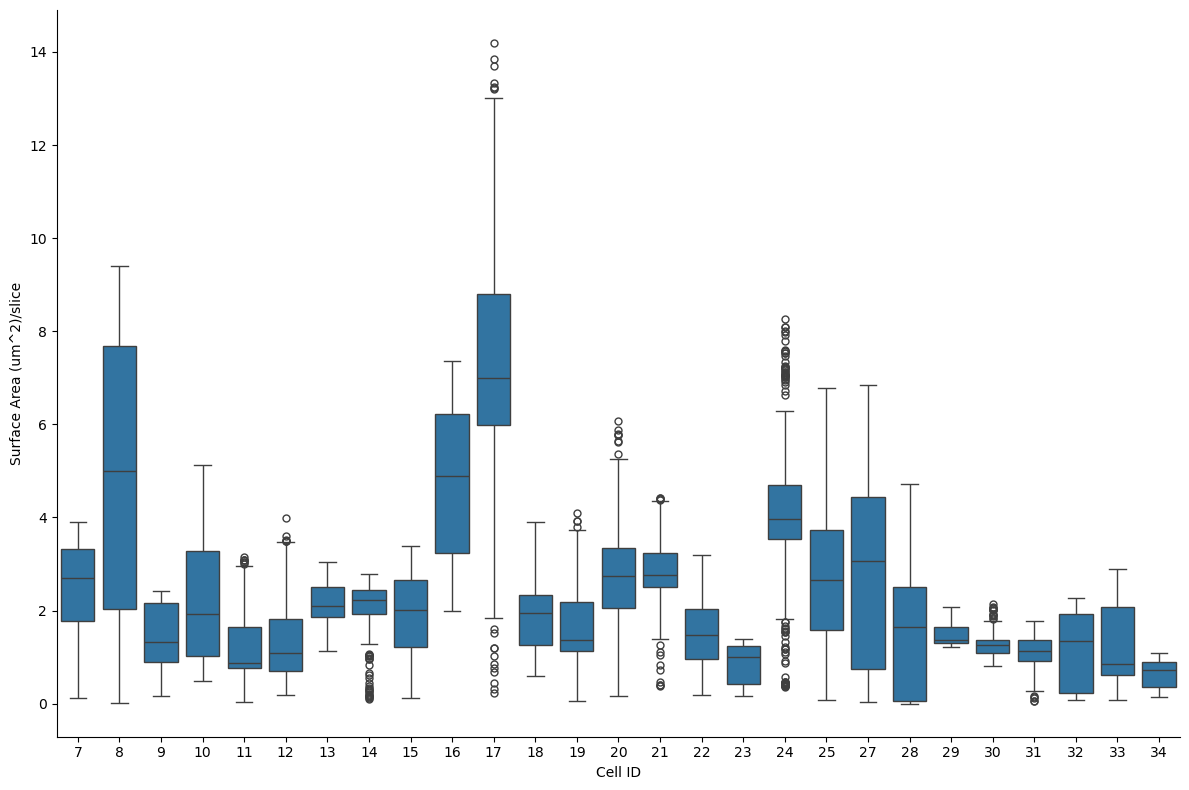

In [37]:
#visualize results - surface area (um^2) for each label on each slice
#box plot

#ECs only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='surface_area_um2', kind='box', height = 8, aspect = 1.5)


#specfiy axis labels
ax.set(xlabel='Cell ID',
       ylabel='Surface Area (um^2)/slice',
      )

#display histogram
plt.show()

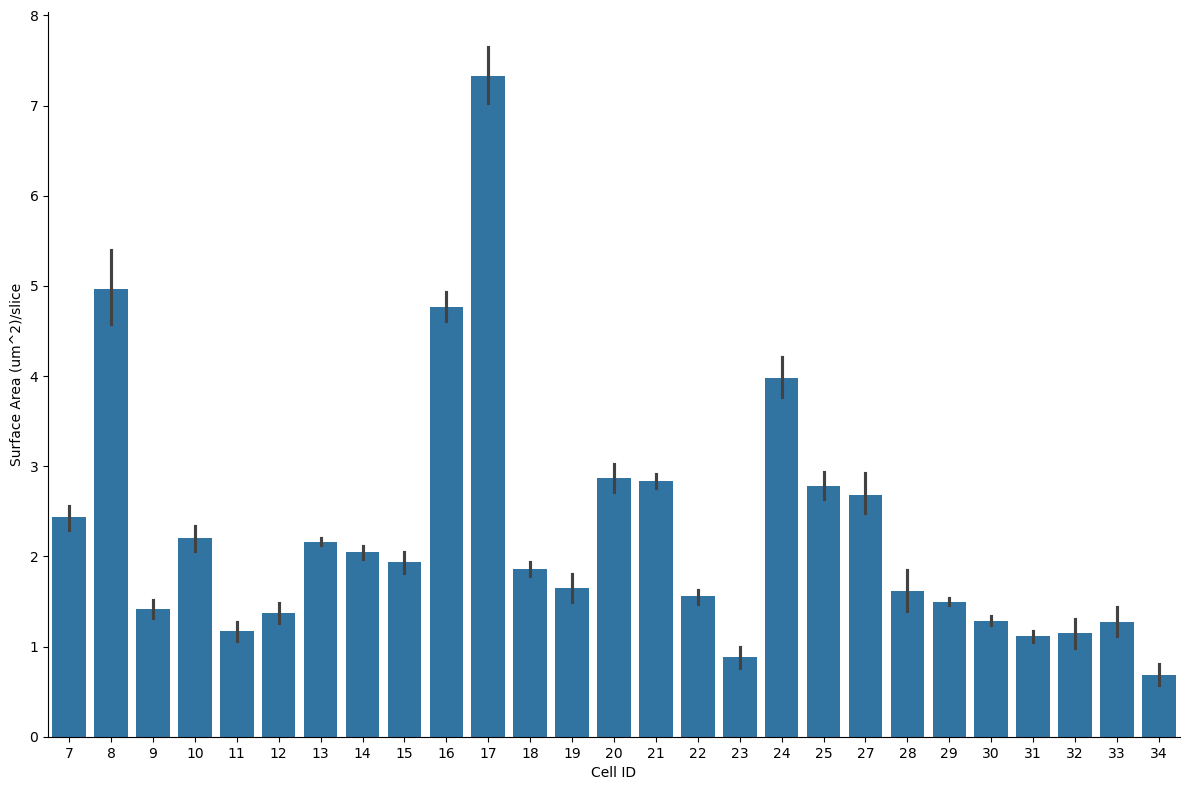

In [38]:
#visualize results - surface area (um^2) for each label on each slice
#bar chart

#ECs only
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='surface_area_um2', kind='bar', height = 8, aspect = 1.5)


#specfiy axis labels
ax.set(xlabel='Cell ID',
       ylabel='Surface Area (um^2)/slice',
      )

#display histogram
plt.show()


In [42]:
#now determine the largest diameter for each piece of cell on each slice of tissue for each cell in the dataset

#given how the indexing is done to get the largest part of each label on each slice, will need to make another for-loop
from skimage.measure import label  

#num_z_slices = annotated.shape[0]

all_dataframes_list_diameter = []

#add new columns as empty to dataframe 
all_dataframes_concat_diameter = all_dataframes_concat_diameter.reindex(columns = all_dataframes_concat_diameter.cotolist() + ['axis_major_length','axis_minor_length','feret_diameter_max','equivalent_diameter_area'])

for each_row in tqdm(range(len(all_dataframes_concat_diameter))):
    
    #set regionmask to be the current slice of annotated dataset
    regionmask = annotated[all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int)]
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(annotated[0].shape, dtype=np.uint8)
    
    #get the current label of the row
    current_label = all_dataframes_concat_diameter['label'].iloc[each_row]
    
    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1) 
    
    #get the largest connected component (CC) for the current label on the current slice
    labels = label(regionmask_current)
    
    if (labels.max() != 0):
        #assert( labels.max() != 0 ) # assume at least 1 CC
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        largestCC_label = label(largestCC)

        roi_diameter_of_largestCC_of_current_label = skimage.measure.regionprops_table(
                                                            label_image=largestCC_label, 
                                                            properties=(
                                                                'axis_major_length',
                                                                'axis_minor_length',
                                                                'feret_diameter_max',
                                                                'equivalent_diameter_area',
                                                                #'area',
                                                            ),
                                                            separator=",",
                                                            extra_properties=None,
                                                            )


    
        # use nested if/else that allows script to run, but will print out error for when the connected components results in no labels
        
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('axis_major_length')] = roi_diameter_of_largestCC_of_current_label['axis_major_length'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('axis_minor_length')] = roi_diameter_of_largestCC_of_current_label['axis_minor_length'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('feret_diameter_max')] = roi_diameter_of_largestCC_of_current_label['feret_diameter_max'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('equivalent_diameter_area')] = roi_diameter_of_largestCC_of_current_label['equivalent_diameter_area'][0]


    else:
        print("error with no label for row: ", each_row)


100%|████████████████████████████████████████████████████████████████████████████| 6506/6506 [1:29:15<00:00,  1.21it/s]


In [44]:
all_dataframes_concat_diameter.head(60)

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area
0,2,0,148.989227,240414.0,0,148,4.863575,7635.0,9.08565,313.741508,267.695947,317.416131,289.010485
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340
2,8,2,169.589450,187541.0,0,169,3.793954,5669.0,6.74611,653.449849,465.636525,895.272026,487.014252
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645,631.229849,144.609624,672.209045,222.376597
4,10,4,164.249552,45798.0,0,164,0.926494,3138.0,3.73422,736.459835,211.085617,745.413308,241.478415
5,11,5,189.508928,21561.0,0,189,0.436179,1241.0,1.47679,425.321940,123.069496,389.313498,165.687410
6,13,6,164.950678,72017.0,0,164,1.456904,2202.0,2.62038,581.762625,174.275414,765.598459,302.811645
7,14,7,162.465813,51248.0,0,162,1.036747,1903.0,2.26457,505.379560,136.707422,617.454452,254.841381
8,15,8,181.265027,113826.0,0,181,2.302700,2346.0,2.79174,477.931360,309.846798,519.399653,380.357520
9,16,9,144.104130,13704.0,0,144,0.277232,3810.0,4.53390,612.932909,109.767669,536.973929,111.017831


In [413]:
#all_dataframes_concat_diameter_feret

In [414]:
#save a version of dataframe with feret_diameter_max only 
    #since Feret diameters match up virtually perfectly with pixel-exact measurements done with line tool in FIJI
#all_dataframes_concat_diameter_feret.to_csv('df_mean-intensity-per-slice+feret_diameter.csv', index=True, header=True, sep=',')


In [935]:
#read in dataframe for visualizing 
#all_dataframes_concat_diameter_feret = pd.read_csv('df_mean-intensity-per-slice+feret_diameter.csv', index_col=0)

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
#all_dataframes_concat_diameter = pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv', index_col=0)
#all_dataframes_concat_diameter_feret

In [47]:
#covert units and save file
all_dataframes_concat_diameter['feret_diameter_max_nm'] = all_dataframes_concat_diameter['feret_diameter_max'] *17
all_dataframes_concat_diameter['feret_diameter_max_um'] = all_dataframes_concat_diameter['feret_diameter_max_nm']/1000

In [48]:
all_dataframes_concat_diameter

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
0,2,0,148.989227,240414.0,0,148,4.863575,7635.0,9.08565,313.741508,267.695947,317.416131,289.010485,5396.074221,5.396074
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790
2,8,2,169.589450,187541.0,0,169,3.793954,5669.0,6.74611,653.449849,465.636525,895.272026,487.014252,15219.624437,15.219624
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645,631.229849,144.609624,672.209045,222.376597,11427.553763,11.427554
4,10,4,164.249552,45798.0,0,164,0.926494,3138.0,3.73422,736.459835,211.085617,745.413308,241.478415,12672.026239,12.672026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,21,6501,207.316078,1642.0,341,207,0.033218,333.0,0.39627,106.844145,22.148891,107.540690,44.208853,1828.191730,1.828192
8,22,6502,192.582927,820.0,341,192,0.016589,150.0,0.17850,53.054268,21.689615,51.788030,32.311862,880.396502,0.880397
9,25,6503,184.112554,231.0,341,184,0.004673,64.0,0.07616,20.166541,14.687019,21.400935,17.149879,363.815888,0.363816
10,27,6504,140.519343,60255.0,341,140,1.218959,5229.0,6.22251,984.264948,334.987442,1074.966976,275.978108,18274.438596,18.274439


In [49]:
#save the output of mean intensity and z-slice for each EC cell label 
    # as well as major and minor length of axis. Convert this to diameter
all_dataframes_concat_diameter.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv', index=True, header=True, sep=',')
all_dataframes_concat_diameter

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
0,2,0,148.989227,240414.0,0,148,4.863575,7635.0,9.08565,313.741508,267.695947,317.416131,289.010485,5396.074221,5.396074
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790
2,8,2,169.589450,187541.0,0,169,3.793954,5669.0,6.74611,653.449849,465.636525,895.272026,487.014252,15219.624437,15.219624
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645,631.229849,144.609624,672.209045,222.376597,11427.553763,11.427554
4,10,4,164.249552,45798.0,0,164,0.926494,3138.0,3.73422,736.459835,211.085617,745.413308,241.478415,12672.026239,12.672026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,21,6501,207.316078,1642.0,341,207,0.033218,333.0,0.39627,106.844145,22.148891,107.540690,44.208853,1828.191730,1.828192
8,22,6502,192.582927,820.0,341,192,0.016589,150.0,0.17850,53.054268,21.689615,51.788030,32.311862,880.396502,0.880397
9,25,6503,184.112554,231.0,341,184,0.004673,64.0,0.07616,20.166541,14.687019,21.400935,17.149879,363.815888,0.363816
10,27,6504,140.519343,60255.0,341,140,1.218959,5229.0,6.22251,984.264948,334.987442,1074.966976,275.978108,18274.438596,18.274439


In [4]:
#below are morphometric features visualized as plots

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    

all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


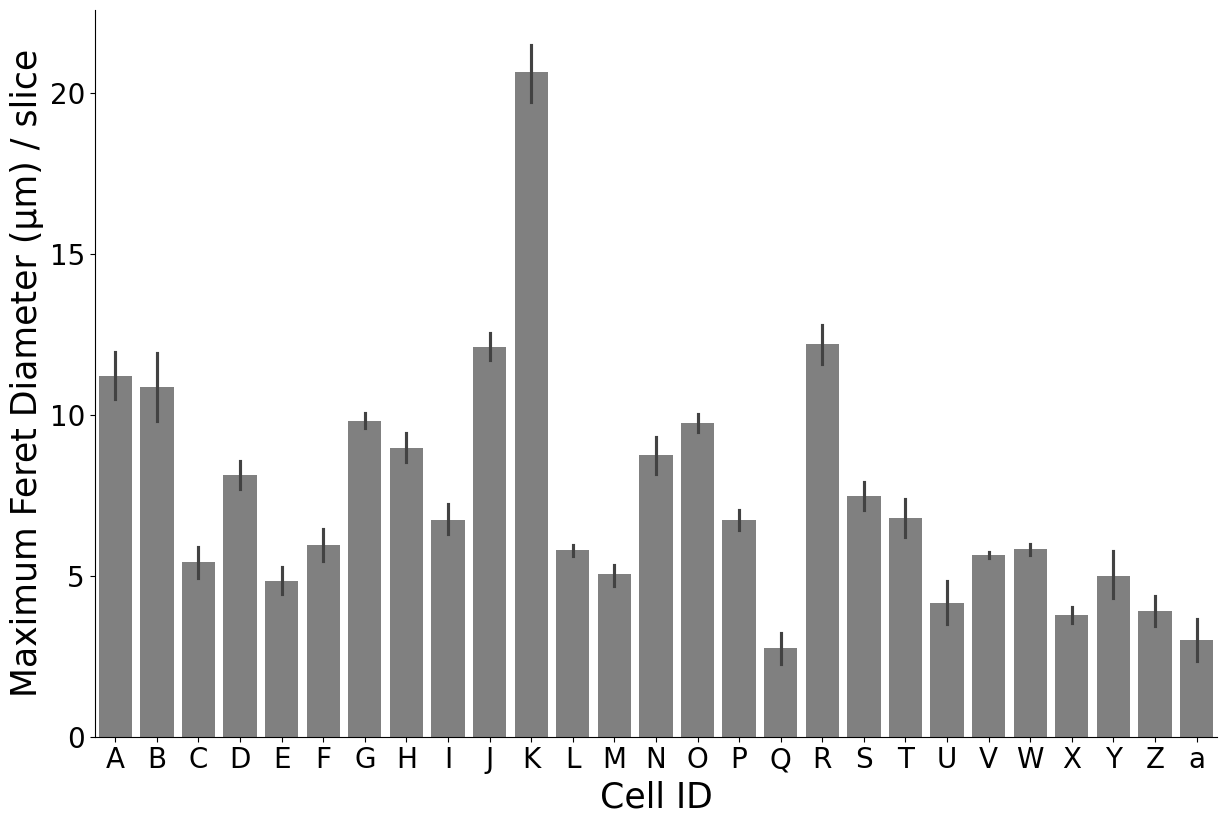

In [5]:
#visualize results

#ECs only
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um', kind='bar', height = 8, aspect = 1.5, color="gray")



plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Maximum Feret Diameter (µm) / slice',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)
all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)


plt.show()

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


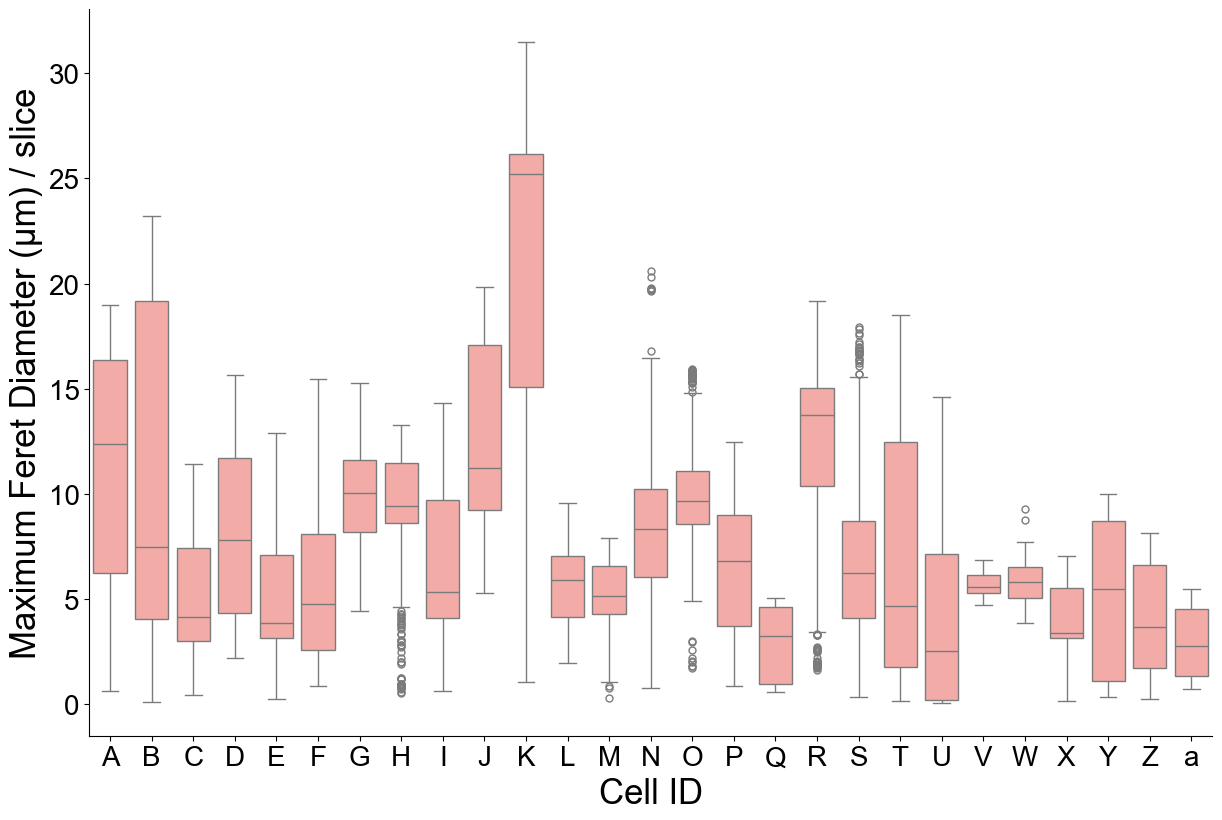

In [7]:
#visualize results

#ECs only
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um', kind='box', height = 8, aspect = 1.5, color=sns.color_palette("pastel")[3],) #pastel red


#turn off grid
#plt.grid("False")
sns.set_style("whitegrid", {'axes.grid' : False})


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Maximum Feret Diameter (µm) / slice',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("mean-diameter-slice_pastel-red.svg", format="svg", bbox_inches='tight')

#display histogram
plt.show()

In [8]:
#what is the mean diameter of the endothelial cell?

#all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um'

print("min cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].min())
print("max cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].max())
print("mean cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].mean())
print("median cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].median())
print()

min cell feret diameter:  0.0760263112349928
max cell feret diameter:  31.48298108502433
mean cell feret diameter:  8.032573283282625
median cell feret diameter:  6.726749427886629



In [9]:
min_cell_feret_cell_diameter_list = []
max_cell_feret_cell_diameter_list = []
mean_cell_feret_cell_diameter_list = []
median_cell_feret_cell_diameter_list = []
fold_difference_per_cell_list = []

for i in index_keep_ECs:
    print(i)
    current_cell_max_feret_list = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'] == i]['feret_diameter_max_um']
    
    fold_difference_per_cell = current_cell_max_feret_list.max()/current_cell_max_feret_list.min()
    
    min_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.min())
    max_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.max())
    mean_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.mean())
    median_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.median())
    fold_difference_per_cell_list.append(fold_difference_per_cell)
    
    
    print("min cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.min())
    print("max cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.max())
    print("fold difference between largest and smallest diameter of cell ", i, "is: ", fold_difference_per_cell)
    print("mean cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.mean())
    print("median cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.median())
    print()

7
min cell feret diameter of cell  7 is :  0.6324365580831013
max cell feret diameter of cell  7 is :  18.999194219755744
fold difference between largest and smallest diameter of cell  7 is:  30.04126497263505
mean cell feret diameter of cell  7 is :  11.214046553026652
median cell feret diameter of cell  7 is :  12.360928485173627

8
min cell feret diameter of cell  8 is :  0.1140394668524892
max cell feret diameter of cell  8 is :  23.224887082610326
fold difference between largest and smallest diameter of cell  8 is:  203.6565736724451
mean cell feret diameter of cell  8 is :  10.876565758250363
median cell feret diameter of cell  8 is :  7.487063107725975

9
min cell feret diameter of cell  9 is :  0.4334166586553867
max cell feret diameter of cell  9 is :  11.436793431727269
fold difference between largest and smallest diameter of cell  9 is:  26.387526190636713
mean cell feret diameter of cell  9 is :  5.416586051243942
median cell feret diameter of cell  9 is :  4.15875041328522

In [10]:
# What is the maximum fold difference of max-diameter/min-diameter for all endothelial cells in the dataset? 
print("maximum value in fold-difference across all cells: ", np.max(fold_difference_per_cell_list))
#np.mean(fold_difference_per_cell_list)
print()

#what is the mean value of the max cell diameters? (the largest diameter measured for each cell)
print(max_cell_feret_cell_diameter_list)
print()
print("mean value of max cell diameters: ", np.mean(max_cell_feret_cell_diameter_list))


maximum value in fold-difference across all cells:  203.6565736724451

[18.999194219755744, 23.224887082610326, 11.436793431727269, 15.665156398836242, 12.887928615568912, 15.456216386942828, 15.286564100542671, 13.264194849292588, 14.338912999247889, 19.86030775189549, 31.48298108502433, 9.546979627086255, 7.926668152508973, 20.60190294608729, 15.926686598285285, 12.476517623119042, 5.032976256649738, 19.154594879558275, 17.93222016371648, 18.52411144967553, 14.587119420913782, 6.869030863229543, 9.303909124663674, 7.05911566699399, 10.006590478279804, 8.133500722321232, 5.492920716704365]

mean value of max cell diameters:  14.091777096712503


In [2]:
#Visualize SUM of results
# use groupby to get sum

#only need want the SUM for volume_um3 and surface_area_um2. Do not want sum for any label for any other place

#ECs only use this line
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
 
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#reset index so can use 'label' as x-axis
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index()
sum_all_dataframes_concat_diameter.head(37)

#save calculated features converted to nm for all cells
sum_all_dataframes_concat_diameter.to_csv('sum_all_dataframes_concat_diameter_nm_all_cells.csv', index=True)
#sum_all_dataframes_concat_diameter

NameError: name 'all_dataframes_concat_diameter' is not defined

C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\838096317.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\838096317.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels_letters)


ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


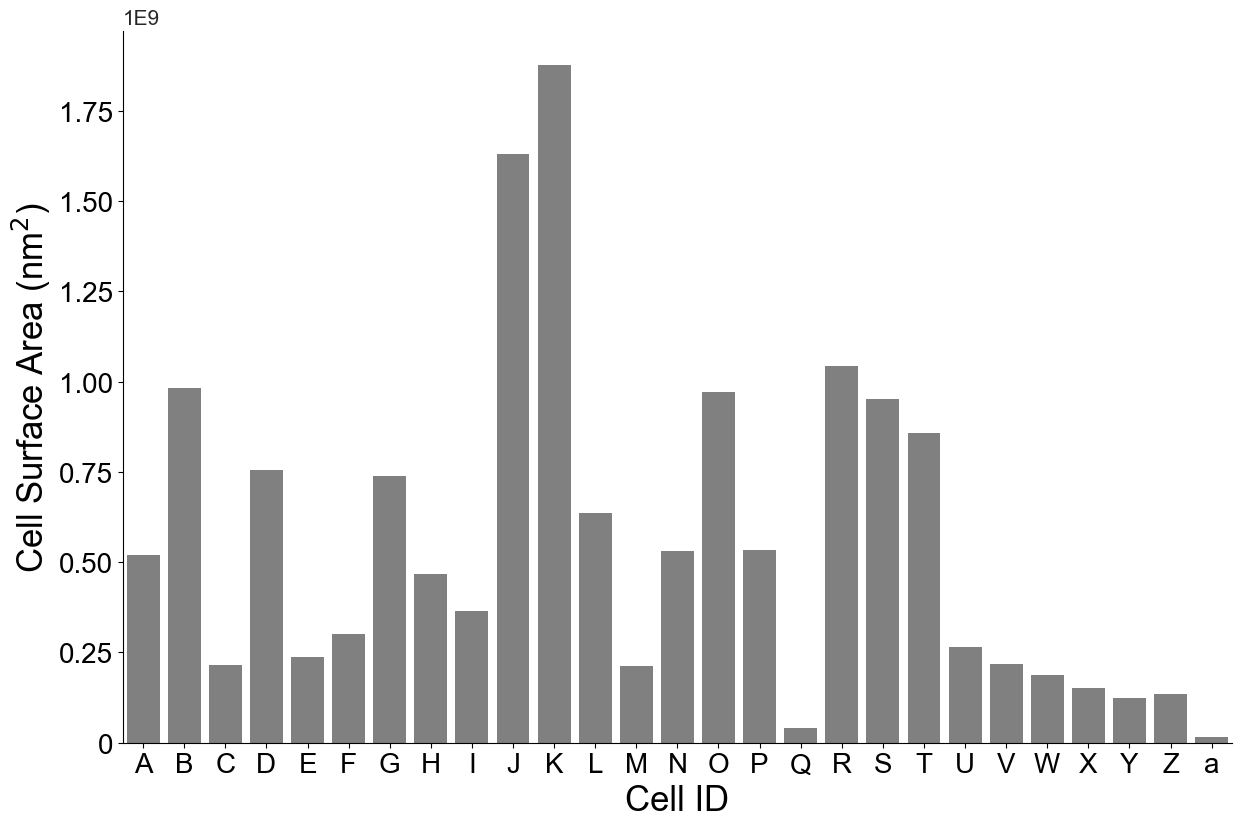

In [15]:
from matplotlib import pyplot as plt
from matplotlib import ticker

#ECs only
sum_all_dataframes_concat_diameter = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()


sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

ax = sns.catplot(data=sum_all_dataframes_concat_diameter, x='label', y='surface_area_nm2_summed_recalc', kind='bar', height = 8, aspect = 1.5, color='gray',)

#sns.set(font_scale = 1)
#sns.set()
sns.set_theme(style='white')


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Surface Area (nm$^2$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


for ax in ax.axes.flatten():
    #ax.ticklabel_format(useOffset=False, axis='y')
    #plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)


#divide each y-tick by 1e9 and get float of each y-tick to two decimals i.e. {:,.2f} 
y_ticks = ax.axes.get_yticks()
#ylabels = [( '{:,.2e}'.format(y).replace("e+0", "E+")) for y in y_ticks]
ylabels = [( '{:,.2f}'.format(y/1e9).replace("0.00", "0")) for y in y_ticks]
#ylabels = [('{:,.0f}'.format(y/1e9)) for y in ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E9",transform=ax.transAxes, fontsize=15)


#manually override the cell labels from the numbers to letters

#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)



#display histogram
plt.show()

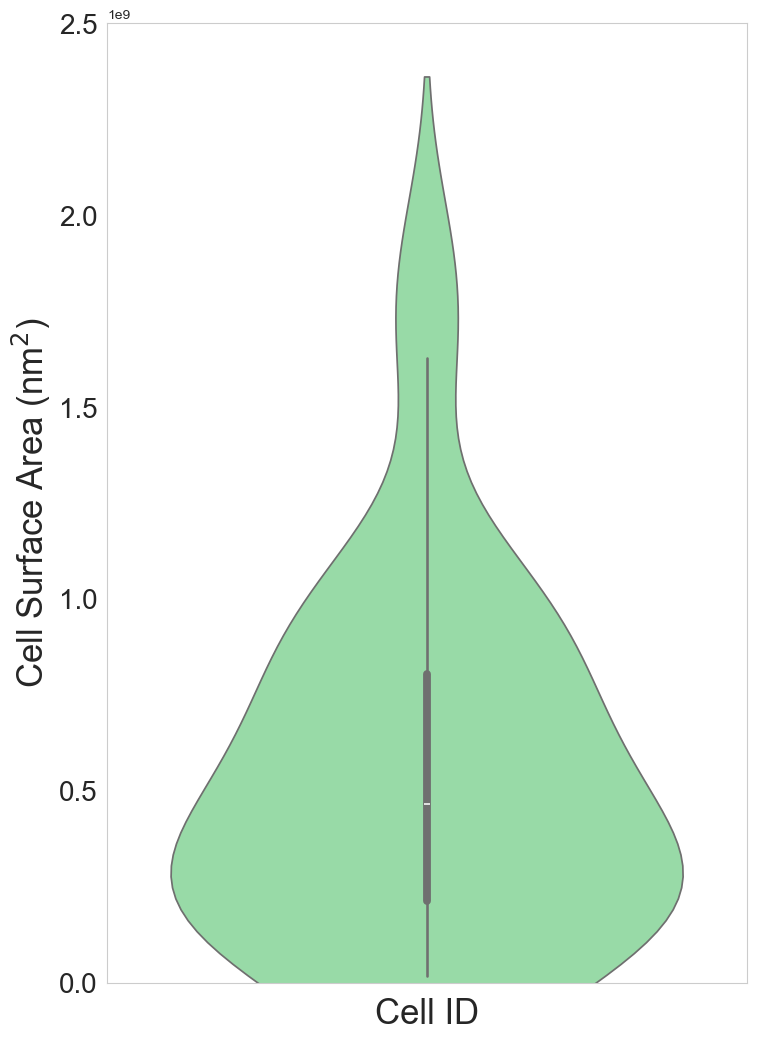

In [124]:
#visualize results - sum of nm^2 surface area as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)



#turn off grid
plt.grid(False)

#FOR ALL CELLS (commented out currently)
#sum_all_dataframes_concat_diameter = all_dataframes_concat_diameter.groupby('label').sum().copy()

#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'], color=sns.color_palette("pastel")[2], ) #pastel green


#change y-axis to log
#ax.fig.get_axes()[0].set_yscale('log')


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Surface Area (nm$^2$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("surface-area-total-nm2_pastel-green.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()

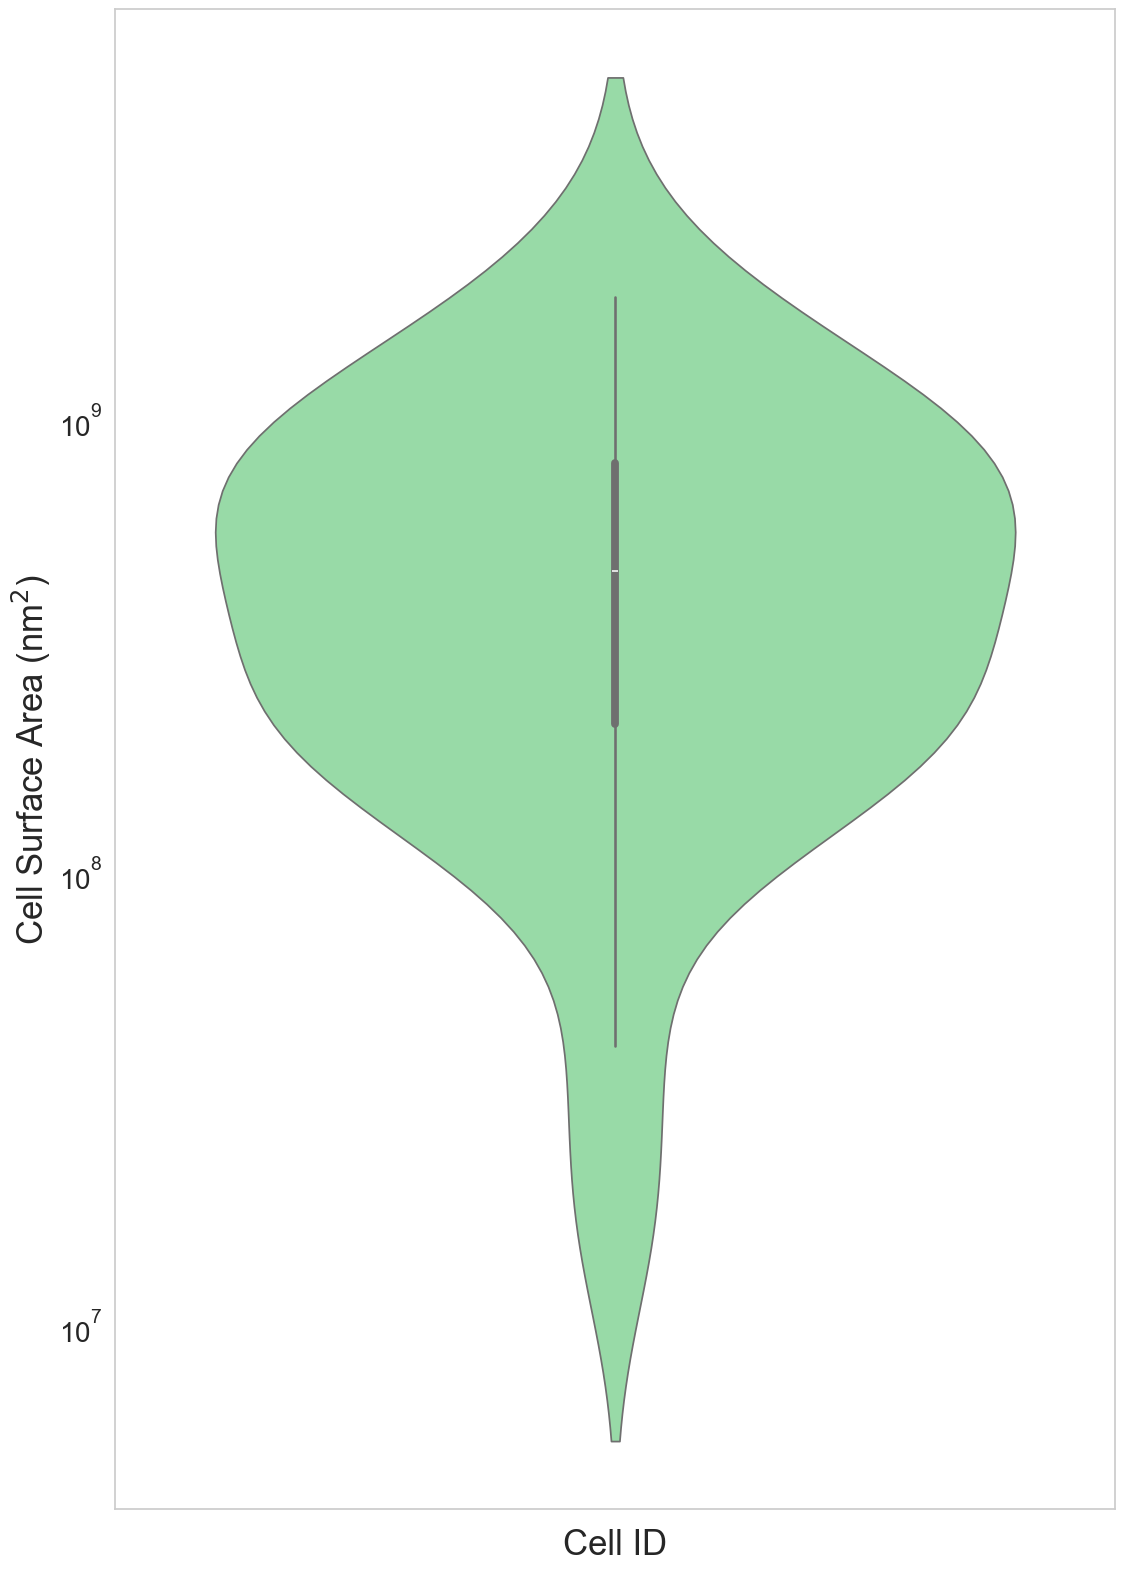

In [228]:
#visualize results - sum of nm^2 surface area as violin plot -log


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)



#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


plt.grid(False)

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(5,5))
#plt.figure(constrained_layout=True)
#plt.tight_layout()


#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'], color=sns.color_palette("pastel")[2], log_scale=10) #pastel green



plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Surface Area (nm$^2$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
#plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("surface-area-total-nm2_pastel-green_new_log.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()

In [159]:
# Feb 16 2024
# need to see if we can show that 3D value is more accurate than 2D extrapolation
    #do correlation between true surface area and projected surface area
    # need to know the number of slices for each cell and the surface area of one slice

#get a table with surface area of all cells
# get number of slices for each cell

#below are morphometric features visualized as plots

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    


#all_df_EDT_combined = pd.read_csv('df_EDT_all-cells_complete.csv', index_col=0)
all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)
all_dataframes_concat_diameter

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
0,2,0,148.989227,240414.0,0,148,4.863575,7635.0,9.08565,313.741508,267.695947,317.416131,289.010485,5396.074221,5.396074
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790
2,8,2,169.589450,187541.0,0,169,3.793954,5669.0,6.74611,653.449849,465.636525,895.272026,487.014252,15219.624437,15.219624
3,9,3,185.832617,38839.0,0,185,0.785713,1955.0,2.32645,631.229849,144.609624,672.209045,222.376597,11427.553763,11.427554
4,10,4,164.249552,45798.0,0,164,0.926494,3138.0,3.73422,736.459835,211.085617,745.413308,241.478415,12672.026239,12.672026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,21,6501,207.316078,1642.0,341,207,0.033218,333.0,0.39627,106.844145,22.148891,107.540690,44.208853,1828.191730,1.828192
8,22,6502,192.582927,820.0,341,192,0.016589,150.0,0.17850,53.054268,21.689615,51.788030,32.311862,880.396502,0.880397
9,25,6503,184.112554,231.0,341,184,0.004673,64.0,0.07616,20.166541,14.687019,21.400935,17.149879,363.815888,0.363816
10,27,6504,140.519343,60255.0,341,140,1.218959,5229.0,6.22251,984.264948,334.987442,1074.966976,275.978108,18274.438596,18.274439


In [160]:
#sort values by label first, then by z-slice
    
organized_all_cells_diameter = all_dataframes_concat_diameter.sort_values(by=['label', 'z-slice'])

#this is only for ECs (which is what we want)
organized_ECs_diameter = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].sort_values(by=['label', 'z-slice'])
organized_ECs_diameter

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790
1,7,26,190.206541,50784.0,1,190,1.027360,3229.0,3.84251,1262.018860,70.612927,1117.599660,254.283694,18999.194220,18.999194
1,7,51,194.320071,49892.0,2,194,1.009315,3156.0,3.75564,1264.763048,69.533782,1113.881951,252.040607,18935.993161,18.935993
1,7,76,188.062035,48521.0,3,188,0.981580,3139.0,3.73541,1251.602515,67.446120,1112.845452,248.553527,18918.372684,18.918373
1,7,101,192.751786,48708.0,4,192,0.985363,3151.0,3.74969,1250.010815,68.870110,1113.348553,249.032030,18926.925397,18.926925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,34,523,180.038225,1465.0,20,180,0.029637,256.0,0.30464,68.801401,24.733157,69.354164,40.480357,1179.020780,1.179021
23,34,548,191.796610,1239.0,21,191,0.025065,259.0,0.30821,61.583031,23.182931,63.529521,36.319088,1080.001852,1.080002
24,34,574,189.343284,1139.0,22,189,0.023042,261.0,0.31059,58.567129,20.893099,56.938563,33.454111,967.955577,0.967956
24,34,600,168.103966,933.0,23,168,0.018875,228.0,0.27132,54.242593,18.413536,51.312766,30.860706,872.317030,0.872317


In [161]:
#determine number of z-slices for each cell label

#this is only for ECs (which is what we want)
num_slices_per_cell_morpho = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').count()
num_slices_per_cell_morpho

,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um
label,,,,,,,,,,,,,,
7,214,214,214,214,214,214,214,214,214,214,214,214,214,214
8,198,198,198,198,198,198,198,198,198,198,198,198,198,198
9,151,151,151,151,151,151,151,151,151,151,151,151,151,151
10,342,342,342,342,342,342,342,342,342,342,342,342,342,342
11,202,202,202,202,202,202,202,202,202,202,202,202,202,202
12,220,220,220,220,220,220,220,220,220,220,220,220,220,220
13,342,342,342,342,342,342,342,342,342,342,342,342,342,342
14,228,228,228,228,228,228,228,228,228,228,228,228,228,228
15,189,189,189,189,189,189,189,189,189,189,189,189,189,189


In [162]:
#get since the values are the same for all columns, just get the label and number of slices
label_and_num_slices = num_slices_per_cell_morpho.iloc[:, 0:1].reset_index().copy()
label_and_num_slices

,label,index_manual
0,7,214
1,8,198
2,9,151
3,10,342
4,11,202
5,12,220
6,13,342
7,14,228
8,15,189
9,16,342


In [164]:
#create new dataframe that has the number of slices for the respective columns based on the label

organized_ECs_diameter_projected = organized_ECs_diameter.copy()
organized_ECs_diameter_projected['num_slices_per_label'] = organized_ECs_diameter_projected['label'].map(label_and_num_slices.set_index('label')['index_manual'])

In [165]:
organized_ECs_diameter_projected

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um,num_slices_per_label
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790,214
1,7,26,190.206541,50784.0,1,190,1.027360,3229.0,3.84251,1262.018860,70.612927,1117.599660,254.283694,18999.194220,18.999194,214
1,7,51,194.320071,49892.0,2,194,1.009315,3156.0,3.75564,1264.763048,69.533782,1113.881951,252.040607,18935.993161,18.935993,214
1,7,76,188.062035,48521.0,3,188,0.981580,3139.0,3.73541,1251.602515,67.446120,1112.845452,248.553527,18918.372684,18.918373,214
1,7,101,192.751786,48708.0,4,192,0.985363,3151.0,3.74969,1250.010815,68.870110,1113.348553,249.032030,18926.925397,18.926925,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,34,523,180.038225,1465.0,20,180,0.029637,256.0,0.30464,68.801401,24.733157,69.354164,40.480357,1179.020780,1.179021,25
23,34,548,191.796610,1239.0,21,191,0.025065,259.0,0.30821,61.583031,23.182931,63.529521,36.319088,1080.001852,1.080002,25
24,34,574,189.343284,1139.0,22,189,0.023042,261.0,0.31059,58.567129,20.893099,56.938563,33.454111,967.955577,0.967956,25
24,34,600,168.103966,933.0,23,168,0.018875,228.0,0.27132,54.242593,18.413536,51.312766,30.860706,872.317030,0.872317,25


In [166]:
#create new column to get the projected surface area based on the surface area of the slice and number of slices
organized_ECs_diameter_projected['projected_total_surface_area_nm2'] = organized_ECs_diameter_projected['surface_area'] * (17*70) * organized_ECs_diameter_projected['num_slices_per_label']
organized_ECs_diameter_projected['projected_total_volume_nm3'] = organized_ECs_diameter_projected['area'] * (17*17*70) * organized_ECs_diameter_projected['num_slices_per_label']
organized_ECs_diameter_projected


,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um,num_slices_per_label,projected_total_surface_area_nm2,projected_total_volume_nm3
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790,214,832992860.0,2.107767e+11
1,7,26,190.206541,50784.0,1,190,1.027360,3229.0,3.84251,1262.018860,70.612927,1117.599660,254.283694,18999.194220,18.999194,214,822297140.0,2.198551e+11
1,7,51,194.320071,49892.0,2,194,1.009315,3156.0,3.75564,1264.763048,69.533782,1113.881951,252.040607,18935.993161,18.935993,214,803706960.0,2.159934e+11
1,7,76,188.062035,48521.0,3,188,0.981580,3139.0,3.73541,1251.602515,67.446120,1112.845452,248.553527,18918.372684,18.918373,214,799377740.0,2.100581e+11
1,7,101,192.751786,48708.0,4,192,0.985363,3151.0,3.74969,1250.010815,68.870110,1113.348553,249.032030,18926.925397,18.926925,214,802433660.0,2.108676e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,34,523,180.038225,1465.0,20,180,0.029637,256.0,0.30464,68.801401,24.733157,69.354164,40.480357,1179.020780,1.179021,25,7616000.0,7.409238e+08
23,34,548,191.796610,1239.0,21,191,0.025065,259.0,0.30821,61.583031,23.182931,63.529521,36.319088,1080.001852,1.080002,25,7705250.0,6.266242e+08
24,34,574,189.343284,1139.0,22,189,0.023042,261.0,0.31059,58.567129,20.893099,56.938563,33.454111,967.955577,0.967956,25,7764750.0,5.760492e+08
24,34,600,168.103966,933.0,23,168,0.018875,228.0,0.27132,54.242593,18.413536,51.312766,30.860706,872.317030,0.872317,25,6783000.0,4.718648e+08


In [168]:
#get the true total Surface area and volume in nm2 and nm3
#ECs only
sum_all_dataframes_concat_diameter =organized_ECs_diameter_projected[organized_ECs_diameter_projected['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE line being either 'FOR ALL CELLS' or 'ECs only'
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']
sum_all_dataframes_concat_diameter

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,...,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um,num_slices_per_label,projected_total_surface_area_nm2,projected_total_volume_nm3,surface_area_nm2_summed_recalc,volume_nm3_summed_recalc,nm_SA_vol_ratio
0,7,538446,41482.138321,6527830.0,22791,41377,132.058001,437635.0,520.78565,153720.958750,...,141165.056609,40149.939213,2.399806e+06,2399.805962,45796,1.114481e+11,2.826041e+13,5.207856e+08,1.320580e+11,0.003944
1,8,465030,36745.082544,19699970.0,19503,36649,398.530393,825481.0,982.32239,115235.036200,...,126680.001184,55157.506559,2.153560e+06,2153.560020,39204,1.944998e+11,7.890902e+13,9.823224e+08,3.985304e+11,0.002465
2,9,276818,28407.558744,3226837.0,11325,28338,65.278913,180218.0,214.45942,45634.671184,...,48112.029043,23101.368385,8.179045e+05,817.904494,22801,3.238337e+10,9.857116e+12,2.144594e+08,6.527891e+10,0.003285
3,10,1265799,58879.119803,19696114.0,58311,58701,398.452386,633957.0,754.40883,143059.868133,...,163605.746745,86071.429862,2.781298e+06,2781.297695,116964,2.580078e+11,1.362707e+14,7.544088e+08,3.984524e+11,0.001893
4,11,483573,39594.581839,3385740.0,20301,39494,68.493520,199282.0,237.14558,59003.935107,...,57658.069726,27495.684017,9.801872e+05,980.187185,40804,4.790341e+10,1.383569e+13,2.371456e+08,6.849352e+10,0.003462
5,12,1083792,31223.802546,4336156.0,50930,31118,87.720436,254130.0,302.41470,64767.923796,...,77272.681345,29911.047471,1.313636e+06,1313.635583,48400,6.653123e+10,1.929850e+13,3.024147e+08,8.772044e+10,0.003447
6,13,1266563,61236.486345,19586173.0,58311,61064,396.228280,621671.0,739.78849,189806.654890,...,197721.933968,88001.754724,3.361273e+06,3361.272877,116964,2.530077e+11,1.355101e+14,7.397885e+08,3.962283e+11,0.001867
7,14,607778,41512.642640,8009585.0,25878,41389,162.033905,391652.0,466.06588,112468.172879,...,120367.915155,45218.226638,2.046255e+06,2046.254558,51984,1.062630e+11,3.694373e+13,4.660659e+08,1.620339e+11,0.002876
8,15,426809,35908.733506,11171341.0,17766,35824,225.996228,307495.0,365.91905,68886.445326,...,75037.837033,47028.353414,1.275643e+06,1275.643230,35721,6.915870e+10,4.271329e+13,3.659190e+08,2.259962e+11,0.001619
9,16,1267322,53032.437916,24204353.0,58311,52860,489.654061,1369158.0,1629.29802,227008.150344,...,243683.515504,95634.471148,4.142620e+06,4142.619764,116964,5.572199e+11,1.674617e+14,1.629298e+09,4.896541e+11,0.003327


In [169]:
#now map the true surface area and volume as a column where the labels are equal, follow same approach as above

organized_ECs_diameter_projected['true_total_SA_nm2'] = organized_ECs_diameter_projected['label'].map(sum_all_dataframes_concat_diameter.set_index('label')['surface_area_nm2_summed_recalc'])
organized_ECs_diameter_projected['true_total_vol_nm3'] = organized_ECs_diameter_projected['label'].map(sum_all_dataframes_concat_diameter.set_index('label')['volume_nm3_summed_recalc'])
organized_ECs_diameter_projected

,label,index_manual,mean_intensity,area,z-slice,intensity,volume_um3,surface_area,surface_area_um2,axis_major_length,axis_minor_length,feret_diameter_max,equivalent_diameter_area,feret_diameter_max_nm,feret_diameter_max_um,num_slices_per_label,projected_total_surface_area_nm2,projected_total_volume_nm3,true_total_SA_nm2,true_total_vol_nm3
1,7,1,189.024586,48687.0,0,189,0.984938,3271.0,3.89249,1275.947337,68.773128,1116.281774,248.978340,18976.790166,18.976790,214,832992860.0,2.107767e+11,520785650.0,1.320580e+11
1,7,26,190.206541,50784.0,1,190,1.027360,3229.0,3.84251,1262.018860,70.612927,1117.599660,254.283694,18999.194220,18.999194,214,822297140.0,2.198551e+11,520785650.0,1.320580e+11
1,7,51,194.320071,49892.0,2,194,1.009315,3156.0,3.75564,1264.763048,69.533782,1113.881951,252.040607,18935.993161,18.935993,214,803706960.0,2.159934e+11,520785650.0,1.320580e+11
1,7,76,188.062035,48521.0,3,188,0.981580,3139.0,3.73541,1251.602515,67.446120,1112.845452,248.553527,18918.372684,18.918373,214,799377740.0,2.100581e+11,520785650.0,1.320580e+11
1,7,101,192.751786,48708.0,4,192,0.985363,3151.0,3.74969,1250.010815,68.870110,1113.348553,249.032030,18926.925397,18.926925,214,802433660.0,2.108676e+11,520785650.0,1.320580e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,34,523,180.038225,1465.0,20,180,0.029637,256.0,0.30464,68.801401,24.733157,69.354164,40.480357,1179.020780,1.179021,25,7616000.0,7.409238e+08,17033660.0,1.860472e+09
23,34,548,191.796610,1239.0,21,191,0.025065,259.0,0.30821,61.583031,23.182931,63.529521,36.319088,1080.001852,1.080002,25,7705250.0,6.266242e+08,17033660.0,1.860472e+09
24,34,574,189.343284,1139.0,22,189,0.023042,261.0,0.31059,58.567129,20.893099,56.938563,33.454111,967.955577,0.967956,25,7764750.0,5.760492e+08,17033660.0,1.860472e+09
24,34,600,168.103966,933.0,23,168,0.018875,228.0,0.27132,54.242593,18.413536,51.312766,30.860706,872.317030,0.872317,25,6783000.0,4.718648e+08,17033660.0,1.860472e+09


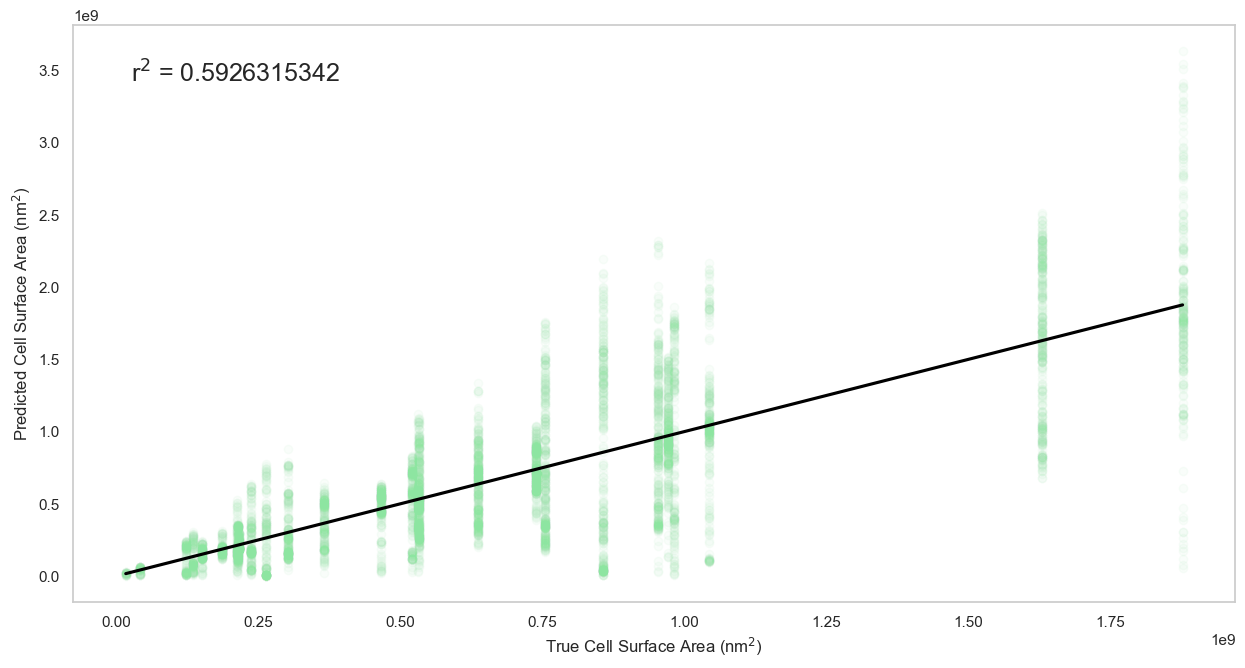

In [173]:
#plot true vs. predicted values as scatterplot and get correlation 
#for volume (nm^3)

plt.figure() #this creates a new figure on which your plot will appear
ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_SA_nm2", y="projected_total_surface_area_nm2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
plt.grid(False)

organized_ECs_diameter_projected  = organized_ECs_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_ECs_diameter_projected['true_total_SA_nm2'], y=organized_ECs_diameter_projected['projected_total_surface_area_nm2'])
r, p = scipy.stats.spearmanr(a=organized_ECs_diameter_projected['true_total_SA_nm2'], b=organized_ECs_diameter_projected['projected_total_surface_area_nm2'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_r2 = "r$^2$ = "+str(round(r**2, 10))

ax.text(0.05, 0.9, text_r2,transform=ax.transAxes, size=18)
ax.set(xlabel='True Cell Surface Area (nm$^2$)', ylabel='Predicted Cell Surface Area (nm$^2$)')

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_SA.svg", format="svg", bbox_inches='tight')

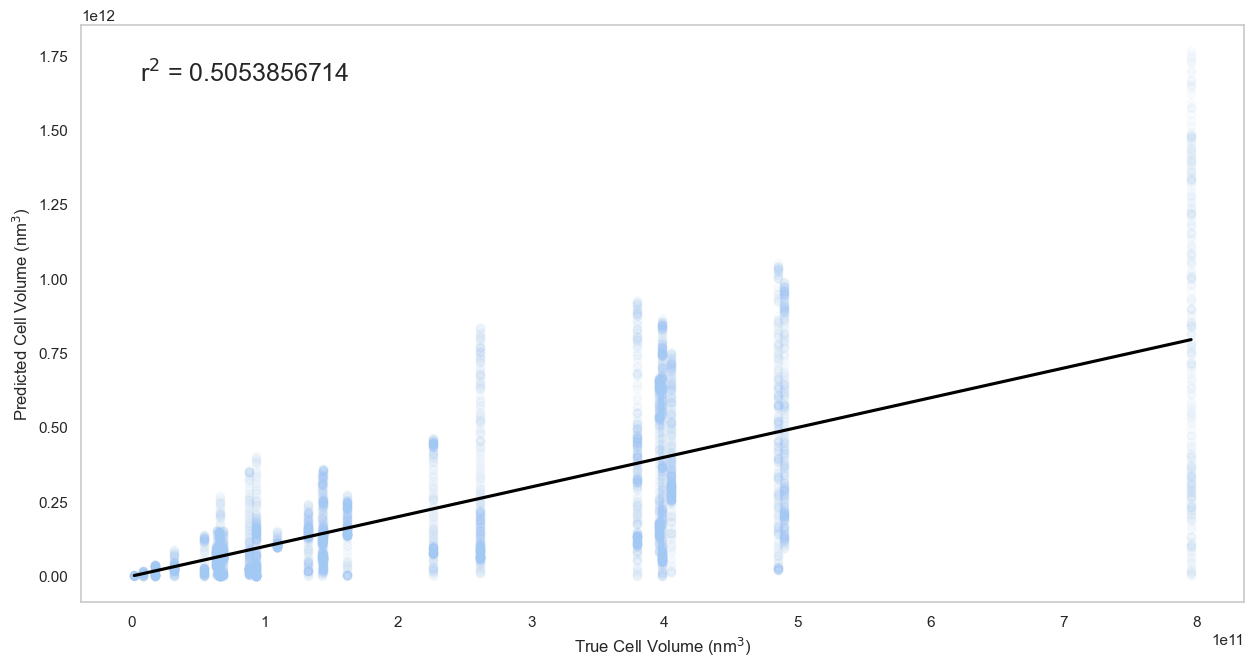

In [175]:
#plot true vs. predicted values as scatterplot and get correlation 
#for surface area (nm^2)

plt.figure() #this creates a new figure on which your plot will appear

ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_vol_nm3", y="projected_total_volume_nm3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)


organized_ECs_diameter_projected  = organized_ECs_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_ECs_diameter_projected['true_total_vol_nm3'], y=organized_ECs_diameter_projected['projected_total_volume_nm3'])
r, p = scipy.stats.spearmanr(a=organized_ECs_diameter_projected['true_total_vol_nm3'], b=organized_ECs_diameter_projected['projected_total_volume_nm3'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_r2 = "r$^2$ = "+str(round(r**2, 10))


ax.text(0.05, 0.9, text_r2,transform=ax.transAxes, size=18)
ax.set(xlabel='True Cell Volume (nm$^3$)', ylabel='Predicted Cell Volume (nm$^3$)')
#ax.legend()

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_vol.svg", format="svg", bbox_inches='tight')

In [18]:
sns.color_palette("pastel")[0] #blue
sns.color_palette("pastel")[1] #orange
sns.color_palette("pastel")[2] #green
sns.color_palette("pastel")[3] #red

(1.0, 0.6235294117647059, 0.6078431372549019)

C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\3937799781.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\3937799781.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels_letters)


ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


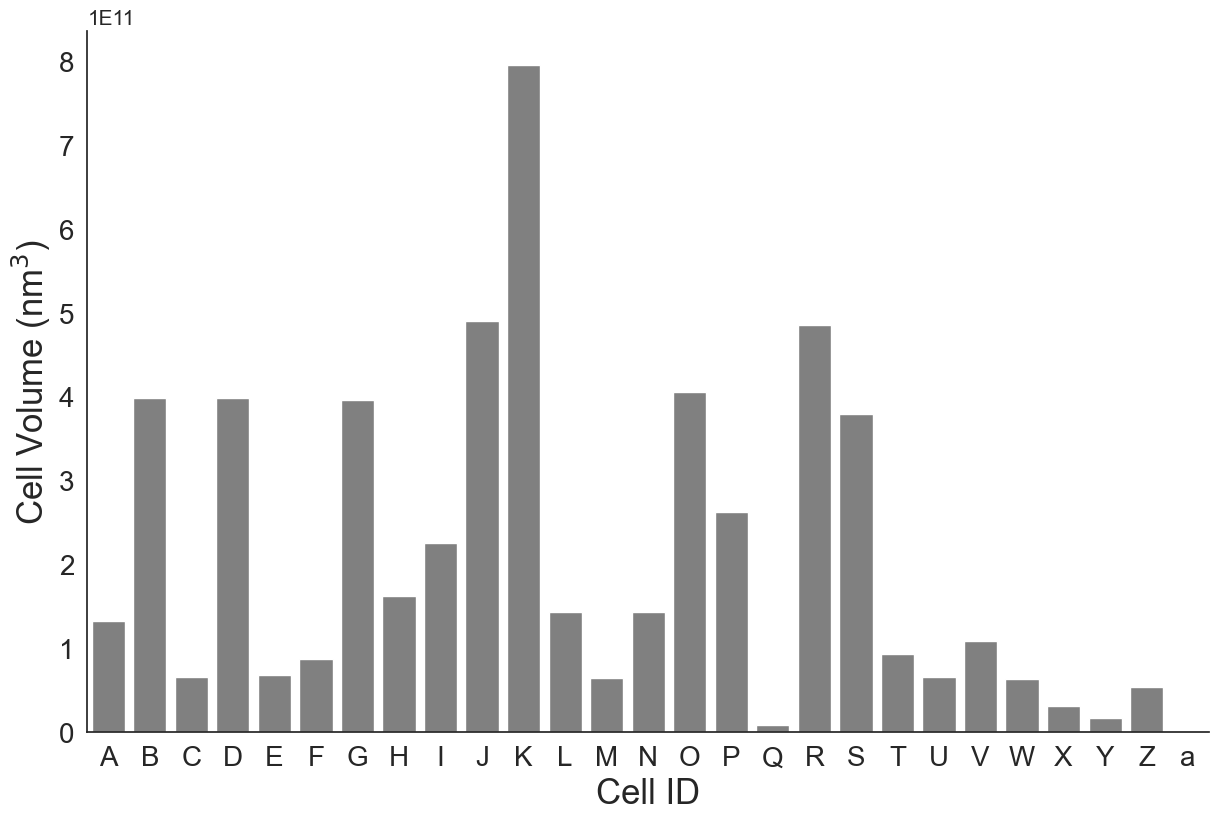

In [20]:
#visualize results - sum of nm^3 volume



#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE line being either 'FOR ALL CELLS' or 'ECs only'
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

ax = sns.catplot(data=sum_all_dataframes_concat_diameter, x='label', y='volume_nm3_summed_recalc', kind='bar', height = 8, aspect = 1.5, color='gray')



plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Volume (nm$^3$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#Cannot change size of exponent at the top of the chart
#Solution: get rid of exponent, then divide each number by exponent value
    #lastly, manually add in the y-axis label at the top left of the figure

for ax in ax.axes.flatten():
    #ax.ticklabel_format(useOffset=False, axis='y')
    #plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)


#divide each y-tick by 1e11 and get float of each y-tick to two decimals i.e. {:,.2f}. Remove the .00 (could just do 0 decimal as well) 
y_ticks = ax.axes.get_yticks()
ylabels = [( '{:,.2f}'.format(y/1e11).replace(".00", "")) for y in y_ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E11",transform=ax.transAxes, fontsize=15)


#manually override the cell labels from the numbers to letters

#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)

#display histogram
plt.show()


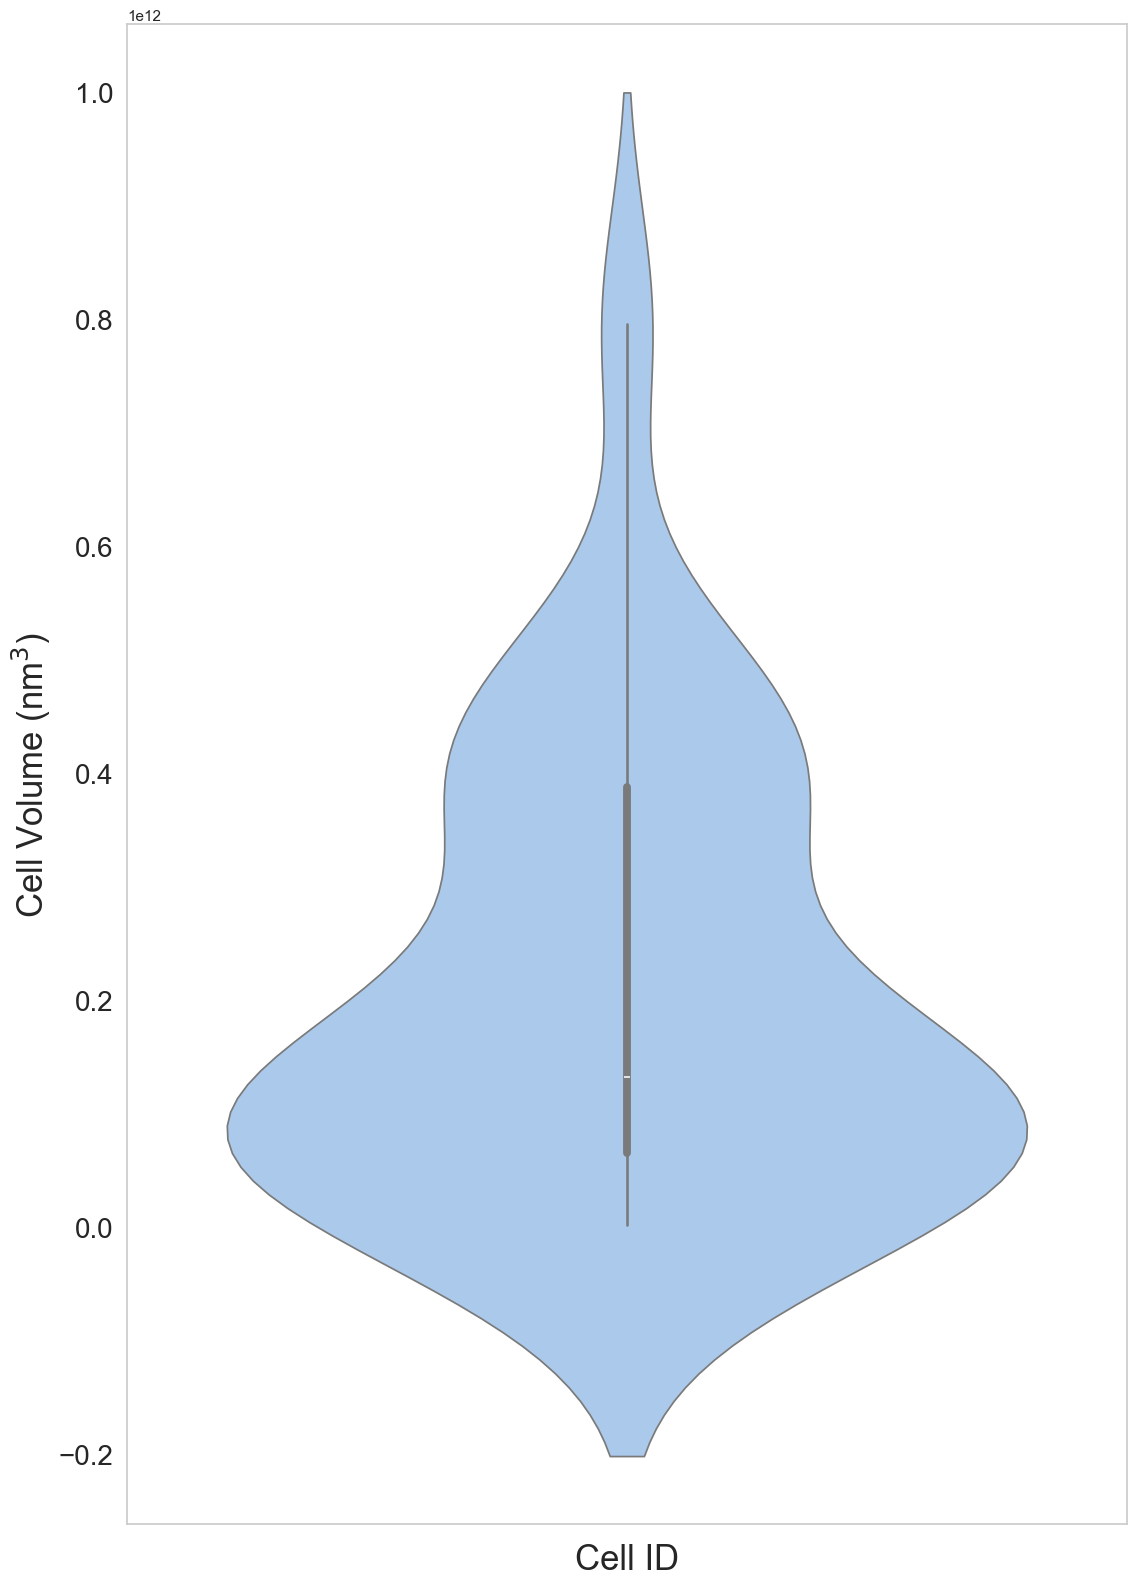

In [224]:
#visualize results - sum of nm^3 volume as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)

#turn off grid


plt.grid(False)


#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#add cut =0 to only keep values above 0
ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'], color=sns.color_palette("pastel")[0]) #pastel blue


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Volume (nm$^3$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("volume-total-nm3_pastel-blue.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

In [ ]:
#are there any values that are less than 0? plot goes below 0 because violin plot uses KDE
np.any(sum_all_dataframes_concat_diameter < 0)
#npsum_all_dataframes_concat_diameter
#answer is false, there are no values less than 0

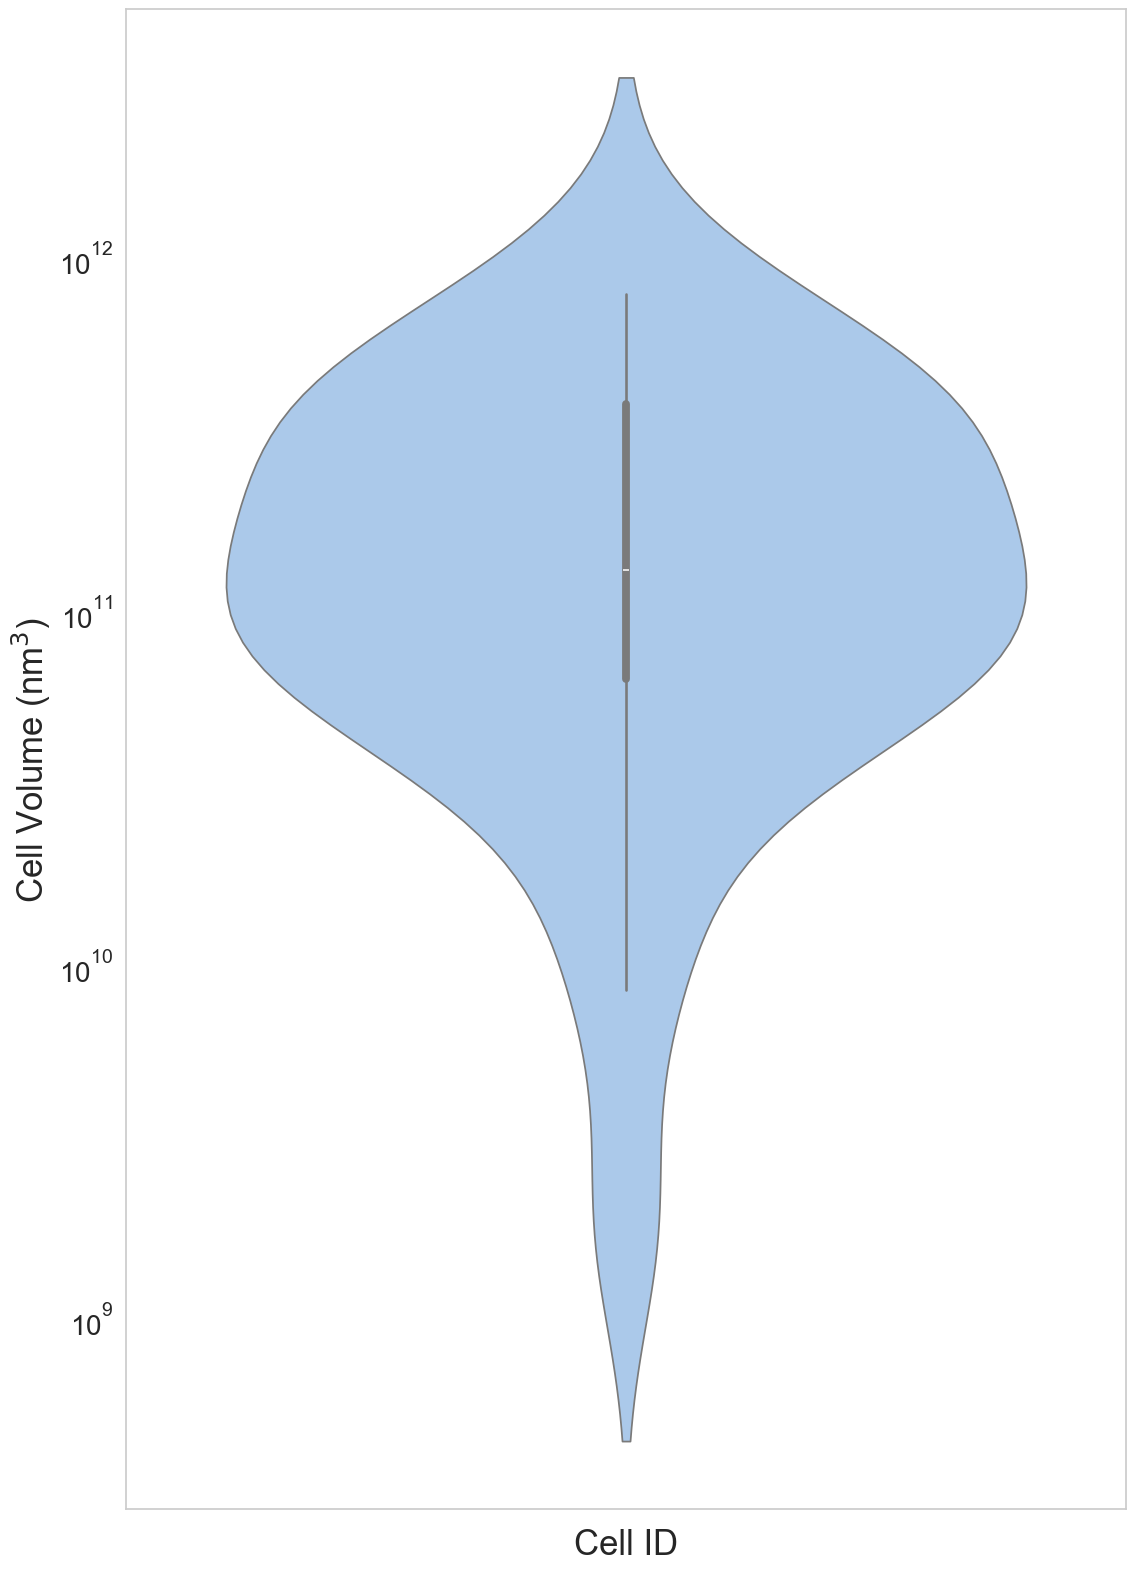

In [227]:
#visualize results - sum of nm^3 volume as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)

plt.grid(False)

#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#add cut =0 to only keep values above 0 
ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'], color=sns.color_palette("pastel")[0], log_scale=10) #pastel blue

plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Cell Volume (nm$^3$)',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#set y-minimum value so that it does not go below zero
#plt.ylim(0)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("volume-total-nm3_pastel-blue_log.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()




C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\3963107152.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\3963107152.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels_letters)


ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


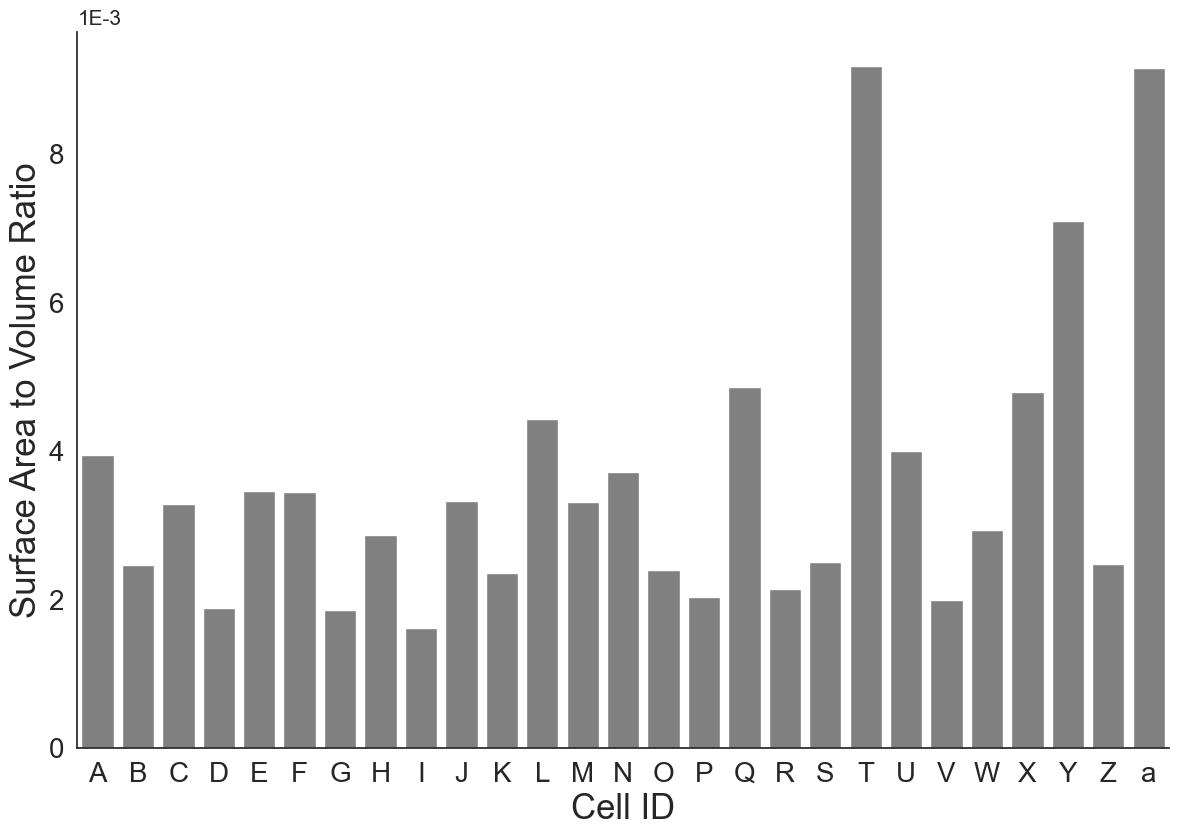

In [23]:
#visualize results - sum of SA (nm^2):VOLUME (nm^3) RATIO volume


#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

ax = sns.catplot(data=sum_all_dataframes_concat_diameter, x='label', y='nm_SA_vol_ratio', kind='bar', height = 8, aspect = 1.5, color='gray')


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Surface Area to Volume Ratio',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


for ax in ax.axes.flatten():
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
y_ticks = ax.axes.get_yticks()
ylabels = [( '{:,.0e}'.format(y).replace("e-03","")).replace("e+00","") for y in y_ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E-3",transform=ax.transAxes, fontsize=15)


#manually override the cell labels from the numbers to letters

#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)


#display histogram
plt.show()


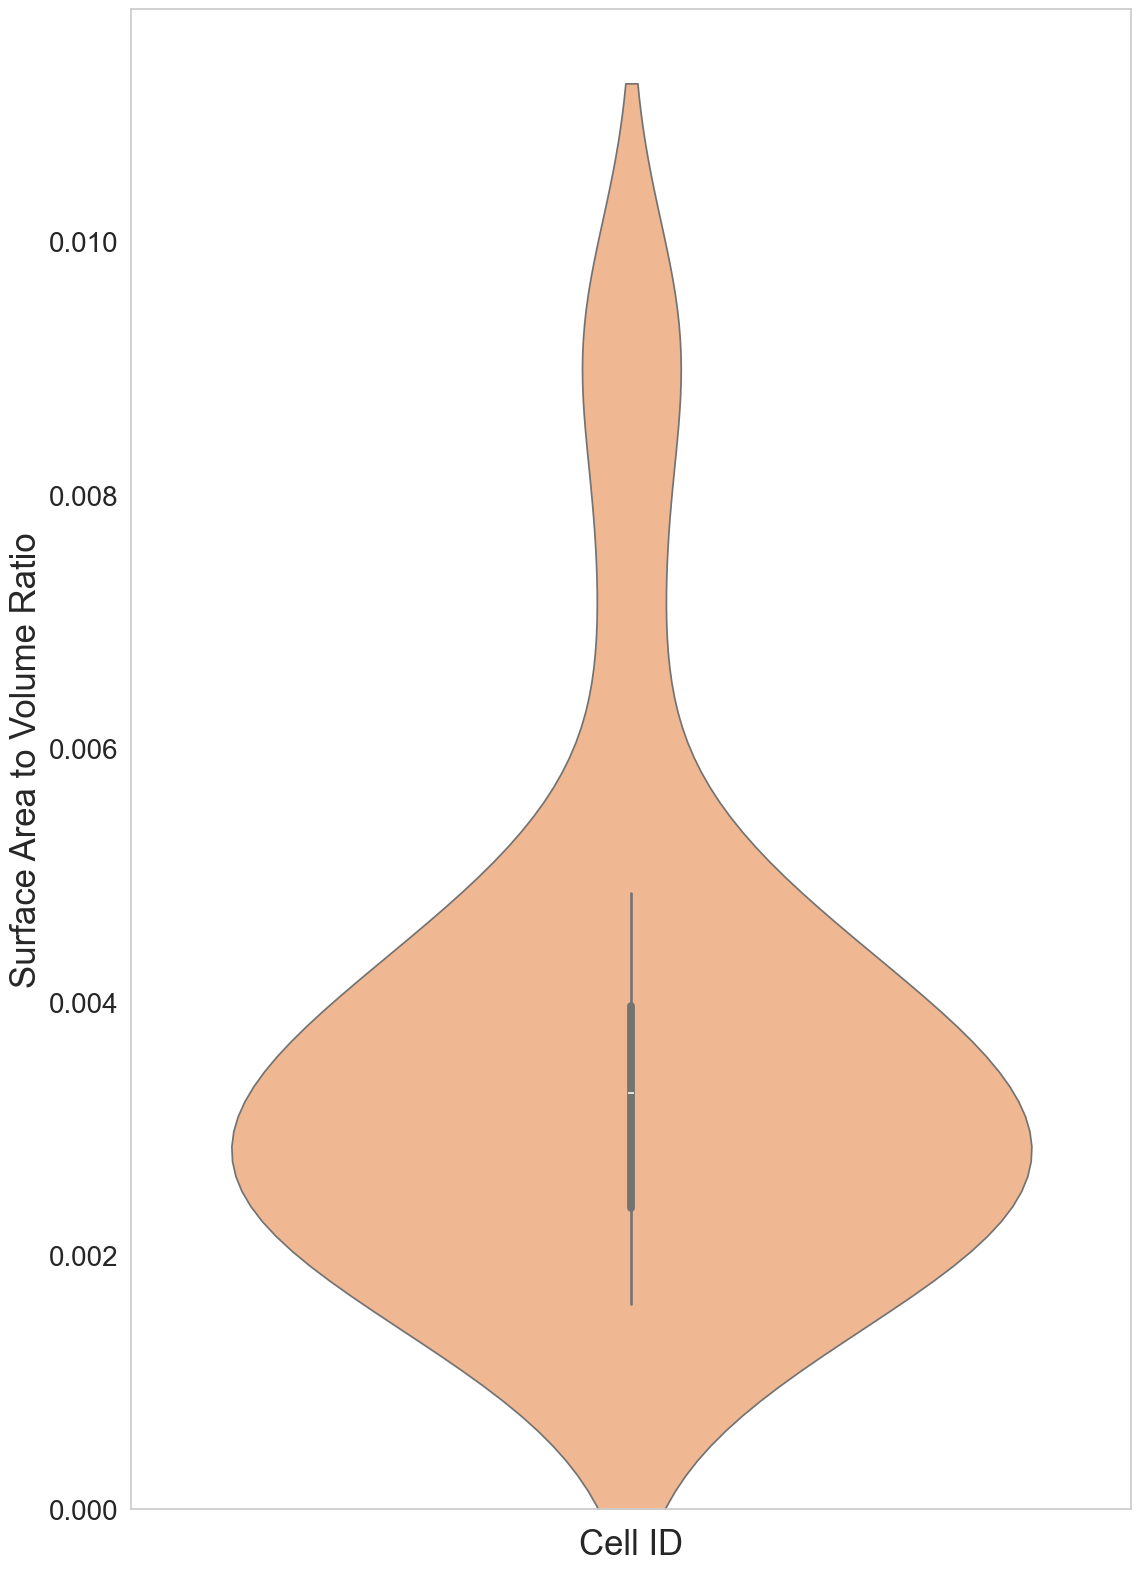

In [60]:
#visualize results - sum of SA (nm^2):VOLUME (nm^3) RATIO volume as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)


plt.grid(False)



#ECs only
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0
ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'], color=sns.color_palette("pastel")[1],) #pastel orange



plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Surface Area to Volume Ratio',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("SA-volume-ratio-nm_pastel-orange.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

In [ ]:
#Now remove bad slices

In [105]:
all_df_EDT_combined = pd.read_csv('df_EDT_all-cells_complete.csv', index_col=0)
all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)


#remove slices with bands and black artifacts deposits/damage/warping/cropping: 6, 11, 18,  32, 48, 54, 83, 145, 227,228, 263, 305,311

remove_slices_list = [6, 11, 18,  32, 48, 54, 83, 102, 145, 227, 228, 263, 305, 311]

#make a copy of the dataframe to be cleaned
#need to reset index too, or else doesn't work for the diameter/morphometric file

all_df_EDT_combined_no_bad_slices = all_df_EDT_combined.copy()
#all_df_EDT_combined_no_bad_slices = all_df_EDT_combined.reset_index().copy()

#all_dataframes_concat_diameter_no_bad_slices = all_dataframes_concat_diameter.copy()
all_dataframes_concat_diameter_no_bad_slices = all_dataframes_concat_diameter.reset_index().copy()



for each_bad_slice in remove_slices_list:
    print(each_bad_slice)
    #make a short-name for the variable for ease of understanding
    cleaned_dataframe_edt = all_df_EDT_combined_no_bad_slices
    cleaned_dataframe = all_dataframes_concat_diameter_no_bad_slices
    
    
    #clean the dataframe by removing the bad slices
    all_df_EDT_combined_no_bad_slices = cleaned_dataframe_edt.drop(cleaned_dataframe_edt[cleaned_dataframe_edt['z-slice']== each_bad_slice].index)
    all_dataframes_concat_diameter_no_bad_slices = cleaned_dataframe.drop(cleaned_dataframe[cleaned_dataframe['z-slice']== each_bad_slice].index)
    


6
11
18
32
48
54
83
102
145
227
228
263
305
311


In [106]:
#save datasets with morphological data (diameter) and EDT data with no bad slices 
all_df_EDT_combined_no_bad_slices.to_csv('df_EDT_all-cells_complete_no_bad_slices.csv', index=True)
all_dataframes_concat_diameter_no_bad_slices.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL_no_bad_slices.csv', index=True)


In [6]:
#read in dataset
all_df_EDT_combined_no_bad_slices = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)
all_dataframes_concat_diameter_no_bad_slices = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_mean-intensity-per-slice+all_diameter+SA+VOL_no_bad_slices.csv", index_col=0)


In [9]:
all_dataframes_list_nps_cell = []

# only consider values that are in the EC index
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]


for each_cell in index_keep_ECs:
    current_cell_label = each_cell
    #print(current_cell_label)
    
    #get mean intensity per slice for specific cell label
    mean_intensity_per_cell_per_slice = all_dataframes_concat_diameter_no_bad_slices.loc[(all_dataframes_concat_diameter_no_bad_slices['label']==current_cell_label), ['z-slice','mean_intensity']]
      
    #put this data (mean intensity per slice for specific cell label) into a dataframe
    current_cell_df = pd.DataFrame(mean_intensity_per_cell_per_slice)
    #print(len(current_cell_df))
    
    
    #insert label column at the beginning of the row
    current_cell_df_label = pd.DataFrame(np.insert(current_cell_df, 0, current_cell_label, axis=1), columns=['label','z-slice','mean-intensity'])

    #good pairing when subdivided, looks good:
    np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[((all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0) & (all_df_EDT_combined_no_bad_slices['cell-lowest-EDT']==current_cell_label)), ['cell-lowest-EDT', 'z-slice']]
    grouped_count_df = pd.DataFrame(np_per_cell_per_slice.groupby(['z-slice']).count())
    
    
    #grouped_count_df
    #copy number of NPs per cell (size/counts of cell-lowest-EDT) values using groupby. 
    current_cell_df_label['np-per-cell'] = grouped_count_df.groupby('z-slice')['cell-lowest-EDT'].transform('first')
    #print(mean_intensity_per_cell_per_slice['mean_intensity'].tolist())
    
   
    
    #append current dataframe to the list of dataframes. At the end, sort by label to plot data for each cell. 
    all_dataframes_list_nps_cell.append(current_cell_df_label)

    
all_dataframes_list_nps_cell_concat_no_bad_slices = pd.concat(all_dataframes_list_nps_cell,ignore_index=True,axis=0)


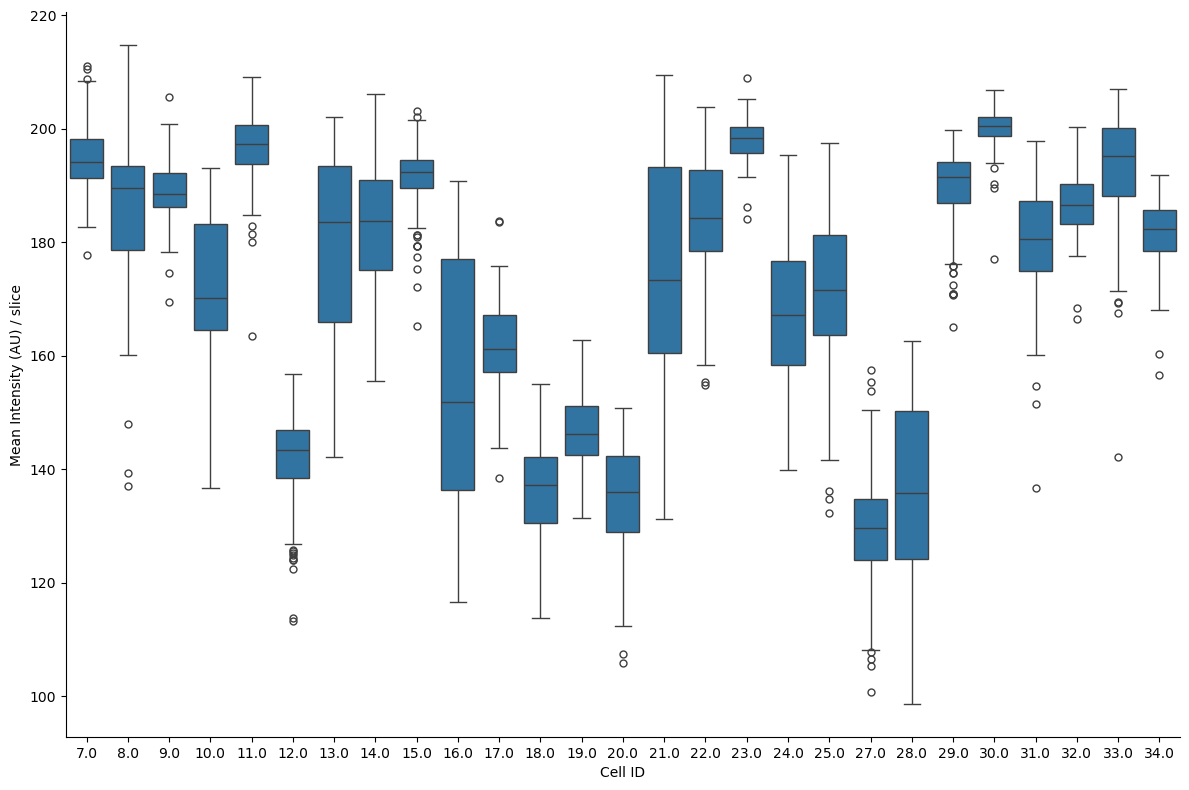

In [10]:
#visualize results - mean intensity

#data to use after removing bad slices
data_to_use = all_dataframes_list_nps_cell_concat_no_bad_slices[all_dataframes_list_nps_cell_concat_no_bad_slices['label'].isin(index_keep_ECs)]

#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
ax = sns.catplot(data=data_to_use, x='label',y='mean-intensity', kind='box', height = 8, aspect = 1.5)

#turn off grid
plt.grid(False)
#sns.set_style("whitegrid", {'axes.grid' : False})

#specfiy axis labels
ax.set(xlabel='Cell ID',
       ylabel='Mean Intensity (AU) / slice',
      )


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

    
#export figure as svg for illustrator figure
plt.savefig("mean_intensity_per_slice.svg", format="svg", bbox_inches='tight')

#display histogram
plt.show()

C:\Users\Z6\AppData\Local\Temp\ipykernel_14500\745029535.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


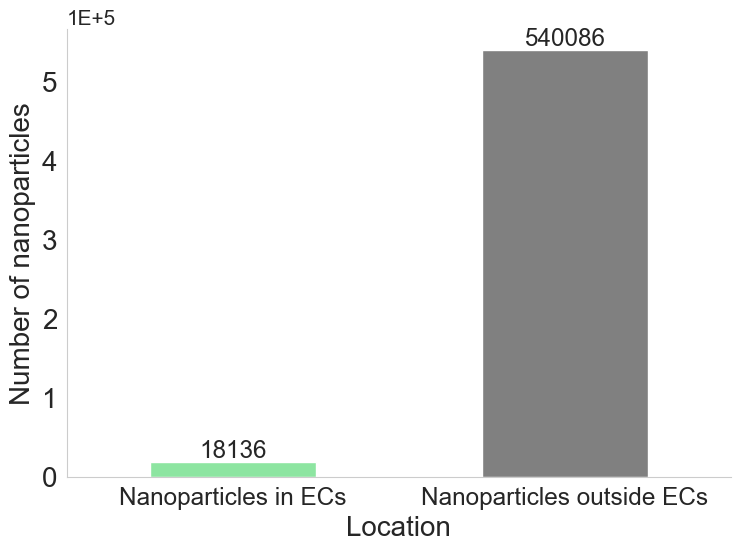

In [12]:
#redo for only good slices

#get number of NPs inside cells
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

nps_inside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['NP-label', 'cell-lowest-EDT']]
num_nps_inside_cells = len(nps_inside_cells)

#if the NPs are in the dataset but not inside cells, then they are outside of cells
nps_outside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']!=0), ['NP-label', 'cell-lowest-EDT']]
num_nps_outside_cells = len(nps_outside_cells)

to_plot = pd.DataFrame(
    {'Nanoparticles in ECs': [num_nps_inside_cells],
     'Nanoparticles outside ECs': [num_nps_outside_cells]}
)



ax = sns.catplot(data=to_plot,kind='bar',color='gray', width=0.5, aspect = 1.5)


#turn off grid
sns.set_style("whitegrid", {'axes.grid' : False})


for ax in ax.axes.flat:
    ax.bar_label(ax.containers[0],fontsize=17.5)

plt.xlabel('Location',fontsize=20)
plt.ylabel('Number of nanoparticles',fontsize=20)
#plt.ticklabel_format()
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=20)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
y_ticks = ax.axes.get_yticks()
ylabels = [( '{:,.1f}'.format(y/1e5)).replace(".0","") for y in y_ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E+5",transform=ax.transAxes, fontsize=15)

    
#change colours for each plot

palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance

for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_inside-outside.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

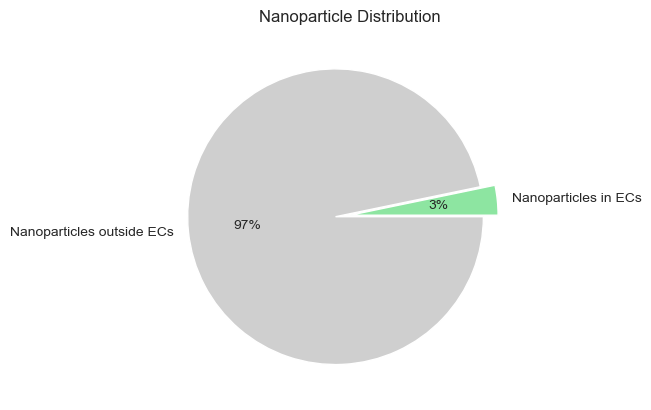

In [13]:
#make as pie chart

#redo for only good slices

#get number of NPs inside cells
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

nps_inside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['NP-label', 'cell-lowest-EDT']]
num_nps_inside_cells = len(nps_inside_cells)

#if the NPs are in the dataset but not inside cells, then they are outside of cells
nps_outside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']!=0), ['NP-label', 'cell-lowest-EDT']]
num_nps_outside_cells = len(nps_outside_cells)

to_plot = pd.DataFrame(
    {'Nanoparticles in ECs': [num_nps_inside_cells],
     'Nanoparticles outside ECs': [num_nps_outside_cells]}
)
#num_nps_inside_cells


#visualize results - sum of nm^3 volume


#pie chart

#plt.pie(data=to_plot.values[0], labels= to_plot.columns, autopct='%.0f%%') 

explode_list = [0, 0.1]
plt.pie(x=to_plot.values[0], labels=to_plot.columns, autopct='%.0f%%', colors =palette, explode = explode_list) 


#turn off grid
sns.set_style("whitegrid", {'axes.grid' : False})

# Add a title
plt.title("Nanoparticle Distribution")

    
#change colours for each plot
palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance

#for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
#    for bar, color in zip(bars, colors):
#        bar.set_facecolor(color)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_inside-outside_pie.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

In [171]:
total_nps = num_nps_inside_cells + num_nps_outside_cells
#total_nps

#what percentage of NPs are inside ECs? outside ECs?
print(num_nps_inside_cells/total_nps*100, "% of NPs in the dataset are inside ECs")
print(num_nps_outside_cells/total_nps*100, "% of NPs in the dataset are inside ECs")

3.248886643665065 % of NPs in the dataset are inside ECs
96.75111335633494 % of NPs in the dataset are inside ECs


In [14]:
sns.color_palette("pastel",15)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0)]

In [ ]:
#a1c9f4, #pastel blue

#ff9f9b #pastel red

#cfcfcf #pastel gray

#fffea3 #pastel yellow

#8de5a1 #pastel green

In [29]:
#Do Transport Score (t-score) here
# transport score is a score for each endothelial cell in the annotated dataset
# t-score calculated as sum of all NP sub t-scores
    # sub t-score of 1 is assigned for each NP inside the cell
    # sub t-score of 1/distance is assigned for each NP closest to the cell but not within the cell

    
# try to do math without for loop so it is faster. instead use slicing

#updated Jan 11 2024 - use file without bad slices for transport score
all_df_EDT_combined = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)

#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    


In [98]:
#create new column with inverted values of 'lowest-EDT' to later on use for transport score
#test_distance_concat['inverse-lowest-EDT'] = 1/test_distance_concat['lowest-EDT']
all_df_EDT_combined['inverse-lowest-EDT_nm'] = 1/all_df_EDT_combined['lowest-EDT_nm']


In [99]:
#set the value to 1 for lowest-EDT where it is 0
#all_df_EDT_combined.loc[all_df_EDT_combined['lowest-EDT'] == 0,'lowest-EDT'] = 1 # works!

#set the value to 0 for inverse-lowest-EDT where it is inf
all_df_EDT_combined.loc[all_df_EDT_combined['inverse-lowest-EDT_nm'] == np.inf,'inverse-lowest-EDT_nm'] = 0 # works!

#make a new-column for t-score which is a copy of 'inverse-lowest-EDT_nm'
all_df_EDT_combined['transport_score_inv_nm'] = all_df_EDT_combined['inverse-lowest-EDT_nm'].copy()

#now for t-score, set the values of 'inverse-lowest-EDT_nm' =0 to a value of 1
all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm'] == 0,'transport_score_inv_nm'] = 1 # works!

In [108]:
#get max and min value for rescaling values before applying to cells for hot/cold visualization of transport score
print("max transport score value: ", np.max(keep_ECs_t_scores))
#print("max transport score value rescaled to uint8 (8-bit): ", np.max(keep_ECs_t_scores).astype(np.uint8)) #rescale value to uint8 for 8bit imageJ
print("min transport score value: ", np.min(keep_ECs_t_scores))
#print("min transport score value rescaled to uint8 (8-bit): ", np.min(keep_ECs_t_scores).astype(np.uint8)) #rescale value to uint8 for 8bit imageJ

#rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
keep_ECs_t_scores_rescaled_8bit = ((keep_ECs_t_scores-np.min(keep_ECs_t_scores))/( np.max(keep_ECs_t_scores) - np.min(keep_ECs_t_scores))*255).astype(np.uint8)

#don't want to have an empty EC (value =0), so make the value 1 if the value is 0
keep_ECs_t_scores_rescaled_8bit[keep_ECs_t_scores_rescaled_8bit == 0] = 1 #this works


print(keep_ECs_t_scores)
print()
print(keep_ECs_t_scores_rescaled_8bit)

max transport score value:  3653.8021551885886
min transport score value:  5.0058573540891995
[212.20193127660048, 606.5691979008174, 51.80692377729123, 476.135974106628, 105.51144052906184, 772.1318470792468, 283.29155274075737, 188.7946239372323, 316.5686620022577, 1271.5765455789178, 2295.115007116663, 611.6755464480685, 356.8996734187288, 1384.0259067545828, 1467.1847025858497, 540.7270459443807, 57.24107908976674, 1127.4796311908922, 692.343267039872, 598.2258988239561, 1066.9530510234104, 202.78390428043087, 42.62052206465093, 5.0058573540891995, 36.298047085296226, 3653.8021551885886, 5.0950815933195015]

[ 14  42   3  32   7  53  19  12  21  88 160  42  24  96 102  37   3  78
  48  41  74  13   2   1   2 255   1]


In [109]:
#lastly read in the EC-only annotated mask dataset and replace values from EC-index with the transport score
# can also read in original dataset and set all non-EC values to 0 (i.e. values not in index_keep_ECs are set to 0)
# can for-loop through each material from 0-max number of materials
    # if the material is in the index_keep_ECs, then replace with respective transport score. 
    # if the material IS NOT in the index_keep_ECs, then replace with 0 (remove the material)

#keep it simple and use file with only annotated EC (annotated_EC_only)
annotated_EC_only = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/new_num_annotated_EC_only_8bit.tif", plugin="tifffile")


In [110]:
#make a copy of the annotated_EC_only dataset which will be used for assigning hot/cold transport scores
annotated_EC_only_8bit_transport = annotated_EC_only
for keep_ecs in range(len(index_keep_ECs)):
    print(keep_ecs,",", index_keep_ECs[keep_ecs],",",keep_ECs_t_scores[keep_ecs],",", keep_ECs_t_scores_rescaled_8bit[keep_ecs]) 
    annotated_EC_only_8bit_transport[annotated_EC_only_8bit_transport == index_keep_ECs[keep_ecs]] = keep_ECs_t_scores_rescaled_8bit[keep_ecs]

0 , 7 , 212.20193127660048 , 14
1 , 8 , 606.5691979008174 , 42
2 , 9 , 51.80692377729123 , 3
3 , 10 , 476.135974106628 , 32
4 , 11 , 105.51144052906184 , 7
5 , 12 , 772.1318470792468 , 53
6 , 13 , 283.29155274075737 , 19
7 , 14 , 188.7946239372323 , 12
8 , 15 , 316.5686620022577 , 21
9 , 16 , 1271.5765455789178 , 88
10 , 17 , 2295.115007116663 , 160
11 , 18 , 611.6755464480685 , 42
12 , 19 , 356.8996734187288 , 24
13 , 20 , 1384.0259067545828 , 96
14 , 21 , 1467.1847025858497 , 102
15 , 22 , 540.7270459443807 , 37
16 , 23 , 57.24107908976674 , 3
17 , 24 , 1127.4796311908922 , 78
18 , 25 , 692.343267039872 , 48
19 , 27 , 598.2258988239561 , 41
20 , 28 , 1066.9530510234104 , 74
21 , 29 , 202.78390428043087 , 13
22 , 30 , 42.62052206465093 , 2
23 , 31 , 5.0058573540891995 , 1
24 , 32 , 36.298047085296226 , 2
25 , 33 , 3653.8021551885886 , 255
26 , 34 , 5.0950815933195015 , 1


In [111]:
#save the rescaled EC-only transport score image
import tifffile
#tifffile.imwrite('new_transport_score_8bit.tif', annotated_EC_only_8bit_transport.astype(np.uint8), bigtiff=True,)
tifffile.imwrite('new_transport_score_8bit.tif', annotated_EC_only_8bit_transport, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0


In [112]:
#output the dataset with the inversed scores column too

#updated Jan 2 2024
all_df_EDT_combined.to_csv('df_EDT_closest_cell_t-score.csv', index=True, header=True, sep=',')


In [ ]:
#need to do correlation between 2D predicted vs. 3D true NPs/cell - Feb 20 2024

#read in dataset
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    

all_df_EDT_combined_no_bad_slices = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)


In [ ]:
#Are most NPs in cells or outside of cells?
np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['cell-lowest-EDT', 'z-slice']]



In [ ]:
#Are most NPs in cells or outside of cells?

np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['cell-lowest-EDT', 'z-slice']]

#sort columns based on cell-lowest EDT and then by z-slice
np_per_cell_per_slice = np_per_cell_per_slice.sort_values(by=['cell-lowest-EDT', 'z-slice']).reset_index()
np_per_cell_per_slice

#remove index column
np_per_cell_per_slice = np_per_cell_per_slice.drop(columns=['index'])


np_per_cell_per_slice


#get correct numbers when using size instead of count -- compare to values for 1 column 
np_per_cell_per_slice = pd.DataFrame(np_per_cell_per_slice.groupby(['cell-lowest-EDT','z-slice']).size().reset_index())

#rename column
np_per_cell_per_slice.rename(columns={0:'num_nps_per-slice-of-cell'}, inplace=True)
np_per_cell_per_slice



In [ ]:
#put total number of slices as a new column using mapping, as per above code

np_per_cell_per_slice_projected = np_per_cell_per_slice.copy()
np_per_cell_per_slice_projected['num_slices_per_cell-label'] = np_per_cell_per_slice_projected['cell-lowest-EDT'].map(label_and_num_slices.set_index('label')['index_manual'])
np_per_cell_per_slice_projected
#this works

In [ ]:
#calculate projected number of NPs
np_per_cell_per_slice_projected['projected_total_NPs_per_cell'] = np_per_cell_per_slice_projected['num_nps_per-slice-of-cell'] * np_per_cell_per_slice_projected['num_slices_per_cell-label']
np_per_cell_per_slice_projected



In [ ]:
#sum up the total number of NPs in each cell and put as a separate dataframe
    #will need to map this dataframe as a new column onto the other dataframe to get true vs. predicted value of NPs/cell
#this is the correct dataframe, but don't need the z-slice column
sum_np_per_cell_per_slice = np_per_cell_per_slice.groupby(['cell-lowest-EDT']).sum().reset_index()
del sum_np_per_cell_per_slice['z-slice'] 
sum_np_per_cell_per_slice

In [ ]:
np_per_cell_per_slice_projected['true_total_NPs-per-cell'] = np_per_cell_per_slice_projected['cell-lowest-EDT'].map(sum_np_per_cell_per_slice.set_index('cell-lowest-EDT')['num_nps_per-slice-of-cell'])
np_per_cell_per_slice_projected

In [ ]:
#plot graph of number of nanoparticles per cell from predicted vs. real data

#plot true vs. predicted values as scatterplot and get correlation 
#for surface area (nm^2)

plt.figure() #this creates a new figure on which your plot will appear

ax = sns.set(rc={"figure.figsize":(10, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")

ax = sns.regplot(data=np_per_cell_per_slice_projected, x="true_total_NPs-per-cell", y="projected_total_NPs_per_cell",line_kws={"color": "black"},scatter_kws={'alpha':0.3},color=sns.color_palette("pastel")[3],ci=None)
plt.grid(False)


np_per_cell_per_slice_projected  = np_per_cell_per_slice_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], y=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])
r, p = scipy.stats.spearmanr(a=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], b=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_r2 = "r$^2$ = "+str(round(r**2, 10))


ax.text(0.05, 0.9, text_r2,transform=ax.transAxes, size=18)

ax.set(xlabel='True Number of Nanoparticles/Cell', ylabel='Predicted Number of Nanoparticles/Cell')

#set scale to 1e3
plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))
#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("predicted-vs-true_NPs-per-cell.svg", format="svg", bbox_inches='tight')


In [122]:
#read in the full dataset
#updated Jan 2 2024
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)


In [123]:
all_df_EDT_combined

,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,3D-EDT-to-cell-15_nm,...,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,cell-lowest-EDT,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm
0,1,68796.39844,15273.59277,63235.89844,58506.18750,58567.34375,53622.86719,51787.61719,61350.91406,67307.30469,...,65093.47266,56342.47266,58079.43750,15273.59277,8,0,286,1124,0.000065,0.000065
1,2,68600.06250,15038.66309,62932.21875,58186.86719,58257.55469,53327.51563,51485.75781,60967.10547,66878.63281,...,64862.32031,56055.84766,57758.58984,15038.66309,8,0,314,1115,0.000066,0.000066
2,3,67079.95313,13693.51172,61750.96875,57059.13281,57096.19531,52338.45313,50549.91016,60141.12500,66321.06250,...,63435.89453,54802.91406,56637.13281,13693.51172,8,0,323,1226,0.000073,0.000073
3,4,67016.51563,13641.23047,61704.20703,57015.19141,57050.60938,52300.46094,50514.43750,60111.50781,66303.85938,...,63377.20313,54752.46484,56593.50391,13641.23047,8,0,323,1231,0.000073,0.000073
4,5,66895.14063,13526.98438,61591.77344,56904.30859,56938.69922,52201.81250,50418.51953,60012.43359,66216.72656,...,63257.63672,54637.24609,56482.84375,13526.98438,8,0,327,1237,0.000074,0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574886,574887,16417.79688,16599.83008,23503.05469,20402.54492,28613.79688,22026.15625,29189.99023,30947.19531,34492.24219,...,23096.61914,31762.37500,35503.62500,13891.93848,16,341,4066,4357,0.000072,0.000072
574887,574888,16398.58984,16601.71875,23501.32617,20395.63867,28600.63867,22020.29688,29175.02930,30907.76563,34442.52344,...,23107.13281,31771.58398,35498.28516,13858.56055,16,341,4070,4354,0.000072,0.000072
574888,574889,16266.76563,16499.04297,23391.50195,20252.87305,28465.21875,21877.96289,29030.34570,30749.52539,34283.90625,...,23026.44727,31683.77734,35386.41406,13693.88281,16,341,4070,4344,0.000073,0.000073
574889,574890,16589.42578,16755.51172,23664.09961,20605.15820,28797.71289,22229.40234,29385.15234,31131.53906,34664.26172,...,23230.42969,31904.54492,35662.75391,14093.33301,16,341,4071,4368,0.000071,0.000071


In [158]:
#print(annotated_EC_only.shape)
z_shape, y_shape, x_shape = annotated_EC_only.shape
#print(z_shape,y_shape,x_shape)

#make an array that will hold each NP coordinate as it's EDT. Use np.array to fill with zeros
# use uint16 as the distances are less than 2^16 (16bit) but greater than 2^8 (255, 8bit)
    #Jan 10 2024 --> adter checking in Excel, the lowest value is 46174.45313, so 16 bit will work as 16-bit allows up to 65,535
np_distance_at_centroid = np.zeros((z_shape, y_shape, x_shape), dtype=np.uint16)

for each_row in tqdm(all_df_EDT_combined['NP-label']-1): #use this range as it accounts for only the NPs in the dataset after removing bad slices, but subtract 1 to prevent error to keep things in line with 'each_np_plus_1'
    
    each_np_plus_1 = each_row+1
    
    #need to skip NPs that are on bad slices
        #skip the NPs that are not in the column 'NP-label'
        
    #get coordinates of NP with unique value
    z_slice_np = all_df_EDT_combined['z-slice'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    y_coord_np = all_df_EDT_combined['centroid,0_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    x_coord_np = all_df_EDT_combined['centroid,1_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]

    #get coords as a set
    current_np_coords_set = z_slice_np , y_coord_np , x_coord_np
    #print(current_np_coords_set)
    #put label of lowest-EDT at coords of label centroid in np_distance_at_centroid array

    #gives float values, need to convert to integer
    #print(all_df_EDT_combined['lowest-EDT'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0])

    #nest in int for coordinates, otherwise I get an error
    np_distance_at_centroid[int(z_slice_np), int(y_coord_np), int(x_coord_np)] = all_df_EDT_combined['lowest-EDT_nm'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]

    
    

100%|█████████████████████████████████████████████████████████████████████████| 558222/558222 [23:42<00:00, 392.32it/s]


In [ ]:
all_df_EDT_combined

In [159]:
#save the NP centroid as EDT 
import tifffile
tifffile.imwrite('new_np-EDT-map_16bit.tif', np_distance_at_centroid, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0


In [160]:
#read in NP centroid as EDT 16bit
np_distance_at_centroid = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/new_np-EDT-map_16bit.tif", plugin="tifffile")


In [161]:
#rescale NP centroid as EDT to 8bit
#get max and min value for rescaling values before applying to NPs for hot/cold distance for visualization
#print("max EDT value: ", np.max(np_distance_at_centroid)) #wrong value
#print("max EDT value: ", max(np_distance_at_centroid.tolist())) # took too much ram to load? unclear why...

#print(max(all_df_EDT_combined['lowest-EDT'])) # this value matches FIJI
#print("min EDT value: ", np.min(np_distance_at_centroid)) #is correct, but not sure if chance


#interestingly, when putting the 16bit image into FIJI, then going to brightness/contrast, the max value is given as 1901.
    # this is the same value given by np.max. Why is this?
        #after playing around, it is because the max value on the first slice of the stack is 1901, but other slices have different max values
        # going to different slices then looking at brightness and contrast results in different max values in the dialog box

#if the max value is wrong, then it is likely that the FIJI values for transport value re-scaling are also incorrect


In [31]:
#this works, but is faster to rescale EDT values in Fiji than python. possibly because of CPU limited in Python by GIL?
# in FIJI, use hot/cold LUT. Is called 'phase'. But need to invert so that red is for low EDT values and blue is for high EDT values (cold)
'''
#how to rescale values
    #rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255


#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values
#for FIJI:
# Stack.getStatistics(voxelCount, mean, min, max, stdDev);
#print(voxelCount, mean, min, max, stdDev); // max value is 


#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])
max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])
min_np_centroid_EDT = 0

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)
np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid - min_np_centroid_EDT)/( max_np_centroid_EDT - min_np_centroid_EDT ) * 255).astype(np.uint8)

#BELOW LINE NOT RELEVANT FOR NP EDT: don't want to have an empty EC (value =0), so make the value 1 if the value is 0
#np_distance_at_centroid_rescaled_8bit[np_distance_at_centroid_rescaled_8bit == 0] = 1 #this works


#print(keep_ECs_t_scores)
#print()
#print(keep_ECs_t_scores_rescaled_8bit)



'''

"\n#how to rescale values\n    #rescale_val = (x - min)/ (max - min) * (255-0) + 0\n# simplifies to: rescale_val = (x-min)/(max-min)*255\n\n\n#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values\n#for FIJI:\n# Stack.getStatistics(voxelCount, mean, min, max, stdDev);\n#print(voxelCount, mean, min, max, stdDev); // max value is \n\n\n#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])\nmax_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])\nmin_np_centroid_EDT = 0\n\n#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise\n#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)\nnp_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid - min_np_centroi

In [163]:
#another Python approach. Rescale data to 8-bit as a list, then use this list for each NP. This is faster than applying the rescaling to the data already in the 16-bit numpy array


#how to rescale values
    #rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255


#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values
#for FIJI:
# Stack.getStatistics(voxelCount, mean, min, max, stdDev);
#print(voxelCount, mean, min, max, stdDev); // max value is 


#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])
max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])
min_np_centroid_EDT = 0 #because has a NP within EC, thus distance = 0

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)
centroid_EDT = all_df_EDT_combined['lowest-EDT_nm']

#rescale the data as a list
centroid_EDT_8bit_rescale = ((centroid_EDT - min_np_centroid_EDT)/( max_np_centroid_EDT - min_np_centroid_EDT ) * 255).astype(np.uint8)

#BELOW LINE NOT RELEVANT FOR NP EDT: don't want to have an empty EC (value =0), so make the value 1 if the value is 0
#np_distance_at_centroid_rescaled_8bit[np_distance_at_centroid_rescaled_8bit == 0] = 1 #this works
    # this means that if the NP is within a cell (i.e. EDT=0), then it will not appear in the 8-bit dataset. This is because the value of 0 is for background.

#print(keep_ECs_t_scores)
#print()
#print(keep_ECs_t_scores_rescaled_8bit)




In [164]:
#then do in 8bit, use same for-loop with the rescaled list data from the previous code block

#print(annotated_EC_only.shape)
z_shape, y_shape, x_shape = annotated_EC_only.shape
#print(z_shape,y_shape,x_shape)

#make an array that will hold each NP coordinate as it's EDT. Use np.array to fill with zeros
# use uint16 as the distances are less than 2^16 (16bit) but greater than 2^8 (255, 8bit)
    #Jan 10 2024 --> after checking in Excel, the lowest value is 46174.45313, so 16 bit will work as 16-bit allows up to 65,535
np_distance_at_centroid_rescaled_8bit = np.zeros((z_shape, y_shape, x_shape), dtype=np.uint8)


for each_row in tqdm(all_df_EDT_combined['NP-label']-1): #use this range as it accounts for only the NPs in the dataset after removing bad slices, but subtract 1 to prevent error to keep things in line with 'each_np_plus_1'

    each_np_plus_1 = each_row+1
    
    #get coordinates of NP with unique value
    z_slice_np = all_df_EDT_combined['z-slice'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    y_coord_np = all_df_EDT_combined['centroid,0_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    x_coord_np = all_df_EDT_combined['centroid,1_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
        
    #get coords as a set
    current_np_coords_set = z_slice_np , y_coord_np , x_coord_np
    #print(current_np_coords_set)
    #put label of lowest-EDT at coords of label centroid in np_distance_at_centroid array
    
    #gives float values, need to convert to integer
    #print(all_df_EDT_combined['lowest-EDT'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0])
    
    #nest in int for coordinates, otherwise I get an error
    np_distance_at_centroid_rescaled_8bit[int(z_slice_np), int(y_coord_np), int(x_coord_np)] = centroid_EDT_8bit_rescale[each_row]
    
# this optimized Python approach is likely faster than the FIJI approach below. 

100%|█████████████████████████████████████████████████████████████████████████| 558222/558222 [17:29<00:00, 532.10it/s]


In [ ]:
#do in Fiji instead of python because faster. gives same results. may not be faster than the optimized code above. did not run comparison.
# saved as "rescale-16-bit-to-8bit_v3.ijm"

#maybe because FIJI uses more CPU? Python limited by GIL?

'''

Stack.getStatistics(voxelCount, mean, min, max, stdDev);
print(voxelCount, mean, min, max, stdDev);

//convert to 32 bit to prevent clipping the values when multiplying by 255
run("32-bit");
resetMinAndMax();


// by default FIJI rescales the values when changing bit depth
// need to disable this
//Edit --> Options --> Conversions. Uncheck scale when converting. 
run("Conversions...", " ");


// multiply by 255 then divide by max value in the stack to rescale


run("Multiply...", "value=255.000 stack");
run("Divide...", "value="+max+" stack");

run("8-bit");

print("done")

// this is faster than python and appears to give same results...
'''

In [165]:
#save the NP centroid as EDT after converting to rescaled 8bit 
import tifffile
tifffile.imwrite('new_np-EDT-map_8bit_rescaled.tif', np_distance_at_centroid_rescaled_8bit, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0


In [97]:
#read in the full dataset

#updated Jan 2 2024
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)
    #note that this file has the bad slices removed

In [8]:
all_df_EDT_combined[100:130]

,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,3D-EDT-to-cell-15_nm,...,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,cell-lowest-EDT,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm
100,101,65267.03125,11720.157230,59308.74219,54520.35547,54612.68359,50027.10156,48209.50000,57260.47266,63229.64063,...,61380.56250,52453.97266,54089.76172,11720.157230,8,0,514,1203,0.000085,0.000085
101,102,65391.74609,11845.735350,59356.16406,54556.77344,54656.52734,50055.14844,48227.86328,57236.96875,63157.23828,...,61474.91797,52517.00781,54124.92969,11845.735350,8,0,522,1187,0.000084,0.000084
102,103,65451.04297,11935.481450,59240.90625,54418.14844,54527.26563,49923.44531,48078.39063,56974.18359,62798.40625,...,61463.87109,52436.52344,53983.68359,11923.836910,24,0,550,1160,0.000084,0.000084
103,104,49452.64844,8885.869141,47214.54688,42914.22266,41605.35938,40953.00391,39511.11328,49162.61719,56968.22266,...,46611.49219,39659.35156,42651.99609,4428.708008,21,0,754,2262,0.000226,0.000226
104,105,52751.80859,2936.937988,47587.95703,42939.33984,42908.82422,40194.13281,38684.77734,47000.91016,54298.09375,...,49005.29297,40440.19531,42533.70313,160.377670,23,0,957,1792,0.006235,0.006235
105,106,52433.07031,3158.817139,47060.96484,42374.43750,42376.73047,39708.13672,38199.42578,46328.13672,53567.01953,...,48614.82813,39944.28516,41965.51563,0.000000,23,0,1001,1780,0.000000,1.000000
106,107,51598.60547,3349.577393,46403.02734,41750.69922,41718.91797,39227.85938,37722.58984,45884.37891,53260.35938,...,47825.82813,39242.59766,41346.07031,0.000000,23,0,1015,1832,0.000000,1.000000
107,108,52418.00000,3310.698730,46874.32031,42156.45313,42181.42969,39510.76563,38002.03906,46000.45703,53168.80859,...,48528.07422,39788.25781,41744.53125,0.000000,23,0,1026,1761,0.000000,1.000000
108,109,51964.12891,3516.921143,46432.59766,41717.55859,41740.03516,39158.00000,37650.89063,45606.40625,52821.18750,...,48071.39453,39337.04297,41306.44531,0.000000,23,0,1045,1780,0.000000,1.000000
109,110,51311.68359,3647.773193,45965.92578,41286.15625,41277.69922,38835.07813,37330.62891,45348.35156,52699.17969,...,47484.69922,38826.62891,40879.22656,0.000000,23,0,1049,1826,0.000000,1.000000


In [11]:
#print average distance from each NP to their closest EC
    # mean distance between each nanoparticle and their closest cell

print(all_df_EDT_combined['lowest-EDT_nm'].mean())
#print standard deviation of distance from each NP to their closest EC
print(np.std(all_df_EDT_combined['lowest-EDT_nm']))

6791.46539560797
5360.682589298607


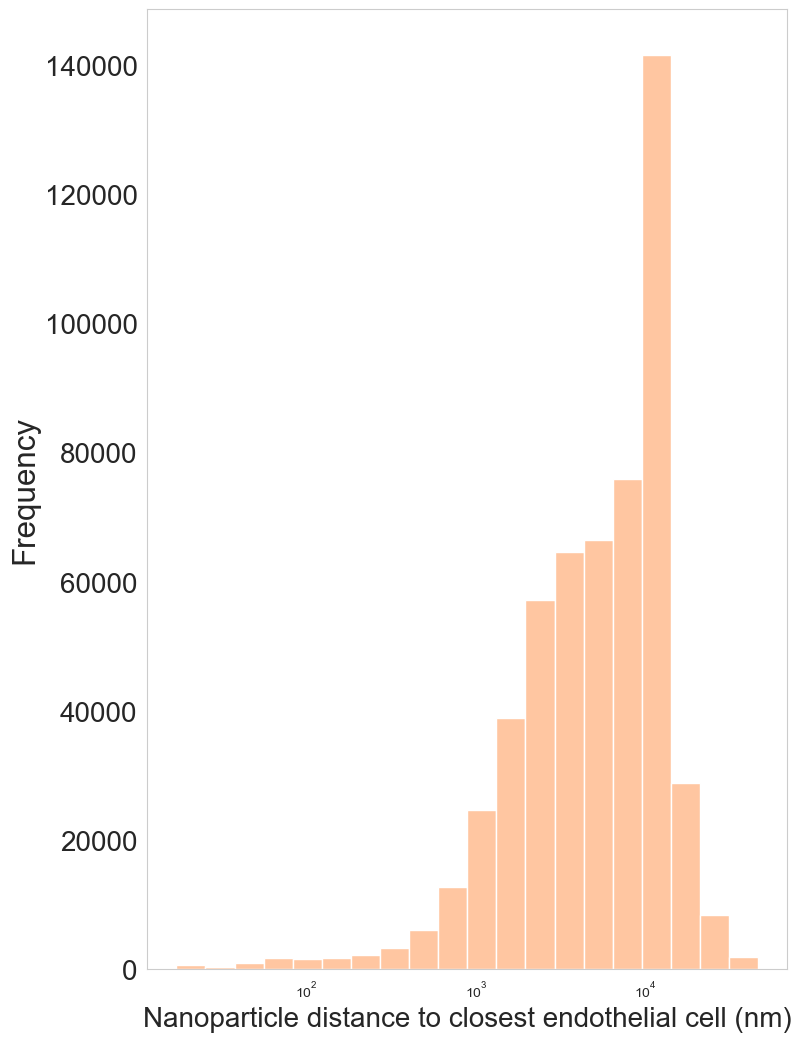

In [122]:
#plot minimum distance to nanoparticles for each endothelial cell ID as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)

#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3],) #pastel red

#set bw to smooth out lines for visualization 
#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3], bw=0.1) #pastel red
ax = sns.histplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[1], log_scale=10, bins=20) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


#turn off grid
plt.grid(False)

plt.xlabel('Nanoparticle distance to closest endothelial cell (nm)',fontsize=20)
plt.ylabel('Frequency',fontsize=22.5)
#plt.ticklabel_format()
#plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#set y-minimum value so that it does not go below zero
plt.ylim(0)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
plt.savefig("np-distance-closest-EC_pastel-orang-hist-log.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


C:\Users\Z6\AppData\Local\Temp\ipykernel_21792\3194599362.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels_letters)


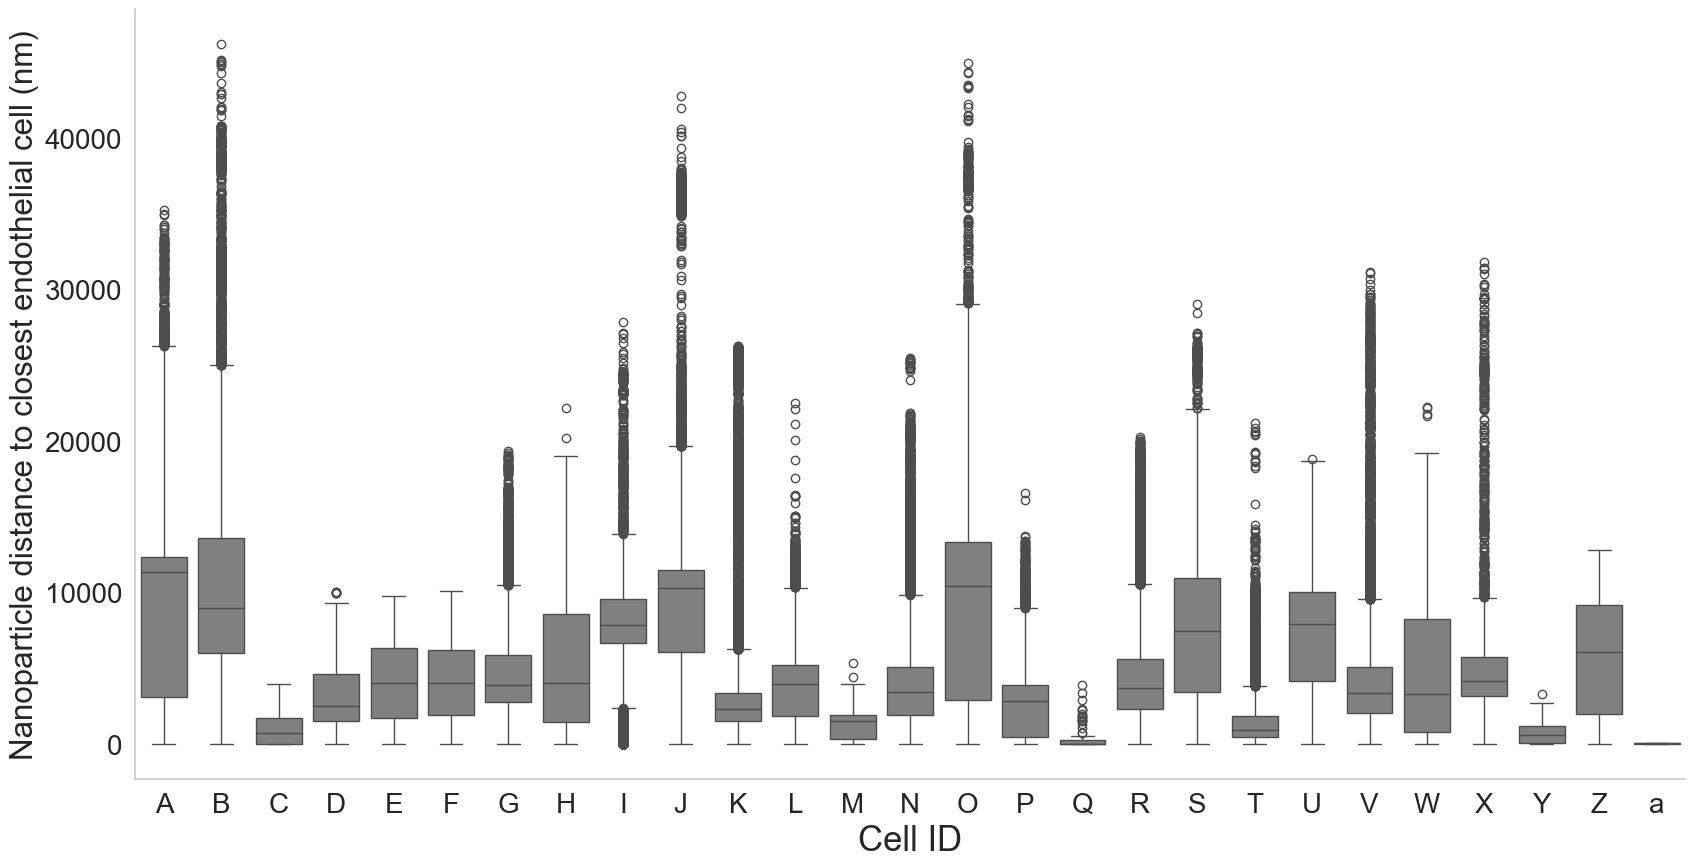

'\n# Create a box plot of the N2 variable for pre/post-test measures\nax = sns.boxplot(data=nps_high_and_low_intensity, palette="gray")\n#change aspect ratio to bring boxplots closer together,\n    #see: https://stackoverflow.com/questions/16302718/reducing-the-distance-between-two-boxplots\nax.set_aspect(0.001) \n# This will add title to plot\n#ax.set_title("Box plot of N2 pre/post-test measures")\n \n# Adding a label to X-axis\nax.set_xlabel("Mean Intensity Of Cell")\n\n# Adding a label l to Y-axis\nax.set_ylabel("Nanoparticles per slice of cell")\n\n# Removing the Grid\nax.grid(False)\n\n# Only lines on y- and x-axis\nsns.despine()\n\n# White background:\nsns.set_style("white")'

In [29]:
#plot minimum distance to nanoparticles for each endothelial cell ID

ax = sns.set(rc={"figure.figsize":(20, 10)}) #width=20, height=10
ax = sns.set_style("whitegrid")
ax = sns.boxplot(data=all_df_EDT_combined, x='cell-lowest-EDT', y='lowest-EDT_nm', color="gray")


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Nanoparticle distance to closest endothelial cell (nm)',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Removing the Grid
ax.grid(False)

# Only lines on y- and x-axis
sns.despine()


#manually override the cell labels from the numbers to letters
#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)




#display histogram
plt.show()


[Text(0.5, 0, 'Endothelial Cell ID'),
 Text(0, 0.5, 'Frequency (closest cell for each NP)')]

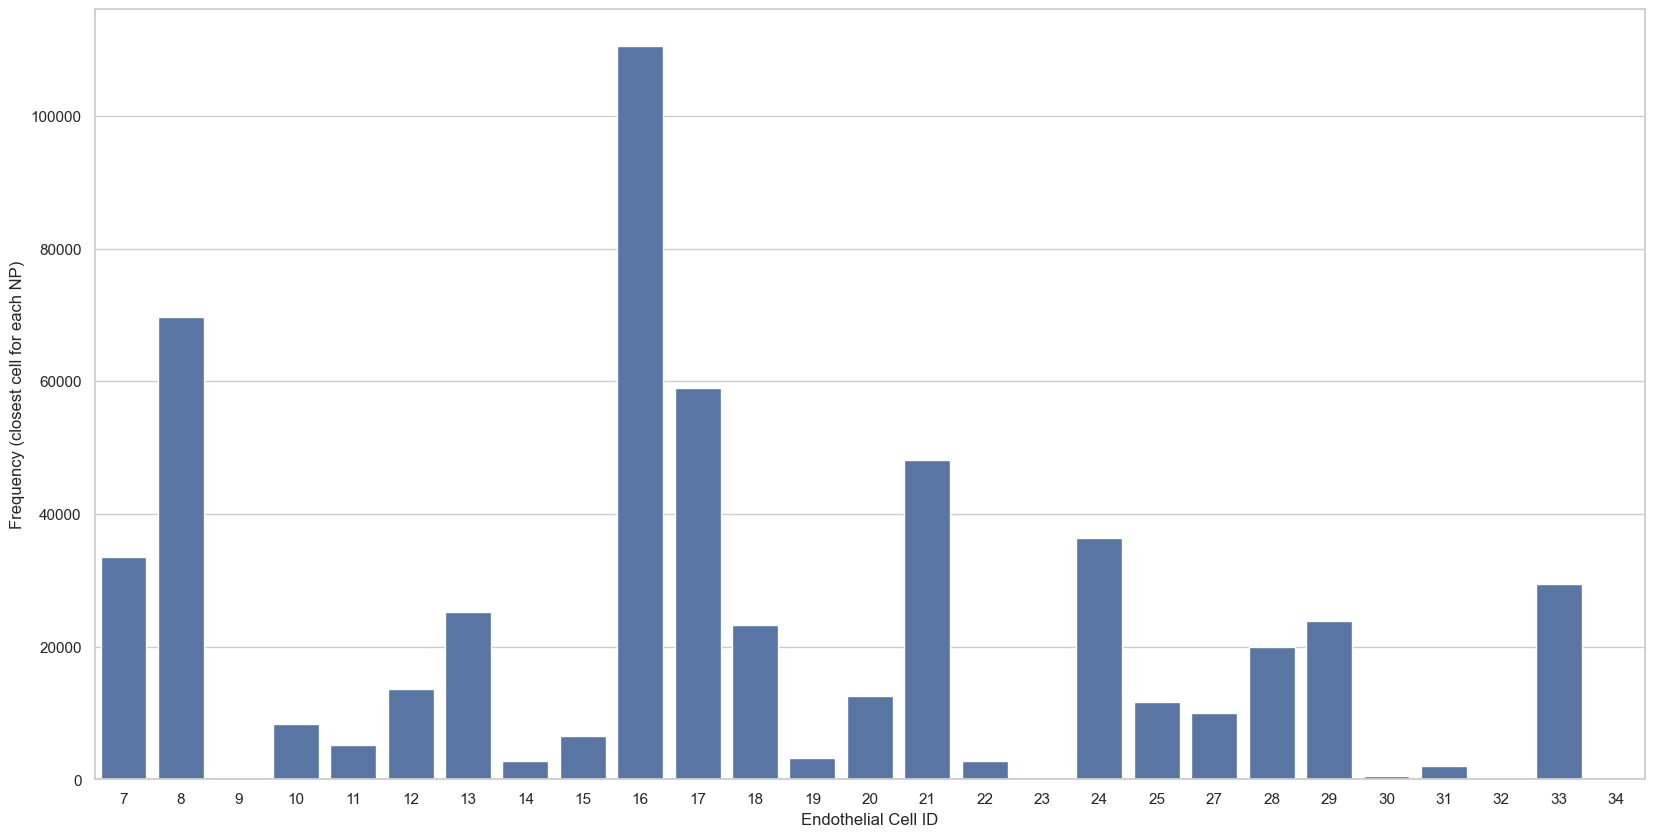

In [31]:
# this is not transport score. this is a histogram of the closest cell for each NP. 

ax3 = sns.countplot(data=all_df_EDT_combined, x='cell-lowest-EDT', )
ax3.set(xlabel='Endothelial Cell ID',
       ylabel='Frequency (closest cell for each NP)',
      )
#plt.show()

In [12]:
#get transport score without adding NPs within the cell assigned a value of 1
# can replace all 1s with 0s in the column

#updated Feb 9 2024 for T-score without NPs within cell
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)
    #note that this file has the bad slices removed
    
#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    

In [13]:
#replace inf with 1 using indexing

# find all values = 1 for column 'transport_score_inv_nm'
all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm']==1]

,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,3D-EDT-to-cell-15_nm,...,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,cell-lowest-EDT,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm
105,106,52433.070310,3158.817139,47060.96484,42374.437500,42376.73047,39708.136720,38199.425780,46328.136720,53567.01953,...,48614.82813,39944.28516,41965.51563,0.0,23,0,1001,1780,0.0,1.0
106,107,51598.605470,3349.577393,46403.02734,41750.699220,41718.91797,39227.859380,37722.589840,45884.378910,53260.35938,...,47825.82813,39242.59766,41346.07031,0.0,23,0,1015,1832,0.0,1.0
107,108,52418.000000,3310.698730,46874.32031,42156.453130,42181.42969,39510.765630,38002.039060,46000.457030,53168.80859,...,48528.07422,39788.25781,41744.53125,0.0,23,0,1026,1761,0.0,1.0
108,109,51964.128910,3516.921143,46432.59766,41717.558590,41740.03516,39158.000000,37650.890630,45606.406250,52821.18750,...,48071.39453,39337.04297,41306.44531,0.0,23,0,1045,1780,0.0,1.0
109,110,51311.683590,3647.773193,45965.92578,41286.156250,41277.69922,38835.078130,37330.628910,45348.351560,52699.17969,...,47484.69922,38826.62891,40879.22656,0.0,23,0,1049,1826,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574591,574592,10961.758790,10710.665040,13401.47949,1227.017944,12981.09375,2784.317627,11706.171880,16980.671880,22958.43359,...,17299.59375,18748.86328,23742.53516,0.0,16,341,3471,3392,0.0,1.0
574594,574595,10630.547850,10879.724610,13446.40918,1789.898682,13323.61230,3381.461914,12137.281250,17175.111330,23010.93945,...,17238.02539,18970.59570,23954.93555,0.0,16,341,3498,3415,0.0,1.0
574601,574602,18998.992190,18365.912110,19690.00391,10697.498050,12219.21973,6501.404297,2623.568848,9075.746094,15603.95996,...,24962.21484,17636.00391,23290.09570,0.0,20,341,3573,2546,0.0,1.0
574630,574631,9021.796875,10909.183590,14772.37402,6423.989258,16117.75195,8058.250977,15290.819340,18204.773440,22771.08594,...,17927.72266,20791.63477,25905.15039,0.0,16,341,3761,3527,0.0,1.0


In [14]:
#make copy of dataframe for only NPs outside of ECs
all_df_EDT_combined_outside_cells = all_df_EDT_combined.copy()

In [15]:
#assign value of 0 to transport score for NPs outside of cells
all_df_EDT_combined_outside_cells.loc[all_df_EDT_combined_outside_cells['transport_score_inv_nm']==1] = 0

In [16]:
# now check if there are any values equal to 1 (there are not)
all_df_EDT_combined_outside_cells.loc[all_df_EDT_combined_outside_cells['transport_score_inv_nm']==1]

,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,3D-EDT-to-cell-15_nm,...,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,cell-lowest-EDT,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm


In [17]:
all_df_EDT_combined_outside_cells['cell-lowest-EDT'].isin(index_keep_ECs)

0         True
1         True
2         True
3         True
4         True
          ... 
574886    True
574887    True
574888    True
574889    True
574890    True
Name: cell-lowest-EDT, Length: 558222, dtype: bool

In [18]:
#remove cells that are not ECs
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
all_df_EDT_combined_outside_ECs = all_df_EDT_combined_outside_cells[all_df_EDT_combined_outside_cells['cell-lowest-EDT'].isin(index_keep_ECs)]
#assign new tscore 2 df and get EC index
t_score_df2 = pd.DataFrame(all_df_EDT_combined_outside_ECs.groupby(['cell-lowest-EDT']).sum().reset_index())


In [19]:
min_tscore2 = t_score_df2['transport_score_inv_nm'].min()
max_tscore2 = t_score_df2['transport_score_inv_nm'].max()
print(min_tscore2, max_tscore2, ". Fold difference is: ",max_tscore2/min_tscore2)

0.0950815933195019 40.115007116660166 . Fold difference is:  421.90087183185955


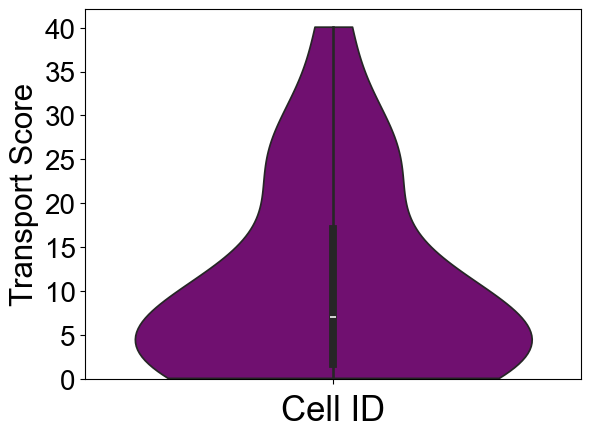

In [20]:
#transport score as violin plot for only NPs outside of the cell (not inside the cell)
    # using t_score_df2

#plot T-score for each endothelial cell ID

#scale to nanometers

#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=t_score_df2['transport_score_inv_nm'], color='purple', cut=0,)



#turn off grid
plt.grid(False)


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Transport Score',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#set y-minimum value so that it does not go below zero
plt.ylim(0)


ax = sns.set_style("whitegrid")


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'


#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
plt.savefig("transport-score2_outside_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


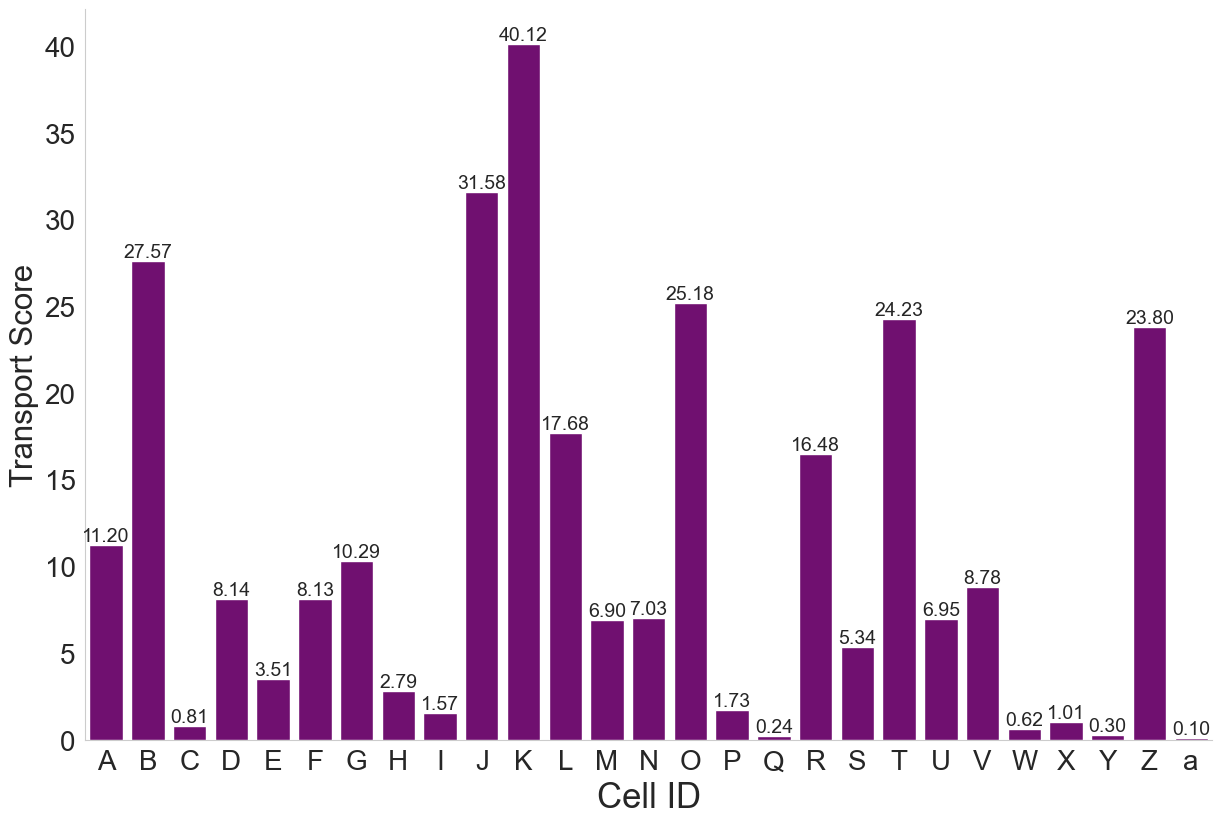

In [21]:
#plot T-score for each endothelial cell ID without NPs within the cells
    # using t_score_df2

#scale to nanometers


ax = sns.catplot(data=t_score_df2, x='cell-lowest-EDT', y='transport_score_inv_nm', kind='bar', height = 8, aspect = 1.5, color='purple', zorder=5)


#turn off grid
plt.grid(False)


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Transport Score',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#manually override the cell labels from the numbers to letters
#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)


#add number of nanoparticles for each bar plot above the plot    
# extract the matplotlib axes_subplot objects from the FacetGrid
ax2 = ax.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax2.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    ax2.bar_label(c, labels=labels, label_type='edge', fontsize=14)

#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score2_outside_purple-ECs-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score2_outside_purple-ECs-short+number.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

In [22]:
#get 'uptake score' which is the number of nanoparticles within each EC (i.e. distance = 0)
all_df_EDT_combined_inside_cells = all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm']==1].copy()
all_df_EDT_combined_inside_cells

,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,3D-EDT-to-cell-15_nm,...,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,cell-lowest-EDT,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm
105,106,52433.070310,3158.817139,47060.96484,42374.437500,42376.73047,39708.136720,38199.425780,46328.136720,53567.01953,...,48614.82813,39944.28516,41965.51563,0.0,23,0,1001,1780,0.0,1.0
106,107,51598.605470,3349.577393,46403.02734,41750.699220,41718.91797,39227.859380,37722.589840,45884.378910,53260.35938,...,47825.82813,39242.59766,41346.07031,0.0,23,0,1015,1832,0.0,1.0
107,108,52418.000000,3310.698730,46874.32031,42156.453130,42181.42969,39510.765630,38002.039060,46000.457030,53168.80859,...,48528.07422,39788.25781,41744.53125,0.0,23,0,1026,1761,0.0,1.0
108,109,51964.128910,3516.921143,46432.59766,41717.558590,41740.03516,39158.000000,37650.890630,45606.406250,52821.18750,...,48071.39453,39337.04297,41306.44531,0.0,23,0,1045,1780,0.0,1.0
109,110,51311.683590,3647.773193,45965.92578,41286.156250,41277.69922,38835.078130,37330.628910,45348.351560,52699.17969,...,47484.69922,38826.62891,40879.22656,0.0,23,0,1049,1826,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574591,574592,10961.758790,10710.665040,13401.47949,1227.017944,12981.09375,2784.317627,11706.171880,16980.671880,22958.43359,...,17299.59375,18748.86328,23742.53516,0.0,16,341,3471,3392,0.0,1.0
574594,574595,10630.547850,10879.724610,13446.40918,1789.898682,13323.61230,3381.461914,12137.281250,17175.111330,23010.93945,...,17238.02539,18970.59570,23954.93555,0.0,16,341,3498,3415,0.0,1.0
574601,574602,18998.992190,18365.912110,19690.00391,10697.498050,12219.21973,6501.404297,2623.568848,9075.746094,15603.95996,...,24962.21484,17636.00391,23290.09570,0.0,20,341,3573,2546,0.0,1.0
574630,574631,9021.796875,10909.183590,14772.37402,6423.989258,16117.75195,8058.250977,15290.819340,18204.773440,22771.08594,...,17927.72266,20791.63477,25905.15039,0.0,16,341,3761,3527,0.0,1.0


In [23]:
#remove cells that are not ECs (for NPs inside ECs)
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
all_df_EDT_combined_inside_ECs = all_df_EDT_combined_inside_cells[all_df_EDT_combined_inside_cells['cell-lowest-EDT'].isin(index_keep_ECs)]
#assign new tscore 2 df and get EC index
t_score_df3 = pd.DataFrame(all_df_EDT_combined_inside_ECs.groupby(['cell-lowest-EDT']).sum().reset_index())


In [24]:
t_score_df3

,cell-lowest-EDT,NP-label,3D-EDT-to-cell-7_nm,3D-EDT-to-cell-8_nm,3D-EDT-to-cell-9_nm,3D-EDT-to-cell-10_nm,3D-EDT-to-cell-11_nm,3D-EDT-to-cell-12_nm,3D-EDT-to-cell-13_nm,3D-EDT-to-cell-14_nm,...,3D-EDT-to-cell-31_nm,3D-EDT-to-cell-32_nm,3D-EDT-to-cell-33_nm,3D-EDT-to-cell-34_nm,lowest-EDT_nm,z-slice,"centroid,0_16bit","centroid,1_16bit",inverse-lowest-EDT_nm,transport_score_inv_nm
0,7,25128900,0.000000e+00,7.354536e+05,1.650469e+06,1.842951e+06,2.354893e+06,3.053497e+06,3.054646e+06,4.268954e+06,...,1.345889e+06,1.284760e+06,2.650017e+06,3.507495e+06,0.0,17083,726531,770635,0.0,201.0
1,8,32178748,3.302381e+06,0.000000e+00,7.377177e+06,4.117623e+06,3.475370e+06,9.974833e+06,8.607865e+06,1.604993e+07,...,1.131338e+07,3.857571e+06,5.721647e+06,9.571356e+06,0.0,25080,1632873,2281667,0.0,579.0
2,9,4396494,4.123669e+05,1.439087e+05,0.000000e+00,6.306608e+04,2.965560e+05,3.607252e+05,3.218668e+05,6.387772e+05,...,4.294042e+05,2.056696e+05,3.060896e+05,4.233367e+05,0.0,3204,179693,166790,0.0,51.0
3,10,91070035,5.069375e+06,1.415718e+06,1.860051e+06,0.000000e+00,1.856402e+06,1.840373e+06,1.760974e+06,5.072921e+06,...,6.025627e+06,4.484500e+06,2.699755e+06,4.182207e+06,0.0,58541,1586466,1452342,0.0,468.0
4,11,5820673,1.181344e+06,1.319293e+05,5.703687e+05,7.201670e+04,0.000000e+00,7.035300e+05,3.021884e+05,1.647788e+06,...,1.563352e+06,7.334822e+05,8.126124e+04,5.233333e+05,0.0,4712,315211,333952,0.0,102.0
5,12,378236457,1.051106e+07,7.191490e+06,8.987529e+06,1.416062e+06,5.120994e+06,0.000000e+00,2.988462e+06,9.293887e+06,...,1.409259e+07,1.330854e+07,1.019190e+07,1.434038e+07,0.0,221684,2513504,2301977,0.0,764.0
6,13,66697416,4.335115e+06,2.677060e+06,2.872063e+06,1.508877e+06,1.538812e+06,1.534121e+06,0.000000e+00,1.409581e+06,...,4.648089e+06,4.417308e+06,2.037906e+06,3.066448e+06,0.0,42181,945669,729914,0.0,273.0
7,14,23248362,3.399182e+06,2.145996e+06,2.265131e+06,1.653351e+06,2.451841e+06,2.710778e+06,6.453737e+05,0.000000e+00,...,3.208383e+06,3.722824e+06,2.323018e+06,2.649372e+06,0.0,16008,730704,445739,0.0,186.0
8,15,39811907,7.318022e+06,5.736181e+06,5.754449e+06,4.820778e+06,6.381481e+06,6.757132e+06,3.376500e+06,6.037418e+05,...,6.861619e+06,8.352158e+06,6.198558e+06,6.749492e+06,0.0,27148,1355475,673033,0.0,315.0
9,16,445144726,7.450341e+06,5.143467e+06,9.308577e+06,4.581556e+06,1.192200e+07,9.328749e+06,1.399043e+07,2.176130e+07,...,1.623772e+07,1.188862e+07,1.673675e+07,2.235256e+07,0.0,270565,4203927,4412608,0.0,1240.0


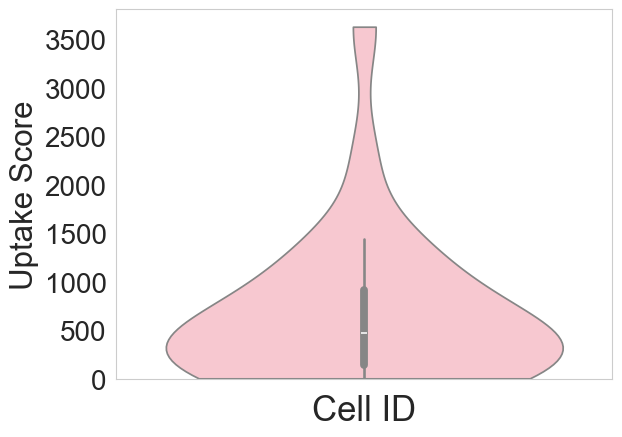

In [25]:
#uptake score as violin plot for only NPs within the cells
    # using t_score_df3

#plot T-score for each endothelial cell ID

#scale to nanometers

#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=t_score_df3['transport_score_inv_nm'], color='pink', cut=0,)


#turn off grid

plt.grid(False)


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Uptake Score',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#set y-minimum value so that it does not go below zero
plt.ylim(0)


ax = sns.set_style("whitegrid")

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'


#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
plt.savefig("transport-score3_inside_pink-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


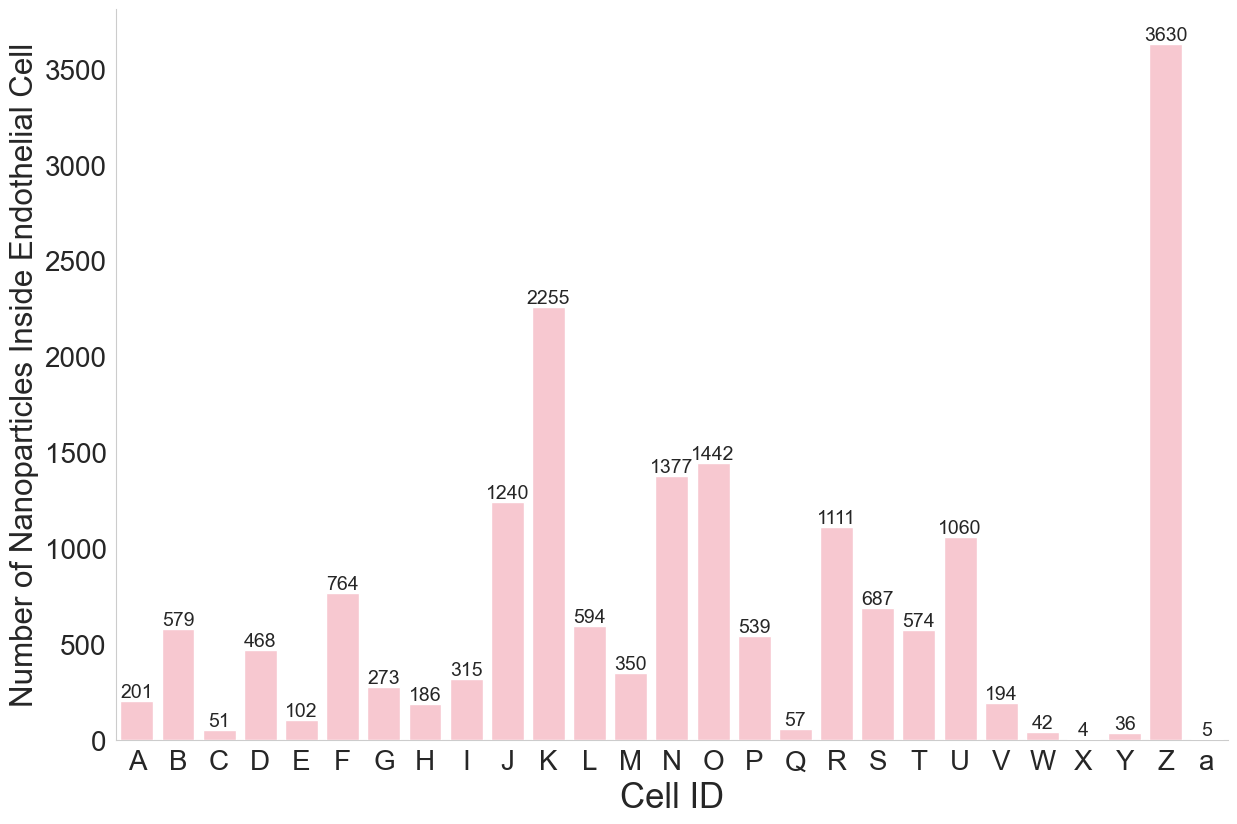

In [26]:
#uptake score as violin plot for only NPs within the cells
    # using t_score_df3


ax = sns.catplot(data=t_score_df3, x='cell-lowest-EDT', y='transport_score_inv_nm', kind='bar', height = 8, aspect = 1.5, color='pink', zorder=5)


#turn off grid
plt.grid(False)


plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Number of Nanoparticles Inside Endothelial Cell',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#manually override the cell labels from the numbers to letters
#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

all_letters = string.ascii_uppercase+string.ascii_lowercase
print(all_letters)

xticklabels_letters = all_letters[0:len(index_keep_ECs)]

ax.set_xticklabels(xticklabels_letters)


#add number of nanoparticles for each bar plot above the plot      
# extract the matplotlib axes_subplot objects from the FacetGrid
ax2 = ax.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax2.containers:
    labels = [f'{(v.get_height()):.0f}' for v in c]
    ax2.bar_label(c, labels=labels, label_type='edge', fontsize=14,)
    
    
    
#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("NPs-inside-ECs_pink+numbers.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line




#display histogram
plt.show()

In [ ]:
# Below are calculations for thickness of walls of the structure that projects from endothelial cell wall 

#After running local thickness on each 2D slice of 3D stack of projection structure, summarize the values
#read in data, then get summary statistics and plot


In [ ]:
#directory: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\10.ishaan-align\2.MIB-model\6.Feb22-2024_net-structure_from-Dec-v4
#FIJI script: 

'''
//run thickness on each slice of 3D z-Ext.CLIJ2_combineHorizontally(Image_stack1, Image_stack2, Image_destination);

//set scale
run("Set Scale...", "distance=1 known=17 unit=nm");



//for script

selectWindow("filled7-mask_updated-slice7_Feb24-net_slice28-48-crop-hole-only.tif");

for (i = 1; i <= nSlices; i++) {
    setSlice(i);
    print(i);
    run("Duplicate...", "use");
    run("Local Thickness (complete process)", "threshold=128");
    rename("thick_"+i);
	selectWindow("filled7-mask_updated-slice7_Feb24-net_slice28-48-crop-hole-only.tif");
    
}

//Closes windows whose title matches 'pattern', which can contain the wildcard characters '*' (matches any character sequence) and '?' (matches single character). For example, close("Histo*") could be used to dispose all histogram windows. Non-image windows like "Roi Manager" have to be specified without wildcards. For text windows, wildcards are allowed if 'pattern' ends with ".txt", ".ijm", ".js" etc. Use close("*") to close all image windows. Use close(pattern, "keep") to not close text or image windows with changes. If 'pattern' is "\\Others", all images except the front image are closed. The most recent macro window is never closed.
//close("!LocThk", "keep")
//close("*LocThk*", "keep")
close("*slice:*")

//stack then save
run("Images to Stack", "name=stack-2d-thickness use");
run("glasbey_on_dark");



'''

In [73]:
#read in data
thickness_projection = io.imread(os.path.join(r"C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\10.ishaan-align\2.MIB-model\6.Feb22-2024_net-structure_from-Dec-v4", "5_stack-2d-thickness.tif"), plugin="tifffile")


In [78]:
#covert data to a flattened version since localization is not important here

thickness_projection_flatten = thickness_projection.flatten()
thickness_projection_flatten

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [77]:
#remove background values equal to 0
thickness_projection_flatten_positive_val = thickness_projection_flatten[thickness_projection_flatten>0]
thickness_projection_flatten_positive_val

array([10.      , 10.      , 10.      , ..., 23.323807, 23.323807,
       23.323807], dtype=float32)

In [86]:
thickness_projection_flatten_positive_val_df = pd.DataFrame(thickness_projection_flatten_positive_val)
thickness_projection_flatten_positive_val_df.mean()[0]

12.552206

In [98]:
thickness_projection_flatten_positive_val_df.max()[0]


28.635643

In [99]:
thickness_projection_flatten_positive_val_df.min()[0]

2.0

In [103]:
#get standard error of mean
thickness_projection_sem = np.std(thickness_projection_flatten_positive_val, ddof=1) / np.sqrt(np.size(thickness_projection_flatten_positive_val))
print("SEM is: ", thickness_projection_sem)
print("Standard Deviation is: ", np.std(thickness_projection_flatten_positive_val, ddof=1))

SEM is:  0.01750260230370919
Standard Deviation is:  4.893472
